In [1]:
# === Train Conditional Diffusion Model on VAE Embeddings with Classifier-Based Guidance ===
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# ===== Load Latent Data from VAE =====
data = np.load("latent_embeddings.npz")
z_all = torch.tensor(data['z'], dtype=torch.float32)
y_all = torch.tensor(data['y'], dtype=torch.long)

# ===== Store mean/std but DO NOT normalize z_all for training =====
z_mean, z_std = z_all.mean(0, keepdim=True), z_all.std(0, keepdim=True)


# ===== Sample 10 Unique Points per Class Without Replacement from z_all[:1000] =====
z_subset = z_all
y_subset = y_all

selected_z, selected_y = [], []
for digit in range(10):
    idx = (y_subset == digit).nonzero(as_tuple=True)[0]
    chosen = idx[torch.randperm(len(idx))[:2000]]  # 10 samples per class
    selected_z.append(z_subset[chosen])
    selected_y.append(y_subset[chosen])

z_sampled = torch.cat(selected_z, dim=0)
y_sampled = torch.cat(selected_y, dim=0)

print(f"✅ Sampled {z_sampled.shape[0]} points across all classes without replacement.")

# ===== Train Separate Linear Classifier on Raw z_all =====
# class ZClassifier(nn.Module):
#     def __init__(self, dim_z=10, num_classes=10):
#         super().__init__()
#         self.linear = nn.Linear(dim_z, num_classes)

#     def forward(self, z):
#         return self.linear(z)

# z_classifier = ZClassifier().to(z_all.device)
# clf_optimizer = torch.optim.Adam(z_classifier.parameters(), lr=1e-3)
# clf_criterion = nn.CrossEntropyLoss()
# clf_loader = DataLoader(TensorDataset(z_all, y_all), batch_size=256, shuffle=True)

# for epoch in range(10):
#     total_loss, correct, total = 0, 0, 0
#     z_classifier.train()
#     for z, y in clf_loader:
#         z, y = z.to(z_all.device), y.to(z_all.device)
#         logits = z_classifier(z)
#         loss = clf_criterion(logits, y)
#         clf_optimizer.zero_grad()
#         loss.backward()
#         clf_optimizer.step()
#         total_loss += loss.item()
#         correct += (logits.argmax(1) == y).sum().item()
#         total += y.size(0)
#     acc = correct / total
#     print(f"Z Classifier Epoch {epoch+1}: Loss={total_loss/len(clf_loader):.4f}, Acc={acc:.4f}")




✅ Sampled 20000 points across all classes without replacement.


✅ Sampled 20000 points across all classes without replacement.


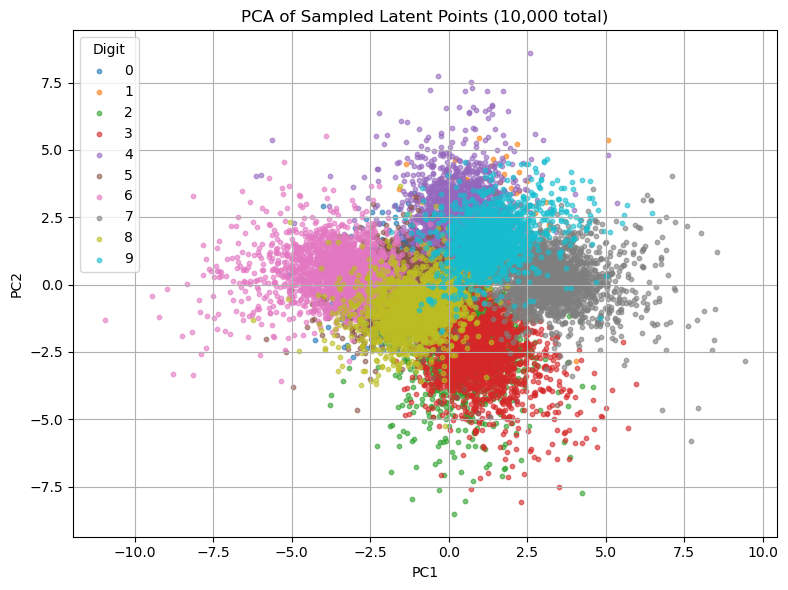

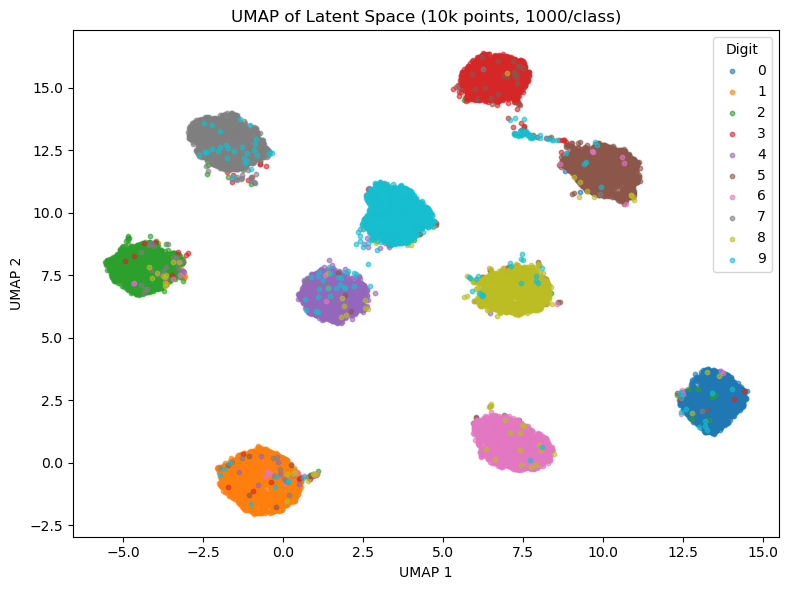

In [2]:
# ===== Sample 10 Unique Points per Class Without Replacement from z_all[:1000] =====
z_subset = z_all
y_subset = y_all

selected_z, selected_y = [], []
for digit in range(10):
    idx = (y_subset == digit).nonzero(as_tuple=True)[0]
    chosen = idx[torch.randperm(len(idx))[:2000]]  # 2000 samples per class
    selected_z.append(z_subset[chosen])
    selected_y.append(y_subset[chosen])

z_sampled = torch.cat(selected_z, dim=0)
y_sampled = torch.cat(selected_y, dim=0)

print(f"✅ Sampled {z_sampled.shape[0]} points across all classes without replacement.")


from sklearn.decomposition import PCA

# Convert to NumPy for PCA
z_np = z_sampled.cpu().numpy()
y_np = y_sampled.cpu().numpy()

# Fit and transform with PCA
pca = PCA(n_components=2)
z_pca = pca.fit_transform(z_np)

# Plot PCA
plt.figure(figsize=(8, 6))
for digit in range(10):
    idx = y_np == digit
    plt.scatter(z_pca[idx, 0], z_pca[idx, 1], label=str(digit), alpha=0.6, s=10)

plt.legend(title="Digit")
plt.title("PCA of Sampled Latent Points (10,000 total)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.tight_layout()
plt.savefig("pca_10000_latents.png", dpi=300)
plt.show()


import umap
import seaborn as sns

# ===== Apply UMAP =====
umap_model = umap.UMAP(n_components=2, random_state=42)
z_umap = umap_model.fit_transform(z_sampled)

# ===== Plot UMAP (no grid, save as SVG) =====
plt.figure(figsize=(8, 6))
palette = sns.color_palette("tab10", 10)
for digit in range(10):
    idx = y_sampled == digit
    plt.scatter(
        z_umap[idx, 0],
        z_umap[idx, 1],
        label=str(digit),
        alpha=0.6,
        s=10,
        color=palette[digit],
    )

plt.legend(title="Digit")
plt.title("UMAP of Latent Space (10k points, 1000/class)")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
# no plt.grid() here
plt.tight_layout()
plt.savefig("umap_10000_latents.svg", format="svg", bbox_inches="tight")
plt.show()


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import matplotlib.pyplot as plt

# ===== Beta Schedule Options =====
def linear_beta_schedule(T, beta_min=1e-4, beta_max=0.02):
    return torch.linspace(beta_min, beta_max, T)

def optimal_beta_schedule_sigma_ramp(T, sigma_0=10., sigma_1=5.):
    t = torch.linspace(0, 1, T)
    delta_sigma = sigma_1 - sigma_0
    sigma_t = sigma_0 + t * delta_sigma
    gamma_t = 1/sigma_t ** 2
    eta_t = delta_sigma / (sigma_t * T)
    return gamma_t + eta_t 

# ===== Diffusion Configs =====
T = 1000
schedules = {
    'linear': linear_beta_schedule(T),
    # 'cd_opt': optimal_beta_schedule_sigma_ramp(T)
}

# To track best per schedule
best_losses = {}
best_states = {}

# ===== Fast Analytic grad log p(y | z) for linear classifier =====
@torch.no_grad()
def grad_logp(y, z):
    logits = z_classifier(z)
    probs = F.softmax(logits, dim=1)
    onehot = F.one_hot(y, num_classes=probs.size(1)).float()
    diff = onehot - probs
    W = z_classifier.linear.weight
    return diff @ W

for schedule_name, betas in schedules.items():
    print(f"🔁 Training with schedule: {schedule_name}")
    alphas = 1. - betas
    alphas_bar = torch.cumprod(alphas, dim=0)

    def q_sample(z0, t):
        noise = torch.randn_like(z0)
        sqrt_ab = torch.sqrt(alphas_bar[t]).view(-1, 1)
        sqrt_mab = torch.sqrt(1 - alphas_bar[t]).view(-1, 1)
        return sqrt_ab * z0 + sqrt_mab * noise

    class ConditionalDenoiser(nn.Module):
        def __init__(self, latent_dim=10, n_classes=10):
            super().__init__()
            self.embed_class = nn.Embedding(n_classes, 64)
            self.embed_time = nn.Sequential(
                nn.Linear(1, 64), nn.GELU(),
                nn.Linear(64, 64)
            )
            self.net = nn.Sequential(
                nn.Linear(latent_dim + 128, 512), nn.GELU(),
                nn.Linear(512, 512), nn.GELU(),
                nn.Linear(512, 512), nn.GELU(),
                nn.Linear(512, latent_dim)
            )

        def forward(self, zt, t, y):
            t_embed = self.embed_time(t.float().unsqueeze(1) / T)
            y_embed = self.embed_class(y)
            cond = torch.cat([t_embed, y_embed], dim=1)
            return self.net(torch.cat([zt, cond], dim=1))

    den_model = ConditionalDenoiser().to(z_all.device)
    optimizer = torch.optim.Adam(den_model.parameters(), lr=1e-3)
    dataloader = DataLoader(TensorDataset(z_sampled, y_sampled), batch_size=5000, shuffle=True)

    best_loss = float("inf")

    den_model.train()
    for epoch in range(1000):
        total_loss = 0
        for z0, y in tqdm(dataloader, desc=f"{schedule_name} Epoch {epoch+1}"):
            z0, y = z0.to(z_all.device), y.to(z_all.device)
            t = torch.randint(0, T, (z0.size(0),), device=z0.device)
            zt = q_sample(z0, t)
            noise = (zt - torch.sqrt(alphas_bar[t].view(-1, 1)) * z0) / torch.sqrt(1 - alphas_bar[t].view(-1, 1))

            pred_noise = den_model(zt, t, y)
            loss = F.mse_loss(pred_noise, noise)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)
        print(f"🧮 {schedule_name} Epoch {epoch+1}: Loss = {avg_loss:.6f}")

        if avg_loss < best_loss:
            best_loss = avg_loss
            best_state = den_model.state_dict()

    # Save best for this schedule
    best_losses[schedule_name] = best_loss
    best_states[schedule_name] = best_state
    torch.save(best_state, f"best_denoiser_{schedule_name}.pth")
    print(f"✅ Saved best model for '{schedule_name}' with loss {best_loss:.6f}")

# Summary
print("\n=== Best Losses by Schedule ===")
for name, loss in best_losses.items():
    print(f"{name}: {loss:.6f}")


🔁 Training with schedule: linear


linear Epoch 1: 100%|█████████████████████████████| 4/4 [00:00<00:00, 20.92it/s]


🧮 linear Epoch 1: Loss = 0.968993


linear Epoch 2: 100%|█████████████████████████████| 4/4 [00:00<00:00, 13.99it/s]


🧮 linear Epoch 2: Loss = 0.825323


linear Epoch 3: 100%|█████████████████████████████| 4/4 [00:00<00:00, 23.59it/s]


🧮 linear Epoch 3: Loss = 0.558922


linear Epoch 4: 100%|█████████████████████████████| 4/4 [00:00<00:00, 23.66it/s]


🧮 linear Epoch 4: Loss = 0.521431


linear Epoch 5: 100%|█████████████████████████████| 4/4 [00:00<00:00, 13.19it/s]


🧮 linear Epoch 5: Loss = 0.444464


linear Epoch 6: 100%|█████████████████████████████| 4/4 [00:00<00:00, 23.56it/s]


🧮 linear Epoch 6: Loss = 0.443419


linear Epoch 7: 100%|█████████████████████████████| 4/4 [00:00<00:00, 14.57it/s]


🧮 linear Epoch 7: Loss = 0.429363


linear Epoch 8: 100%|█████████████████████████████| 4/4 [00:00<00:00, 23.00it/s]


🧮 linear Epoch 8: Loss = 0.402864


linear Epoch 9: 100%|█████████████████████████████| 4/4 [00:00<00:00, 23.42it/s]


🧮 linear Epoch 9: Loss = 0.384793


linear Epoch 10: 100%|████████████████████████████| 4/4 [00:00<00:00, 13.16it/s]


🧮 linear Epoch 10: Loss = 0.367039


linear Epoch 11: 100%|████████████████████████████| 4/4 [00:00<00:00, 22.32it/s]


🧮 linear Epoch 11: Loss = 0.354828


linear Epoch 12: 100%|████████████████████████████| 4/4 [00:00<00:00, 12.97it/s]


🧮 linear Epoch 12: Loss = 0.348891


linear Epoch 13: 100%|████████████████████████████| 4/4 [00:00<00:00, 21.89it/s]


🧮 linear Epoch 13: Loss = 0.341330


linear Epoch 14: 100%|████████████████████████████| 4/4 [00:00<00:00, 23.55it/s]


🧮 linear Epoch 14: Loss = 0.333565


linear Epoch 15: 100%|████████████████████████████| 4/4 [00:00<00:00, 12.48it/s]


🧮 linear Epoch 15: Loss = 0.323583


linear Epoch 16: 100%|████████████████████████████| 4/4 [00:00<00:00, 22.48it/s]


🧮 linear Epoch 16: Loss = 0.317720


linear Epoch 17: 100%|████████████████████████████| 4/4 [00:00<00:00, 23.48it/s]


🧮 linear Epoch 17: Loss = 0.320819


linear Epoch 18: 100%|████████████████████████████| 4/4 [00:00<00:00, 13.28it/s]


🧮 linear Epoch 18: Loss = 0.308950


linear Epoch 19: 100%|████████████████████████████| 4/4 [00:00<00:00, 22.29it/s]


🧮 linear Epoch 19: Loss = 0.310094


linear Epoch 20: 100%|████████████████████████████| 4/4 [00:00<00:00, 13.13it/s]


🧮 linear Epoch 20: Loss = 0.305961


linear Epoch 21: 100%|████████████████████████████| 4/4 [00:00<00:00, 19.94it/s]


🧮 linear Epoch 21: Loss = 0.296434


linear Epoch 22: 100%|████████████████████████████| 4/4 [00:00<00:00, 21.51it/s]


🧮 linear Epoch 22: Loss = 0.301300


linear Epoch 23: 100%|████████████████████████████| 4/4 [00:00<00:00, 13.54it/s]


🧮 linear Epoch 23: Loss = 0.299404


linear Epoch 24: 100%|████████████████████████████| 4/4 [00:00<00:00, 22.94it/s]


🧮 linear Epoch 24: Loss = 0.288093


linear Epoch 25: 100%|████████████████████████████| 4/4 [00:00<00:00, 13.84it/s]


🧮 linear Epoch 25: Loss = 0.285121


linear Epoch 26: 100%|████████████████████████████| 4/4 [00:00<00:00, 21.04it/s]


🧮 linear Epoch 26: Loss = 0.282797


linear Epoch 27: 100%|████████████████████████████| 4/4 [00:00<00:00, 22.87it/s]


🧮 linear Epoch 27: Loss = 0.284221


linear Epoch 28: 100%|████████████████████████████| 4/4 [00:00<00:00, 13.48it/s]


🧮 linear Epoch 28: Loss = 0.278595


linear Epoch 29: 100%|████████████████████████████| 4/4 [00:00<00:00, 22.76it/s]


🧮 linear Epoch 29: Loss = 0.275396


linear Epoch 30: 100%|████████████████████████████| 4/4 [00:00<00:00, 24.00it/s]


🧮 linear Epoch 30: Loss = 0.277376


linear Epoch 31: 100%|████████████████████████████| 4/4 [00:00<00:00, 14.28it/s]


🧮 linear Epoch 31: Loss = 0.272364


linear Epoch 32: 100%|████████████████████████████| 4/4 [00:00<00:00, 24.06it/s]


🧮 linear Epoch 32: Loss = 0.275426


linear Epoch 33: 100%|████████████████████████████| 4/4 [00:00<00:00, 13.05it/s]


🧮 linear Epoch 33: Loss = 0.270448


linear Epoch 34: 100%|████████████████████████████| 4/4 [00:00<00:00, 22.59it/s]


🧮 linear Epoch 34: Loss = 0.274016


linear Epoch 35: 100%|████████████████████████████| 4/4 [00:00<00:00, 23.96it/s]


🧮 linear Epoch 35: Loss = 0.272670


linear Epoch 36: 100%|████████████████████████████| 4/4 [00:00<00:00, 14.15it/s]


🧮 linear Epoch 36: Loss = 0.267965


linear Epoch 37: 100%|████████████████████████████| 4/4 [00:00<00:00, 23.33it/s]


🧮 linear Epoch 37: Loss = 0.272634


linear Epoch 38: 100%|████████████████████████████| 4/4 [00:00<00:00, 13.87it/s]


🧮 linear Epoch 38: Loss = 0.265264


linear Epoch 39: 100%|████████████████████████████| 4/4 [00:00<00:00, 22.00it/s]


🧮 linear Epoch 39: Loss = 0.272102


linear Epoch 40: 100%|████████████████████████████| 4/4 [00:00<00:00, 23.96it/s]


🧮 linear Epoch 40: Loss = 0.267265


linear Epoch 41: 100%|████████████████████████████| 4/4 [00:00<00:00, 13.47it/s]


🧮 linear Epoch 41: Loss = 0.275100


linear Epoch 42: 100%|████████████████████████████| 4/4 [00:00<00:00, 22.66it/s]


🧮 linear Epoch 42: Loss = 0.267107


linear Epoch 43: 100%|████████████████████████████| 4/4 [00:00<00:00, 23.82it/s]


🧮 linear Epoch 43: Loss = 0.273861


linear Epoch 44: 100%|████████████████████████████| 4/4 [00:00<00:00, 13.36it/s]


🧮 linear Epoch 44: Loss = 0.267279


linear Epoch 45: 100%|████████████████████████████| 4/4 [00:00<00:00, 22.04it/s]


🧮 linear Epoch 45: Loss = 0.273149


linear Epoch 46: 100%|████████████████████████████| 4/4 [00:00<00:00, 13.53it/s]


🧮 linear Epoch 46: Loss = 0.273770


linear Epoch 47: 100%|████████████████████████████| 4/4 [00:00<00:00, 22.14it/s]


🧮 linear Epoch 47: Loss = 0.265225


linear Epoch 48: 100%|████████████████████████████| 4/4 [00:00<00:00, 23.70it/s]


🧮 linear Epoch 48: Loss = 0.272216


linear Epoch 49: 100%|████████████████████████████| 4/4 [00:00<00:00, 13.14it/s]


🧮 linear Epoch 49: Loss = 0.268957


linear Epoch 50: 100%|████████████████████████████| 4/4 [00:00<00:00, 22.27it/s]


🧮 linear Epoch 50: Loss = 0.272930


linear Epoch 51: 100%|████████████████████████████| 4/4 [00:00<00:00, 13.90it/s]


🧮 linear Epoch 51: Loss = 0.270128


linear Epoch 52: 100%|████████████████████████████| 4/4 [00:00<00:00, 21.30it/s]


🧮 linear Epoch 52: Loss = 0.265490


linear Epoch 53: 100%|████████████████████████████| 4/4 [00:00<00:00, 23.74it/s]


🧮 linear Epoch 53: Loss = 0.266692


linear Epoch 54: 100%|████████████████████████████| 4/4 [00:00<00:00, 13.13it/s]


🧮 linear Epoch 54: Loss = 0.267017


linear Epoch 55: 100%|████████████████████████████| 4/4 [00:00<00:00, 23.73it/s]


🧮 linear Epoch 55: Loss = 0.269373


linear Epoch 56: 100%|████████████████████████████| 4/4 [00:00<00:00, 23.62it/s]


🧮 linear Epoch 56: Loss = 0.271504


linear Epoch 57: 100%|████████████████████████████| 4/4 [00:00<00:00, 13.30it/s]


🧮 linear Epoch 57: Loss = 0.266190


linear Epoch 58: 100%|████████████████████████████| 4/4 [00:00<00:00, 23.84it/s]


🧮 linear Epoch 58: Loss = 0.271275


linear Epoch 59: 100%|████████████████████████████| 4/4 [00:00<00:00, 13.51it/s]


🧮 linear Epoch 59: Loss = 0.266432


linear Epoch 60: 100%|████████████████████████████| 4/4 [00:00<00:00, 22.01it/s]


🧮 linear Epoch 60: Loss = 0.270478


linear Epoch 61: 100%|████████████████████████████| 4/4 [00:00<00:00, 23.68it/s]


🧮 linear Epoch 61: Loss = 0.272664


linear Epoch 62: 100%|████████████████████████████| 4/4 [00:00<00:00, 13.19it/s]


🧮 linear Epoch 62: Loss = 0.267078


linear Epoch 63: 100%|████████████████████████████| 4/4 [00:00<00:00, 23.41it/s]


🧮 linear Epoch 63: Loss = 0.263987


linear Epoch 64: 100%|████████████████████████████| 4/4 [00:00<00:00, 14.31it/s]


🧮 linear Epoch 64: Loss = 0.271030


linear Epoch 65: 100%|████████████████████████████| 4/4 [00:00<00:00, 22.50it/s]


🧮 linear Epoch 65: Loss = 0.267162


linear Epoch 66: 100%|████████████████████████████| 4/4 [00:00<00:00, 23.47it/s]


🧮 linear Epoch 66: Loss = 0.270428


linear Epoch 67: 100%|████████████████████████████| 4/4 [00:00<00:00, 13.32it/s]


🧮 linear Epoch 67: Loss = 0.270980


linear Epoch 68: 100%|████████████████████████████| 4/4 [00:00<00:00, 23.39it/s]


🧮 linear Epoch 68: Loss = 0.265985


linear Epoch 69: 100%|████████████████████████████| 4/4 [00:00<00:00, 23.94it/s]


🧮 linear Epoch 69: Loss = 0.267022


linear Epoch 70: 100%|████████████████████████████| 4/4 [00:00<00:00, 14.24it/s]


🧮 linear Epoch 70: Loss = 0.266619


linear Epoch 71: 100%|████████████████████████████| 4/4 [00:00<00:00, 23.80it/s]


🧮 linear Epoch 71: Loss = 0.267397


linear Epoch 72: 100%|████████████████████████████| 4/4 [00:00<00:00, 13.57it/s]


🧮 linear Epoch 72: Loss = 0.265452


linear Epoch 73: 100%|████████████████████████████| 4/4 [00:00<00:00, 22.54it/s]


🧮 linear Epoch 73: Loss = 0.264334


linear Epoch 74: 100%|████████████████████████████| 4/4 [00:00<00:00, 14.41it/s]


🧮 linear Epoch 74: Loss = 0.267945


linear Epoch 75: 100%|████████████████████████████| 4/4 [00:00<00:00, 22.48it/s]


🧮 linear Epoch 75: Loss = 0.265975


linear Epoch 76: 100%|████████████████████████████| 4/4 [00:00<00:00, 24.00it/s]


🧮 linear Epoch 76: Loss = 0.265498


linear Epoch 77: 100%|████████████████████████████| 4/4 [00:00<00:00, 13.80it/s]


🧮 linear Epoch 77: Loss = 0.268233


linear Epoch 78: 100%|████████████████████████████| 4/4 [00:00<00:00, 22.18it/s]


🧮 linear Epoch 78: Loss = 0.268456


linear Epoch 79: 100%|████████████████████████████| 4/4 [00:00<00:00, 23.73it/s]


🧮 linear Epoch 79: Loss = 0.263178


linear Epoch 80: 100%|████████████████████████████| 4/4 [00:00<00:00, 13.42it/s]


🧮 linear Epoch 80: Loss = 0.262467


linear Epoch 81: 100%|████████████████████████████| 4/4 [00:00<00:00, 23.27it/s]


🧮 linear Epoch 81: Loss = 0.262609


linear Epoch 82: 100%|████████████████████████████| 4/4 [00:00<00:00, 23.81it/s]


🧮 linear Epoch 82: Loss = 0.270783


linear Epoch 83: 100%|████████████████████████████| 4/4 [00:00<00:00, 13.15it/s]


🧮 linear Epoch 83: Loss = 0.265143


linear Epoch 84: 100%|████████████████████████████| 4/4 [00:00<00:00, 23.63it/s]


🧮 linear Epoch 84: Loss = 0.264115


linear Epoch 85: 100%|████████████████████████████| 4/4 [00:00<00:00, 13.77it/s]


🧮 linear Epoch 85: Loss = 0.268087


linear Epoch 86: 100%|████████████████████████████| 4/4 [00:00<00:00, 22.60it/s]


🧮 linear Epoch 86: Loss = 0.266072


linear Epoch 87: 100%|████████████████████████████| 4/4 [00:00<00:00, 23.64it/s]


🧮 linear Epoch 87: Loss = 0.265567


linear Epoch 88: 100%|████████████████████████████| 4/4 [00:00<00:00, 13.19it/s]


🧮 linear Epoch 88: Loss = 0.266112


linear Epoch 89: 100%|████████████████████████████| 4/4 [00:00<00:00, 23.70it/s]


🧮 linear Epoch 89: Loss = 0.264721


linear Epoch 90: 100%|████████████████████████████| 4/4 [00:00<00:00, 13.99it/s]


🧮 linear Epoch 90: Loss = 0.264210


linear Epoch 91: 100%|████████████████████████████| 4/4 [00:00<00:00, 22.53it/s]


🧮 linear Epoch 91: Loss = 0.261994


linear Epoch 92: 100%|████████████████████████████| 4/4 [00:00<00:00, 23.67it/s]


🧮 linear Epoch 92: Loss = 0.264813


linear Epoch 93: 100%|████████████████████████████| 4/4 [00:00<00:00, 13.63it/s]


🧮 linear Epoch 93: Loss = 0.264369


linear Epoch 94: 100%|████████████████████████████| 4/4 [00:00<00:00, 23.69it/s]


🧮 linear Epoch 94: Loss = 0.268995


linear Epoch 95: 100%|████████████████████████████| 4/4 [00:00<00:00, 14.11it/s]


🧮 linear Epoch 95: Loss = 0.266708


linear Epoch 96: 100%|████████████████████████████| 4/4 [00:00<00:00, 23.36it/s]


🧮 linear Epoch 96: Loss = 0.264207


linear Epoch 97: 100%|████████████████████████████| 4/4 [00:00<00:00, 23.88it/s]


🧮 linear Epoch 97: Loss = 0.263161


linear Epoch 98: 100%|████████████████████████████| 4/4 [00:00<00:00, 13.60it/s]


🧮 linear Epoch 98: Loss = 0.263157


linear Epoch 99: 100%|████████████████████████████| 4/4 [00:00<00:00, 22.57it/s]


🧮 linear Epoch 99: Loss = 0.268136


linear Epoch 100: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.88it/s]


🧮 linear Epoch 100: Loss = 0.260980


linear Epoch 101: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.33it/s]


🧮 linear Epoch 101: Loss = 0.261750


linear Epoch 102: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.64it/s]


🧮 linear Epoch 102: Loss = 0.262682


linear Epoch 103: 100%|███████████████████████████| 4/4 [00:00<00:00, 14.75it/s]


🧮 linear Epoch 103: Loss = 0.268790


linear Epoch 104: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.26it/s]


🧮 linear Epoch 104: Loss = 0.261960


linear Epoch 105: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.75it/s]


🧮 linear Epoch 105: Loss = 0.264041


linear Epoch 106: 100%|███████████████████████████| 4/4 [00:00<00:00, 14.33it/s]


🧮 linear Epoch 106: Loss = 0.262656


linear Epoch 107: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.62it/s]


🧮 linear Epoch 107: Loss = 0.263928


linear Epoch 108: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.86it/s]


🧮 linear Epoch 108: Loss = 0.269822


linear Epoch 109: 100%|███████████████████████████| 4/4 [00:00<00:00, 22.11it/s]


🧮 linear Epoch 109: Loss = 0.268244


linear Epoch 110: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.91it/s]


🧮 linear Epoch 110: Loss = 0.264258


linear Epoch 111: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.60it/s]


🧮 linear Epoch 111: Loss = 0.258896


linear Epoch 112: 100%|███████████████████████████| 4/4 [00:00<00:00, 22.70it/s]


🧮 linear Epoch 112: Loss = 0.266332


linear Epoch 113: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.82it/s]


🧮 linear Epoch 113: Loss = 0.267273


linear Epoch 114: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.32it/s]


🧮 linear Epoch 114: Loss = 0.262398


linear Epoch 115: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.69it/s]


🧮 linear Epoch 115: Loss = 0.267978


linear Epoch 116: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.25it/s]


🧮 linear Epoch 116: Loss = 0.262155


linear Epoch 117: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.25it/s]


🧮 linear Epoch 117: Loss = 0.269006


linear Epoch 118: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.80it/s]


🧮 linear Epoch 118: Loss = 0.260876


linear Epoch 119: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.73it/s]


🧮 linear Epoch 119: Loss = 0.264050


linear Epoch 120: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.58it/s]


🧮 linear Epoch 120: Loss = 0.263483


linear Epoch 121: 100%|███████████████████████████| 4/4 [00:00<00:00, 14.05it/s]


🧮 linear Epoch 121: Loss = 0.261718


linear Epoch 122: 100%|███████████████████████████| 4/4 [00:00<00:00, 22.43it/s]


🧮 linear Epoch 122: Loss = 0.265193


linear Epoch 123: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.86it/s]


🧮 linear Epoch 123: Loss = 0.266191


linear Epoch 124: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.73it/s]


🧮 linear Epoch 124: Loss = 0.260711


linear Epoch 125: 100%|███████████████████████████| 4/4 [00:00<00:00, 22.58it/s]


🧮 linear Epoch 125: Loss = 0.267086


linear Epoch 126: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.86it/s]


🧮 linear Epoch 126: Loss = 0.266996


linear Epoch 127: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.82it/s]


🧮 linear Epoch 127: Loss = 0.260714


linear Epoch 128: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.98it/s]


🧮 linear Epoch 128: Loss = 0.265491


linear Epoch 129: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.41it/s]


🧮 linear Epoch 129: Loss = 0.265585


linear Epoch 130: 100%|███████████████████████████| 4/4 [00:00<00:00, 22.60it/s]


🧮 linear Epoch 130: Loss = 0.258405


linear Epoch 131: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.84it/s]


🧮 linear Epoch 131: Loss = 0.263368


linear Epoch 132: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.44it/s]


🧮 linear Epoch 132: Loss = 0.270584


linear Epoch 133: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.24it/s]


🧮 linear Epoch 133: Loss = 0.263273


linear Epoch 134: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.91it/s]


🧮 linear Epoch 134: Loss = 0.263736


linear Epoch 135: 100%|███████████████████████████| 4/4 [00:00<00:00, 22.34it/s]


🧮 linear Epoch 135: Loss = 0.264697


linear Epoch 136: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.81it/s]


🧮 linear Epoch 136: Loss = 0.270403


linear Epoch 137: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.28it/s]


🧮 linear Epoch 137: Loss = 0.261527


linear Epoch 138: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.59it/s]


🧮 linear Epoch 138: Loss = 0.261917


linear Epoch 139: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.89it/s]


🧮 linear Epoch 139: Loss = 0.262466


linear Epoch 140: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.26it/s]


🧮 linear Epoch 140: Loss = 0.267797


linear Epoch 141: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.57it/s]


🧮 linear Epoch 141: Loss = 0.262769


linear Epoch 142: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.75it/s]


🧮 linear Epoch 142: Loss = 0.262412


linear Epoch 143: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.19it/s]


🧮 linear Epoch 143: Loss = 0.263266


linear Epoch 144: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.80it/s]


🧮 linear Epoch 144: Loss = 0.268252


linear Epoch 145: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.46it/s]


🧮 linear Epoch 145: Loss = 0.259397


linear Epoch 146: 100%|███████████████████████████| 4/4 [00:00<00:00, 22.81it/s]


🧮 linear Epoch 146: Loss = 0.260844


linear Epoch 147: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.96it/s]


🧮 linear Epoch 147: Loss = 0.261876


linear Epoch 148: 100%|███████████████████████████| 4/4 [00:00<00:00, 22.49it/s]


🧮 linear Epoch 148: Loss = 0.262307


linear Epoch 149: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.62it/s]


🧮 linear Epoch 149: Loss = 0.266083


linear Epoch 150: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.19it/s]


🧮 linear Epoch 150: Loss = 0.265586


linear Epoch 151: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.44it/s]


🧮 linear Epoch 151: Loss = 0.262804


linear Epoch 152: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.91it/s]


🧮 linear Epoch 152: Loss = 0.259250


linear Epoch 153: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.19it/s]


🧮 linear Epoch 153: Loss = 0.264463


linear Epoch 154: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.57it/s]


🧮 linear Epoch 154: Loss = 0.264042


linear Epoch 155: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.57it/s]


🧮 linear Epoch 155: Loss = 0.269468


linear Epoch 156: 100%|███████████████████████████| 4/4 [00:00<00:00, 22.95it/s]


🧮 linear Epoch 156: Loss = 0.267966


linear Epoch 157: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.97it/s]


🧮 linear Epoch 157: Loss = 0.264408


linear Epoch 158: 100%|███████████████████████████| 4/4 [00:00<00:00, 22.37it/s]


🧮 linear Epoch 158: Loss = 0.258040


linear Epoch 159: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.74it/s]


🧮 linear Epoch 159: Loss = 0.261890


linear Epoch 160: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.91it/s]


🧮 linear Epoch 160: Loss = 0.262169


linear Epoch 161: 100%|███████████████████████████| 4/4 [00:00<00:00, 21.59it/s]


🧮 linear Epoch 161: Loss = 0.265031


linear Epoch 162: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.47it/s]


🧮 linear Epoch 162: Loss = 0.266160


linear Epoch 163: 100%|███████████████████████████| 4/4 [00:00<00:00, 12.95it/s]


🧮 linear Epoch 163: Loss = 0.261171


linear Epoch 164: 100%|███████████████████████████| 4/4 [00:00<00:00, 22.21it/s]


🧮 linear Epoch 164: Loss = 0.262697


linear Epoch 165: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.79it/s]


🧮 linear Epoch 165: Loss = 0.264169


linear Epoch 166: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.21it/s]


🧮 linear Epoch 166: Loss = 0.267940


linear Epoch 167: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.74it/s]


🧮 linear Epoch 167: Loss = 0.259641


linear Epoch 168: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.63it/s]


🧮 linear Epoch 168: Loss = 0.264424


linear Epoch 169: 100%|███████████████████████████| 4/4 [00:00<00:00, 22.22it/s]


🧮 linear Epoch 169: Loss = 0.262685


linear Epoch 170: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.80it/s]


🧮 linear Epoch 170: Loss = 0.258366


linear Epoch 171: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.03it/s]


🧮 linear Epoch 171: Loss = 0.259780


linear Epoch 172: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.29it/s]


🧮 linear Epoch 172: Loss = 0.262788


linear Epoch 173: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.64it/s]


🧮 linear Epoch 173: Loss = 0.259632


linear Epoch 174: 100%|███████████████████████████| 4/4 [00:00<00:00, 21.52it/s]


🧮 linear Epoch 174: Loss = 0.262535


linear Epoch 175: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.22it/s]


🧮 linear Epoch 175: Loss = 0.261027


linear Epoch 176: 100%|███████████████████████████| 4/4 [00:00<00:00, 12.71it/s]


🧮 linear Epoch 176: Loss = 0.262116


linear Epoch 177: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.05it/s]


🧮 linear Epoch 177: Loss = 0.263629


linear Epoch 178: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.16it/s]


🧮 linear Epoch 178: Loss = 0.258483


linear Epoch 179: 100%|███████████████████████████| 4/4 [00:00<00:00, 22.06it/s]


🧮 linear Epoch 179: Loss = 0.265795


linear Epoch 180: 100%|███████████████████████████| 4/4 [00:00<00:00, 22.95it/s]


🧮 linear Epoch 180: Loss = 0.265855


linear Epoch 181: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.56it/s]


🧮 linear Epoch 181: Loss = 0.260857


linear Epoch 182: 100%|███████████████████████████| 4/4 [00:00<00:00, 22.85it/s]


🧮 linear Epoch 182: Loss = 0.264205


linear Epoch 183: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.88it/s]


🧮 linear Epoch 183: Loss = 0.264709


linear Epoch 184: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.09it/s]


🧮 linear Epoch 184: Loss = 0.265941


linear Epoch 185: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.53it/s]


🧮 linear Epoch 185: Loss = 0.259723


linear Epoch 186: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.74it/s]


🧮 linear Epoch 186: Loss = 0.261447


linear Epoch 187: 100%|███████████████████████████| 4/4 [00:00<00:00, 21.18it/s]


🧮 linear Epoch 187: Loss = 0.260238


linear Epoch 188: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.51it/s]


🧮 linear Epoch 188: Loss = 0.257767


linear Epoch 189: 100%|███████████████████████████| 4/4 [00:00<00:00, 11.76it/s]


🧮 linear Epoch 189: Loss = 0.266475


linear Epoch 190: 100%|███████████████████████████| 4/4 [00:00<00:00, 22.74it/s]


🧮 linear Epoch 190: Loss = 0.260860


linear Epoch 191: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.57it/s]


🧮 linear Epoch 191: Loss = 0.260080


linear Epoch 192: 100%|███████████████████████████| 4/4 [00:00<00:00, 19.88it/s]


🧮 linear Epoch 192: Loss = 0.261220


linear Epoch 193: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.55it/s]


🧮 linear Epoch 193: Loss = 0.262843


linear Epoch 194: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.45it/s]


🧮 linear Epoch 194: Loss = 0.260179


linear Epoch 195: 100%|███████████████████████████| 4/4 [00:00<00:00, 21.56it/s]


🧮 linear Epoch 195: Loss = 0.266556


linear Epoch 196: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.53it/s]


🧮 linear Epoch 196: Loss = 0.264926


linear Epoch 197: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.10it/s]


🧮 linear Epoch 197: Loss = 0.262613


linear Epoch 198: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.28it/s]


🧮 linear Epoch 198: Loss = 0.263000


linear Epoch 199: 100%|███████████████████████████| 4/4 [00:00<00:00, 12.88it/s]


🧮 linear Epoch 199: Loss = 0.263794


linear Epoch 200: 100%|███████████████████████████| 4/4 [00:00<00:00, 21.83it/s]


🧮 linear Epoch 200: Loss = 0.266480


linear Epoch 201: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.75it/s]


🧮 linear Epoch 201: Loss = 0.262225


linear Epoch 202: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.42it/s]


🧮 linear Epoch 202: Loss = 0.257011


linear Epoch 203: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.08it/s]


🧮 linear Epoch 203: Loss = 0.263377


linear Epoch 204: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.84it/s]


🧮 linear Epoch 204: Loss = 0.268018


linear Epoch 205: 100%|███████████████████████████| 4/4 [00:00<00:00, 21.30it/s]


🧮 linear Epoch 205: Loss = 0.262811


linear Epoch 206: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.20it/s]


🧮 linear Epoch 206: Loss = 0.260900


linear Epoch 207: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.29it/s]


🧮 linear Epoch 207: Loss = 0.262944


linear Epoch 208: 100%|███████████████████████████| 4/4 [00:00<00:00, 21.01it/s]


🧮 linear Epoch 208: Loss = 0.259865


linear Epoch 209: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.24it/s]


🧮 linear Epoch 209: Loss = 0.264178


linear Epoch 210: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.23it/s]


🧮 linear Epoch 210: Loss = 0.259891


linear Epoch 211: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.33it/s]


🧮 linear Epoch 211: Loss = 0.264208


linear Epoch 212: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.56it/s]


🧮 linear Epoch 212: Loss = 0.268291


linear Epoch 213: 100%|███████████████████████████| 4/4 [00:00<00:00, 22.51it/s]


🧮 linear Epoch 213: Loss = 0.264362


linear Epoch 214: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.63it/s]


🧮 linear Epoch 214: Loss = 0.260403


linear Epoch 215: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.31it/s]


🧮 linear Epoch 215: Loss = 0.261436


linear Epoch 216: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.03it/s]


🧮 linear Epoch 216: Loss = 0.260069


linear Epoch 217: 100%|███████████████████████████| 4/4 [00:00<00:00, 14.01it/s]


🧮 linear Epoch 217: Loss = 0.256332


linear Epoch 218: 100%|███████████████████████████| 4/4 [00:00<00:00, 21.21it/s]


🧮 linear Epoch 218: Loss = 0.256522


linear Epoch 219: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.24it/s]


🧮 linear Epoch 219: Loss = 0.260014


linear Epoch 220: 100%|███████████████████████████| 4/4 [00:00<00:00, 12.65it/s]


🧮 linear Epoch 220: Loss = 0.259775


linear Epoch 221: 100%|███████████████████████████| 4/4 [00:00<00:00, 22.80it/s]


🧮 linear Epoch 221: Loss = 0.261084


linear Epoch 222: 100%|███████████████████████████| 4/4 [00:00<00:00, 22.14it/s]


🧮 linear Epoch 222: Loss = 0.263202


linear Epoch 223: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.49it/s]


🧮 linear Epoch 223: Loss = 0.257063


linear Epoch 224: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.40it/s]


🧮 linear Epoch 224: Loss = 0.263215


linear Epoch 225: 100%|███████████████████████████| 4/4 [00:00<00:00, 12.60it/s]


🧮 linear Epoch 225: Loss = 0.259332


linear Epoch 226: 100%|███████████████████████████| 4/4 [00:00<00:00, 21.11it/s]


🧮 linear Epoch 226: Loss = 0.266707


linear Epoch 227: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.76it/s]


🧮 linear Epoch 227: Loss = 0.257830


linear Epoch 228: 100%|███████████████████████████| 4/4 [00:00<00:00, 12.77it/s]


🧮 linear Epoch 228: Loss = 0.262084


linear Epoch 229: 100%|███████████████████████████| 4/4 [00:00<00:00, 22.25it/s]


🧮 linear Epoch 229: Loss = 0.262280


linear Epoch 230: 100%|███████████████████████████| 4/4 [00:00<00:00, 14.11it/s]


🧮 linear Epoch 230: Loss = 0.262253


linear Epoch 231: 100%|███████████████████████████| 4/4 [00:00<00:00, 22.13it/s]


🧮 linear Epoch 231: Loss = 0.265985


linear Epoch 232: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.75it/s]


🧮 linear Epoch 232: Loss = 0.263189


linear Epoch 233: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.16it/s]


🧮 linear Epoch 233: Loss = 0.258007


linear Epoch 234: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.20it/s]


🧮 linear Epoch 234: Loss = 0.256350


linear Epoch 235: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.94it/s]


🧮 linear Epoch 235: Loss = 0.256814


linear Epoch 236: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.20it/s]


🧮 linear Epoch 236: Loss = 0.257965


linear Epoch 237: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.54it/s]


🧮 linear Epoch 237: Loss = 0.260068


linear Epoch 238: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.53it/s]


🧮 linear Epoch 238: Loss = 0.259883


linear Epoch 239: 100%|███████████████████████████| 4/4 [00:00<00:00, 22.10it/s]


🧮 linear Epoch 239: Loss = 0.266958


linear Epoch 240: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.88it/s]


🧮 linear Epoch 240: Loss = 0.258930


linear Epoch 241: 100%|███████████████████████████| 4/4 [00:00<00:00, 22.46it/s]


🧮 linear Epoch 241: Loss = 0.261577


linear Epoch 242: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.73it/s]


🧮 linear Epoch 242: Loss = 0.257877


linear Epoch 243: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.94it/s]


🧮 linear Epoch 243: Loss = 0.261677


linear Epoch 244: 100%|███████████████████████████| 4/4 [00:00<00:00, 22.07it/s]


🧮 linear Epoch 244: Loss = 0.260338


linear Epoch 245: 100%|███████████████████████████| 4/4 [00:00<00:00, 18.39it/s]


🧮 linear Epoch 245: Loss = 0.259171


linear Epoch 246: 100%|███████████████████████████| 4/4 [00:00<00:00, 14.77it/s]


🧮 linear Epoch 246: Loss = 0.261341


linear Epoch 247: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.94it/s]


🧮 linear Epoch 247: Loss = 0.257651


linear Epoch 248: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.79it/s]


🧮 linear Epoch 248: Loss = 0.263057


linear Epoch 249: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.16it/s]


🧮 linear Epoch 249: Loss = 0.263612


linear Epoch 250: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.40it/s]


🧮 linear Epoch 250: Loss = 0.260863


linear Epoch 251: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.57it/s]


🧮 linear Epoch 251: Loss = 0.264651


linear Epoch 252: 100%|███████████████████████████| 4/4 [00:00<00:00, 22.99it/s]


🧮 linear Epoch 252: Loss = 0.261348


linear Epoch 253: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.95it/s]


🧮 linear Epoch 253: Loss = 0.261204


linear Epoch 254: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.33it/s]


🧮 linear Epoch 254: Loss = 0.262574


linear Epoch 255: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.29it/s]


🧮 linear Epoch 255: Loss = 0.265325


linear Epoch 256: 100%|███████████████████████████| 4/4 [00:00<00:00, 14.41it/s]


🧮 linear Epoch 256: Loss = 0.262894


linear Epoch 257: 100%|███████████████████████████| 4/4 [00:00<00:00, 22.60it/s]


🧮 linear Epoch 257: Loss = 0.258375


linear Epoch 258: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.93it/s]


🧮 linear Epoch 258: Loss = 0.263472


linear Epoch 259: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.49it/s]


🧮 linear Epoch 259: Loss = 0.264907


linear Epoch 260: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.32it/s]


🧮 linear Epoch 260: Loss = 0.260948


linear Epoch 261: 100%|███████████████████████████| 4/4 [00:00<00:00, 14.19it/s]


🧮 linear Epoch 261: Loss = 0.260962


linear Epoch 262: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.80it/s]


🧮 linear Epoch 262: Loss = 0.261887


linear Epoch 263: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.75it/s]


🧮 linear Epoch 263: Loss = 0.264560


linear Epoch 264: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.67it/s]


🧮 linear Epoch 264: Loss = 0.259757


linear Epoch 265: 100%|███████████████████████████| 4/4 [00:00<00:00, 22.74it/s]


🧮 linear Epoch 265: Loss = 0.260300


linear Epoch 266: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.94it/s]


🧮 linear Epoch 266: Loss = 0.263955


linear Epoch 267: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.25it/s]


🧮 linear Epoch 267: Loss = 0.259673


linear Epoch 268: 100%|███████████████████████████| 4/4 [00:00<00:00, 21.05it/s]


🧮 linear Epoch 268: Loss = 0.257995


linear Epoch 269: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.97it/s]


🧮 linear Epoch 269: Loss = 0.260092


linear Epoch 270: 100%|███████████████████████████| 4/4 [00:00<00:00, 22.22it/s]


🧮 linear Epoch 270: Loss = 0.263019


linear Epoch 271: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.73it/s]


🧮 linear Epoch 271: Loss = 0.254576


linear Epoch 272: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.70it/s]


🧮 linear Epoch 272: Loss = 0.260256


linear Epoch 273: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.68it/s]


🧮 linear Epoch 273: Loss = 0.257393


linear Epoch 274: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.92it/s]


🧮 linear Epoch 274: Loss = 0.263573


linear Epoch 275: 100%|███████████████████████████| 4/4 [00:00<00:00, 22.34it/s]


🧮 linear Epoch 275: Loss = 0.260860


linear Epoch 276: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.74it/s]


🧮 linear Epoch 276: Loss = 0.260366


linear Epoch 277: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.49it/s]


🧮 linear Epoch 277: Loss = 0.258621


linear Epoch 278: 100%|███████████████████████████| 4/4 [00:00<00:00, 22.38it/s]


🧮 linear Epoch 278: Loss = 0.258209


linear Epoch 279: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.86it/s]


🧮 linear Epoch 279: Loss = 0.261457


linear Epoch 280: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.65it/s]


🧮 linear Epoch 280: Loss = 0.262400


linear Epoch 281: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.78it/s]


🧮 linear Epoch 281: Loss = 0.263390


linear Epoch 282: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.42it/s]


🧮 linear Epoch 282: Loss = 0.262332


linear Epoch 283: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.18it/s]


🧮 linear Epoch 283: Loss = 0.261087


linear Epoch 284: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.87it/s]


🧮 linear Epoch 284: Loss = 0.260150


linear Epoch 285: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.83it/s]


🧮 linear Epoch 285: Loss = 0.262973


linear Epoch 286: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.66it/s]


🧮 linear Epoch 286: Loss = 0.260369


linear Epoch 287: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.83it/s]


🧮 linear Epoch 287: Loss = 0.264502


linear Epoch 288: 100%|███████████████████████████| 4/4 [00:00<00:00, 22.49it/s]


🧮 linear Epoch 288: Loss = 0.262339


linear Epoch 289: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.73it/s]


🧮 linear Epoch 289: Loss = 0.261096


linear Epoch 290: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.59it/s]


🧮 linear Epoch 290: Loss = 0.258100


linear Epoch 291: 100%|███████████████████████████| 4/4 [00:00<00:00, 22.71it/s]


🧮 linear Epoch 291: Loss = 0.259908


linear Epoch 292: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.94it/s]


🧮 linear Epoch 292: Loss = 0.261008


linear Epoch 293: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.44it/s]


🧮 linear Epoch 293: Loss = 0.258980


linear Epoch 294: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.66it/s]


🧮 linear Epoch 294: Loss = 0.266282


linear Epoch 295: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.81it/s]


🧮 linear Epoch 295: Loss = 0.258577


linear Epoch 296: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.17it/s]


🧮 linear Epoch 296: Loss = 0.257614


linear Epoch 297: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.64it/s]


🧮 linear Epoch 297: Loss = 0.262088


linear Epoch 298: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.07it/s]


🧮 linear Epoch 298: Loss = 0.259695


linear Epoch 299: 100%|███████████████████████████| 4/4 [00:00<00:00, 22.97it/s]


🧮 linear Epoch 299: Loss = 0.265906


linear Epoch 300: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.83it/s]


🧮 linear Epoch 300: Loss = 0.258118


linear Epoch 301: 100%|███████████████████████████| 4/4 [00:00<00:00, 22.03it/s]


🧮 linear Epoch 301: Loss = 0.264612


linear Epoch 302: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.80it/s]


🧮 linear Epoch 302: Loss = 0.259774


linear Epoch 303: 100%|███████████████████████████| 4/4 [00:00<00:00, 12.97it/s]


🧮 linear Epoch 303: Loss = 0.259511


linear Epoch 304: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.51it/s]


🧮 linear Epoch 304: Loss = 0.261047


linear Epoch 305: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.92it/s]


🧮 linear Epoch 305: Loss = 0.259721


linear Epoch 306: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.17it/s]


🧮 linear Epoch 306: Loss = 0.258363


linear Epoch 307: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.64it/s]


🧮 linear Epoch 307: Loss = 0.260475


linear Epoch 308: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.45it/s]


🧮 linear Epoch 308: Loss = 0.261451


linear Epoch 309: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.00it/s]


🧮 linear Epoch 309: Loss = 0.256223


linear Epoch 310: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.90it/s]


🧮 linear Epoch 310: Loss = 0.264334


linear Epoch 311: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.49it/s]


🧮 linear Epoch 311: Loss = 0.255380


linear Epoch 312: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.24it/s]


🧮 linear Epoch 312: Loss = 0.255945


linear Epoch 313: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.89it/s]


🧮 linear Epoch 313: Loss = 0.257472


linear Epoch 314: 100%|███████████████████████████| 4/4 [00:00<00:00, 21.64it/s]


🧮 linear Epoch 314: Loss = 0.259331


linear Epoch 315: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.94it/s]


🧮 linear Epoch 315: Loss = 0.263313


linear Epoch 316: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.35it/s]


🧮 linear Epoch 316: Loss = 0.260397


linear Epoch 317: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.45it/s]


🧮 linear Epoch 317: Loss = 0.257915


linear Epoch 318: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.67it/s]


🧮 linear Epoch 318: Loss = 0.254772


linear Epoch 319: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.44it/s]


🧮 linear Epoch 319: Loss = 0.260750


linear Epoch 320: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.88it/s]


🧮 linear Epoch 320: Loss = 0.261946


linear Epoch 321: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.50it/s]


🧮 linear Epoch 321: Loss = 0.261731


linear Epoch 322: 100%|███████████████████████████| 4/4 [00:00<00:00, 22.65it/s]


🧮 linear Epoch 322: Loss = 0.258382


linear Epoch 323: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.99it/s]


🧮 linear Epoch 323: Loss = 0.258209


linear Epoch 324: 100%|███████████████████████████| 4/4 [00:00<00:00, 22.03it/s]


🧮 linear Epoch 324: Loss = 0.258543


linear Epoch 325: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.87it/s]


🧮 linear Epoch 325: Loss = 0.258284


linear Epoch 326: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.97it/s]


🧮 linear Epoch 326: Loss = 0.265117


linear Epoch 327: 100%|███████████████████████████| 4/4 [00:00<00:00, 22.43it/s]


🧮 linear Epoch 327: Loss = 0.256064


linear Epoch 328: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.99it/s]


🧮 linear Epoch 328: Loss = 0.259824


linear Epoch 329: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.33it/s]


🧮 linear Epoch 329: Loss = 0.254866


linear Epoch 330: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.52it/s]


🧮 linear Epoch 330: Loss = 0.259443


linear Epoch 331: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.77it/s]


🧮 linear Epoch 331: Loss = 0.256661


linear Epoch 332: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.51it/s]


🧮 linear Epoch 332: Loss = 0.260689


linear Epoch 333: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.75it/s]


🧮 linear Epoch 333: Loss = 0.261509


linear Epoch 334: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.68it/s]


🧮 linear Epoch 334: Loss = 0.257846


linear Epoch 335: 100%|███████████████████████████| 4/4 [00:00<00:00, 22.77it/s]


🧮 linear Epoch 335: Loss = 0.262677


linear Epoch 336: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.83it/s]


🧮 linear Epoch 336: Loss = 0.258577


linear Epoch 337: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.23it/s]


🧮 linear Epoch 337: Loss = 0.258759


linear Epoch 338: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.80it/s]


🧮 linear Epoch 338: Loss = 0.256859


linear Epoch 339: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.87it/s]


🧮 linear Epoch 339: Loss = 0.259744


linear Epoch 340: 100%|███████████████████████████| 4/4 [00:00<00:00, 22.30it/s]


🧮 linear Epoch 340: Loss = 0.257367


linear Epoch 341: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.68it/s]


🧮 linear Epoch 341: Loss = 0.262891


linear Epoch 342: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.76it/s]


🧮 linear Epoch 342: Loss = 0.257429


linear Epoch 343: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.50it/s]


🧮 linear Epoch 343: Loss = 0.255009


linear Epoch 344: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.87it/s]


🧮 linear Epoch 344: Loss = 0.260046


linear Epoch 345: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.13it/s]


🧮 linear Epoch 345: Loss = 0.263381


linear Epoch 346: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.59it/s]


🧮 linear Epoch 346: Loss = 0.261415


linear Epoch 347: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.93it/s]


🧮 linear Epoch 347: Loss = 0.254842


linear Epoch 348: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.26it/s]


🧮 linear Epoch 348: Loss = 0.258032


linear Epoch 349: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.88it/s]


🧮 linear Epoch 349: Loss = 0.254758


linear Epoch 350: 100%|███████████████████████████| 4/4 [00:00<00:00, 14.04it/s]


🧮 linear Epoch 350: Loss = 0.257120


linear Epoch 351: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.84it/s]


🧮 linear Epoch 351: Loss = 0.262750


linear Epoch 352: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.77it/s]


🧮 linear Epoch 352: Loss = 0.258175


linear Epoch 353: 100%|███████████████████████████| 4/4 [00:00<00:00, 21.73it/s]


🧮 linear Epoch 353: Loss = 0.255558


linear Epoch 354: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.72it/s]


🧮 linear Epoch 354: Loss = 0.259807


linear Epoch 355: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.46it/s]


🧮 linear Epoch 355: Loss = 0.259451


linear Epoch 356: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.35it/s]


🧮 linear Epoch 356: Loss = 0.262465


linear Epoch 357: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.93it/s]


🧮 linear Epoch 357: Loss = 0.257515


linear Epoch 358: 100%|███████████████████████████| 4/4 [00:00<00:00, 22.27it/s]


🧮 linear Epoch 358: Loss = 0.260979


linear Epoch 359: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.83it/s]


🧮 linear Epoch 359: Loss = 0.259560


linear Epoch 360: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.56it/s]


🧮 linear Epoch 360: Loss = 0.262636


linear Epoch 361: 100%|███████████████████████████| 4/4 [00:00<00:00, 22.51it/s]


🧮 linear Epoch 361: Loss = 0.258033


linear Epoch 362: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.60it/s]


🧮 linear Epoch 362: Loss = 0.258727


linear Epoch 363: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.38it/s]


🧮 linear Epoch 363: Loss = 0.258701


linear Epoch 364: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.69it/s]


🧮 linear Epoch 364: Loss = 0.260084


linear Epoch 365: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.25it/s]


🧮 linear Epoch 365: Loss = 0.258889


linear Epoch 366: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.45it/s]


🧮 linear Epoch 366: Loss = 0.261694


linear Epoch 367: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.90it/s]


🧮 linear Epoch 367: Loss = 0.256541


linear Epoch 368: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.43it/s]


🧮 linear Epoch 368: Loss = 0.262325


linear Epoch 369: 100%|███████████████████████████| 4/4 [00:00<00:00, 22.92it/s]


🧮 linear Epoch 369: Loss = 0.257187


linear Epoch 370: 100%|███████████████████████████| 4/4 [00:00<00:00, 14.00it/s]


🧮 linear Epoch 370: Loss = 0.259328


linear Epoch 371: 100%|███████████████████████████| 4/4 [00:00<00:00, 22.55it/s]


🧮 linear Epoch 371: Loss = 0.263019


linear Epoch 372: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.88it/s]


🧮 linear Epoch 372: Loss = 0.259430


linear Epoch 373: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.78it/s]


🧮 linear Epoch 373: Loss = 0.259133


linear Epoch 374: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.20it/s]


🧮 linear Epoch 374: Loss = 0.260508


linear Epoch 375: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.68it/s]


🧮 linear Epoch 375: Loss = 0.256225


linear Epoch 376: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.82it/s]


🧮 linear Epoch 376: Loss = 0.256624


linear Epoch 377: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.93it/s]


🧮 linear Epoch 377: Loss = 0.260946


linear Epoch 378: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.36it/s]


🧮 linear Epoch 378: Loss = 0.258768


linear Epoch 379: 100%|███████████████████████████| 4/4 [00:00<00:00, 22.99it/s]


🧮 linear Epoch 379: Loss = 0.256707


linear Epoch 380: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.80it/s]


🧮 linear Epoch 380: Loss = 0.259798


linear Epoch 381: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.40it/s]


🧮 linear Epoch 381: Loss = 0.255574


linear Epoch 382: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.32it/s]


🧮 linear Epoch 382: Loss = 0.260300


linear Epoch 383: 100%|███████████████████████████| 4/4 [00:00<00:00, 14.09it/s]


🧮 linear Epoch 383: Loss = 0.255643


linear Epoch 384: 100%|███████████████████████████| 4/4 [00:00<00:00, 22.65it/s]


🧮 linear Epoch 384: Loss = 0.261558


linear Epoch 385: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.80it/s]


🧮 linear Epoch 385: Loss = 0.255767


linear Epoch 386: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.21it/s]


🧮 linear Epoch 386: Loss = 0.260814


linear Epoch 387: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.59it/s]


🧮 linear Epoch 387: Loss = 0.255520


linear Epoch 388: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.98it/s]


🧮 linear Epoch 388: Loss = 0.256820


linear Epoch 389: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.67it/s]


🧮 linear Epoch 389: Loss = 0.257164


linear Epoch 390: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.82it/s]


🧮 linear Epoch 390: Loss = 0.258427


linear Epoch 391: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.60it/s]


🧮 linear Epoch 391: Loss = 0.256324


linear Epoch 392: 100%|███████████████████████████| 4/4 [00:00<00:00, 22.60it/s]


🧮 linear Epoch 392: Loss = 0.261454


linear Epoch 393: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.93it/s]


🧮 linear Epoch 393: Loss = 0.260755


linear Epoch 394: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.45it/s]


🧮 linear Epoch 394: Loss = 0.264916


linear Epoch 395: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.46it/s]


🧮 linear Epoch 395: Loss = 0.257005


linear Epoch 396: 100%|███████████████████████████| 4/4 [00:00<00:00, 14.03it/s]


🧮 linear Epoch 396: Loss = 0.257760


linear Epoch 397: 100%|███████████████████████████| 4/4 [00:00<00:00, 22.11it/s]


🧮 linear Epoch 397: Loss = 0.260702


linear Epoch 398: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.90it/s]


🧮 linear Epoch 398: Loss = 0.265242


linear Epoch 399: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.37it/s]


🧮 linear Epoch 399: Loss = 0.261342


linear Epoch 400: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.52it/s]


🧮 linear Epoch 400: Loss = 0.258852


linear Epoch 401: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.91it/s]


🧮 linear Epoch 401: Loss = 0.260526


linear Epoch 402: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.43it/s]


🧮 linear Epoch 402: Loss = 0.258242


linear Epoch 403: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.71it/s]


🧮 linear Epoch 403: Loss = 0.255852


linear Epoch 404: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.78it/s]


🧮 linear Epoch 404: Loss = 0.253208


linear Epoch 405: 100%|███████████████████████████| 4/4 [00:00<00:00, 22.53it/s]


🧮 linear Epoch 405: Loss = 0.258521


linear Epoch 406: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.92it/s]


🧮 linear Epoch 406: Loss = 0.259868


linear Epoch 407: 100%|███████████████████████████| 4/4 [00:00<00:00, 21.91it/s]


🧮 linear Epoch 407: Loss = 0.259036


linear Epoch 408: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.78it/s]


🧮 linear Epoch 408: Loss = 0.263237


linear Epoch 409: 100%|███████████████████████████| 4/4 [00:00<00:00, 14.07it/s]


🧮 linear Epoch 409: Loss = 0.261848


linear Epoch 410: 100%|███████████████████████████| 4/4 [00:00<00:00, 22.01it/s]


🧮 linear Epoch 410: Loss = 0.258143


linear Epoch 411: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.89it/s]


🧮 linear Epoch 411: Loss = 0.255113


linear Epoch 412: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.72it/s]


🧮 linear Epoch 412: Loss = 0.261770


linear Epoch 413: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.51it/s]


🧮 linear Epoch 413: Loss = 0.261792


linear Epoch 414: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.76it/s]


🧮 linear Epoch 414: Loss = 0.260686


linear Epoch 415: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.44it/s]


🧮 linear Epoch 415: Loss = 0.260200


linear Epoch 416: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.87it/s]


🧮 linear Epoch 416: Loss = 0.253173


linear Epoch 417: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.72it/s]


🧮 linear Epoch 417: Loss = 0.261402


linear Epoch 418: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.16it/s]


🧮 linear Epoch 418: Loss = 0.259303


linear Epoch 419: 100%|███████████████████████████| 4/4 [00:00<00:00, 24.06it/s]


🧮 linear Epoch 419: Loss = 0.257129


linear Epoch 420: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.14it/s]


🧮 linear Epoch 420: Loss = 0.260676


linear Epoch 421: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.54it/s]


🧮 linear Epoch 421: Loss = 0.258591


linear Epoch 422: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.86it/s]


🧮 linear Epoch 422: Loss = 0.252786


linear Epoch 423: 100%|███████████████████████████| 4/4 [00:00<00:00, 22.16it/s]


🧮 linear Epoch 423: Loss = 0.256545


linear Epoch 424: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.61it/s]


🧮 linear Epoch 424: Loss = 0.258414


linear Epoch 425: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.46it/s]


🧮 linear Epoch 425: Loss = 0.258679


linear Epoch 426: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.04it/s]


🧮 linear Epoch 426: Loss = 0.259693


linear Epoch 427: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.78it/s]


🧮 linear Epoch 427: Loss = 0.257808


linear Epoch 428: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.26it/s]


🧮 linear Epoch 428: Loss = 0.264017


linear Epoch 429: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.95it/s]


🧮 linear Epoch 429: Loss = 0.259547


linear Epoch 430: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.46it/s]


🧮 linear Epoch 430: Loss = 0.258385


linear Epoch 431: 100%|███████████████████████████| 4/4 [00:00<00:00, 22.84it/s]


🧮 linear Epoch 431: Loss = 0.259372


linear Epoch 432: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.66it/s]


🧮 linear Epoch 432: Loss = 0.255648


linear Epoch 433: 100%|███████████████████████████| 4/4 [00:00<00:00, 12.91it/s]


🧮 linear Epoch 433: Loss = 0.261101


linear Epoch 434: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.17it/s]


🧮 linear Epoch 434: Loss = 0.251482


linear Epoch 435: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.79it/s]


🧮 linear Epoch 435: Loss = 0.256594


linear Epoch 436: 100%|███████████████████████████| 4/4 [00:00<00:00, 22.00it/s]


🧮 linear Epoch 436: Loss = 0.263619


linear Epoch 437: 100%|███████████████████████████| 4/4 [00:00<00:00, 22.15it/s]


🧮 linear Epoch 437: Loss = 0.254250


linear Epoch 438: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.37it/s]


🧮 linear Epoch 438: Loss = 0.260873


linear Epoch 439: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.38it/s]


🧮 linear Epoch 439: Loss = 0.257216


linear Epoch 440: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.80it/s]


🧮 linear Epoch 440: Loss = 0.256692


linear Epoch 441: 100%|███████████████████████████| 4/4 [00:00<00:00, 21.80it/s]


🧮 linear Epoch 441: Loss = 0.259512


linear Epoch 442: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.75it/s]


🧮 linear Epoch 442: Loss = 0.257407


linear Epoch 443: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.42it/s]


🧮 linear Epoch 443: Loss = 0.259350


linear Epoch 444: 100%|███████████████████████████| 4/4 [00:00<00:00, 22.10it/s]


🧮 linear Epoch 444: Loss = 0.256699


linear Epoch 445: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.50it/s]


🧮 linear Epoch 445: Loss = 0.258206


linear Epoch 446: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.06it/s]


🧮 linear Epoch 446: Loss = 0.260398


linear Epoch 447: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.41it/s]


🧮 linear Epoch 447: Loss = 0.255968


linear Epoch 448: 100%|███████████████████████████| 4/4 [00:00<00:00, 12.91it/s]


🧮 linear Epoch 448: Loss = 0.258214


linear Epoch 449: 100%|███████████████████████████| 4/4 [00:00<00:00, 22.70it/s]


🧮 linear Epoch 449: Loss = 0.258723


linear Epoch 450: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.72it/s]


🧮 linear Epoch 450: Loss = 0.254449


linear Epoch 451: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.29it/s]


🧮 linear Epoch 451: Loss = 0.255557


linear Epoch 452: 100%|███████████████████████████| 4/4 [00:00<00:00, 22.82it/s]


🧮 linear Epoch 452: Loss = 0.254216


linear Epoch 453: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.67it/s]


🧮 linear Epoch 453: Loss = 0.259700


linear Epoch 454: 100%|███████████████████████████| 4/4 [00:00<00:00, 21.92it/s]


🧮 linear Epoch 454: Loss = 0.257812


linear Epoch 455: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.67it/s]


🧮 linear Epoch 455: Loss = 0.259453


linear Epoch 456: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.74it/s]


🧮 linear Epoch 456: Loss = 0.260594


linear Epoch 457: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.11it/s]


🧮 linear Epoch 457: Loss = 0.261422


linear Epoch 458: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.65it/s]


🧮 linear Epoch 458: Loss = 0.257988


linear Epoch 459: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.09it/s]


🧮 linear Epoch 459: Loss = 0.257242


linear Epoch 460: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.12it/s]


🧮 linear Epoch 460: Loss = 0.258461


linear Epoch 461: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.54it/s]


🧮 linear Epoch 461: Loss = 0.254560


linear Epoch 462: 100%|███████████████████████████| 4/4 [00:00<00:00, 22.66it/s]


🧮 linear Epoch 462: Loss = 0.259364


linear Epoch 463: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.79it/s]


🧮 linear Epoch 463: Loss = 0.259784


linear Epoch 464: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.70it/s]


🧮 linear Epoch 464: Loss = 0.267979


linear Epoch 465: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.66it/s]


🧮 linear Epoch 465: Loss = 0.263263


linear Epoch 466: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.77it/s]


🧮 linear Epoch 466: Loss = 0.257065


linear Epoch 467: 100%|███████████████████████████| 4/4 [00:00<00:00, 21.59it/s]


🧮 linear Epoch 467: Loss = 0.259841


linear Epoch 468: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.57it/s]


🧮 linear Epoch 468: Loss = 0.258709


linear Epoch 469: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.22it/s]


🧮 linear Epoch 469: Loss = 0.257962


linear Epoch 470: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.54it/s]


🧮 linear Epoch 470: Loss = 0.261729


linear Epoch 471: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.78it/s]


🧮 linear Epoch 471: Loss = 0.259589


linear Epoch 472: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.34it/s]


🧮 linear Epoch 472: Loss = 0.259160


linear Epoch 473: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.55it/s]


🧮 linear Epoch 473: Loss = 0.261331


linear Epoch 474: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.56it/s]


🧮 linear Epoch 474: Loss = 0.258854


linear Epoch 475: 100%|███████████████████████████| 4/4 [00:00<00:00, 22.68it/s]


🧮 linear Epoch 475: Loss = 0.259397


linear Epoch 476: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.72it/s]


🧮 linear Epoch 476: Loss = 0.257932


linear Epoch 477: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.27it/s]


🧮 linear Epoch 477: Loss = 0.260040


linear Epoch 478: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.59it/s]


🧮 linear Epoch 478: Loss = 0.257309


linear Epoch 479: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.93it/s]


🧮 linear Epoch 479: Loss = 0.258543


linear Epoch 480: 100%|███████████████████████████| 4/4 [00:00<00:00, 22.36it/s]


🧮 linear Epoch 480: Loss = 0.259438


linear Epoch 481: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.89it/s]


🧮 linear Epoch 481: Loss = 0.258663


linear Epoch 482: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.48it/s]


🧮 linear Epoch 482: Loss = 0.258351


linear Epoch 483: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.21it/s]


🧮 linear Epoch 483: Loss = 0.260547


linear Epoch 484: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.85it/s]


🧮 linear Epoch 484: Loss = 0.259040


linear Epoch 485: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.17it/s]


🧮 linear Epoch 485: Loss = 0.256070


linear Epoch 486: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.76it/s]


🧮 linear Epoch 486: Loss = 0.258005


linear Epoch 487: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.56it/s]


🧮 linear Epoch 487: Loss = 0.258481


linear Epoch 488: 100%|███████████████████████████| 4/4 [00:00<00:00, 22.52it/s]


🧮 linear Epoch 488: Loss = 0.258804


linear Epoch 489: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.86it/s]


🧮 linear Epoch 489: Loss = 0.262481


linear Epoch 490: 100%|███████████████████████████| 4/4 [00:00<00:00, 22.44it/s]


🧮 linear Epoch 490: Loss = 0.258590


linear Epoch 491: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.79it/s]


🧮 linear Epoch 491: Loss = 0.260445


linear Epoch 492: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.91it/s]


🧮 linear Epoch 492: Loss = 0.256190


linear Epoch 493: 100%|███████████████████████████| 4/4 [00:00<00:00, 22.31it/s]


🧮 linear Epoch 493: Loss = 0.260611


linear Epoch 494: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.96it/s]


🧮 linear Epoch 494: Loss = 0.259662


linear Epoch 495: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.55it/s]


🧮 linear Epoch 495: Loss = 0.257231


linear Epoch 496: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.20it/s]


🧮 linear Epoch 496: Loss = 0.259471


linear Epoch 497: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.83it/s]


🧮 linear Epoch 497: Loss = 0.258298


linear Epoch 498: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.26it/s]


🧮 linear Epoch 498: Loss = 0.258350


linear Epoch 499: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.56it/s]


🧮 linear Epoch 499: Loss = 0.258987


linear Epoch 500: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.56it/s]


🧮 linear Epoch 500: Loss = 0.255243


linear Epoch 501: 100%|███████████████████████████| 4/4 [00:00<00:00, 22.58it/s]


🧮 linear Epoch 501: Loss = 0.264268


linear Epoch 502: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.76it/s]


🧮 linear Epoch 502: Loss = 0.256180


linear Epoch 503: 100%|███████████████████████████| 4/4 [00:00<00:00, 12.95it/s]


🧮 linear Epoch 503: Loss = 0.254869


linear Epoch 504: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.12it/s]


🧮 linear Epoch 504: Loss = 0.259442


linear Epoch 505: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.72it/s]


🧮 linear Epoch 505: Loss = 0.260468


linear Epoch 506: 100%|███████████████████████████| 4/4 [00:00<00:00, 22.14it/s]


🧮 linear Epoch 506: Loss = 0.254643


linear Epoch 507: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.84it/s]


🧮 linear Epoch 507: Loss = 0.259290


linear Epoch 508: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.27it/s]


🧮 linear Epoch 508: Loss = 0.257193


linear Epoch 509: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.11it/s]


🧮 linear Epoch 509: Loss = 0.261497


linear Epoch 510: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.42it/s]


🧮 linear Epoch 510: Loss = 0.260070


linear Epoch 511: 100%|███████████████████████████| 4/4 [00:00<00:00, 22.74it/s]


🧮 linear Epoch 511: Loss = 0.259932


linear Epoch 512: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.79it/s]


🧮 linear Epoch 512: Loss = 0.259206


linear Epoch 513: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.38it/s]


🧮 linear Epoch 513: Loss = 0.254981


linear Epoch 514: 100%|███████████████████████████| 4/4 [00:00<00:00, 22.06it/s]


🧮 linear Epoch 514: Loss = 0.258734


linear Epoch 515: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.68it/s]


🧮 linear Epoch 515: Loss = 0.259119


linear Epoch 516: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.29it/s]


🧮 linear Epoch 516: Loss = 0.256063


linear Epoch 517: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.57it/s]


🧮 linear Epoch 517: Loss = 0.256108


linear Epoch 518: 100%|███████████████████████████| 4/4 [00:00<00:00, 14.03it/s]


🧮 linear Epoch 518: Loss = 0.256314


linear Epoch 519: 100%|███████████████████████████| 4/4 [00:00<00:00, 22.41it/s]


🧮 linear Epoch 519: Loss = 0.257343


linear Epoch 520: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.80it/s]


🧮 linear Epoch 520: Loss = 0.257651


linear Epoch 521: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.46it/s]


🧮 linear Epoch 521: Loss = 0.261023


linear Epoch 522: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.03it/s]


🧮 linear Epoch 522: Loss = 0.259800


linear Epoch 523: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.92it/s]


🧮 linear Epoch 523: Loss = 0.259499


linear Epoch 524: 100%|███████████████████████████| 4/4 [00:00<00:00, 21.76it/s]


🧮 linear Epoch 524: Loss = 0.259652


linear Epoch 525: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.72it/s]


🧮 linear Epoch 525: Loss = 0.258523


linear Epoch 526: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.54it/s]


🧮 linear Epoch 526: Loss = 0.254471


linear Epoch 527: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.05it/s]


🧮 linear Epoch 527: Loss = 0.255485


linear Epoch 528: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.88it/s]


🧮 linear Epoch 528: Loss = 0.262016


linear Epoch 529: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.24it/s]


🧮 linear Epoch 529: Loss = 0.256687


linear Epoch 530: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.46it/s]


🧮 linear Epoch 530: Loss = 0.254818


linear Epoch 531: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.46it/s]


🧮 linear Epoch 531: Loss = 0.257596


linear Epoch 532: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.10it/s]


🧮 linear Epoch 532: Loss = 0.261507


linear Epoch 533: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.78it/s]


🧮 linear Epoch 533: Loss = 0.259149


linear Epoch 534: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.49it/s]


🧮 linear Epoch 534: Loss = 0.258522


linear Epoch 535: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.25it/s]


🧮 linear Epoch 535: Loss = 0.255017


linear Epoch 536: 100%|███████████████████████████| 4/4 [00:00<00:00, 14.14it/s]


🧮 linear Epoch 536: Loss = 0.257434


linear Epoch 537: 100%|███████████████████████████| 4/4 [00:00<00:00, 22.40it/s]


🧮 linear Epoch 537: Loss = 0.255391


linear Epoch 538: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.52it/s]


🧮 linear Epoch 538: Loss = 0.260698


linear Epoch 539: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.66it/s]


🧮 linear Epoch 539: Loss = 0.258880


linear Epoch 540: 100%|███████████████████████████| 4/4 [00:00<00:00, 20.11it/s]


🧮 linear Epoch 540: Loss = 0.256523


linear Epoch 541: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.00it/s]


🧮 linear Epoch 541: Loss = 0.259780


linear Epoch 542: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.65it/s]


🧮 linear Epoch 542: Loss = 0.255477


linear Epoch 543: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.68it/s]


🧮 linear Epoch 543: Loss = 0.259656


linear Epoch 544: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.51it/s]


🧮 linear Epoch 544: Loss = 0.256455


linear Epoch 545: 100%|███████████████████████████| 4/4 [00:00<00:00, 22.75it/s]


🧮 linear Epoch 545: Loss = 0.258513


linear Epoch 546: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.66it/s]


🧮 linear Epoch 546: Loss = 0.259140


linear Epoch 547: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.06it/s]


🧮 linear Epoch 547: Loss = 0.257470


linear Epoch 548: 100%|███████████████████████████| 4/4 [00:00<00:00, 22.84it/s]


🧮 linear Epoch 548: Loss = 0.259524


linear Epoch 549: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.92it/s]


🧮 linear Epoch 549: Loss = 0.257345


linear Epoch 550: 100%|███████████████████████████| 4/4 [00:00<00:00, 21.67it/s]


🧮 linear Epoch 550: Loss = 0.260427


linear Epoch 551: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.69it/s]


🧮 linear Epoch 551: Loss = 0.259971


linear Epoch 552: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.13it/s]


🧮 linear Epoch 552: Loss = 0.262704


linear Epoch 553: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.53it/s]


🧮 linear Epoch 553: Loss = 0.257668


linear Epoch 554: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.87it/s]


🧮 linear Epoch 554: Loss = 0.261320


linear Epoch 555: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.17it/s]


🧮 linear Epoch 555: Loss = 0.258601


linear Epoch 556: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.69it/s]


🧮 linear Epoch 556: Loss = 0.254781


linear Epoch 557: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.25it/s]


🧮 linear Epoch 557: Loss = 0.257364


linear Epoch 558: 100%|███████████████████████████| 4/4 [00:00<00:00, 21.86it/s]


🧮 linear Epoch 558: Loss = 0.254784


linear Epoch 559: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.69it/s]


🧮 linear Epoch 559: Loss = 0.254252


linear Epoch 560: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.46it/s]


🧮 linear Epoch 560: Loss = 0.259789


linear Epoch 561: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.21it/s]


🧮 linear Epoch 561: Loss = 0.260689


linear Epoch 562: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.88it/s]


🧮 linear Epoch 562: Loss = 0.260537


linear Epoch 563: 100%|███████████████████████████| 4/4 [00:00<00:00, 21.88it/s]


🧮 linear Epoch 563: Loss = 0.260922


linear Epoch 564: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.85it/s]


🧮 linear Epoch 564: Loss = 0.262169


linear Epoch 565: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.01it/s]


🧮 linear Epoch 565: Loss = 0.255242


linear Epoch 566: 100%|███████████████████████████| 4/4 [00:00<00:00, 22.30it/s]


🧮 linear Epoch 566: Loss = 0.259519


linear Epoch 567: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.77it/s]


🧮 linear Epoch 567: Loss = 0.258825


linear Epoch 568: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.25it/s]


🧮 linear Epoch 568: Loss = 0.256395


linear Epoch 569: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.55it/s]


🧮 linear Epoch 569: Loss = 0.259733


linear Epoch 570: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.35it/s]


🧮 linear Epoch 570: Loss = 0.257542


linear Epoch 571: 100%|███████████████████████████| 4/4 [00:00<00:00, 22.75it/s]


🧮 linear Epoch 571: Loss = 0.253566


linear Epoch 572: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.90it/s]


🧮 linear Epoch 572: Loss = 0.263111


linear Epoch 573: 100%|███████████████████████████| 4/4 [00:00<00:00, 21.72it/s]


🧮 linear Epoch 573: Loss = 0.265560


linear Epoch 574: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.78it/s]


🧮 linear Epoch 574: Loss = 0.258883


linear Epoch 575: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.10it/s]


🧮 linear Epoch 575: Loss = 0.258435


linear Epoch 576: 100%|███████████████████████████| 4/4 [00:00<00:00, 21.52it/s]


🧮 linear Epoch 576: Loss = 0.258915


linear Epoch 577: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.72it/s]


🧮 linear Epoch 577: Loss = 0.256357


linear Epoch 578: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.50it/s]


🧮 linear Epoch 578: Loss = 0.260496


linear Epoch 579: 100%|███████████████████████████| 4/4 [00:00<00:00, 18.83it/s]


🧮 linear Epoch 579: Loss = 0.257443


linear Epoch 580: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.62it/s]


🧮 linear Epoch 580: Loss = 0.258833


linear Epoch 581: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.31it/s]


🧮 linear Epoch 581: Loss = 0.257989


linear Epoch 582: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.20it/s]


🧮 linear Epoch 582: Loss = 0.255035


linear Epoch 583: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.29it/s]


🧮 linear Epoch 583: Loss = 0.255170


linear Epoch 584: 100%|███████████████████████████| 4/4 [00:00<00:00, 21.49it/s]


🧮 linear Epoch 584: Loss = 0.258939


linear Epoch 585: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.68it/s]


🧮 linear Epoch 585: Loss = 0.259696


linear Epoch 586: 100%|███████████████████████████| 4/4 [00:00<00:00, 12.82it/s]


🧮 linear Epoch 586: Loss = 0.257870


linear Epoch 587: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.46it/s]


🧮 linear Epoch 587: Loss = 0.261661


linear Epoch 588: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.91it/s]


🧮 linear Epoch 588: Loss = 0.256124


linear Epoch 589: 100%|███████████████████████████| 4/4 [00:00<00:00, 21.85it/s]


🧮 linear Epoch 589: Loss = 0.255649


linear Epoch 590: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.64it/s]


🧮 linear Epoch 590: Loss = 0.257194


linear Epoch 591: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.59it/s]


🧮 linear Epoch 591: Loss = 0.258968


linear Epoch 592: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.51it/s]


🧮 linear Epoch 592: Loss = 0.262815


linear Epoch 593: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.19it/s]


🧮 linear Epoch 593: Loss = 0.259805


linear Epoch 594: 100%|███████████████████████████| 4/4 [00:00<00:00, 22.10it/s]


🧮 linear Epoch 594: Loss = 0.259519


linear Epoch 595: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.68it/s]


🧮 linear Epoch 595: Loss = 0.259660


linear Epoch 596: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.82it/s]


🧮 linear Epoch 596: Loss = 0.259376


linear Epoch 597: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.19it/s]


🧮 linear Epoch 597: Loss = 0.258960


linear Epoch 598: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.77it/s]


🧮 linear Epoch 598: Loss = 0.258636


linear Epoch 599: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.38it/s]


🧮 linear Epoch 599: Loss = 0.261767


linear Epoch 600: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.55it/s]


🧮 linear Epoch 600: Loss = 0.262510


linear Epoch 601: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.61it/s]


🧮 linear Epoch 601: Loss = 0.253965


linear Epoch 602: 100%|███████████████████████████| 4/4 [00:00<00:00, 21.59it/s]


🧮 linear Epoch 602: Loss = 0.259702


linear Epoch 603: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.53it/s]


🧮 linear Epoch 603: Loss = 0.257257


linear Epoch 604: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.79it/s]


🧮 linear Epoch 604: Loss = 0.258663


linear Epoch 605: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.56it/s]


🧮 linear Epoch 605: Loss = 0.258029


linear Epoch 606: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.89it/s]


🧮 linear Epoch 606: Loss = 0.255486


linear Epoch 607: 100%|███████████████████████████| 4/4 [00:00<00:00, 22.30it/s]


🧮 linear Epoch 607: Loss = 0.254503


linear Epoch 608: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.64it/s]


🧮 linear Epoch 608: Loss = 0.259366


linear Epoch 609: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.37it/s]


🧮 linear Epoch 609: Loss = 0.261699


linear Epoch 610: 100%|███████████████████████████| 4/4 [00:00<00:00, 21.87it/s]


🧮 linear Epoch 610: Loss = 0.254082


linear Epoch 611: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.56it/s]


🧮 linear Epoch 611: Loss = 0.261343


linear Epoch 612: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.01it/s]


🧮 linear Epoch 612: Loss = 0.253486


linear Epoch 613: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.34it/s]


🧮 linear Epoch 613: Loss = 0.254304


linear Epoch 614: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.09it/s]


🧮 linear Epoch 614: Loss = 0.254815


linear Epoch 615: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.10it/s]


🧮 linear Epoch 615: Loss = 0.256687


linear Epoch 616: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.56it/s]


🧮 linear Epoch 616: Loss = 0.251331


linear Epoch 617: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.17it/s]


🧮 linear Epoch 617: Loss = 0.261888


linear Epoch 618: 100%|███████████████████████████| 4/4 [00:00<00:00, 22.23it/s]


🧮 linear Epoch 618: Loss = 0.257437


linear Epoch 619: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.57it/s]


🧮 linear Epoch 619: Loss = 0.258935


linear Epoch 620: 100%|███████████████████████████| 4/4 [00:00<00:00, 21.58it/s]


🧮 linear Epoch 620: Loss = 0.256974


linear Epoch 621: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.53it/s]


🧮 linear Epoch 621: Loss = 0.255391


linear Epoch 622: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.31it/s]


🧮 linear Epoch 622: Loss = 0.259800


linear Epoch 623: 100%|███████████████████████████| 4/4 [00:00<00:00, 22.70it/s]


🧮 linear Epoch 623: Loss = 0.255317


linear Epoch 624: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.67it/s]


🧮 linear Epoch 624: Loss = 0.254171


linear Epoch 625: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.18it/s]


🧮 linear Epoch 625: Loss = 0.258070


linear Epoch 626: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.56it/s]


🧮 linear Epoch 626: Loss = 0.257696


linear Epoch 627: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.42it/s]


🧮 linear Epoch 627: Loss = 0.256504


linear Epoch 628: 100%|███████████████████████████| 4/4 [00:00<00:00, 20.63it/s]


🧮 linear Epoch 628: Loss = 0.258294


linear Epoch 629: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.50it/s]


🧮 linear Epoch 629: Loss = 0.257289


linear Epoch 630: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.41it/s]


🧮 linear Epoch 630: Loss = 0.255586


linear Epoch 631: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.38it/s]


🧮 linear Epoch 631: Loss = 0.258235


linear Epoch 632: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.74it/s]


🧮 linear Epoch 632: Loss = 0.260028


linear Epoch 633: 100%|███████████████████████████| 4/4 [00:00<00:00, 21.78it/s]


🧮 linear Epoch 633: Loss = 0.257433


linear Epoch 634: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.54it/s]


🧮 linear Epoch 634: Loss = 0.255248


linear Epoch 635: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.33it/s]


🧮 linear Epoch 635: Loss = 0.257120


linear Epoch 636: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.56it/s]


🧮 linear Epoch 636: Loss = 0.257429


linear Epoch 637: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.69it/s]


🧮 linear Epoch 637: Loss = 0.257021


linear Epoch 638: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.13it/s]


🧮 linear Epoch 638: Loss = 0.251792


linear Epoch 639: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.43it/s]


🧮 linear Epoch 639: Loss = 0.259268


linear Epoch 640: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.49it/s]


🧮 linear Epoch 640: Loss = 0.259878


linear Epoch 641: 100%|███████████████████████████| 4/4 [00:00<00:00, 22.84it/s]


🧮 linear Epoch 641: Loss = 0.255271


linear Epoch 642: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.88it/s]


🧮 linear Epoch 642: Loss = 0.259662


linear Epoch 643: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.38it/s]


🧮 linear Epoch 643: Loss = 0.258296


linear Epoch 644: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.13it/s]


🧮 linear Epoch 644: Loss = 0.257819


linear Epoch 645: 100%|███████████████████████████| 4/4 [00:00<00:00, 14.09it/s]


🧮 linear Epoch 645: Loss = 0.261319


linear Epoch 646: 100%|███████████████████████████| 4/4 [00:00<00:00, 22.19it/s]


🧮 linear Epoch 646: Loss = 0.256449


linear Epoch 647: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.91it/s]


🧮 linear Epoch 647: Loss = 0.259332


linear Epoch 648: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.13it/s]


🧮 linear Epoch 648: Loss = 0.259632


linear Epoch 649: 100%|███████████████████████████| 4/4 [00:00<00:00, 22.97it/s]


🧮 linear Epoch 649: Loss = 0.259416


linear Epoch 650: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.99it/s]


🧮 linear Epoch 650: Loss = 0.260300


linear Epoch 651: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.19it/s]


🧮 linear Epoch 651: Loss = 0.257450


linear Epoch 652: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.37it/s]


🧮 linear Epoch 652: Loss = 0.257030


linear Epoch 653: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.40it/s]


🧮 linear Epoch 653: Loss = 0.259286


linear Epoch 654: 100%|███████████████████████████| 4/4 [00:00<00:00, 22.35it/s]


🧮 linear Epoch 654: Loss = 0.255742


linear Epoch 655: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.58it/s]


🧮 linear Epoch 655: Loss = 0.258105


linear Epoch 656: 100%|███████████████████████████| 4/4 [00:00<00:00, 21.59it/s]


🧮 linear Epoch 656: Loss = 0.256920


linear Epoch 657: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.53it/s]


🧮 linear Epoch 657: Loss = 0.256392


linear Epoch 658: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.68it/s]


🧮 linear Epoch 658: Loss = 0.258179


linear Epoch 659: 100%|███████████████████████████| 4/4 [00:00<00:00, 21.13it/s]


🧮 linear Epoch 659: Loss = 0.258615


linear Epoch 660: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.51it/s]


🧮 linear Epoch 660: Loss = 0.254215


linear Epoch 661: 100%|███████████████████████████| 4/4 [00:00<00:00, 12.98it/s]


🧮 linear Epoch 661: Loss = 0.262597


linear Epoch 662: 100%|███████████████████████████| 4/4 [00:00<00:00, 22.34it/s]


🧮 linear Epoch 662: Loss = 0.256880


linear Epoch 663: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.63it/s]


🧮 linear Epoch 663: Loss = 0.257725


linear Epoch 664: 100%|███████████████████████████| 4/4 [00:00<00:00, 12.68it/s]


🧮 linear Epoch 664: Loss = 0.255443


linear Epoch 665: 100%|███████████████████████████| 4/4 [00:00<00:00, 22.85it/s]


🧮 linear Epoch 665: Loss = 0.261372


linear Epoch 666: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.52it/s]


🧮 linear Epoch 666: Loss = 0.254641


linear Epoch 667: 100%|███████████████████████████| 4/4 [00:00<00:00, 22.99it/s]


🧮 linear Epoch 667: Loss = 0.261024


linear Epoch 668: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.57it/s]


🧮 linear Epoch 668: Loss = 0.258159


linear Epoch 669: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.19it/s]


🧮 linear Epoch 669: Loss = 0.256935


linear Epoch 670: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.53it/s]


🧮 linear Epoch 670: Loss = 0.260009


linear Epoch 671: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.82it/s]


🧮 linear Epoch 671: Loss = 0.258112


linear Epoch 672: 100%|███████████████████████████| 4/4 [00:00<00:00, 21.53it/s]


🧮 linear Epoch 672: Loss = 0.257270


linear Epoch 673: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.65it/s]


🧮 linear Epoch 673: Loss = 0.259777


linear Epoch 674: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.32it/s]


🧮 linear Epoch 674: Loss = 0.256420


linear Epoch 675: 100%|███████████████████████████| 4/4 [00:00<00:00, 22.24it/s]


🧮 linear Epoch 675: Loss = 0.257315


linear Epoch 676: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.45it/s]


🧮 linear Epoch 676: Loss = 0.259516


linear Epoch 677: 100%|███████████████████████████| 4/4 [00:00<00:00, 22.78it/s]


🧮 linear Epoch 677: Loss = 0.261169


linear Epoch 678: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.44it/s]


🧮 linear Epoch 678: Loss = 0.257361


linear Epoch 679: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.30it/s]


🧮 linear Epoch 679: Loss = 0.258131


linear Epoch 680: 100%|███████████████████████████| 4/4 [00:00<00:00, 20.50it/s]


🧮 linear Epoch 680: Loss = 0.259480


linear Epoch 681: 100%|███████████████████████████| 4/4 [00:00<00:00, 19.91it/s]


🧮 linear Epoch 681: Loss = 0.259428


linear Epoch 682: 100%|███████████████████████████| 4/4 [00:00<00:00, 12.35it/s]


🧮 linear Epoch 682: Loss = 0.256648


linear Epoch 683: 100%|███████████████████████████| 4/4 [00:00<00:00, 22.93it/s]


🧮 linear Epoch 683: Loss = 0.255558


linear Epoch 684: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.37it/s]


🧮 linear Epoch 684: Loss = 0.261773


linear Epoch 685: 100%|███████████████████████████| 4/4 [00:00<00:00, 18.37it/s]


🧮 linear Epoch 685: Loss = 0.257378


linear Epoch 686: 100%|███████████████████████████| 4/4 [00:00<00:00, 21.59it/s]


🧮 linear Epoch 686: Loss = 0.258990


linear Epoch 687: 100%|███████████████████████████| 4/4 [00:00<00:00, 11.83it/s]


🧮 linear Epoch 687: Loss = 0.256798


linear Epoch 688: 100%|███████████████████████████| 4/4 [00:00<00:00, 21.72it/s]


🧮 linear Epoch 688: Loss = 0.254742


linear Epoch 689: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.75it/s]


🧮 linear Epoch 689: Loss = 0.263994


linear Epoch 690: 100%|███████████████████████████| 4/4 [00:00<00:00, 20.47it/s]


🧮 linear Epoch 690: Loss = 0.258064


linear Epoch 691: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.22it/s]


🧮 linear Epoch 691: Loss = 0.258733


linear Epoch 692: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.09it/s]


🧮 linear Epoch 692: Loss = 0.253935


linear Epoch 693: 100%|███████████████████████████| 4/4 [00:00<00:00, 22.07it/s]


🧮 linear Epoch 693: Loss = 0.256297


linear Epoch 694: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.57it/s]


🧮 linear Epoch 694: Loss = 0.260145


linear Epoch 695: 100%|███████████████████████████| 4/4 [00:00<00:00, 12.97it/s]


🧮 linear Epoch 695: Loss = 0.255118


linear Epoch 696: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.15it/s]


🧮 linear Epoch 696: Loss = 0.258812


linear Epoch 697: 100%|███████████████████████████| 4/4 [00:00<00:00, 12.88it/s]


🧮 linear Epoch 697: Loss = 0.254370


linear Epoch 698: 100%|███████████████████████████| 4/4 [00:00<00:00, 20.72it/s]


🧮 linear Epoch 698: Loss = 0.255717


linear Epoch 699: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.38it/s]


🧮 linear Epoch 699: Loss = 0.258750


linear Epoch 700: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.05it/s]


🧮 linear Epoch 700: Loss = 0.255950


linear Epoch 701: 100%|███████████████████████████| 4/4 [00:00<00:00, 22.13it/s]


🧮 linear Epoch 701: Loss = 0.259070


linear Epoch 702: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.72it/s]


🧮 linear Epoch 702: Loss = 0.256764


linear Epoch 703: 100%|███████████████████████████| 4/4 [00:00<00:00, 20.89it/s]


🧮 linear Epoch 703: Loss = 0.259879


linear Epoch 704: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.22it/s]


🧮 linear Epoch 704: Loss = 0.256860


linear Epoch 705: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.37it/s]


🧮 linear Epoch 705: Loss = 0.258521


linear Epoch 706: 100%|███████████████████████████| 4/4 [00:00<00:00, 20.50it/s]


🧮 linear Epoch 706: Loss = 0.257286


linear Epoch 707: 100%|███████████████████████████| 4/4 [00:00<00:00, 22.22it/s]


🧮 linear Epoch 707: Loss = 0.257959


linear Epoch 708: 100%|███████████████████████████| 4/4 [00:00<00:00, 12.92it/s]


🧮 linear Epoch 708: Loss = 0.261629


linear Epoch 709: 100%|███████████████████████████| 4/4 [00:00<00:00, 22.73it/s]


🧮 linear Epoch 709: Loss = 0.255850


linear Epoch 710: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.07it/s]


🧮 linear Epoch 710: Loss = 0.253635


linear Epoch 711: 100%|███████████████████████████| 4/4 [00:00<00:00, 21.66it/s]


🧮 linear Epoch 711: Loss = 0.260670


linear Epoch 712: 100%|███████████████████████████| 4/4 [00:00<00:00, 20.55it/s]


🧮 linear Epoch 712: Loss = 0.260381


linear Epoch 713: 100%|███████████████████████████| 4/4 [00:00<00:00, 12.34it/s]


🧮 linear Epoch 713: Loss = 0.256906


linear Epoch 714: 100%|███████████████████████████| 4/4 [00:00<00:00, 21.52it/s]


🧮 linear Epoch 714: Loss = 0.255870


linear Epoch 715: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.40it/s]


🧮 linear Epoch 715: Loss = 0.257768


linear Epoch 716: 100%|███████████████████████████| 4/4 [00:00<00:00, 20.26it/s]


🧮 linear Epoch 716: Loss = 0.259261


linear Epoch 717: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.22it/s]


🧮 linear Epoch 717: Loss = 0.257125


linear Epoch 718: 100%|███████████████████████████| 4/4 [00:00<00:00, 12.58it/s]


🧮 linear Epoch 718: Loss = 0.258359


linear Epoch 719: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.01it/s]


🧮 linear Epoch 719: Loss = 0.252661


linear Epoch 720: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.63it/s]


🧮 linear Epoch 720: Loss = 0.255674


linear Epoch 721: 100%|███████████████████████████| 4/4 [00:00<00:00, 11.85it/s]


🧮 linear Epoch 721: Loss = 0.259819


linear Epoch 722: 100%|███████████████████████████| 4/4 [00:00<00:00, 21.19it/s]


🧮 linear Epoch 722: Loss = 0.254713


linear Epoch 723: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.10it/s]


🧮 linear Epoch 723: Loss = 0.256105


linear Epoch 724: 100%|███████████████████████████| 4/4 [00:00<00:00, 20.68it/s]


🧮 linear Epoch 724: Loss = 0.255046


linear Epoch 725: 100%|███████████████████████████| 4/4 [00:00<00:00, 21.88it/s]


🧮 linear Epoch 725: Loss = 0.254540


linear Epoch 726: 100%|███████████████████████████| 4/4 [00:00<00:00, 12.33it/s]


🧮 linear Epoch 726: Loss = 0.255207


linear Epoch 727: 100%|███████████████████████████| 4/4 [00:00<00:00, 21.70it/s]


🧮 linear Epoch 727: Loss = 0.256400


linear Epoch 728: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.09it/s]


🧮 linear Epoch 728: Loss = 0.259002


linear Epoch 729: 100%|███████████████████████████| 4/4 [00:00<00:00, 20.06it/s]


🧮 linear Epoch 729: Loss = 0.257099


linear Epoch 730: 100%|███████████████████████████| 4/4 [00:00<00:00, 22.08it/s]


🧮 linear Epoch 730: Loss = 0.258295


linear Epoch 731: 100%|███████████████████████████| 4/4 [00:00<00:00, 11.95it/s]


🧮 linear Epoch 731: Loss = 0.252531


linear Epoch 732: 100%|███████████████████████████| 4/4 [00:00<00:00, 19.58it/s]


🧮 linear Epoch 732: Loss = 0.257401


linear Epoch 733: 100%|███████████████████████████| 4/4 [00:00<00:00, 21.87it/s]


🧮 linear Epoch 733: Loss = 0.257981


linear Epoch 734: 100%|███████████████████████████| 4/4 [00:00<00:00, 12.47it/s]


🧮 linear Epoch 734: Loss = 0.253488


linear Epoch 735: 100%|███████████████████████████| 4/4 [00:00<00:00, 21.83it/s]


🧮 linear Epoch 735: Loss = 0.257082


linear Epoch 736: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.13it/s]


🧮 linear Epoch 736: Loss = 0.255379


linear Epoch 737: 100%|███████████████████████████| 4/4 [00:00<00:00, 21.32it/s]


🧮 linear Epoch 737: Loss = 0.255399


linear Epoch 738: 100%|███████████████████████████| 4/4 [00:00<00:00, 12.98it/s]


🧮 linear Epoch 738: Loss = 0.252828


linear Epoch 739: 100%|███████████████████████████| 4/4 [00:00<00:00, 20.28it/s]


🧮 linear Epoch 739: Loss = 0.259053


linear Epoch 740: 100%|███████████████████████████| 4/4 [00:00<00:00, 22.62it/s]


🧮 linear Epoch 740: Loss = 0.254439


linear Epoch 741: 100%|███████████████████████████| 4/4 [00:00<00:00, 12.70it/s]


🧮 linear Epoch 741: Loss = 0.254810


linear Epoch 742: 100%|███████████████████████████| 4/4 [00:00<00:00, 18.25it/s]


🧮 linear Epoch 742: Loss = 0.259072


linear Epoch 743: 100%|███████████████████████████| 4/4 [00:00<00:00, 22.81it/s]


🧮 linear Epoch 743: Loss = 0.254510


linear Epoch 744: 100%|███████████████████████████| 4/4 [00:00<00:00, 12.89it/s]


🧮 linear Epoch 744: Loss = 0.263435


linear Epoch 745: 100%|███████████████████████████| 4/4 [00:00<00:00, 21.39it/s]


🧮 linear Epoch 745: Loss = 0.262252


linear Epoch 746: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.07it/s]


🧮 linear Epoch 746: Loss = 0.251971


linear Epoch 747: 100%|███████████████████████████| 4/4 [00:00<00:00, 12.60it/s]


🧮 linear Epoch 747: Loss = 0.258453


linear Epoch 748: 100%|███████████████████████████| 4/4 [00:00<00:00, 21.78it/s]


🧮 linear Epoch 748: Loss = 0.253014


linear Epoch 749: 100%|███████████████████████████| 4/4 [00:00<00:00, 12.79it/s]


🧮 linear Epoch 749: Loss = 0.261247


linear Epoch 750: 100%|███████████████████████████| 4/4 [00:00<00:00, 22.28it/s]


🧮 linear Epoch 750: Loss = 0.253126


linear Epoch 751: 100%|███████████████████████████| 4/4 [00:00<00:00, 22.93it/s]


🧮 linear Epoch 751: Loss = 0.255896


linear Epoch 752: 100%|███████████████████████████| 4/4 [00:00<00:00, 11.78it/s]


🧮 linear Epoch 752: Loss = 0.257488


linear Epoch 753: 100%|███████████████████████████| 4/4 [00:00<00:00, 20.71it/s]


🧮 linear Epoch 753: Loss = 0.259322


linear Epoch 754: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.33it/s]


🧮 linear Epoch 754: Loss = 0.255914


linear Epoch 755: 100%|███████████████████████████| 4/4 [00:00<00:00, 20.09it/s]


🧮 linear Epoch 755: Loss = 0.256760


linear Epoch 756: 100%|███████████████████████████| 4/4 [00:00<00:00, 22.78it/s]


🧮 linear Epoch 756: Loss = 0.259546


linear Epoch 757: 100%|███████████████████████████| 4/4 [00:00<00:00, 12.05it/s]


🧮 linear Epoch 757: Loss = 0.258797


linear Epoch 758: 100%|███████████████████████████| 4/4 [00:00<00:00, 20.03it/s]


🧮 linear Epoch 758: Loss = 0.256160


linear Epoch 759: 100%|███████████████████████████| 4/4 [00:00<00:00, 12.58it/s]


🧮 linear Epoch 759: Loss = 0.253655


linear Epoch 760: 100%|███████████████████████████| 4/4 [00:00<00:00, 20.14it/s]


🧮 linear Epoch 760: Loss = 0.257579


linear Epoch 761: 100%|███████████████████████████| 4/4 [00:00<00:00, 20.23it/s]


🧮 linear Epoch 761: Loss = 0.256888


linear Epoch 762: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.00it/s]


🧮 linear Epoch 762: Loss = 0.255135


linear Epoch 763: 100%|███████████████████████████| 4/4 [00:00<00:00, 22.65it/s]


🧮 linear Epoch 763: Loss = 0.256127


linear Epoch 764: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.39it/s]


🧮 linear Epoch 764: Loss = 0.257504


linear Epoch 765: 100%|███████████████████████████| 4/4 [00:00<00:00, 12.29it/s]


🧮 linear Epoch 765: Loss = 0.257100


linear Epoch 766: 100%|███████████████████████████| 4/4 [00:00<00:00, 22.15it/s]


🧮 linear Epoch 766: Loss = 0.253633


linear Epoch 767: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.41it/s]


🧮 linear Epoch 767: Loss = 0.255064


linear Epoch 768: 100%|███████████████████████████| 4/4 [00:00<00:00, 18.69it/s]


🧮 linear Epoch 768: Loss = 0.256940


linear Epoch 769: 100%|███████████████████████████| 4/4 [00:00<00:00, 21.85it/s]


🧮 linear Epoch 769: Loss = 0.254850


linear Epoch 770: 100%|███████████████████████████| 4/4 [00:00<00:00, 12.75it/s]


🧮 linear Epoch 770: Loss = 0.255629


linear Epoch 771: 100%|███████████████████████████| 4/4 [00:00<00:00, 21.08it/s]


🧮 linear Epoch 771: Loss = 0.260813


linear Epoch 772: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.25it/s]


🧮 linear Epoch 772: Loss = 0.257858


linear Epoch 773: 100%|███████████████████████████| 4/4 [00:00<00:00, 21.49it/s]


🧮 linear Epoch 773: Loss = 0.256798


linear Epoch 774: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.46it/s]


🧮 linear Epoch 774: Loss = 0.256668


linear Epoch 775: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.14it/s]


🧮 linear Epoch 775: Loss = 0.254086


linear Epoch 776: 100%|███████████████████████████| 4/4 [00:00<00:00, 21.22it/s]


🧮 linear Epoch 776: Loss = 0.254686


linear Epoch 777: 100%|███████████████████████████| 4/4 [00:00<00:00, 21.83it/s]


🧮 linear Epoch 777: Loss = 0.262532


linear Epoch 778: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.13it/s]


🧮 linear Epoch 778: Loss = 0.255292


linear Epoch 779: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.12it/s]


🧮 linear Epoch 779: Loss = 0.255639


linear Epoch 780: 100%|███████████████████████████| 4/4 [00:00<00:00, 12.57it/s]


🧮 linear Epoch 780: Loss = 0.260053


linear Epoch 781: 100%|███████████████████████████| 4/4 [00:00<00:00, 21.76it/s]


🧮 linear Epoch 781: Loss = 0.257246


linear Epoch 782: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.15it/s]


🧮 linear Epoch 782: Loss = 0.261949


linear Epoch 783: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.26it/s]


🧮 linear Epoch 783: Loss = 0.258448


linear Epoch 784: 100%|███████████████████████████| 4/4 [00:00<00:00, 22.44it/s]


🧮 linear Epoch 784: Loss = 0.255797


linear Epoch 785: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.75it/s]


🧮 linear Epoch 785: Loss = 0.257292


linear Epoch 786: 100%|███████████████████████████| 4/4 [00:00<00:00, 20.07it/s]


🧮 linear Epoch 786: Loss = 0.258460


linear Epoch 787: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.01it/s]


🧮 linear Epoch 787: Loss = 0.261756


linear Epoch 788: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.35it/s]


🧮 linear Epoch 788: Loss = 0.259463


linear Epoch 789: 100%|███████████████████████████| 4/4 [00:00<00:00, 22.32it/s]


🧮 linear Epoch 789: Loss = 0.258911


linear Epoch 790: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.57it/s]


🧮 linear Epoch 790: Loss = 0.254972


linear Epoch 791: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.15it/s]


🧮 linear Epoch 791: Loss = 0.255383


linear Epoch 792: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.51it/s]


🧮 linear Epoch 792: Loss = 0.256777


linear Epoch 793: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.53it/s]


🧮 linear Epoch 793: Loss = 0.257570


linear Epoch 794: 100%|███████████████████████████| 4/4 [00:00<00:00, 21.48it/s]


🧮 linear Epoch 794: Loss = 0.252574


linear Epoch 795: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.43it/s]


🧮 linear Epoch 795: Loss = 0.253298


linear Epoch 796: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.43it/s]


🧮 linear Epoch 796: Loss = 0.256216


linear Epoch 797: 100%|███████████████████████████| 4/4 [00:00<00:00, 21.78it/s]


🧮 linear Epoch 797: Loss = 0.256271


linear Epoch 798: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.58it/s]


🧮 linear Epoch 798: Loss = 0.258526


linear Epoch 799: 100%|███████████████████████████| 4/4 [00:00<00:00, 21.17it/s]


🧮 linear Epoch 799: Loss = 0.256023


linear Epoch 800: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.09it/s]


🧮 linear Epoch 800: Loss = 0.255803


linear Epoch 801: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.24it/s]


🧮 linear Epoch 801: Loss = 0.258391


linear Epoch 802: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.47it/s]


🧮 linear Epoch 802: Loss = 0.257281


linear Epoch 803: 100%|███████████████████████████| 4/4 [00:00<00:00, 15.85it/s]


🧮 linear Epoch 803: Loss = 0.255005


linear Epoch 804: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.18it/s]


🧮 linear Epoch 804: Loss = 0.256072


linear Epoch 805: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.20it/s]


🧮 linear Epoch 805: Loss = 0.256147


linear Epoch 806: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.28it/s]


🧮 linear Epoch 806: Loss = 0.263008


linear Epoch 807: 100%|███████████████████████████| 4/4 [00:00<00:00, 22.12it/s]


🧮 linear Epoch 807: Loss = 0.257847


linear Epoch 808: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.53it/s]


🧮 linear Epoch 808: Loss = 0.258212


linear Epoch 809: 100%|███████████████████████████| 4/4 [00:00<00:00, 12.88it/s]


🧮 linear Epoch 809: Loss = 0.255686


linear Epoch 810: 100%|███████████████████████████| 4/4 [00:00<00:00, 22.53it/s]


🧮 linear Epoch 810: Loss = 0.254306


linear Epoch 811: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.72it/s]


🧮 linear Epoch 811: Loss = 0.256642


linear Epoch 812: 100%|███████████████████████████| 4/4 [00:00<00:00, 21.16it/s]


🧮 linear Epoch 812: Loss = 0.259149


linear Epoch 813: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.20it/s]


🧮 linear Epoch 813: Loss = 0.252927


linear Epoch 814: 100%|███████████████████████████| 4/4 [00:00<00:00, 12.94it/s]


🧮 linear Epoch 814: Loss = 0.252427


linear Epoch 815: 100%|███████████████████████████| 4/4 [00:00<00:00, 22.83it/s]


🧮 linear Epoch 815: Loss = 0.256214


linear Epoch 816: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.06it/s]


🧮 linear Epoch 816: Loss = 0.254739


linear Epoch 817: 100%|███████████████████████████| 4/4 [00:00<00:00, 12.95it/s]


🧮 linear Epoch 817: Loss = 0.258757


linear Epoch 818: 100%|███████████████████████████| 4/4 [00:00<00:00, 22.65it/s]


🧮 linear Epoch 818: Loss = 0.255301


linear Epoch 819: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.08it/s]


🧮 linear Epoch 819: Loss = 0.256281


linear Epoch 820: 100%|███████████████████████████| 4/4 [00:00<00:00, 22.55it/s]


🧮 linear Epoch 820: Loss = 0.257136


linear Epoch 821: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.94it/s]


🧮 linear Epoch 821: Loss = 0.255570


linear Epoch 822: 100%|███████████████████████████| 4/4 [00:00<00:00, 21.82it/s]


🧮 linear Epoch 822: Loss = 0.254747


linear Epoch 823: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.64it/s]


🧮 linear Epoch 823: Loss = 0.254896


linear Epoch 824: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.88it/s]


🧮 linear Epoch 824: Loss = 0.254382


linear Epoch 825: 100%|███████████████████████████| 4/4 [00:00<00:00, 22.22it/s]


🧮 linear Epoch 825: Loss = 0.256880


linear Epoch 826: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.74it/s]


🧮 linear Epoch 826: Loss = 0.259408


linear Epoch 827: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.21it/s]


🧮 linear Epoch 827: Loss = 0.260391


linear Epoch 828: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.47it/s]


🧮 linear Epoch 828: Loss = 0.256775


linear Epoch 829: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.53it/s]


🧮 linear Epoch 829: Loss = 0.258461


linear Epoch 830: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.07it/s]


🧮 linear Epoch 830: Loss = 0.256795


linear Epoch 831: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.20it/s]


🧮 linear Epoch 831: Loss = 0.259257


linear Epoch 832: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.67it/s]


🧮 linear Epoch 832: Loss = 0.254187


linear Epoch 833: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.10it/s]


🧮 linear Epoch 833: Loss = 0.259973


linear Epoch 834: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.60it/s]


🧮 linear Epoch 834: Loss = 0.256662


linear Epoch 835: 100%|███████████████████████████| 4/4 [00:00<00:00, 12.77it/s]


🧮 linear Epoch 835: Loss = 0.260950


linear Epoch 836: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.08it/s]


🧮 linear Epoch 836: Loss = 0.254990


linear Epoch 837: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.96it/s]


🧮 linear Epoch 837: Loss = 0.252939


linear Epoch 838: 100%|███████████████████████████| 4/4 [00:00<00:00, 19.74it/s]


🧮 linear Epoch 838: Loss = 0.260038


linear Epoch 839: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.07it/s]


🧮 linear Epoch 839: Loss = 0.256875


linear Epoch 840: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.08it/s]


🧮 linear Epoch 840: Loss = 0.253693


linear Epoch 841: 100%|███████████████████████████| 4/4 [00:00<00:00, 21.70it/s]


🧮 linear Epoch 841: Loss = 0.260880


linear Epoch 842: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.53it/s]


🧮 linear Epoch 842: Loss = 0.255613


linear Epoch 843: 100%|███████████████████████████| 4/4 [00:00<00:00, 22.39it/s]


🧮 linear Epoch 843: Loss = 0.257338


linear Epoch 844: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.75it/s]


🧮 linear Epoch 844: Loss = 0.257539


linear Epoch 845: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.41it/s]


🧮 linear Epoch 845: Loss = 0.254916


linear Epoch 846: 100%|███████████████████████████| 4/4 [00:00<00:00, 22.56it/s]


🧮 linear Epoch 846: Loss = 0.260530


linear Epoch 847: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.36it/s]


🧮 linear Epoch 847: Loss = 0.258053


linear Epoch 848: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.30it/s]


🧮 linear Epoch 848: Loss = 0.250969


linear Epoch 849: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.05it/s]


🧮 linear Epoch 849: Loss = 0.250782


linear Epoch 850: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.75it/s]


🧮 linear Epoch 850: Loss = 0.258990


linear Epoch 851: 100%|███████████████████████████| 4/4 [00:00<00:00, 21.41it/s]


🧮 linear Epoch 851: Loss = 0.262486


linear Epoch 852: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.57it/s]


🧮 linear Epoch 852: Loss = 0.258912


linear Epoch 853: 100%|███████████████████████████| 4/4 [00:00<00:00, 12.77it/s]


🧮 linear Epoch 853: Loss = 0.252766


linear Epoch 854: 100%|███████████████████████████| 4/4 [00:00<00:00, 21.51it/s]


🧮 linear Epoch 854: Loss = 0.252627


linear Epoch 855: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.71it/s]


🧮 linear Epoch 855: Loss = 0.255927


linear Epoch 856: 100%|███████████████████████████| 4/4 [00:00<00:00, 20.89it/s]


🧮 linear Epoch 856: Loss = 0.258055


linear Epoch 857: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.27it/s]


🧮 linear Epoch 857: Loss = 0.258500


linear Epoch 858: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.25it/s]


🧮 linear Epoch 858: Loss = 0.262296


linear Epoch 859: 100%|███████████████████████████| 4/4 [00:00<00:00, 21.10it/s]


🧮 linear Epoch 859: Loss = 0.257992


linear Epoch 860: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.53it/s]


🧮 linear Epoch 860: Loss = 0.258703


linear Epoch 861: 100%|███████████████████████████| 4/4 [00:00<00:00, 12.72it/s]


🧮 linear Epoch 861: Loss = 0.257483


linear Epoch 862: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.03it/s]


🧮 linear Epoch 862: Loss = 0.253025


linear Epoch 863: 100%|███████████████████████████| 4/4 [00:00<00:00, 12.55it/s]


🧮 linear Epoch 863: Loss = 0.259346


linear Epoch 864: 100%|███████████████████████████| 4/4 [00:00<00:00, 21.35it/s]


🧮 linear Epoch 864: Loss = 0.257241


linear Epoch 865: 100%|███████████████████████████| 4/4 [00:00<00:00, 21.59it/s]


🧮 linear Epoch 865: Loss = 0.256569


linear Epoch 866: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.31it/s]


🧮 linear Epoch 866: Loss = 0.254817


linear Epoch 867: 100%|███████████████████████████| 4/4 [00:00<00:00, 22.58it/s]


🧮 linear Epoch 867: Loss = 0.253176


linear Epoch 868: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.36it/s]


🧮 linear Epoch 868: Loss = 0.257085


linear Epoch 869: 100%|███████████████████████████| 4/4 [00:00<00:00, 20.37it/s]


🧮 linear Epoch 869: Loss = 0.255082


linear Epoch 870: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.26it/s]


🧮 linear Epoch 870: Loss = 0.253865


linear Epoch 871: 100%|███████████████████████████| 4/4 [00:00<00:00, 11.99it/s]


🧮 linear Epoch 871: Loss = 0.252311


linear Epoch 872: 100%|███████████████████████████| 4/4 [00:00<00:00, 21.38it/s]


🧮 linear Epoch 872: Loss = 0.254267


linear Epoch 873: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.46it/s]


🧮 linear Epoch 873: Loss = 0.255797


linear Epoch 874: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.50it/s]


🧮 linear Epoch 874: Loss = 0.252070


linear Epoch 875: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.43it/s]


🧮 linear Epoch 875: Loss = 0.253945


linear Epoch 876: 100%|███████████████████████████| 4/4 [00:00<00:00, 12.97it/s]


🧮 linear Epoch 876: Loss = 0.256359


linear Epoch 877: 100%|███████████████████████████| 4/4 [00:00<00:00, 21.23it/s]


🧮 linear Epoch 877: Loss = 0.255578


linear Epoch 878: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.25it/s]


🧮 linear Epoch 878: Loss = 0.254677


linear Epoch 879: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.40it/s]


🧮 linear Epoch 879: Loss = 0.252427


linear Epoch 880: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.01it/s]


🧮 linear Epoch 880: Loss = 0.256714


linear Epoch 881: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.82it/s]


🧮 linear Epoch 881: Loss = 0.252169


linear Epoch 882: 100%|███████████████████████████| 4/4 [00:00<00:00, 21.78it/s]


🧮 linear Epoch 882: Loss = 0.255066


linear Epoch 883: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.52it/s]


🧮 linear Epoch 883: Loss = 0.259210


linear Epoch 884: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.31it/s]


🧮 linear Epoch 884: Loss = 0.254244


linear Epoch 885: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.35it/s]


🧮 linear Epoch 885: Loss = 0.256713


linear Epoch 886: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.03it/s]


🧮 linear Epoch 886: Loss = 0.253789


linear Epoch 887: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.22it/s]


🧮 linear Epoch 887: Loss = 0.257711


linear Epoch 888: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.11it/s]


🧮 linear Epoch 888: Loss = 0.258685


linear Epoch 889: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.32it/s]


🧮 linear Epoch 889: Loss = 0.254496


linear Epoch 890: 100%|███████████████████████████| 4/4 [00:00<00:00, 22.24it/s]


🧮 linear Epoch 890: Loss = 0.255720


linear Epoch 891: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.47it/s]


🧮 linear Epoch 891: Loss = 0.258253


linear Epoch 892: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.21it/s]


🧮 linear Epoch 892: Loss = 0.255243


linear Epoch 893: 100%|███████████████████████████| 4/4 [00:00<00:00, 22.74it/s]


🧮 linear Epoch 893: Loss = 0.254079


linear Epoch 894: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.71it/s]


🧮 linear Epoch 894: Loss = 0.254697


linear Epoch 895: 100%|███████████████████████████| 4/4 [00:00<00:00, 22.20it/s]


🧮 linear Epoch 895: Loss = 0.253392


linear Epoch 896: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.64it/s]


🧮 linear Epoch 896: Loss = 0.252809


linear Epoch 897: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.36it/s]


🧮 linear Epoch 897: Loss = 0.258941


linear Epoch 898: 100%|███████████████████████████| 4/4 [00:00<00:00, 22.99it/s]


🧮 linear Epoch 898: Loss = 0.258499


linear Epoch 899: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.73it/s]


🧮 linear Epoch 899: Loss = 0.257967


linear Epoch 900: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.07it/s]


🧮 linear Epoch 900: Loss = 0.256020


linear Epoch 901: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.45it/s]


🧮 linear Epoch 901: Loss = 0.260363


linear Epoch 902: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.12it/s]


🧮 linear Epoch 902: Loss = 0.255633


linear Epoch 903: 100%|███████████████████████████| 4/4 [00:00<00:00, 21.71it/s]


🧮 linear Epoch 903: Loss = 0.262753


linear Epoch 904: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.56it/s]


🧮 linear Epoch 904: Loss = 0.253957


linear Epoch 905: 100%|███████████████████████████| 4/4 [00:00<00:00, 21.39it/s]


🧮 linear Epoch 905: Loss = 0.255866


linear Epoch 906: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.37it/s]


🧮 linear Epoch 906: Loss = 0.251740


linear Epoch 907: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.77it/s]


🧮 linear Epoch 907: Loss = 0.257433


linear Epoch 908: 100%|███████████████████████████| 4/4 [00:00<00:00, 21.45it/s]


🧮 linear Epoch 908: Loss = 0.255033


linear Epoch 909: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.73it/s]


🧮 linear Epoch 909: Loss = 0.254727


linear Epoch 910: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.15it/s]


🧮 linear Epoch 910: Loss = 0.254387


linear Epoch 911: 100%|███████████████████████████| 4/4 [00:00<00:00, 22.89it/s]


🧮 linear Epoch 911: Loss = 0.256901


linear Epoch 912: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.73it/s]


🧮 linear Epoch 912: Loss = 0.257356


linear Epoch 913: 100%|███████████████████████████| 4/4 [00:00<00:00, 12.99it/s]


🧮 linear Epoch 913: Loss = 0.254360


linear Epoch 914: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.43it/s]


🧮 linear Epoch 914: Loss = 0.259395


linear Epoch 915: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.90it/s]


🧮 linear Epoch 915: Loss = 0.254064


linear Epoch 916: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.28it/s]


🧮 linear Epoch 916: Loss = 0.252271


linear Epoch 917: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.84it/s]


🧮 linear Epoch 917: Loss = 0.254602


linear Epoch 918: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.27it/s]


🧮 linear Epoch 918: Loss = 0.255092


linear Epoch 919: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.47it/s]


🧮 linear Epoch 919: Loss = 0.252095


linear Epoch 920: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.89it/s]


🧮 linear Epoch 920: Loss = 0.261365


linear Epoch 921: 100%|███████████████████████████| 4/4 [00:00<00:00, 21.60it/s]


🧮 linear Epoch 921: Loss = 0.256335


linear Epoch 922: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.73it/s]


🧮 linear Epoch 922: Loss = 0.251843


linear Epoch 923: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.39it/s]


🧮 linear Epoch 923: Loss = 0.256437


linear Epoch 924: 100%|███████████████████████████| 4/4 [00:00<00:00, 22.94it/s]


🧮 linear Epoch 924: Loss = 0.255974


linear Epoch 925: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.42it/s]


🧮 linear Epoch 925: Loss = 0.254153


linear Epoch 926: 100%|███████████████████████████| 4/4 [00:00<00:00, 22.36it/s]


🧮 linear Epoch 926: Loss = 0.255811


linear Epoch 927: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.69it/s]


🧮 linear Epoch 927: Loss = 0.253029


linear Epoch 928: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.55it/s]


🧮 linear Epoch 928: Loss = 0.262185


linear Epoch 929: 100%|███████████████████████████| 4/4 [00:00<00:00, 22.38it/s]


🧮 linear Epoch 929: Loss = 0.259370


linear Epoch 930: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.65it/s]


🧮 linear Epoch 930: Loss = 0.252750


linear Epoch 931: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.03it/s]


🧮 linear Epoch 931: Loss = 0.260724


linear Epoch 932: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.29it/s]


🧮 linear Epoch 932: Loss = 0.256521


linear Epoch 933: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.77it/s]


🧮 linear Epoch 933: Loss = 0.258297


linear Epoch 934: 100%|███████████████████████████| 4/4 [00:00<00:00, 19.41it/s]


🧮 linear Epoch 934: Loss = 0.256601


linear Epoch 935: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.48it/s]


🧮 linear Epoch 935: Loss = 0.253977


linear Epoch 936: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.36it/s]


🧮 linear Epoch 936: Loss = 0.253626


linear Epoch 937: 100%|███████████████████████████| 4/4 [00:00<00:00, 22.49it/s]


🧮 linear Epoch 937: Loss = 0.256712


linear Epoch 938: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.69it/s]


🧮 linear Epoch 938: Loss = 0.254873


linear Epoch 939: 100%|███████████████████████████| 4/4 [00:00<00:00, 21.57it/s]


🧮 linear Epoch 939: Loss = 0.256007


linear Epoch 940: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.66it/s]


🧮 linear Epoch 940: Loss = 0.254047


linear Epoch 941: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.16it/s]


🧮 linear Epoch 941: Loss = 0.253789


linear Epoch 942: 100%|███████████████████████████| 4/4 [00:00<00:00, 21.82it/s]


🧮 linear Epoch 942: Loss = 0.251842


linear Epoch 943: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.40it/s]


🧮 linear Epoch 943: Loss = 0.258258


linear Epoch 944: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.30it/s]


🧮 linear Epoch 944: Loss = 0.252663


linear Epoch 945: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.50it/s]


🧮 linear Epoch 945: Loss = 0.254864


linear Epoch 946: 100%|███████████████████████████| 4/4 [00:00<00:00, 12.86it/s]


🧮 linear Epoch 946: Loss = 0.255665


linear Epoch 947: 100%|███████████████████████████| 4/4 [00:00<00:00, 22.85it/s]


🧮 linear Epoch 947: Loss = 0.254336


linear Epoch 948: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.70it/s]


🧮 linear Epoch 948: Loss = 0.255903


linear Epoch 949: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.15it/s]


🧮 linear Epoch 949: Loss = 0.255941


linear Epoch 950: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.19it/s]


🧮 linear Epoch 950: Loss = 0.254806


linear Epoch 951: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.68it/s]


🧮 linear Epoch 951: Loss = 0.257092


linear Epoch 952: 100%|███████████████████████████| 4/4 [00:00<00:00, 21.42it/s]


🧮 linear Epoch 952: Loss = 0.256102


linear Epoch 953: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.50it/s]


🧮 linear Epoch 953: Loss = 0.258299


linear Epoch 954: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.46it/s]


🧮 linear Epoch 954: Loss = 0.260063


linear Epoch 955: 100%|███████████████████████████| 4/4 [00:00<00:00, 22.48it/s]


🧮 linear Epoch 955: Loss = 0.258699


linear Epoch 956: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.74it/s]


🧮 linear Epoch 956: Loss = 0.257930


linear Epoch 957: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.26it/s]


🧮 linear Epoch 957: Loss = 0.256979


linear Epoch 958: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.45it/s]


🧮 linear Epoch 958: Loss = 0.256255


linear Epoch 959: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.42it/s]


🧮 linear Epoch 959: Loss = 0.250341


linear Epoch 960: 100%|███████████████████████████| 4/4 [00:00<00:00, 22.25it/s]


🧮 linear Epoch 960: Loss = 0.257323


linear Epoch 961: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.63it/s]


🧮 linear Epoch 961: Loss = 0.254275


linear Epoch 962: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.31it/s]


🧮 linear Epoch 962: Loss = 0.257006


linear Epoch 963: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.23it/s]


🧮 linear Epoch 963: Loss = 0.252667


linear Epoch 964: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.85it/s]


🧮 linear Epoch 964: Loss = 0.257069


linear Epoch 965: 100%|███████████████████████████| 4/4 [00:00<00:00, 21.60it/s]


🧮 linear Epoch 965: Loss = 0.262021


linear Epoch 966: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.61it/s]


🧮 linear Epoch 966: Loss = 0.257567


linear Epoch 967: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.02it/s]


🧮 linear Epoch 967: Loss = 0.253862


linear Epoch 968: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.40it/s]


🧮 linear Epoch 968: Loss = 0.260979


linear Epoch 969: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.73it/s]


🧮 linear Epoch 969: Loss = 0.257622


linear Epoch 970: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.12it/s]


🧮 linear Epoch 970: Loss = 0.252896


linear Epoch 971: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.31it/s]


🧮 linear Epoch 971: Loss = 0.258031


linear Epoch 972: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.46it/s]


🧮 linear Epoch 972: Loss = 0.261605


linear Epoch 973: 100%|███████████████████████████| 4/4 [00:00<00:00, 22.20it/s]


🧮 linear Epoch 973: Loss = 0.251997


linear Epoch 974: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.72it/s]


🧮 linear Epoch 974: Loss = 0.256704


linear Epoch 975: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.37it/s]


🧮 linear Epoch 975: Loss = 0.256066


linear Epoch 976: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.13it/s]


🧮 linear Epoch 976: Loss = 0.256897


linear Epoch 977: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.92it/s]


🧮 linear Epoch 977: Loss = 0.260065


linear Epoch 978: 100%|███████████████████████████| 4/4 [00:00<00:00, 21.65it/s]


🧮 linear Epoch 978: Loss = 0.255852


linear Epoch 979: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.35it/s]


🧮 linear Epoch 979: Loss = 0.257200


linear Epoch 980: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.09it/s]


🧮 linear Epoch 980: Loss = 0.253651


linear Epoch 981: 100%|███████████████████████████| 4/4 [00:00<00:00, 22.97it/s]


🧮 linear Epoch 981: Loss = 0.260513


linear Epoch 982: 100%|███████████████████████████| 4/4 [00:00<00:00, 23.86it/s]


🧮 linear Epoch 982: Loss = 0.260349


linear Epoch 983: 100%|███████████████████████████| 4/4 [00:00<00:00, 12.98it/s]


🧮 linear Epoch 983: Loss = 0.258364


linear Epoch 984: 100%|███████████████████████████| 4/4 [00:00<00:00, 22.62it/s]


🧮 linear Epoch 984: Loss = 0.258031


linear Epoch 985: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.02it/s]


🧮 linear Epoch 985: Loss = 0.256945


linear Epoch 986: 100%|███████████████████████████| 4/4 [00:00<00:00, 20.15it/s]


🧮 linear Epoch 986: Loss = 0.253979


linear Epoch 987: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.42it/s]


🧮 linear Epoch 987: Loss = 0.259211


linear Epoch 988: 100%|███████████████████████████| 4/4 [00:00<00:00, 19.18it/s]


🧮 linear Epoch 988: Loss = 0.256658


linear Epoch 989: 100%|███████████████████████████| 4/4 [00:00<00:00, 22.92it/s]


🧮 linear Epoch 989: Loss = 0.251682


linear Epoch 990: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.76it/s]


🧮 linear Epoch 990: Loss = 0.254647


linear Epoch 991: 100%|███████████████████████████| 4/4 [00:00<00:00, 20.92it/s]


🧮 linear Epoch 991: Loss = 0.258813


linear Epoch 992: 100%|███████████████████████████| 4/4 [00:00<00:00, 22.93it/s]


🧮 linear Epoch 992: Loss = 0.255989


linear Epoch 993: 100%|███████████████████████████| 4/4 [00:00<00:00, 12.76it/s]


🧮 linear Epoch 993: Loss = 0.252184


linear Epoch 994: 100%|███████████████████████████| 4/4 [00:00<00:00, 21.65it/s]


🧮 linear Epoch 994: Loss = 0.256591


linear Epoch 995: 100%|███████████████████████████| 4/4 [00:00<00:00, 21.68it/s]


🧮 linear Epoch 995: Loss = 0.255640


linear Epoch 996: 100%|███████████████████████████| 4/4 [00:00<00:00, 12.76it/s]


🧮 linear Epoch 996: Loss = 0.252526


linear Epoch 997: 100%|███████████████████████████| 4/4 [00:00<00:00, 22.53it/s]


🧮 linear Epoch 997: Loss = 0.253639


linear Epoch 998: 100%|███████████████████████████| 4/4 [00:00<00:00, 13.08it/s]


🧮 linear Epoch 998: Loss = 0.255844


linear Epoch 999: 100%|███████████████████████████| 4/4 [00:00<00:00, 21.46it/s]


🧮 linear Epoch 999: Loss = 0.257415


linear Epoch 1000: 100%|██████████████████████████| 4/4 [00:00<00:00, 23.15it/s]

🧮 linear Epoch 1000: Loss = 0.254652
✅ Saved best model for 'linear' with loss 0.250341

=== Best Losses by Schedule ===
linear: 0.250341


🧪 Testing schedule: linear


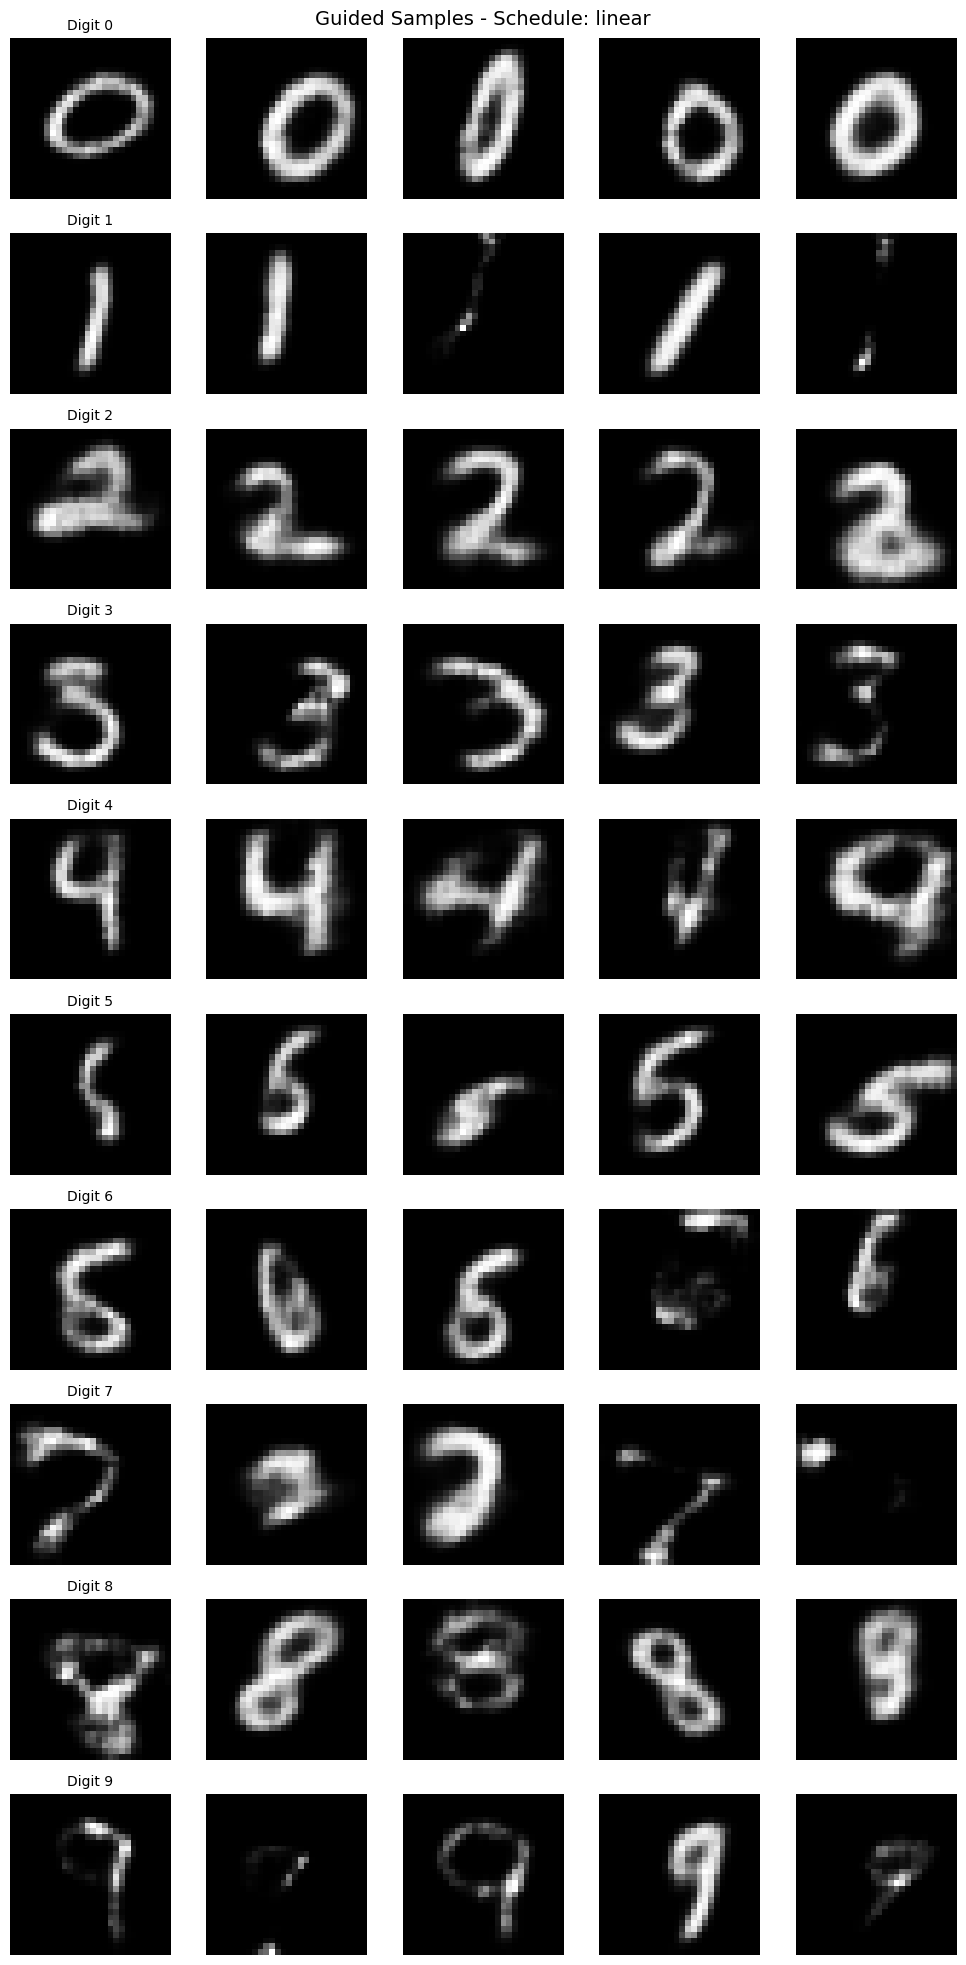

✅ Finished: linear


In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm

# === Define VAE Decoder-Only ===
class VAE_Decoder(nn.Module):
    def __init__(self, latent_dim=10):
        super().__init__()
        self.decoder_input = nn.Linear(latent_dim, 64 * 7 * 7)
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (64, 7, 7)),
            nn.ConvTranspose2d(64, 32, 4, 2, 1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 4, 2, 1), nn.Sigmoid()
        )

    def decode(self, z):
        z = self.decoder_input(z)
        return self.decoder(z)

# === Load Decoder ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vae_decoder = VAE_Decoder(latent_dim=10).to(device)
vae_decoder.load_state_dict(torch.load("conv_vae_with_classifier.pth"), strict=False)
vae_decoder.eval()

# === Schedules ===
# def linear_beta_schedule(T, beta_min=1e-4, beta_max=0.02):
#     return torch.linspace(beta_min, beta_max, T)

# def optimal_beta_schedule_sigma_ramp(T, sigma_0=1., sigma_1=1.):
#     t = torch.linspace(0, 1, T)
#     delta_sigma = sigma_1 - sigma_0
#     sigma_t = sigma_0 + t * delta_sigma
#     gamma_t = sigma_t ** 2
#     eta_t = delta_sigma / (sigma_t * T)
#     return gamma_t + eta_t / T

# schedules = {
#     'linear': linear_beta_schedule(10),
#     'cd_opt': optimal_beta_schedule_sigma_ramp(10)
# }

# === Dummy z_all, den_model definition for sampling ===
latent_dim = 10
z_all = torch.randn(200, latent_dim, device=device)  # Replace with real latent vectors

# === Dummy Classifier for grad_logp if needed ===
class DummyClassifier(nn.Module):
    def __init__(self, latent_dim, n_classes):
        super().__init__()
        self.linear = nn.Linear(latent_dim, n_classes)
    def forward(self, z): return self.linear(z)

z_classifier = DummyClassifier(latent_dim, 10).to(device)

# === Test All Schedules ===
for schedule_name, betas in schedules.items():
    print(f"🧪 Testing schedule: {schedule_name}")
    T = len(betas)
    alphas = 1. - betas
    alphas_bar = torch.cumprod(alphas, dim=0)

    # Dummy conditional denoiser (load your actual trained model for this schedule)
    class ConditionalDenoiser(nn.Module):
        def __init__(self, latent_dim=10, n_classes=10):
            super().__init__()
            self.embed_class = nn.Embedding(n_classes, 64)
            self.embed_time = nn.Sequential(
                nn.Linear(1, 64), nn.GELU(),
                nn.Linear(64, 64)
            )
            self.net = nn.Sequential(
                nn.Linear(latent_dim + 128, 512), nn.GELU(),
                nn.Linear(512, 512), nn.GELU(),
                nn.Linear(512, 512), nn.GELU(),
                nn.Linear(512, latent_dim)
            )
        def forward(self, zt, t, y):
            t_embed = self.embed_time(t.float().unsqueeze(1) / T)
            y_embed = self.embed_class(y)
            cond = torch.cat([t_embed, y_embed], dim=1)
            return self.net(torch.cat([zt, cond], dim=1))

    den_model = ConditionalDenoiser().to(device)
    den_model.load_state_dict(torch.load(f"best_denoiser_{schedule_name}.pth"))
    den_model.eval()

    # === Guided Sample Function ===
    @torch.no_grad()
    def sample_guided(y_label, guidance_scale=1.0, n=20):
        zt = torch.randn(n, latent_dim, device=device)
        y_tensor = torch.full((n,), y_label, dtype=torch.long, device=device)

        for t in reversed(range(T)):
            t_tensor = torch.full((n,), t, dtype=torch.long, device=device)
            guided_eps = den_model(zt, t_tensor, y_tensor)
            alpha_t, beta_t = alphas[t], betas[t]
            zt = (1 / torch.sqrt(alpha_t)) * (zt - beta_t / torch.sqrt(1 - alphas_bar[t]) * guided_eps)
            if t > 0:
                zt += torch.randn_like(zt) * torch.sqrt(beta_t)
        return zt.detach()

    # === Decode and Visualize Samples ===
    def decode_guided_samples(model, n_per_class=5):
        model.eval()
        fig, axs = plt.subplots(10, n_per_class, figsize=(n_per_class * 2, 20))
        for digit in range(10):
            z_sample = sample_guided(y_label=digit, n=n_per_class)
            x_gen = model.decode(z_sample).cpu().detach()
            for i in range(n_per_class):
                axs[digit, i].imshow(x_gen[i, 0].numpy(), cmap="gray")
                axs[digit, i].axis("off")
                if i == 0:
                    axs[digit, i].set_title(f"Digit {digit}", fontsize=10)
        plt.suptitle(f"Guided Samples - Schedule: {schedule_name}", fontsize=14)
        plt.tight_layout()
        plt.savefig(f"guided_diffusion_decoded_{schedule_name}.png", dpi=300)
        plt.show()

    decode_guided_samples(vae_decoder, n_per_class=5)
    print(f"✅ Finished: {schedule_name}")


(NO MCMC) STOCHASTIC FLOW POSTERIOR — SINGLE SOFTMAX
True label: 9
MAP label:  9
Posterior:  [3.1624557e-04 8.6888770e-07 3.2434076e-05 2.6540780e-05 9.3847271e-03
 1.1397257e-04 4.1360407e-05 3.8229224e-05 3.5275724e-03 9.8651797e-01]


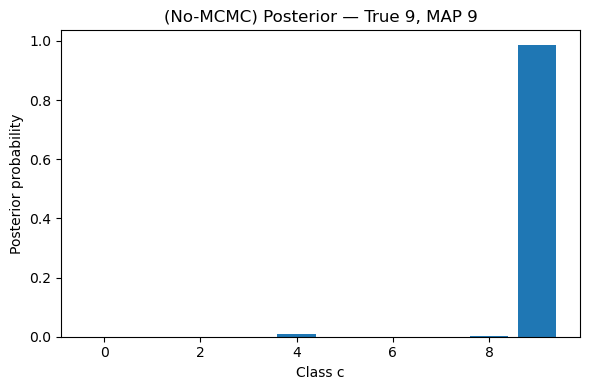

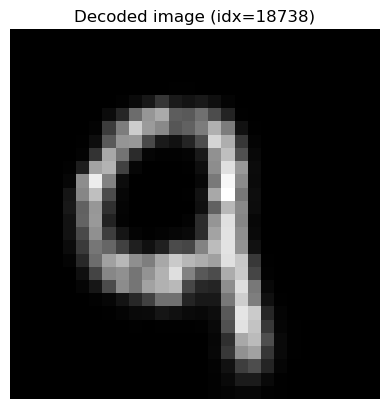

True label: 5
MAP label:  5
Posterior:  [8.7190350e-04 3.4400891e-03 1.0170896e-04 2.8259981e-02 4.5274002e-03
 8.9684093e-01 1.1085528e-02 2.2868939e-04 5.0792368e-03 4.9564525e-02]


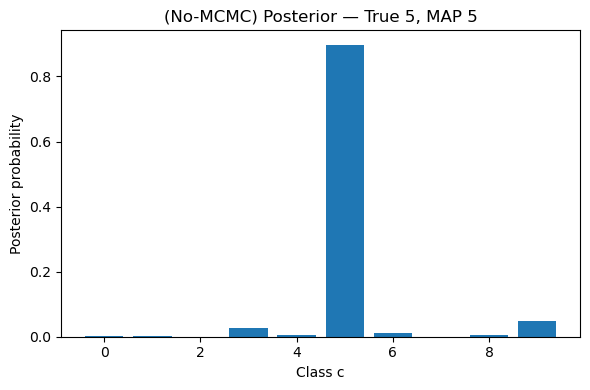

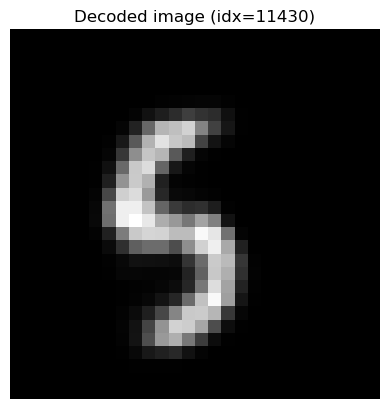

True label: 9
MAP label:  9
Posterior:  [4.3988205e-04 3.6896244e-04 6.0110068e-04 5.2863121e-04 2.3478752e-02
 2.2109294e-04 1.0016549e-04 2.0587551e-03 5.1044006e-02 9.2115879e-01]


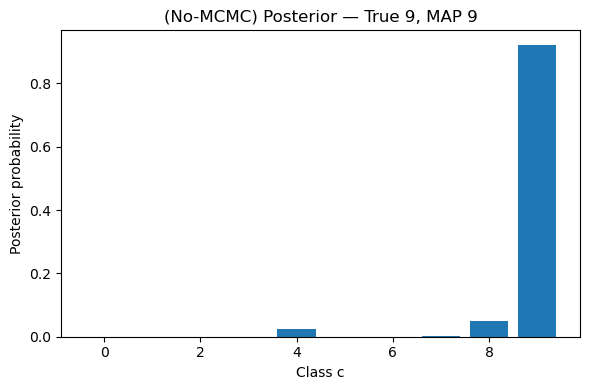

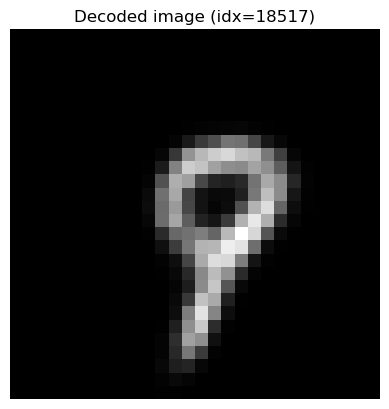

True label: 5
MAP label:  5
Posterior:  [0.01028956 0.00522698 0.0079653  0.35682762 0.00806722 0.45289484
 0.00148745 0.01262286 0.04053671 0.1040815 ]


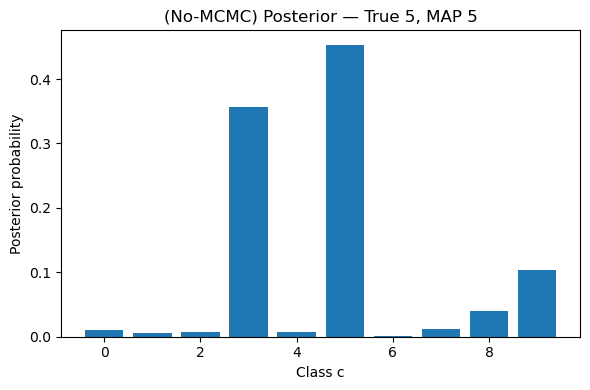

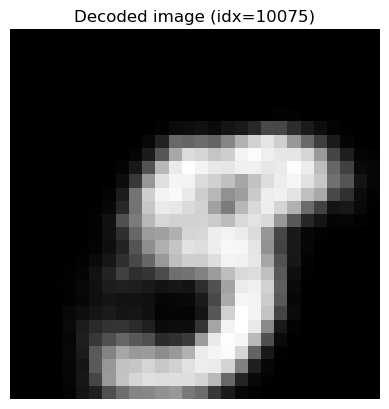

True label: 1
MAP label:  1
Posterior:  [1.3362679e-04 9.9927932e-01 1.5899288e-05 7.8003904e-05 6.3417938e-05
 4.6166977e-05 2.5687756e-05 9.3538110e-05 3.1167197e-05 2.3315844e-04]


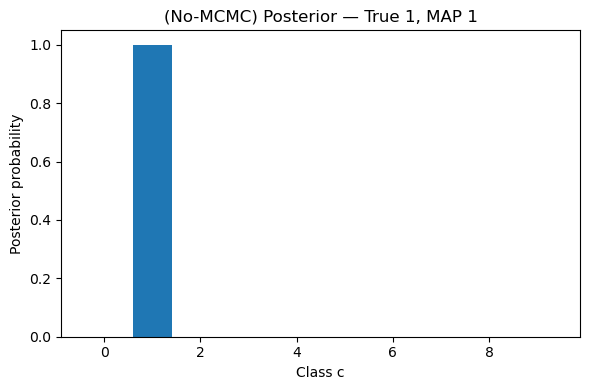

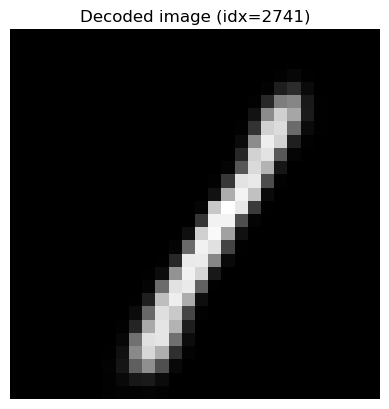

In [40]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# === Config ===
T = 1000
betas = torch.linspace(1e-4, 0.02, T)  # linear schedule
latent_dim = 10
n_classes = 10

# === Models (must match training) ===
class ConditionalDenoiser(nn.Module):
    def __init__(self, latent_dim=10, n_classes=10, T=1000):
        super().__init__()
        self.embed_class = nn.Embedding(n_classes, 64)
        self.embed_time = nn.Sequential(
            nn.Linear(1, 64), nn.GELU(),
            nn.Linear(64, 64)
        )
        self.net = nn.Sequential(
            nn.Linear(latent_dim + 128, 512), nn.GELU(),
            nn.Linear(512, 512), nn.GELU(),
            nn.Linear(512, 512), nn.GELU(),
            nn.Linear(512, latent_dim)
        )
        self.T = T

    def forward(self, zt, t, y):
        t_embed = self.embed_time(t.float().unsqueeze(1) / self.T)
        y_embed = self.embed_class(y)
        cond = torch.cat([t_embed, y_embed], dim=1)
        return self.net(torch.cat([zt, cond], dim=1))


class VAE_Decoder(nn.Module):
    def __init__(self, latent_dim=10):
        super().__init__()
        self.decoder_input = nn.Linear(latent_dim, 64 * 7 * 7)
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (64, 7, 7)),
            nn.ConvTranspose2d(64, 32, 4, 2, 1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 4, 2, 1), nn.Sigmoid()
        )

    def decode(self, z):
        z = self.decoder_input(z)
        return self.decoder(z)


# =========================================================
#  NO–MCMC POSTERIOR  (single likelihood per class + softmax)
# =========================================================
@torch.no_grad()
def posterior_latent_no_mcmc(z0_obs, den_model, betas, T,
                             n_classes=10, n_paths=64, device=None):
    """
    SAME path-integral likelihood computation.
    NO MH sampling.
    Just compute LL[c] for all classes and softmax them.
    """
    if device is None:
        device = z0_obs.device

    z0_obs = z0_obs.to(device)
    betas = betas.to(device)

    alphas = 1. - betas
    alphas_bar = torch.cumprod(alphas, dim=0)

    # build forward path z_0,...z_T
    D = z0_obs.shape[0]
    eps = torch.randn(n_paths, D, device=device)
    z_path = []
    z_path.append(z0_obs.unsqueeze(0).expand(n_paths, -1))

    for t in range(1, T+1):
        eps = torch.randn(n_paths, D, device=device)
        z_prev = z_path[-1]
        zt = (torch.sqrt(alphas[t-1]) * z_prev +
              torch.sqrt(1 - alphas[t-1]) * eps)
        z_path.append(zt)

    z_path = torch.stack(z_path, dim=1)   # [n_paths, T+1, D]

    # ---- likelihood function (same as before) ----
    def loglik_c(c_idx: int) -> float:
        y = torch.full((n_paths,), c_idx, dtype=torch.long, device=device)
        ll = 0.0
        for t in range(T):
            zt = z_path[:, t, :]
            zt1 = z_path[:, t+1, :]
            dz = zt1 - zt
            t_vec = torch.full((n_paths,), t+1, dtype=torch.long, device=device)
            beta_t = betas[t]

            score = den_model(zt1, t_vec, y)  # (n_paths, D)

            # path integral
            ll += (score * dz).sum(dim=1)

            # FP correction
            ll += 0.5 * beta_t * (-(score**2).sum(dim=1)
                                  + (zt1 * score).sum(dim=1))

        return ll.mean().item()

    # =====================================================
    # Compute likelihood for ALL classes once
    # =====================================================
    ll_all = torch.tensor([loglik_c(c) for c in range(n_classes)],
                          device=device)

    # =====================================================
    # *** Simple softmax posterior ***
    # =====================================================
    posterior = torch.softmax(ll_all, dim=0)

    return posterior


# =========================================================
# Load models and evaluate
# =========================================================
device = z_sampled.device

den_model = ConditionalDenoiser(latent_dim=latent_dim,
                                n_classes=n_classes,
                                T=T).to(device)
den_model.load_state_dict(torch.load("best_denoiser_linear.pth",
                                     map_location=device))
den_model.eval()

vae_decoder = VAE_Decoder(latent_dim=latent_dim).to(device)
vae_decoder.load_state_dict(torch.load("conv_vae_with_classifier.pth",
                                       map_location=device),
                            strict=False)
vae_decoder.eval()


print("(NO MCMC) STOCHASTIC FLOW POSTERIOR — SINGLE SOFTMAX")
for __ in range(5):

    idx = np.random.choice(np.arange(len(z_sampled)))
    z0_obs = z_sampled[idx].to(device)
    true_label = int(y_sampled[idx].item())

    posterior = posterior_latent_no_mcmc(
        z0_obs, den_model, betas, T,
        n_classes=n_classes, n_paths=100, device=device
    )

    map_label = int(torch.argmax(posterior).item())

    print(f"True label: {true_label}")
    print(f"MAP label:  {map_label}")
    print(f"Posterior:  {posterior.cpu().numpy()}")

    # plot posterior
    plt.figure(figsize=(6,4))
    plt.bar(range(n_classes), posterior.cpu().numpy())
    plt.xlabel("Class c")
    plt.ylabel("Posterior probability")
    plt.title(f"(No-MCMC) Posterior — True {true_label}, MAP {map_label}")
    plt.tight_layout()
    plt.show()

    # decode and show the chosen latent
    decoded = vae_decoder.decode(z0_obs.unsqueeze(0)).detach().cpu()[0,0].numpy()
    plt.imshow(decoded, cmap="gray")
    plt.title(f"Decoded image (idx={idx})")
    plt.axis("off")
    plt.show()


In [43]:
# =========================================================
# RUN ONE EXAMPLE PER DIGIT (0..9)
# =========================================================
print("\n(Evaluating 1 example per MNIST digit with SEM posterior)\n")

for digit in range(10):

    # pick a random latent belonging to this digit
    idxs = torch.where(y_sampled == digit)[0].cpu().numpy()
    if len(idxs) == 0:
        print(f"[warning] No samples for digit {digit}")
        continue

    idx = np.random.choice(idxs)
    z0_obs = z_sampled[idx].to(device)
    true_label = int(y_sampled[idx].item())

    print(f"Digit {digit} → using sample idx={idx}")

    # =====================================================
    # Compute posterior (mean + SEM)
    # =====================================================
    post_mean, post_sem = posterior_two_paths(
        z0_obs, den_model, betas, T,
        n_classes=n_classes, n_paths=64
    )

    map_label = int(np.argmax(post_mean))
    print(f"   True={true_label}, MAP={map_label}")

    # =====================================================
    # 1. SAVE POSTERIOR WITH ERROR BARS
    # =====================================================
    plt.figure(figsize=(6,4))
    plt.bar(
        np.arange(n_classes), post_mean,
        yerr=post_sem, capsize=4,
        alpha=0.75, color="gray"
    )
    plt.title(f"Digit {digit} — Posterior (2 trajectories, SEM)\nTrue={true_label}, MAP={map_label}")
    plt.xlabel("Class")
    plt.ylabel("Probability")
    plt.tight_layout()
    plt.savefig(f"digit{digit}_posterior.svg")
    plt.close()

    # =====================================================
    # 2. DECODE THE IMAGE AND SAVE IT
    # =====================================================
    decoded = vae_decoder.decode(z0_obs.unsqueeze(0)).detach().cpu()[0,0].numpy()

    plt.figure(figsize=(3,3))
    plt.imshow(decoded, cmap="gray")
    plt.title(f"Decoded Digit {digit}\n(idx={idx})")
    plt.axis("off")
    plt.tight_layout()
    plt.savefig(f"digit{digit}_decoded.svg")
    plt.close()

print("\n✅ Completed generating posterior + decoded image for each digit 0–9.")



(Evaluating 1 example per MNIST digit with SEM posterior)

Digit 0 → using sample idx=1947
   True=0, MAP=0
Digit 1 → using sample idx=3947
   True=1, MAP=1
Digit 2 → using sample idx=5947
   True=2, MAP=2
Digit 3 → using sample idx=7947
   True=3, MAP=3
Digit 4 → using sample idx=9947
   True=4, MAP=4
Digit 5 → using sample idx=11947
   True=5, MAP=5
Digit 6 → using sample idx=13947
   True=6, MAP=6
Digit 7 → using sample idx=15947
   True=7, MAP=2
Digit 8 → using sample idx=17947
   True=8, MAP=8
Digit 9 → using sample idx=19947
   True=9, MAP=9

✅ Completed generating posterior + decoded image for each digit 0–9.


In [21]:
# =========================================================
# FULL SCRIPT: Latent Diffusion Posterior + Evaluation
# =========================================================
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import math
from tqdm import tqdm
from sklearn.metrics import accuracy_score, roc_auc_score
import matplotlib.pyplot as plt


# =========================================================
# Parameters
# =========================================================
T_train = 1000
T_eval  = 300
betas = torch.linspace(1e-4, 0.02, T_train)
latent_dim = 10
n_classes = 10
samples_per_class = 200
n_paths = 8
device = "cpu"


# =========================================================
# Model definitions (matches your checkpoint)
# =========================================================
class ConditionalDenoiser(nn.Module):
    def __init__(self, latent_dim=10, n_classes=10, T=1000):
        super().__init__()
        self.embed_class = nn.Embedding(n_classes, 64)
        self.embed_time = nn.Sequential(
            nn.Linear(1, 64), nn.GELU(),
            nn.Linear(64, 64)
        )
        self.net = nn.Sequential(
            nn.Linear(latent_dim + 128, 512), nn.GELU(),
            nn.Linear(512, 512), nn.GELU(),
            nn.Linear(512, 512), nn.GELU(),
            nn.Linear(512, latent_dim)
        )
        self.T = T

    def forward(self, zt, t, y):
        t_emb = self.embed_time(t.float().unsqueeze(1) / self.T)
        y_emb = self.embed_class(y)
        return self.net(torch.cat([zt, t_emb, y_emb], dim=1))


class VAE_Decoder(nn.Module):
    def __init__(self, latent_dim=10, n_classes=10):
        super().__init__()
        self.decoder_input = nn.Linear(latent_dim, 64 * 7 * 7)
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (64, 7, 7)),
            nn.ConvTranspose2d(64, 32, 4, 2, 1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 4, 2, 1), nn.Sigmoid()
        )
        self.classifier = nn.Linear(latent_dim, n_classes)

    def classify(self, z):
        return self.classifier(z)


# =========================================================
# Diffusion Posterior (CIFAR-style averaging)
# =========================================================
@torch.no_grad()
def diffusion_posterior_latent(
    z0_obs, den_model, betas, T_train,
    y_classes, n_paths=8, T_eval=300, device="cpu"
):
    z0_obs = z0_obs.to(device)
    betas = betas.to(device)
    B, D = z0_obs.shape
    C = len(y_classes)

    assert n_paths % 2 == 0
    step_ids = torch.linspace(1, T_train, T_eval, dtype=torch.long, device=device)
    betas_sub = betas[step_ids - 1]
    alphas_sub = 1 - betas_sub

    half = n_paths // 2
    eps_base = torch.randn(B, half, T_eval, D, device=device)
    eps = torch.cat([eps_base, -eps_base], 1)

    L_all = torch.zeros(B, n_paths, C, device=device)

    for c_idx, c in enumerate(y_classes):
        y = torch.full((B,), int(c), device=device, dtype=torch.long)
        zt = z0_obs.unsqueeze(1).repeat(1, n_paths, 1)
        y_expand = y.unsqueeze(1).repeat(1, n_paths)
        ll_acc = torch.zeros(B, n_paths, device=device)

        for i in range(T_eval):
            t_idx = step_ids[i]
            beta_t = betas_sub[i]
            alpha_t = alphas_sub[i]

            noise = eps[:, :, i, :]
            zt1 = torch.sqrt(alpha_t) * zt + torch.sqrt(1 - alpha_t) * noise
            dz = zt1 - zt

            zt1_flat = zt1.reshape(B * n_paths, D)
            y_flat = y_expand.reshape(B * n_paths)
            t_vec = torch.full((B * n_paths,), t_idx, dtype=torch.long, device=device)

            score = den_model(zt1_flat, t_vec, y_flat)
            ll_i = (score * dz.reshape(B * n_paths, D)).sum(1)
            ll_i += 0.5 * beta_t * (-(score**2).sum(1) + (zt1_flat * score).sum(1))

            ll_acc += ll_i.view(B, n_paths)
            zt = zt1.detach()

        L_all[:, :, c_idx] = ll_acc

    probs = torch.softmax(L_all, dim=2)
    return probs.mean(1), probs.std(1) / math.sqrt(n_paths)


# =========================================================
# Load trained models
# =========================================================
den_model = ConditionalDenoiser(latent_dim, n_classes, T_train).to(device)
den_model.load_state_dict(torch.load("best_denoiser_linear.pth", map_location=device))
den_model.eval()

vae_model = VAE_Decoder(latent_dim, n_classes).to(device)
vae_model.load_state_dict(torch.load("conv_vae_with_classifier.pth", map_location=device), strict=False)
vae_model.eval()


# =========================================================
# Sample 200 per class
# =========================================================
indices = []
for c in range(n_classes):
    idx = np.where(y_sampled == c)[0]
    chosen = np.random.choice(idx, size=min(samples_per_class, len(idx)), replace=False)
    indices.extend(chosen)

indices = np.array(indices)
np.random.shuffle(indices)
z_subset = z_sampled[indices].cpu()
y_subset = y_sampled[indices].cpu().numpy()

print(f"[info] Using {len(z_subset)} samples ({samples_per_class} per class)")


# =========================================================
# Evaluate with Running Accuracy
# =========================================================
post_flow_all = []
post_vae_all = []
true_all = []

y_classes = torch.arange(n_classes, device=device)

print("\n=== Evaluating Diffusion Posterior (with running accuracy) ===\n")

with torch.no_grad():
    correct_flow = 0      # <<< NEW
    correct_vae  = 0      # <<< NEW

    for i in tqdm(range(len(z_subset)), desc="Evaluating"):
        z0 = z_subset[i:i+1].to(device)
        y_true = y_subset[i]

        # diffusion posterior
        mean_probs, _ = diffusion_posterior_latent(
            z0, den_model, betas,
            T_train=T_train,
            y_classes=y_classes,
            n_paths=n_paths,
            T_eval=T_eval,
            device=device
        )
        post_flow = mean_probs[0].cpu().numpy()
        post_flow_all.append(post_flow)

        # VAE classifier
        logits = vae_model.classify(z0)
        post_vae = torch.softmax(logits, 1)[0].cpu().numpy()
        post_vae_all.append(post_vae)

        post_flow_pred = np.argmax(post_flow)
        post_vae_pred  = np.argmax(post_vae)

        true_all.append(y_true)

        # update running accuracy -------------------------
        correct_flow += (post_flow_pred == y_true)   # <<< NEW
        correct_vae  += (post_vae_pred == y_true)    # <<< NEW

        tqdm.write(
            f"i={i:4d} | Flow Acc={correct_flow/(i+1):.4f} | "
            f"VAE Acc={correct_vae/(i+1):.4f}"
        )                                            # <<< NEW


post_flow_all = np.array(post_flow_all)
post_vae_all = np.array(post_vae_all)
true_all = np.array(true_all)


# =========================================================
# Final Accuracy + ROC AUC
# =========================================================
pred_flow = np.argmax(post_flow_all, 1)
pred_vae  = np.argmax(post_vae_all, 1)

acc_flow = accuracy_score(true_all, pred_flow)
acc_vae  = accuracy_score(true_all, pred_vae)

print("\n=== FINAL ACCURACY ===")
print(f"Flow posterior   : {acc_flow:.4f}")
print(f"VAE classifier   : {acc_vae:.4f}")

y_onehot = np.eye(n_classes)[true_all]

auc_flow_macro = roc_auc_score(y_onehot, post_flow_all, multi_class="ovr", average="macro")
auc_flow_micro = roc_auc_score(y_onehot, post_flow_all, multi_class="ovr", average="micro")

auc_vae_macro = roc_auc_score(y_onehot, post_vae_all,  multi_class="ovr", average="macro")
auc_vae_micro = roc_auc_score(y_onehot, post_vae_all,  multi_class="ovr", average="micro")

print("\n=== ROC–AUC ===")
print(f"Flow macro-AUC: {auc_flow_macro:.4f}")
print(f"Flow micro-AUC: {auc_flow_micro:.4f}")
print(f"VAE  macro-AUC: {auc_vae_macro:.4f}")
print(f"VAE  micro-AUC: {auc_vae_micro:.4f}")


[info] Using 2000 samples (200 per class)

=== Evaluating Diffusion Posterior (with running accuracy) ===



Evaluating:   0%|                              | 1/2000 [00:00<14:00,  2.38it/s]

i=   0 | Flow Acc=1.0000 | VAE Acc=1.0000


Evaluating:   0%|                              | 2/2000 [00:00<13:24,  2.48it/s]

i=   1 | Flow Acc=1.0000 | VAE Acc=1.0000


Evaluating:   0%|                              | 3/2000 [00:01<13:09,  2.53it/s]

i=   2 | Flow Acc=1.0000 | VAE Acc=1.0000


Evaluating:   0%|                              | 4/2000 [00:01<13:42,  2.43it/s]

i=   3 | Flow Acc=1.0000 | VAE Acc=1.0000


Evaluating:   0%|                              | 5/2000 [00:02<13:41,  2.43it/s]

i=   4 | Flow Acc=1.0000 | VAE Acc=1.0000


Evaluating:   0%|                              | 6/2000 [00:02<13:26,  2.47it/s]

i=   5 | Flow Acc=1.0000 | VAE Acc=1.0000


Evaluating:   0%|                              | 7/2000 [00:02<13:12,  2.51it/s]

i=   6 | Flow Acc=1.0000 | VAE Acc=1.0000


Evaluating:   0%|                              | 8/2000 [00:03<13:57,  2.38it/s]

i=   7 | Flow Acc=1.0000 | VAE Acc=1.0000


Evaluating:   0%|▏                             | 9/2000 [00:03<14:28,  2.29it/s]

i=   8 | Flow Acc=1.0000 | VAE Acc=1.0000


Evaluating:   0%|▏                            | 10/2000 [00:04<14:21,  2.31it/s]

i=   9 | Flow Acc=1.0000 | VAE Acc=1.0000


Evaluating:   1%|▏                            | 11/2000 [00:04<14:14,  2.33it/s]

i=  10 | Flow Acc=1.0000 | VAE Acc=1.0000


Evaluating:   1%|▏                            | 12/2000 [00:05<14:11,  2.33it/s]

i=  11 | Flow Acc=1.0000 | VAE Acc=1.0000


Evaluating:   1%|▏                            | 13/2000 [00:05<13:45,  2.41it/s]

i=  12 | Flow Acc=1.0000 | VAE Acc=1.0000


Evaluating:   1%|▏                            | 14/2000 [00:05<13:53,  2.38it/s]

i=  13 | Flow Acc=1.0000 | VAE Acc=1.0000


Evaluating:   1%|▏                            | 15/2000 [00:06<13:56,  2.37it/s]

i=  14 | Flow Acc=1.0000 | VAE Acc=1.0000


Evaluating:   1%|▏                            | 16/2000 [00:06<13:58,  2.37it/s]

i=  15 | Flow Acc=1.0000 | VAE Acc=1.0000


Evaluating:   1%|▏                            | 17/2000 [00:07<13:36,  2.43it/s]

i=  16 | Flow Acc=1.0000 | VAE Acc=1.0000


Evaluating:   1%|▎                            | 18/2000 [00:07<13:42,  2.41it/s]

i=  17 | Flow Acc=1.0000 | VAE Acc=1.0000


Evaluating:   1%|▎                            | 19/2000 [00:07<13:25,  2.46it/s]

i=  18 | Flow Acc=1.0000 | VAE Acc=1.0000


Evaluating:   1%|▎                            | 20/2000 [00:08<13:36,  2.43it/s]

i=  19 | Flow Acc=1.0000 | VAE Acc=1.0000


Evaluating:   1%|▎                            | 21/2000 [00:08<13:19,  2.47it/s]

i=  20 | Flow Acc=1.0000 | VAE Acc=1.0000


Evaluating:   1%|▎                            | 22/2000 [00:09<13:30,  2.44it/s]

i=  21 | Flow Acc=1.0000 | VAE Acc=1.0000


Evaluating:   1%|▎                            | 23/2000 [00:09<13:17,  2.48it/s]

i=  22 | Flow Acc=0.9565 | VAE Acc=0.9565


Evaluating:   1%|▎                            | 24/2000 [00:09<13:07,  2.51it/s]

i=  23 | Flow Acc=0.9583 | VAE Acc=0.9583


Evaluating:   1%|▎                            | 25/2000 [00:10<13:30,  2.44it/s]

i=  24 | Flow Acc=0.9600 | VAE Acc=0.9600


Evaluating:   1%|▍                            | 26/2000 [00:10<13:16,  2.48it/s]

i=  25 | Flow Acc=0.9615 | VAE Acc=0.9615


Evaluating:   1%|▍                            | 27/2000 [00:11<13:23,  2.46it/s]

i=  26 | Flow Acc=0.9630 | VAE Acc=0.9630


Evaluating:   1%|▍                            | 28/2000 [00:11<13:38,  2.41it/s]

i=  27 | Flow Acc=0.9643 | VAE Acc=0.9643


Evaluating:   1%|▍                            | 29/2000 [00:12<13:40,  2.40it/s]

i=  28 | Flow Acc=0.9655 | VAE Acc=0.9655


Evaluating:   2%|▍                            | 30/2000 [00:12<13:20,  2.46it/s]

i=  29 | Flow Acc=0.9667 | VAE Acc=0.9333


Evaluating:   2%|▍                            | 31/2000 [00:12<13:53,  2.36it/s]

i=  30 | Flow Acc=0.9677 | VAE Acc=0.9355


Evaluating:   2%|▍                            | 32/2000 [00:13<13:31,  2.42it/s]

i=  31 | Flow Acc=0.9688 | VAE Acc=0.9375


Evaluating:   2%|▍                            | 33/2000 [00:13<13:37,  2.41it/s]

i=  32 | Flow Acc=0.9394 | VAE Acc=0.9091


Evaluating:   2%|▍                            | 34/2000 [00:14<13:19,  2.46it/s]

i=  33 | Flow Acc=0.9412 | VAE Acc=0.9118


Evaluating:   2%|▌                            | 35/2000 [00:14<13:06,  2.50it/s]

i=  34 | Flow Acc=0.9429 | VAE Acc=0.9143


Evaluating:   2%|▌                            | 36/2000 [00:14<12:58,  2.52it/s]

i=  35 | Flow Acc=0.9444 | VAE Acc=0.9167


Evaluating:   2%|▌                            | 37/2000 [00:15<12:50,  2.55it/s]

i=  36 | Flow Acc=0.9459 | VAE Acc=0.9189


Evaluating:   2%|▌                            | 38/2000 [00:15<12:45,  2.56it/s]

i=  37 | Flow Acc=0.9474 | VAE Acc=0.9211


Evaluating:   2%|▌                            | 39/2000 [00:15<12:41,  2.58it/s]

i=  38 | Flow Acc=0.9487 | VAE Acc=0.9231


Evaluating:   2%|▌                            | 40/2000 [00:16<12:38,  2.58it/s]

i=  39 | Flow Acc=0.9250 | VAE Acc=0.9000


Evaluating:   2%|▌                            | 41/2000 [00:16<12:36,  2.59it/s]

i=  40 | Flow Acc=0.9268 | VAE Acc=0.9024


Evaluating:   2%|▌                            | 42/2000 [00:17<12:35,  2.59it/s]

i=  41 | Flow Acc=0.9286 | VAE Acc=0.9048


Evaluating:   2%|▌                            | 43/2000 [00:17<12:34,  2.59it/s]

i=  42 | Flow Acc=0.9302 | VAE Acc=0.9070


Evaluating:   2%|▋                            | 44/2000 [00:17<12:55,  2.52it/s]

i=  43 | Flow Acc=0.9318 | VAE Acc=0.9091


Evaluating:   2%|▋                            | 45/2000 [00:18<12:48,  2.54it/s]

i=  44 | Flow Acc=0.9333 | VAE Acc=0.9111


Evaluating:   2%|▋                            | 46/2000 [00:18<13:09,  2.47it/s]

i=  45 | Flow Acc=0.9348 | VAE Acc=0.9130


Evaluating:   2%|▋                            | 47/2000 [00:19<13:29,  2.41it/s]

i=  46 | Flow Acc=0.9362 | VAE Acc=0.8936


Evaluating:   2%|▋                            | 48/2000 [00:19<13:13,  2.46it/s]

i=  47 | Flow Acc=0.9375 | VAE Acc=0.8958


Evaluating:   2%|▋                            | 49/2000 [00:19<13:00,  2.50it/s]

i=  48 | Flow Acc=0.9388 | VAE Acc=0.8980


Evaluating:   2%|▋                            | 50/2000 [00:20<13:16,  2.45it/s]

i=  49 | Flow Acc=0.9400 | VAE Acc=0.9000


Evaluating:   3%|▋                            | 51/2000 [00:20<13:02,  2.49it/s]

i=  50 | Flow Acc=0.9412 | VAE Acc=0.9020


Evaluating:   3%|▊                            | 52/2000 [00:21<12:52,  2.52it/s]

i=  51 | Flow Acc=0.9423 | VAE Acc=0.9038


Evaluating:   3%|▊                            | 53/2000 [00:21<12:45,  2.54it/s]

i=  52 | Flow Acc=0.9245 | VAE Acc=0.9057


Evaluating:   3%|▊                            | 54/2000 [00:21<12:59,  2.50it/s]

i=  53 | Flow Acc=0.9259 | VAE Acc=0.9074


Evaluating:   3%|▊                            | 55/2000 [00:22<12:51,  2.52it/s]

i=  54 | Flow Acc=0.9273 | VAE Acc=0.9091


Evaluating:   3%|▊                            | 56/2000 [00:22<12:44,  2.54it/s]

i=  55 | Flow Acc=0.9286 | VAE Acc=0.9107


Evaluating:   3%|▊                            | 57/2000 [00:23<12:59,  2.49it/s]

i=  56 | Flow Acc=0.9298 | VAE Acc=0.9123


Evaluating:   3%|▊                            | 58/2000 [00:23<13:11,  2.45it/s]

i=  57 | Flow Acc=0.9310 | VAE Acc=0.9138


Evaluating:   3%|▊                            | 59/2000 [00:23<12:59,  2.49it/s]

i=  58 | Flow Acc=0.9322 | VAE Acc=0.9153


Evaluating:   3%|▊                            | 60/2000 [00:24<13:11,  2.45it/s]

i=  59 | Flow Acc=0.9333 | VAE Acc=0.9167


Evaluating:   3%|▉                            | 61/2000 [00:24<12:57,  2.49it/s]

i=  60 | Flow Acc=0.9344 | VAE Acc=0.9180


Evaluating:   3%|▉                            | 62/2000 [00:25<13:12,  2.44it/s]

i=  61 | Flow Acc=0.9355 | VAE Acc=0.9194


Evaluating:   3%|▉                            | 63/2000 [00:25<12:59,  2.49it/s]

i=  62 | Flow Acc=0.9206 | VAE Acc=0.9048


Evaluating:   3%|▉                            | 64/2000 [00:25<12:49,  2.52it/s]

i=  63 | Flow Acc=0.9219 | VAE Acc=0.9062


Evaluating:   3%|▉                            | 65/2000 [00:26<12:41,  2.54it/s]

i=  64 | Flow Acc=0.9231 | VAE Acc=0.9077


Evaluating:   3%|▉                            | 66/2000 [00:26<12:36,  2.56it/s]

i=  65 | Flow Acc=0.9242 | VAE Acc=0.9091


Evaluating:   3%|▉                            | 67/2000 [00:27<12:31,  2.57it/s]

i=  66 | Flow Acc=0.9254 | VAE Acc=0.9104


Evaluating:   3%|▉                            | 68/2000 [00:27<12:40,  2.54it/s]

i=  67 | Flow Acc=0.9265 | VAE Acc=0.9118


Evaluating:   3%|█                            | 69/2000 [00:27<12:34,  2.56it/s]

i=  68 | Flow Acc=0.9275 | VAE Acc=0.9130


Evaluating:   4%|█                            | 70/2000 [00:28<12:30,  2.57it/s]

i=  69 | Flow Acc=0.9286 | VAE Acc=0.9143


Evaluating:   4%|█                            | 71/2000 [00:28<12:27,  2.58it/s]

i=  70 | Flow Acc=0.9296 | VAE Acc=0.9155


Evaluating:   4%|█                            | 72/2000 [00:29<12:25,  2.59it/s]

i=  71 | Flow Acc=0.9306 | VAE Acc=0.9167


Evaluating:   4%|█                            | 73/2000 [00:29<12:24,  2.59it/s]

i=  72 | Flow Acc=0.9315 | VAE Acc=0.9178


Evaluating:   4%|█                            | 74/2000 [00:29<12:24,  2.59it/s]

i=  73 | Flow Acc=0.9324 | VAE Acc=0.9189


Evaluating:   4%|█                            | 75/2000 [00:30<12:22,  2.59it/s]

i=  74 | Flow Acc=0.9333 | VAE Acc=0.9200


Evaluating:   4%|█                            | 76/2000 [00:30<12:21,  2.59it/s]

i=  75 | Flow Acc=0.9342 | VAE Acc=0.9211


Evaluating:   4%|█                            | 77/2000 [00:31<12:42,  2.52it/s]

i=  76 | Flow Acc=0.9351 | VAE Acc=0.9221


Evaluating:   4%|█▏                           | 78/2000 [00:31<12:35,  2.54it/s]

i=  77 | Flow Acc=0.9359 | VAE Acc=0.9231


Evaluating:   4%|█▏                           | 79/2000 [00:31<12:29,  2.56it/s]

i=  78 | Flow Acc=0.9367 | VAE Acc=0.9241


Evaluating:   4%|█▏                           | 80/2000 [00:32<12:48,  2.50it/s]

i=  79 | Flow Acc=0.9375 | VAE Acc=0.9250


Evaluating:   4%|█▏                           | 81/2000 [00:32<12:39,  2.53it/s]

i=  80 | Flow Acc=0.9383 | VAE Acc=0.9259


Evaluating:   4%|█▏                           | 82/2000 [00:32<12:34,  2.54it/s]

i=  81 | Flow Acc=0.9390 | VAE Acc=0.9268


Evaluating:   4%|█▏                           | 83/2000 [00:33<12:29,  2.56it/s]

i=  82 | Flow Acc=0.9398 | VAE Acc=0.9277


Evaluating:   4%|█▏                           | 84/2000 [00:33<12:52,  2.48it/s]

i=  83 | Flow Acc=0.9405 | VAE Acc=0.9286


Evaluating:   4%|█▏                           | 85/2000 [00:34<13:02,  2.45it/s]

i=  84 | Flow Acc=0.9412 | VAE Acc=0.9294


Evaluating:   4%|█▏                           | 86/2000 [00:34<13:08,  2.43it/s]

i=  85 | Flow Acc=0.9419 | VAE Acc=0.9302


Evaluating:   4%|█▎                           | 87/2000 [00:35<12:57,  2.46it/s]

i=  86 | Flow Acc=0.9310 | VAE Acc=0.9195


Evaluating:   4%|█▎                           | 88/2000 [00:35<13:34,  2.35it/s]

i=  87 | Flow Acc=0.9318 | VAE Acc=0.9205


Evaluating:   4%|█▎                           | 89/2000 [00:35<13:21,  2.38it/s]

i=  88 | Flow Acc=0.9326 | VAE Acc=0.9213


Evaluating:   4%|█▎                           | 90/2000 [00:36<13:23,  2.38it/s]

i=  89 | Flow Acc=0.9333 | VAE Acc=0.9222


Evaluating:   5%|█▎                           | 91/2000 [00:36<13:02,  2.44it/s]

i=  90 | Flow Acc=0.9341 | VAE Acc=0.9231


Evaluating:   5%|█▎                           | 92/2000 [00:37<12:47,  2.49it/s]

i=  91 | Flow Acc=0.9348 | VAE Acc=0.9239


Evaluating:   5%|█▎                           | 93/2000 [00:37<12:57,  2.45it/s]

i=  92 | Flow Acc=0.9355 | VAE Acc=0.9247


Evaluating:   5%|█▎                           | 94/2000 [00:37<12:44,  2.49it/s]

i=  93 | Flow Acc=0.9362 | VAE Acc=0.9255


Evaluating:   5%|█▍                           | 95/2000 [00:38<12:34,  2.52it/s]

i=  94 | Flow Acc=0.9368 | VAE Acc=0.9263


Evaluating:   5%|█▍                           | 96/2000 [00:38<12:36,  2.52it/s]

i=  95 | Flow Acc=0.9375 | VAE Acc=0.9271


Evaluating:   5%|█▍                           | 97/2000 [00:39<12:50,  2.47it/s]

i=  96 | Flow Acc=0.9381 | VAE Acc=0.9278


Evaluating:   5%|█▍                           | 98/2000 [00:39<13:02,  2.43it/s]

i=  97 | Flow Acc=0.9388 | VAE Acc=0.9286


Evaluating:   5%|█▍                           | 99/2000 [00:39<12:46,  2.48it/s]

i=  98 | Flow Acc=0.9394 | VAE Acc=0.9293


Evaluating:   5%|█▍                          | 100/2000 [00:40<12:59,  2.44it/s]

i=  99 | Flow Acc=0.9400 | VAE Acc=0.9300


Evaluating:   5%|█▍                          | 101/2000 [00:40<12:45,  2.48it/s]

i= 100 | Flow Acc=0.9406 | VAE Acc=0.9307


Evaluating:   5%|█▍                          | 102/2000 [00:41<12:35,  2.51it/s]

i= 101 | Flow Acc=0.9412 | VAE Acc=0.9314


Evaluating:   5%|█▍                          | 103/2000 [00:41<12:44,  2.48it/s]

i= 102 | Flow Acc=0.9417 | VAE Acc=0.9320


Evaluating:   5%|█▍                          | 104/2000 [00:41<12:33,  2.52it/s]

i= 103 | Flow Acc=0.9423 | VAE Acc=0.9327


Evaluating:   5%|█▍                          | 105/2000 [00:42<12:26,  2.54it/s]

i= 104 | Flow Acc=0.9429 | VAE Acc=0.9333


Evaluating:   5%|█▍                          | 106/2000 [00:42<12:20,  2.56it/s]

i= 105 | Flow Acc=0.9434 | VAE Acc=0.9340


Evaluating:   5%|█▍                          | 107/2000 [00:43<12:16,  2.57it/s]

i= 106 | Flow Acc=0.9439 | VAE Acc=0.9346


Evaluating:   5%|█▌                          | 108/2000 [00:43<12:14,  2.58it/s]

i= 107 | Flow Acc=0.9444 | VAE Acc=0.9352


Evaluating:   5%|█▌                          | 109/2000 [00:43<12:12,  2.58it/s]

i= 108 | Flow Acc=0.9450 | VAE Acc=0.9358


Evaluating:   6%|█▌                          | 110/2000 [00:44<12:11,  2.58it/s]

i= 109 | Flow Acc=0.9455 | VAE Acc=0.9364


Evaluating:   6%|█▌                          | 111/2000 [00:44<12:32,  2.51it/s]

i= 110 | Flow Acc=0.9459 | VAE Acc=0.9369


Evaluating:   6%|█▌                          | 112/2000 [00:45<12:24,  2.54it/s]

i= 111 | Flow Acc=0.9464 | VAE Acc=0.9375


Evaluating:   6%|█▌                          | 113/2000 [00:45<12:18,  2.55it/s]

i= 112 | Flow Acc=0.9469 | VAE Acc=0.9381


Evaluating:   6%|█▌                          | 114/2000 [00:45<12:35,  2.50it/s]

i= 113 | Flow Acc=0.9474 | VAE Acc=0.9386


Evaluating:   6%|█▌                          | 115/2000 [00:46<12:26,  2.52it/s]

i= 114 | Flow Acc=0.9478 | VAE Acc=0.9391


Evaluating:   6%|█▌                          | 116/2000 [00:46<12:19,  2.55it/s]

i= 115 | Flow Acc=0.9483 | VAE Acc=0.9397


Evaluating:   6%|█▋                          | 117/2000 [00:47<12:38,  2.48it/s]

i= 116 | Flow Acc=0.9487 | VAE Acc=0.9402


Evaluating:   6%|█▋                          | 118/2000 [00:47<12:29,  2.51it/s]

i= 117 | Flow Acc=0.9492 | VAE Acc=0.9407


Evaluating:   6%|█▋                          | 119/2000 [00:47<12:21,  2.54it/s]

i= 118 | Flow Acc=0.9496 | VAE Acc=0.9412


Evaluating:   6%|█▋                          | 120/2000 [00:48<12:16,  2.55it/s]

i= 119 | Flow Acc=0.9500 | VAE Acc=0.9417


Evaluating:   6%|█▋                          | 121/2000 [00:48<12:34,  2.49it/s]

i= 120 | Flow Acc=0.9504 | VAE Acc=0.9421


Evaluating:   6%|█▋                          | 122/2000 [00:49<12:49,  2.44it/s]

i= 121 | Flow Acc=0.9508 | VAE Acc=0.9426


Evaluating:   6%|█▋                          | 123/2000 [00:49<12:35,  2.48it/s]

i= 122 | Flow Acc=0.9512 | VAE Acc=0.9431


Evaluating:   6%|█▋                          | 124/2000 [00:49<12:26,  2.51it/s]

i= 123 | Flow Acc=0.9516 | VAE Acc=0.9435


Evaluating:   6%|█▊                          | 125/2000 [00:50<12:19,  2.54it/s]

i= 124 | Flow Acc=0.9520 | VAE Acc=0.9440


Evaluating:   6%|█▊                          | 126/2000 [00:50<13:05,  2.39it/s]

i= 125 | Flow Acc=0.9524 | VAE Acc=0.9444


Evaluating:   6%|█▊                          | 127/2000 [00:51<13:09,  2.37it/s]

i= 126 | Flow Acc=0.9528 | VAE Acc=0.9449


Evaluating:   6%|█▊                          | 128/2000 [00:51<12:49,  2.43it/s]

i= 127 | Flow Acc=0.9531 | VAE Acc=0.9453


Evaluating:   6%|█▊                          | 129/2000 [00:51<12:35,  2.48it/s]

i= 128 | Flow Acc=0.9535 | VAE Acc=0.9457


Evaluating:   6%|█▊                          | 130/2000 [00:52<12:24,  2.51it/s]

i= 129 | Flow Acc=0.9538 | VAE Acc=0.9462


Evaluating:   7%|█▊                          | 131/2000 [00:52<12:18,  2.53it/s]

i= 130 | Flow Acc=0.9542 | VAE Acc=0.9466


Evaluating:   7%|█▊                          | 132/2000 [00:53<12:36,  2.47it/s]

i= 131 | Flow Acc=0.9545 | VAE Acc=0.9470


Evaluating:   7%|█▊                          | 133/2000 [00:53<12:25,  2.50it/s]

i= 132 | Flow Acc=0.9549 | VAE Acc=0.9474


Evaluating:   7%|█▉                          | 134/2000 [00:53<12:33,  2.48it/s]

i= 133 | Flow Acc=0.9552 | VAE Acc=0.9478


Evaluating:   7%|█▉                          | 135/2000 [00:54<12:22,  2.51it/s]

i= 134 | Flow Acc=0.9556 | VAE Acc=0.9481


Evaluating:   7%|█▉                          | 136/2000 [00:54<12:14,  2.54it/s]

i= 135 | Flow Acc=0.9559 | VAE Acc=0.9485


Evaluating:   7%|█▉                          | 137/2000 [00:55<12:29,  2.49it/s]

i= 136 | Flow Acc=0.9562 | VAE Acc=0.9489


Evaluating:   7%|█▉                          | 138/2000 [00:55<12:19,  2.52it/s]

i= 137 | Flow Acc=0.9565 | VAE Acc=0.9493


Evaluating:   7%|█▉                          | 139/2000 [00:55<12:12,  2.54it/s]

i= 138 | Flow Acc=0.9568 | VAE Acc=0.9496


Evaluating:   7%|█▉                          | 140/2000 [00:56<12:32,  2.47it/s]

i= 139 | Flow Acc=0.9571 | VAE Acc=0.9500


Evaluating:   7%|█▉                          | 141/2000 [00:56<12:22,  2.50it/s]

i= 140 | Flow Acc=0.9574 | VAE Acc=0.9504


Evaluating:   7%|█▉                          | 142/2000 [00:57<12:15,  2.53it/s]

i= 141 | Flow Acc=0.9577 | VAE Acc=0.9507


Evaluating:   7%|██                          | 143/2000 [00:57<12:29,  2.48it/s]

i= 142 | Flow Acc=0.9580 | VAE Acc=0.9510


Evaluating:   7%|██                          | 144/2000 [00:57<13:01,  2.37it/s]

i= 143 | Flow Acc=0.9583 | VAE Acc=0.9514


Evaluating:   7%|██                          | 145/2000 [00:58<12:41,  2.44it/s]

i= 144 | Flow Acc=0.9586 | VAE Acc=0.9517


Evaluating:   7%|██                          | 146/2000 [00:58<12:27,  2.48it/s]

i= 145 | Flow Acc=0.9589 | VAE Acc=0.9521


Evaluating:   7%|██                          | 147/2000 [00:59<12:16,  2.51it/s]

i= 146 | Flow Acc=0.9524 | VAE Acc=0.9456


Evaluating:   7%|██                          | 148/2000 [00:59<12:09,  2.54it/s]

i= 147 | Flow Acc=0.9527 | VAE Acc=0.9459


Evaluating:   7%|██                          | 149/2000 [00:59<12:04,  2.56it/s]

i= 148 | Flow Acc=0.9530 | VAE Acc=0.9463


Evaluating:   8%|██                          | 150/2000 [01:00<12:00,  2.57it/s]

i= 149 | Flow Acc=0.9533 | VAE Acc=0.9467


Evaluating:   8%|██                          | 151/2000 [01:00<11:57,  2.58it/s]

i= 150 | Flow Acc=0.9536 | VAE Acc=0.9470


Evaluating:   8%|██▏                         | 152/2000 [01:01<11:55,  2.58it/s]

i= 151 | Flow Acc=0.9539 | VAE Acc=0.9474


Evaluating:   8%|██▏                         | 153/2000 [01:01<11:53,  2.59it/s]

i= 152 | Flow Acc=0.9542 | VAE Acc=0.9477


Evaluating:   8%|██▏                         | 154/2000 [01:01<11:52,  2.59it/s]

i= 153 | Flow Acc=0.9545 | VAE Acc=0.9481


Evaluating:   8%|██▏                         | 155/2000 [01:02<11:51,  2.59it/s]

i= 154 | Flow Acc=0.9548 | VAE Acc=0.9484


Evaluating:   8%|██▏                         | 156/2000 [01:02<11:49,  2.60it/s]

i= 155 | Flow Acc=0.9551 | VAE Acc=0.9487


Evaluating:   8%|██▏                         | 157/2000 [01:02<11:48,  2.60it/s]

i= 156 | Flow Acc=0.9554 | VAE Acc=0.9490


Evaluating:   8%|██▏                         | 158/2000 [01:03<12:08,  2.53it/s]

i= 157 | Flow Acc=0.9557 | VAE Acc=0.9494


Evaluating:   8%|██▏                         | 159/2000 [01:03<12:01,  2.55it/s]

i= 158 | Flow Acc=0.9560 | VAE Acc=0.9497


Evaluating:   8%|██▏                         | 160/2000 [01:04<12:20,  2.48it/s]

i= 159 | Flow Acc=0.9563 | VAE Acc=0.9500


Evaluating:   8%|██▎                         | 161/2000 [01:04<12:10,  2.52it/s]

i= 160 | Flow Acc=0.9565 | VAE Acc=0.9503


Evaluating:   8%|██▎                         | 162/2000 [01:04<12:03,  2.54it/s]

i= 161 | Flow Acc=0.9568 | VAE Acc=0.9506


Evaluating:   8%|██▎                         | 163/2000 [01:05<11:57,  2.56it/s]

i= 162 | Flow Acc=0.9571 | VAE Acc=0.9509


Evaluating:   8%|██▎                         | 164/2000 [01:05<11:53,  2.57it/s]

i= 163 | Flow Acc=0.9573 | VAE Acc=0.9512


Evaluating:   8%|██▎                         | 165/2000 [01:06<12:12,  2.51it/s]

i= 164 | Flow Acc=0.9576 | VAE Acc=0.9515


Evaluating:   8%|██▎                         | 166/2000 [01:06<12:03,  2.53it/s]

i= 165 | Flow Acc=0.9578 | VAE Acc=0.9518


Evaluating:   8%|██▎                         | 167/2000 [01:06<11:57,  2.55it/s]

i= 166 | Flow Acc=0.9581 | VAE Acc=0.9521


Evaluating:   8%|██▎                         | 168/2000 [01:07<11:53,  2.57it/s]

i= 167 | Flow Acc=0.9583 | VAE Acc=0.9524


Evaluating:   8%|██▎                         | 169/2000 [01:07<11:49,  2.58it/s]

i= 168 | Flow Acc=0.9586 | VAE Acc=0.9527


Evaluating:   8%|██▍                         | 170/2000 [01:08<12:08,  2.51it/s]

i= 169 | Flow Acc=0.9588 | VAE Acc=0.9529


Evaluating:   9%|██▍                         | 171/2000 [01:08<12:00,  2.54it/s]

i= 170 | Flow Acc=0.9591 | VAE Acc=0.9532


Evaluating:   9%|██▍                         | 172/2000 [01:08<12:21,  2.47it/s]

i= 171 | Flow Acc=0.9593 | VAE Acc=0.9535


Evaluating:   9%|██▍                         | 173/2000 [01:09<12:09,  2.50it/s]

i= 172 | Flow Acc=0.9595 | VAE Acc=0.9538


Evaluating:   9%|██▍                         | 174/2000 [01:09<12:01,  2.53it/s]

i= 173 | Flow Acc=0.9598 | VAE Acc=0.9540


Evaluating:   9%|██▍                         | 175/2000 [01:10<12:21,  2.46it/s]

i= 174 | Flow Acc=0.9600 | VAE Acc=0.9543


Evaluating:   9%|██▍                         | 176/2000 [01:10<12:45,  2.38it/s]

i= 175 | Flow Acc=0.9602 | VAE Acc=0.9545


Evaluating:   9%|██▍                         | 177/2000 [01:10<12:37,  2.41it/s]

i= 176 | Flow Acc=0.9605 | VAE Acc=0.9548


Evaluating:   9%|██▍                         | 178/2000 [01:11<12:52,  2.36it/s]

i= 177 | Flow Acc=0.9607 | VAE Acc=0.9551


Evaluating:   9%|██▌                         | 179/2000 [01:11<12:34,  2.41it/s]

i= 178 | Flow Acc=0.9609 | VAE Acc=0.9553


Evaluating:   9%|██▌                         | 180/2000 [01:12<12:36,  2.40it/s]

i= 179 | Flow Acc=0.9556 | VAE Acc=0.9556


Evaluating:   9%|██▌                         | 181/2000 [01:12<12:40,  2.39it/s]

i= 180 | Flow Acc=0.9558 | VAE Acc=0.9558


Evaluating:   9%|██▌                         | 182/2000 [01:13<12:40,  2.39it/s]

i= 181 | Flow Acc=0.9560 | VAE Acc=0.9560


Evaluating:   9%|██▌                         | 183/2000 [01:13<12:21,  2.45it/s]

i= 182 | Flow Acc=0.9563 | VAE Acc=0.9563


Evaluating:   9%|██▌                         | 184/2000 [01:13<12:07,  2.50it/s]

i= 183 | Flow Acc=0.9565 | VAE Acc=0.9565


Evaluating:   9%|██▌                         | 185/2000 [01:14<11:57,  2.53it/s]

i= 184 | Flow Acc=0.9568 | VAE Acc=0.9568


Evaluating:   9%|██▌                         | 186/2000 [01:14<11:50,  2.55it/s]

i= 185 | Flow Acc=0.9570 | VAE Acc=0.9570


Evaluating:   9%|██▌                         | 187/2000 [01:15<11:45,  2.57it/s]

i= 186 | Flow Acc=0.9572 | VAE Acc=0.9572


Evaluating:   9%|██▋                         | 188/2000 [01:15<12:04,  2.50it/s]

i= 187 | Flow Acc=0.9574 | VAE Acc=0.9574


Evaluating:   9%|██▋                         | 189/2000 [01:15<11:54,  2.53it/s]

i= 188 | Flow Acc=0.9577 | VAE Acc=0.9577


Evaluating:  10%|██▋                         | 190/2000 [01:16<11:47,  2.56it/s]

i= 189 | Flow Acc=0.9579 | VAE Acc=0.9579


Evaluating:  10%|██▋                         | 191/2000 [01:16<12:01,  2.51it/s]

i= 190 | Flow Acc=0.9581 | VAE Acc=0.9581


Evaluating:  10%|██▋                         | 192/2000 [01:17<12:14,  2.46it/s]

i= 191 | Flow Acc=0.9583 | VAE Acc=0.9583


Evaluating:  10%|██▋                         | 193/2000 [01:17<12:26,  2.42it/s]

i= 192 | Flow Acc=0.9585 | VAE Acc=0.9585


Evaluating:  10%|██▋                         | 194/2000 [01:17<12:34,  2.39it/s]

i= 193 | Flow Acc=0.9588 | VAE Acc=0.9588


Evaluating:  10%|██▋                         | 195/2000 [01:18<12:39,  2.38it/s]

i= 194 | Flow Acc=0.9590 | VAE Acc=0.9590


Evaluating:  10%|██▋                         | 196/2000 [01:18<12:19,  2.44it/s]

i= 195 | Flow Acc=0.9592 | VAE Acc=0.9592


Evaluating:  10%|██▊                         | 197/2000 [01:19<12:05,  2.48it/s]

i= 196 | Flow Acc=0.9594 | VAE Acc=0.9594


Evaluating:  10%|██▊                         | 198/2000 [01:19<11:55,  2.52it/s]

i= 197 | Flow Acc=0.9596 | VAE Acc=0.9596


Evaluating:  10%|██▊                         | 199/2000 [01:19<12:11,  2.46it/s]

i= 198 | Flow Acc=0.9598 | VAE Acc=0.9598


Evaluating:  10%|██▊                         | 200/2000 [01:20<11:59,  2.50it/s]

i= 199 | Flow Acc=0.9600 | VAE Acc=0.9600


Evaluating:  10%|██▊                         | 201/2000 [01:20<11:50,  2.53it/s]

i= 200 | Flow Acc=0.9602 | VAE Acc=0.9602


Evaluating:  10%|██▊                         | 202/2000 [01:21<11:44,  2.55it/s]

i= 201 | Flow Acc=0.9604 | VAE Acc=0.9604


Evaluating:  10%|██▊                         | 203/2000 [01:21<11:40,  2.56it/s]

i= 202 | Flow Acc=0.9606 | VAE Acc=0.9606


Evaluating:  10%|██▊                         | 204/2000 [01:21<11:37,  2.58it/s]

i= 203 | Flow Acc=0.9608 | VAE Acc=0.9608


Evaluating:  10%|██▊                         | 205/2000 [01:22<11:57,  2.50it/s]

i= 204 | Flow Acc=0.9610 | VAE Acc=0.9610


Evaluating:  10%|██▉                         | 206/2000 [01:22<11:49,  2.53it/s]

i= 205 | Flow Acc=0.9612 | VAE Acc=0.9612


Evaluating:  10%|██▉                         | 207/2000 [01:23<11:43,  2.55it/s]

i= 206 | Flow Acc=0.9614 | VAE Acc=0.9614


Evaluating:  10%|██▉                         | 208/2000 [01:23<11:38,  2.56it/s]

i= 207 | Flow Acc=0.9615 | VAE Acc=0.9615


Evaluating:  10%|██▉                         | 209/2000 [01:23<11:35,  2.57it/s]

i= 208 | Flow Acc=0.9617 | VAE Acc=0.9569


Evaluating:  10%|██▉                         | 210/2000 [01:24<11:49,  2.52it/s]

i= 209 | Flow Acc=0.9619 | VAE Acc=0.9571


Evaluating:  11%|██▉                         | 211/2000 [01:24<11:43,  2.54it/s]

i= 210 | Flow Acc=0.9621 | VAE Acc=0.9573


Evaluating:  11%|██▉                         | 212/2000 [01:24<11:39,  2.56it/s]

i= 211 | Flow Acc=0.9623 | VAE Acc=0.9575


Evaluating:  11%|██▉                         | 213/2000 [01:25<11:58,  2.49it/s]

i= 212 | Flow Acc=0.9624 | VAE Acc=0.9577


Evaluating:  11%|██▉                         | 214/2000 [01:25<11:48,  2.52it/s]

i= 213 | Flow Acc=0.9626 | VAE Acc=0.9579


Evaluating:  11%|███                         | 215/2000 [01:26<12:03,  2.47it/s]

i= 214 | Flow Acc=0.9628 | VAE Acc=0.9581


Evaluating:  11%|███                         | 216/2000 [01:26<11:52,  2.50it/s]

i= 215 | Flow Acc=0.9630 | VAE Acc=0.9583


Evaluating:  11%|███                         | 217/2000 [01:26<11:44,  2.53it/s]

i= 216 | Flow Acc=0.9631 | VAE Acc=0.9585


Evaluating:  11%|███                         | 218/2000 [01:27<12:00,  2.47it/s]

i= 217 | Flow Acc=0.9633 | VAE Acc=0.9587


Evaluating:  11%|███                         | 219/2000 [01:27<12:11,  2.43it/s]

i= 218 | Flow Acc=0.9635 | VAE Acc=0.9589


Evaluating:  11%|███                         | 220/2000 [01:28<12:14,  2.42it/s]

i= 219 | Flow Acc=0.9636 | VAE Acc=0.9591


Evaluating:  11%|███                         | 221/2000 [01:28<12:23,  2.39it/s]

i= 220 | Flow Acc=0.9638 | VAE Acc=0.9593


Evaluating:  11%|███                         | 222/2000 [01:29<12:06,  2.45it/s]

i= 221 | Flow Acc=0.9640 | VAE Acc=0.9595


Evaluating:  11%|███                         | 223/2000 [01:29<11:54,  2.49it/s]

i= 222 | Flow Acc=0.9641 | VAE Acc=0.9596


Evaluating:  11%|███▏                        | 224/2000 [01:29<11:45,  2.52it/s]

i= 223 | Flow Acc=0.9643 | VAE Acc=0.9598


Evaluating:  11%|███▏                        | 225/2000 [01:30<11:48,  2.51it/s]

i= 224 | Flow Acc=0.9644 | VAE Acc=0.9600


Evaluating:  11%|███▏                        | 226/2000 [01:30<11:40,  2.53it/s]

i= 225 | Flow Acc=0.9646 | VAE Acc=0.9602


Evaluating:  11%|███▏                        | 227/2000 [01:31<11:35,  2.55it/s]

i= 226 | Flow Acc=0.9648 | VAE Acc=0.9604


Evaluating:  11%|███▏                        | 228/2000 [01:31<11:30,  2.56it/s]

i= 227 | Flow Acc=0.9649 | VAE Acc=0.9605


Evaluating:  11%|███▏                        | 229/2000 [01:31<11:29,  2.57it/s]

i= 228 | Flow Acc=0.9651 | VAE Acc=0.9607


Evaluating:  12%|███▏                        | 230/2000 [01:32<11:26,  2.58it/s]

i= 229 | Flow Acc=0.9652 | VAE Acc=0.9609


Evaluating:  12%|███▏                        | 231/2000 [01:32<11:25,  2.58it/s]

i= 230 | Flow Acc=0.9654 | VAE Acc=0.9610


Evaluating:  12%|███▏                        | 232/2000 [01:33<12:03,  2.45it/s]

i= 231 | Flow Acc=0.9655 | VAE Acc=0.9612


Evaluating:  12%|███▎                        | 233/2000 [01:33<11:49,  2.49it/s]

i= 232 | Flow Acc=0.9657 | VAE Acc=0.9614


Evaluating:  12%|███▎                        | 234/2000 [01:33<11:42,  2.52it/s]

i= 233 | Flow Acc=0.9658 | VAE Acc=0.9615


Evaluating:  12%|███▎                        | 235/2000 [01:34<11:35,  2.54it/s]

i= 234 | Flow Acc=0.9660 | VAE Acc=0.9617


Evaluating:  12%|███▎                        | 236/2000 [01:34<11:48,  2.49it/s]

i= 235 | Flow Acc=0.9661 | VAE Acc=0.9619


Evaluating:  12%|███▎                        | 237/2000 [01:34<11:39,  2.52it/s]

i= 236 | Flow Acc=0.9662 | VAE Acc=0.9620


Evaluating:  12%|███▎                        | 238/2000 [01:35<11:33,  2.54it/s]

i= 237 | Flow Acc=0.9664 | VAE Acc=0.9622


Evaluating:  12%|███▎                        | 239/2000 [01:35<11:48,  2.49it/s]

i= 238 | Flow Acc=0.9665 | VAE Acc=0.9623


Evaluating:  12%|███▎                        | 240/2000 [01:36<11:46,  2.49it/s]

i= 239 | Flow Acc=0.9667 | VAE Acc=0.9625


Evaluating:  12%|███▎                        | 241/2000 [01:36<11:37,  2.52it/s]

i= 240 | Flow Acc=0.9668 | VAE Acc=0.9627


Evaluating:  12%|███▍                        | 242/2000 [01:36<11:31,  2.54it/s]

i= 241 | Flow Acc=0.9669 | VAE Acc=0.9628


Evaluating:  12%|███▍                        | 243/2000 [01:37<11:27,  2.56it/s]

i= 242 | Flow Acc=0.9671 | VAE Acc=0.9630


Evaluating:  12%|███▍                        | 244/2000 [01:37<11:24,  2.57it/s]

i= 243 | Flow Acc=0.9672 | VAE Acc=0.9631


Evaluating:  12%|███▍                        | 245/2000 [01:38<11:21,  2.57it/s]

i= 244 | Flow Acc=0.9673 | VAE Acc=0.9633


Evaluating:  12%|███▍                        | 246/2000 [01:38<11:20,  2.58it/s]

i= 245 | Flow Acc=0.9675 | VAE Acc=0.9634


Evaluating:  12%|███▍                        | 247/2000 [01:38<11:30,  2.54it/s]

i= 246 | Flow Acc=0.9676 | VAE Acc=0.9636


Evaluating:  12%|███▍                        | 248/2000 [01:39<11:24,  2.56it/s]

i= 247 | Flow Acc=0.9677 | VAE Acc=0.9637


Evaluating:  12%|███▍                        | 249/2000 [01:39<11:46,  2.48it/s]

i= 248 | Flow Acc=0.9679 | VAE Acc=0.9639


Evaluating:  12%|███▌                        | 250/2000 [01:40<11:56,  2.44it/s]

i= 249 | Flow Acc=0.9680 | VAE Acc=0.9640


Evaluating:  13%|███▌                        | 251/2000 [01:40<11:42,  2.49it/s]

i= 250 | Flow Acc=0.9681 | VAE Acc=0.9641


Evaluating:  13%|███▌                        | 252/2000 [01:40<11:56,  2.44it/s]

i= 251 | Flow Acc=0.9683 | VAE Acc=0.9643


Evaluating:  13%|███▌                        | 253/2000 [01:41<11:42,  2.49it/s]

i= 252 | Flow Acc=0.9684 | VAE Acc=0.9644


Evaluating:  13%|███▌                        | 254/2000 [01:41<11:52,  2.45it/s]

i= 253 | Flow Acc=0.9685 | VAE Acc=0.9646


Evaluating:  13%|███▌                        | 255/2000 [01:42<11:59,  2.42it/s]

i= 254 | Flow Acc=0.9686 | VAE Acc=0.9647


Evaluating:  13%|███▌                        | 256/2000 [01:42<12:04,  2.41it/s]

i= 255 | Flow Acc=0.9688 | VAE Acc=0.9648


Evaluating:  13%|███▌                        | 257/2000 [01:43<11:49,  2.46it/s]

i= 256 | Flow Acc=0.9689 | VAE Acc=0.9650


Evaluating:  13%|███▌                        | 258/2000 [01:43<11:37,  2.50it/s]

i= 257 | Flow Acc=0.9690 | VAE Acc=0.9651


Evaluating:  13%|███▋                        | 259/2000 [01:43<11:29,  2.52it/s]

i= 258 | Flow Acc=0.9691 | VAE Acc=0.9653


Evaluating:  13%|███▋                        | 260/2000 [01:44<11:22,  2.55it/s]

i= 259 | Flow Acc=0.9692 | VAE Acc=0.9654


Evaluating:  13%|███▋                        | 261/2000 [01:44<11:18,  2.56it/s]

i= 260 | Flow Acc=0.9693 | VAE Acc=0.9655


Evaluating:  13%|███▋                        | 262/2000 [01:44<11:14,  2.58it/s]

i= 261 | Flow Acc=0.9695 | VAE Acc=0.9656


Evaluating:  13%|███▋                        | 263/2000 [01:45<11:23,  2.54it/s]

i= 262 | Flow Acc=0.9696 | VAE Acc=0.9658


Evaluating:  13%|███▋                        | 264/2000 [01:45<11:17,  2.56it/s]

i= 263 | Flow Acc=0.9697 | VAE Acc=0.9659


Evaluating:  13%|███▋                        | 265/2000 [01:46<11:14,  2.57it/s]

i= 264 | Flow Acc=0.9698 | VAE Acc=0.9660


Evaluating:  13%|███▋                        | 266/2000 [01:46<11:30,  2.51it/s]

i= 265 | Flow Acc=0.9699 | VAE Acc=0.9662


Evaluating:  13%|███▋                        | 267/2000 [01:46<11:43,  2.46it/s]

i= 266 | Flow Acc=0.9700 | VAE Acc=0.9663


Evaluating:  13%|███▊                        | 268/2000 [01:47<11:32,  2.50it/s]

i= 267 | Flow Acc=0.9701 | VAE Acc=0.9664


Evaluating:  13%|███▊                        | 269/2000 [01:47<11:45,  2.45it/s]

i= 268 | Flow Acc=0.9703 | VAE Acc=0.9628


Evaluating:  14%|███▊                        | 270/2000 [01:48<11:32,  2.50it/s]

i= 269 | Flow Acc=0.9704 | VAE Acc=0.9630


Evaluating:  14%|███▊                        | 271/2000 [01:48<11:24,  2.53it/s]

i= 270 | Flow Acc=0.9705 | VAE Acc=0.9631


Evaluating:  14%|███▊                        | 272/2000 [01:48<11:37,  2.48it/s]

i= 271 | Flow Acc=0.9669 | VAE Acc=0.9596


Evaluating:  14%|███▊                        | 273/2000 [01:49<11:29,  2.51it/s]

i= 272 | Flow Acc=0.9670 | VAE Acc=0.9597


Evaluating:  14%|███▊                        | 274/2000 [01:49<11:40,  2.46it/s]

i= 273 | Flow Acc=0.9672 | VAE Acc=0.9599


Evaluating:  14%|███▊                        | 275/2000 [01:50<11:30,  2.50it/s]

i= 274 | Flow Acc=0.9673 | VAE Acc=0.9600


Evaluating:  14%|███▊                        | 276/2000 [01:50<11:42,  2.45it/s]

i= 275 | Flow Acc=0.9674 | VAE Acc=0.9601


Evaluating:  14%|███▉                        | 277/2000 [01:50<11:31,  2.49it/s]

i= 276 | Flow Acc=0.9675 | VAE Acc=0.9603


Evaluating:  14%|███▉                        | 278/2000 [01:51<11:22,  2.52it/s]

i= 277 | Flow Acc=0.9676 | VAE Acc=0.9604


Evaluating:  14%|███▉                        | 279/2000 [01:51<11:35,  2.47it/s]

i= 278 | Flow Acc=0.9677 | VAE Acc=0.9606


Evaluating:  14%|███▉                        | 280/2000 [01:52<11:26,  2.51it/s]

i= 279 | Flow Acc=0.9679 | VAE Acc=0.9607


Evaluating:  14%|███▉                        | 281/2000 [01:52<11:18,  2.53it/s]

i= 280 | Flow Acc=0.9680 | VAE Acc=0.9609


Evaluating:  14%|███▉                        | 282/2000 [01:52<11:23,  2.51it/s]

i= 281 | Flow Acc=0.9681 | VAE Acc=0.9610


Evaluating:  14%|███▉                        | 283/2000 [01:53<11:39,  2.45it/s]

i= 282 | Flow Acc=0.9647 | VAE Acc=0.9611


Evaluating:  14%|███▉                        | 284/2000 [01:53<11:28,  2.49it/s]

i= 283 | Flow Acc=0.9648 | VAE Acc=0.9613


Evaluating:  14%|███▉                        | 285/2000 [01:54<11:19,  2.52it/s]

i= 284 | Flow Acc=0.9649 | VAE Acc=0.9614


Evaluating:  14%|████                        | 286/2000 [01:54<11:32,  2.47it/s]

i= 285 | Flow Acc=0.9650 | VAE Acc=0.9615


Evaluating:  14%|████                        | 287/2000 [01:54<11:23,  2.51it/s]

i= 286 | Flow Acc=0.9652 | VAE Acc=0.9617


Evaluating:  14%|████                        | 288/2000 [01:55<11:16,  2.53it/s]

i= 287 | Flow Acc=0.9653 | VAE Acc=0.9618


Evaluating:  14%|████                        | 289/2000 [01:55<11:12,  2.55it/s]

i= 288 | Flow Acc=0.9654 | VAE Acc=0.9619


Evaluating:  14%|████                        | 290/2000 [01:56<11:08,  2.56it/s]

i= 289 | Flow Acc=0.9655 | VAE Acc=0.9621


Evaluating:  15%|████                        | 291/2000 [01:56<11:04,  2.57it/s]

i= 290 | Flow Acc=0.9656 | VAE Acc=0.9622


Evaluating:  15%|████                        | 292/2000 [01:56<11:02,  2.58it/s]

i= 291 | Flow Acc=0.9658 | VAE Acc=0.9623


Evaluating:  15%|████                        | 293/2000 [01:57<11:00,  2.58it/s]

i= 292 | Flow Acc=0.9659 | VAE Acc=0.9625


Evaluating:  15%|████                        | 294/2000 [01:57<11:00,  2.58it/s]

i= 293 | Flow Acc=0.9660 | VAE Acc=0.9626


Evaluating:  15%|████▏                       | 295/2000 [01:58<11:18,  2.51it/s]

i= 294 | Flow Acc=0.9661 | VAE Acc=0.9627


Evaluating:  15%|████▏                       | 296/2000 [01:58<11:31,  2.46it/s]

i= 295 | Flow Acc=0.9662 | VAE Acc=0.9628


Evaluating:  15%|████▏                       | 297/2000 [01:58<11:38,  2.44it/s]

i= 296 | Flow Acc=0.9663 | VAE Acc=0.9630


Evaluating:  15%|████▏                       | 298/2000 [01:59<11:25,  2.48it/s]

i= 297 | Flow Acc=0.9664 | VAE Acc=0.9631


Evaluating:  15%|████▏                       | 299/2000 [01:59<11:15,  2.52it/s]

i= 298 | Flow Acc=0.9666 | VAE Acc=0.9632


Evaluating:  15%|████▏                       | 300/2000 [02:00<11:09,  2.54it/s]

i= 299 | Flow Acc=0.9667 | VAE Acc=0.9633


Evaluating:  15%|████▏                       | 301/2000 [02:00<11:27,  2.47it/s]

i= 300 | Flow Acc=0.9668 | VAE Acc=0.9635


Evaluating:  15%|████▏                       | 302/2000 [02:00<11:17,  2.51it/s]

i= 301 | Flow Acc=0.9669 | VAE Acc=0.9636


Evaluating:  15%|████▏                       | 303/2000 [02:01<11:31,  2.45it/s]

i= 302 | Flow Acc=0.9670 | VAE Acc=0.9637


Evaluating:  15%|████▎                       | 304/2000 [02:01<11:23,  2.48it/s]

i= 303 | Flow Acc=0.9671 | VAE Acc=0.9638


Evaluating:  15%|████▎                       | 305/2000 [02:02<11:25,  2.47it/s]

i= 304 | Flow Acc=0.9672 | VAE Acc=0.9639


Evaluating:  15%|████▎                       | 306/2000 [02:02<11:26,  2.47it/s]

i= 305 | Flow Acc=0.9673 | VAE Acc=0.9641


Evaluating:  15%|████▎                       | 307/2000 [02:02<11:17,  2.50it/s]

i= 306 | Flow Acc=0.9674 | VAE Acc=0.9642


Evaluating:  15%|████▎                       | 308/2000 [02:03<11:10,  2.52it/s]

i= 307 | Flow Acc=0.9675 | VAE Acc=0.9643


Evaluating:  15%|████▎                       | 309/2000 [02:03<11:21,  2.48it/s]

i= 308 | Flow Acc=0.9676 | VAE Acc=0.9644


Evaluating:  16%|████▎                       | 310/2000 [02:04<11:13,  2.51it/s]

i= 309 | Flow Acc=0.9677 | VAE Acc=0.9645


Evaluating:  16%|████▎                       | 311/2000 [02:04<11:06,  2.53it/s]

i= 310 | Flow Acc=0.9678 | VAE Acc=0.9646


Evaluating:  16%|████▎                       | 312/2000 [02:04<11:25,  2.46it/s]

i= 311 | Flow Acc=0.9679 | VAE Acc=0.9647


Evaluating:  16%|████▍                       | 313/2000 [02:05<11:24,  2.46it/s]

i= 312 | Flow Acc=0.9681 | VAE Acc=0.9649


Evaluating:  16%|████▍                       | 314/2000 [02:05<11:14,  2.50it/s]

i= 313 | Flow Acc=0.9682 | VAE Acc=0.9650


Evaluating:  16%|████▍                       | 315/2000 [02:06<11:07,  2.53it/s]

i= 314 | Flow Acc=0.9683 | VAE Acc=0.9651


Evaluating:  16%|████▍                       | 316/2000 [02:06<11:21,  2.47it/s]

i= 315 | Flow Acc=0.9684 | VAE Acc=0.9652


Evaluating:  16%|████▍                       | 317/2000 [02:06<11:11,  2.50it/s]

i= 316 | Flow Acc=0.9685 | VAE Acc=0.9653


Evaluating:  16%|████▍                       | 318/2000 [02:07<11:05,  2.53it/s]

i= 317 | Flow Acc=0.9686 | VAE Acc=0.9654


Evaluating:  16%|████▍                       | 319/2000 [02:07<10:59,  2.55it/s]

i= 318 | Flow Acc=0.9687 | VAE Acc=0.9655


Evaluating:  16%|████▍                       | 320/2000 [02:08<10:56,  2.56it/s]

i= 319 | Flow Acc=0.9688 | VAE Acc=0.9656


Evaluating:  16%|████▍                       | 321/2000 [02:08<10:53,  2.57it/s]

i= 320 | Flow Acc=0.9688 | VAE Acc=0.9657


Evaluating:  16%|████▌                       | 322/2000 [02:08<10:51,  2.58it/s]

i= 321 | Flow Acc=0.9689 | VAE Acc=0.9658


Evaluating:  16%|████▌                       | 323/2000 [02:09<10:49,  2.58it/s]

i= 322 | Flow Acc=0.9690 | VAE Acc=0.9659


Evaluating:  16%|████▌                       | 324/2000 [02:09<11:03,  2.53it/s]

i= 323 | Flow Acc=0.9691 | VAE Acc=0.9660


Evaluating:  16%|████▌                       | 325/2000 [02:10<10:57,  2.55it/s]

i= 324 | Flow Acc=0.9692 | VAE Acc=0.9662


Evaluating:  16%|████▌                       | 326/2000 [02:10<10:57,  2.55it/s]

i= 325 | Flow Acc=0.9693 | VAE Acc=0.9663


Evaluating:  16%|████▌                       | 327/2000 [02:10<11:14,  2.48it/s]

i= 326 | Flow Acc=0.9694 | VAE Acc=0.9664


Evaluating:  16%|████▌                       | 328/2000 [02:11<11:19,  2.46it/s]

i= 327 | Flow Acc=0.9695 | VAE Acc=0.9665


Evaluating:  16%|████▌                       | 329/2000 [02:11<11:09,  2.50it/s]

i= 328 | Flow Acc=0.9696 | VAE Acc=0.9666


Evaluating:  16%|████▌                       | 330/2000 [02:12<11:02,  2.52it/s]

i= 329 | Flow Acc=0.9697 | VAE Acc=0.9667


Evaluating:  17%|████▋                       | 331/2000 [02:12<10:57,  2.54it/s]

i= 330 | Flow Acc=0.9698 | VAE Acc=0.9668


Evaluating:  17%|████▋                       | 332/2000 [02:12<11:18,  2.46it/s]

i= 331 | Flow Acc=0.9699 | VAE Acc=0.9669


Evaluating:  17%|████▋                       | 333/2000 [02:13<11:07,  2.50it/s]

i= 332 | Flow Acc=0.9700 | VAE Acc=0.9670


Evaluating:  17%|████▋                       | 334/2000 [02:13<10:57,  2.53it/s]

i= 333 | Flow Acc=0.9701 | VAE Acc=0.9671


Evaluating:  17%|████▋                       | 335/2000 [02:14<10:52,  2.55it/s]

i= 334 | Flow Acc=0.9701 | VAE Acc=0.9672


Evaluating:  17%|████▋                       | 336/2000 [02:14<11:07,  2.49it/s]

i= 335 | Flow Acc=0.9702 | VAE Acc=0.9673


Evaluating:  17%|████▋                       | 337/2000 [02:14<10:58,  2.53it/s]

i= 336 | Flow Acc=0.9703 | VAE Acc=0.9674


Evaluating:  17%|████▋                       | 338/2000 [02:15<10:51,  2.55it/s]

i= 337 | Flow Acc=0.9704 | VAE Acc=0.9675


Evaluating:  17%|████▋                       | 339/2000 [02:15<10:59,  2.52it/s]

i= 338 | Flow Acc=0.9705 | VAE Acc=0.9676


Evaluating:  17%|████▊                       | 340/2000 [02:16<10:53,  2.54it/s]

i= 339 | Flow Acc=0.9706 | VAE Acc=0.9676


Evaluating:  17%|████▊                       | 341/2000 [02:16<11:07,  2.48it/s]

i= 340 | Flow Acc=0.9707 | VAE Acc=0.9677


Evaluating:  17%|████▊                       | 342/2000 [02:16<10:59,  2.51it/s]

i= 341 | Flow Acc=0.9708 | VAE Acc=0.9678


Evaluating:  17%|████▊                       | 343/2000 [02:17<10:53,  2.54it/s]

i= 342 | Flow Acc=0.9708 | VAE Acc=0.9679


Evaluating:  17%|████▊                       | 344/2000 [02:17<10:57,  2.52it/s]

i= 343 | Flow Acc=0.9709 | VAE Acc=0.9680


Evaluating:  17%|████▊                       | 345/2000 [02:17<10:50,  2.54it/s]

i= 344 | Flow Acc=0.9710 | VAE Acc=0.9681


Evaluating:  17%|████▊                       | 346/2000 [02:18<10:46,  2.56it/s]

i= 345 | Flow Acc=0.9711 | VAE Acc=0.9682


Evaluating:  17%|████▊                       | 347/2000 [02:18<10:59,  2.51it/s]

i= 346 | Flow Acc=0.9712 | VAE Acc=0.9683


Evaluating:  17%|████▊                       | 348/2000 [02:19<10:51,  2.53it/s]

i= 347 | Flow Acc=0.9713 | VAE Acc=0.9684


Evaluating:  17%|████▉                       | 349/2000 [02:19<11:06,  2.48it/s]

i= 348 | Flow Acc=0.9713 | VAE Acc=0.9685


Evaluating:  18%|████▉                       | 350/2000 [02:19<10:55,  2.52it/s]

i= 349 | Flow Acc=0.9714 | VAE Acc=0.9686


Evaluating:  18%|████▉                       | 351/2000 [02:20<10:48,  2.54it/s]

i= 350 | Flow Acc=0.9715 | VAE Acc=0.9687


Evaluating:  18%|████▉                       | 352/2000 [02:20<10:43,  2.56it/s]

i= 351 | Flow Acc=0.9716 | VAE Acc=0.9688


Evaluating:  18%|████▉                       | 353/2000 [02:21<10:58,  2.50it/s]

i= 352 | Flow Acc=0.9717 | VAE Acc=0.9688


Evaluating:  18%|████▉                       | 354/2000 [02:21<10:50,  2.53it/s]

i= 353 | Flow Acc=0.9718 | VAE Acc=0.9689


Evaluating:  18%|████▉                       | 355/2000 [02:21<10:44,  2.55it/s]

i= 354 | Flow Acc=0.9718 | VAE Acc=0.9690


Evaluating:  18%|████▉                       | 356/2000 [02:22<10:58,  2.49it/s]

i= 355 | Flow Acc=0.9719 | VAE Acc=0.9691


Evaluating:  18%|████▉                       | 357/2000 [02:22<10:50,  2.53it/s]

i= 356 | Flow Acc=0.9720 | VAE Acc=0.9692


Evaluating:  18%|█████                       | 358/2000 [02:23<10:56,  2.50it/s]

i= 357 | Flow Acc=0.9721 | VAE Acc=0.9693


Evaluating:  18%|█████                       | 359/2000 [02:23<11:07,  2.46it/s]

i= 358 | Flow Acc=0.9721 | VAE Acc=0.9694


Evaluating:  18%|█████                       | 360/2000 [02:23<10:55,  2.50it/s]

i= 359 | Flow Acc=0.9722 | VAE Acc=0.9694


Evaluating:  18%|█████                       | 361/2000 [02:24<10:47,  2.53it/s]

i= 360 | Flow Acc=0.9723 | VAE Acc=0.9695


Evaluating:  18%|█████                       | 362/2000 [02:24<11:00,  2.48it/s]

i= 361 | Flow Acc=0.9724 | VAE Acc=0.9696


Evaluating:  18%|█████                       | 363/2000 [02:25<10:49,  2.52it/s]

i= 362 | Flow Acc=0.9725 | VAE Acc=0.9697


Evaluating:  18%|█████                       | 364/2000 [02:25<10:43,  2.54it/s]

i= 363 | Flow Acc=0.9725 | VAE Acc=0.9698


Evaluating:  18%|█████                       | 365/2000 [02:25<10:38,  2.56it/s]

i= 364 | Flow Acc=0.9726 | VAE Acc=0.9699


Evaluating:  18%|█████                       | 366/2000 [02:26<10:35,  2.57it/s]

i= 365 | Flow Acc=0.9727 | VAE Acc=0.9699


Evaluating:  18%|█████▏                      | 367/2000 [02:26<10:58,  2.48it/s]

i= 366 | Flow Acc=0.9728 | VAE Acc=0.9700


Evaluating:  18%|█████▏                      | 368/2000 [02:27<10:49,  2.51it/s]

i= 367 | Flow Acc=0.9728 | VAE Acc=0.9701


Evaluating:  18%|█████▏                      | 369/2000 [02:27<10:58,  2.48it/s]

i= 368 | Flow Acc=0.9729 | VAE Acc=0.9702


Evaluating:  18%|█████▏                      | 370/2000 [02:27<10:54,  2.49it/s]

i= 369 | Flow Acc=0.9730 | VAE Acc=0.9703


Evaluating:  19%|█████▏                      | 371/2000 [02:28<11:04,  2.45it/s]

i= 370 | Flow Acc=0.9730 | VAE Acc=0.9704


Evaluating:  19%|█████▏                      | 372/2000 [02:28<11:14,  2.41it/s]

i= 371 | Flow Acc=0.9731 | VAE Acc=0.9704


Evaluating:  19%|█████▏                      | 373/2000 [02:29<10:59,  2.47it/s]

i= 372 | Flow Acc=0.9732 | VAE Acc=0.9705


Evaluating:  19%|█████▏                      | 374/2000 [02:29<10:49,  2.50it/s]

i= 373 | Flow Acc=0.9733 | VAE Acc=0.9706


Evaluating:  19%|█████▎                      | 375/2000 [02:29<10:41,  2.53it/s]

i= 374 | Flow Acc=0.9733 | VAE Acc=0.9707


Evaluating:  19%|█████▎                      | 376/2000 [02:30<10:36,  2.55it/s]

i= 375 | Flow Acc=0.9734 | VAE Acc=0.9707


Evaluating:  19%|█████▎                      | 377/2000 [02:30<10:52,  2.49it/s]

i= 376 | Flow Acc=0.9735 | VAE Acc=0.9708


Evaluating:  19%|█████▎                      | 378/2000 [02:31<10:43,  2.52it/s]

i= 377 | Flow Acc=0.9735 | VAE Acc=0.9709


Evaluating:  19%|█████▎                      | 379/2000 [02:31<10:36,  2.55it/s]

i= 378 | Flow Acc=0.9736 | VAE Acc=0.9710


Evaluating:  19%|█████▎                      | 380/2000 [02:31<10:51,  2.49it/s]

i= 379 | Flow Acc=0.9737 | VAE Acc=0.9711


Evaluating:  19%|█████▎                      | 381/2000 [02:32<11:00,  2.45it/s]

i= 380 | Flow Acc=0.9738 | VAE Acc=0.9711


Evaluating:  19%|█████▎                      | 382/2000 [02:32<10:48,  2.50it/s]

i= 381 | Flow Acc=0.9738 | VAE Acc=0.9712


Evaluating:  19%|█████▎                      | 383/2000 [02:33<10:40,  2.53it/s]

i= 382 | Flow Acc=0.9739 | VAE Acc=0.9713


Evaluating:  19%|█████▍                      | 384/2000 [02:33<10:56,  2.46it/s]

i= 383 | Flow Acc=0.9740 | VAE Acc=0.9714


Evaluating:  19%|█████▍                      | 385/2000 [02:33<10:46,  2.50it/s]

i= 384 | Flow Acc=0.9740 | VAE Acc=0.9714


Evaluating:  19%|█████▍                      | 386/2000 [02:34<10:47,  2.49it/s]

i= 385 | Flow Acc=0.9741 | VAE Acc=0.9715


Evaluating:  19%|█████▍                      | 387/2000 [02:34<11:22,  2.36it/s]

i= 386 | Flow Acc=0.9742 | VAE Acc=0.9716


Evaluating:  19%|█████▍                      | 388/2000 [02:35<11:04,  2.43it/s]

i= 387 | Flow Acc=0.9742 | VAE Acc=0.9716


Evaluating:  19%|█████▍                      | 389/2000 [02:35<10:52,  2.47it/s]

i= 388 | Flow Acc=0.9743 | VAE Acc=0.9717


Evaluating:  20%|█████▍                      | 390/2000 [02:36<10:47,  2.49it/s]

i= 389 | Flow Acc=0.9744 | VAE Acc=0.9718


Evaluating:  20%|█████▍                      | 391/2000 [02:36<10:38,  2.52it/s]

i= 390 | Flow Acc=0.9744 | VAE Acc=0.9719


Evaluating:  20%|█████▍                      | 392/2000 [02:36<10:37,  2.52it/s]

i= 391 | Flow Acc=0.9745 | VAE Acc=0.9719


Evaluating:  20%|█████▌                      | 393/2000 [02:37<10:51,  2.47it/s]

i= 392 | Flow Acc=0.9746 | VAE Acc=0.9720


Evaluating:  20%|█████▌                      | 394/2000 [02:37<10:54,  2.45it/s]

i= 393 | Flow Acc=0.9746 | VAE Acc=0.9721


Evaluating:  20%|█████▌                      | 395/2000 [02:38<10:45,  2.49it/s]

i= 394 | Flow Acc=0.9747 | VAE Acc=0.9722


Evaluating:  20%|█████▌                      | 396/2000 [02:38<10:36,  2.52it/s]

i= 395 | Flow Acc=0.9747 | VAE Acc=0.9722


Evaluating:  20%|█████▌                      | 397/2000 [02:38<10:32,  2.54it/s]

i= 396 | Flow Acc=0.9748 | VAE Acc=0.9723


Evaluating:  20%|█████▌                      | 398/2000 [02:39<10:46,  2.48it/s]

i= 397 | Flow Acc=0.9749 | VAE Acc=0.9724


Evaluating:  20%|█████▌                      | 399/2000 [02:39<11:19,  2.36it/s]

i= 398 | Flow Acc=0.9749 | VAE Acc=0.9724


Evaluating:  20%|█████▌                      | 400/2000 [02:40<11:02,  2.42it/s]

i= 399 | Flow Acc=0.9750 | VAE Acc=0.9725


Evaluating:  20%|█████▌                      | 401/2000 [02:40<11:08,  2.39it/s]

i= 400 | Flow Acc=0.9751 | VAE Acc=0.9726


Evaluating:  20%|█████▋                      | 402/2000 [02:40<10:54,  2.44it/s]

i= 401 | Flow Acc=0.9751 | VAE Acc=0.9701


Evaluating:  20%|█████▋                      | 403/2000 [02:41<11:09,  2.39it/s]

i= 402 | Flow Acc=0.9752 | VAE Acc=0.9702


Evaluating:  20%|█████▋                      | 404/2000 [02:41<11:00,  2.41it/s]

i= 403 | Flow Acc=0.9752 | VAE Acc=0.9703


Evaluating:  20%|█████▋                      | 405/2000 [02:42<11:09,  2.38it/s]

i= 404 | Flow Acc=0.9753 | VAE Acc=0.9704


Evaluating:  20%|█████▋                      | 406/2000 [02:42<11:11,  2.37it/s]

i= 405 | Flow Acc=0.9754 | VAE Acc=0.9704


Evaluating:  20%|█████▋                      | 407/2000 [02:43<11:08,  2.38it/s]

i= 406 | Flow Acc=0.9754 | VAE Acc=0.9705


Evaluating:  20%|█████▋                      | 408/2000 [02:43<11:11,  2.37it/s]

i= 407 | Flow Acc=0.9755 | VAE Acc=0.9706


Evaluating:  20%|█████▋                      | 409/2000 [02:43<11:09,  2.38it/s]

i= 408 | Flow Acc=0.9756 | VAE Acc=0.9707


Evaluating:  20%|█████▋                      | 410/2000 [02:44<11:10,  2.37it/s]

i= 409 | Flow Acc=0.9756 | VAE Acc=0.9707


Evaluating:  21%|█████▊                      | 411/2000 [02:44<11:03,  2.39it/s]

i= 410 | Flow Acc=0.9757 | VAE Acc=0.9708


Evaluating:  21%|█████▊                      | 412/2000 [02:45<11:06,  2.38it/s]

i= 411 | Flow Acc=0.9757 | VAE Acc=0.9709


Evaluating:  21%|█████▊                      | 413/2000 [02:45<11:06,  2.38it/s]

i= 412 | Flow Acc=0.9758 | VAE Acc=0.9709


Evaluating:  21%|█████▊                      | 414/2000 [02:45<10:51,  2.43it/s]

i= 413 | Flow Acc=0.9758 | VAE Acc=0.9710


Evaluating:  21%|█████▊                      | 415/2000 [02:46<10:40,  2.47it/s]

i= 414 | Flow Acc=0.9759 | VAE Acc=0.9711


Evaluating:  21%|█████▊                      | 416/2000 [02:46<10:39,  2.48it/s]

i= 415 | Flow Acc=0.9760 | VAE Acc=0.9712


Evaluating:  21%|█████▊                      | 417/2000 [02:47<10:30,  2.51it/s]

i= 416 | Flow Acc=0.9760 | VAE Acc=0.9712


Evaluating:  21%|█████▊                      | 418/2000 [02:47<10:30,  2.51it/s]

i= 417 | Flow Acc=0.9761 | VAE Acc=0.9713


Evaluating:  21%|█████▊                      | 419/2000 [02:47<10:23,  2.54it/s]

i= 418 | Flow Acc=0.9761 | VAE Acc=0.9714


Evaluating:  21%|█████▉                      | 420/2000 [02:48<10:18,  2.55it/s]

i= 419 | Flow Acc=0.9762 | VAE Acc=0.9714


Evaluating:  21%|█████▉                      | 421/2000 [02:48<10:49,  2.43it/s]

i= 420 | Flow Acc=0.9739 | VAE Acc=0.9691


Evaluating:  21%|█████▉                      | 422/2000 [02:49<10:36,  2.48it/s]

i= 421 | Flow Acc=0.9739 | VAE Acc=0.9668


Evaluating:  21%|█████▉                      | 423/2000 [02:49<10:26,  2.52it/s]

i= 422 | Flow Acc=0.9740 | VAE Acc=0.9669


Evaluating:  21%|█████▉                      | 424/2000 [02:49<10:39,  2.47it/s]

i= 423 | Flow Acc=0.9741 | VAE Acc=0.9670


Evaluating:  21%|█████▉                      | 425/2000 [02:50<10:40,  2.46it/s]

i= 424 | Flow Acc=0.9741 | VAE Acc=0.9671


Evaluating:  21%|█████▉                      | 426/2000 [02:50<10:29,  2.50it/s]

i= 425 | Flow Acc=0.9742 | VAE Acc=0.9671


Evaluating:  21%|█████▉                      | 427/2000 [02:51<10:22,  2.53it/s]

i= 426 | Flow Acc=0.9742 | VAE Acc=0.9672


Evaluating:  21%|█████▉                      | 428/2000 [02:51<10:33,  2.48it/s]

i= 427 | Flow Acc=0.9743 | VAE Acc=0.9673


Evaluating:  21%|██████                      | 429/2000 [02:51<10:23,  2.52it/s]

i= 428 | Flow Acc=0.9744 | VAE Acc=0.9674


Evaluating:  22%|██████                      | 430/2000 [02:52<10:18,  2.54it/s]

i= 429 | Flow Acc=0.9744 | VAE Acc=0.9674


Evaluating:  22%|██████                      | 431/2000 [02:52<10:15,  2.55it/s]

i= 430 | Flow Acc=0.9745 | VAE Acc=0.9675


Evaluating:  22%|██████                      | 432/2000 [02:53<10:29,  2.49it/s]

i= 431 | Flow Acc=0.9745 | VAE Acc=0.9676


Evaluating:  22%|██████                      | 433/2000 [02:53<10:37,  2.46it/s]

i= 432 | Flow Acc=0.9746 | VAE Acc=0.9677


Evaluating:  22%|██████                      | 434/2000 [02:53<11:07,  2.34it/s]

i= 433 | Flow Acc=0.9747 | VAE Acc=0.9654


Evaluating:  22%|██████                      | 435/2000 [02:54<10:47,  2.42it/s]

i= 434 | Flow Acc=0.9747 | VAE Acc=0.9655


Evaluating:  22%|██████                      | 436/2000 [02:54<10:33,  2.47it/s]

i= 435 | Flow Acc=0.9748 | VAE Acc=0.9656


Evaluating:  22%|██████                      | 437/2000 [02:55<10:23,  2.51it/s]

i= 436 | Flow Acc=0.9748 | VAE Acc=0.9657


Evaluating:  22%|██████▏                     | 438/2000 [02:55<10:16,  2.53it/s]

i= 437 | Flow Acc=0.9749 | VAE Acc=0.9658


Evaluating:  22%|██████▏                     | 439/2000 [02:55<10:11,  2.55it/s]

i= 438 | Flow Acc=0.9749 | VAE Acc=0.9658


Evaluating:  22%|██████▏                     | 440/2000 [02:56<10:08,  2.57it/s]

i= 439 | Flow Acc=0.9750 | VAE Acc=0.9659


Evaluating:  22%|██████▏                     | 441/2000 [02:56<10:15,  2.53it/s]

i= 440 | Flow Acc=0.9751 | VAE Acc=0.9660


Evaluating:  22%|██████▏                     | 442/2000 [02:57<10:10,  2.55it/s]

i= 441 | Flow Acc=0.9751 | VAE Acc=0.9661


Evaluating:  22%|██████▏                     | 443/2000 [02:57<10:07,  2.56it/s]

i= 442 | Flow Acc=0.9752 | VAE Acc=0.9661


Evaluating:  22%|██████▏                     | 444/2000 [02:57<10:11,  2.54it/s]

i= 443 | Flow Acc=0.9752 | VAE Acc=0.9662


Evaluating:  22%|██████▏                     | 445/2000 [02:58<10:30,  2.46it/s]

i= 444 | Flow Acc=0.9753 | VAE Acc=0.9663


Evaluating:  22%|██████▏                     | 446/2000 [02:58<10:20,  2.50it/s]

i= 445 | Flow Acc=0.9753 | VAE Acc=0.9664


Evaluating:  22%|██████▎                     | 447/2000 [02:59<10:12,  2.53it/s]

i= 446 | Flow Acc=0.9754 | VAE Acc=0.9664


Evaluating:  22%|██████▎                     | 448/2000 [02:59<10:12,  2.53it/s]

i= 447 | Flow Acc=0.9754 | VAE Acc=0.9665


Evaluating:  22%|██████▎                     | 449/2000 [02:59<10:07,  2.55it/s]

i= 448 | Flow Acc=0.9755 | VAE Acc=0.9666


Evaluating:  22%|██████▎                     | 450/2000 [03:00<10:06,  2.55it/s]

i= 449 | Flow Acc=0.9756 | VAE Acc=0.9667


Evaluating:  23%|██████▎                     | 451/2000 [03:00<10:03,  2.57it/s]

i= 450 | Flow Acc=0.9756 | VAE Acc=0.9667


Evaluating:  23%|██████▎                     | 452/2000 [03:01<10:18,  2.50it/s]

i= 451 | Flow Acc=0.9757 | VAE Acc=0.9668


Evaluating:  23%|██████▎                     | 453/2000 [03:01<10:11,  2.53it/s]

i= 452 | Flow Acc=0.9757 | VAE Acc=0.9669


Evaluating:  23%|██████▎                     | 454/2000 [03:01<10:19,  2.49it/s]

i= 453 | Flow Acc=0.9758 | VAE Acc=0.9670


Evaluating:  23%|██████▎                     | 455/2000 [03:02<10:12,  2.52it/s]

i= 454 | Flow Acc=0.9758 | VAE Acc=0.9670


Evaluating:  23%|██████▍                     | 456/2000 [03:02<10:27,  2.46it/s]

i= 455 | Flow Acc=0.9759 | VAE Acc=0.9671


Evaluating:  23%|██████▍                     | 457/2000 [03:03<10:17,  2.50it/s]

i= 456 | Flow Acc=0.9759 | VAE Acc=0.9672


Evaluating:  23%|██████▍                     | 458/2000 [03:03<10:10,  2.52it/s]

i= 457 | Flow Acc=0.9760 | VAE Acc=0.9672


Evaluating:  23%|██████▍                     | 459/2000 [03:03<10:06,  2.54it/s]

i= 458 | Flow Acc=0.9760 | VAE Acc=0.9673


Evaluating:  23%|██████▍                     | 460/2000 [03:04<10:19,  2.49it/s]

i= 459 | Flow Acc=0.9761 | VAE Acc=0.9674


Evaluating:  23%|██████▍                     | 461/2000 [03:04<10:11,  2.52it/s]

i= 460 | Flow Acc=0.9761 | VAE Acc=0.9675


Evaluating:  23%|██████▍                     | 462/2000 [03:05<10:24,  2.46it/s]

i= 461 | Flow Acc=0.9762 | VAE Acc=0.9675


Evaluating:  23%|██████▍                     | 463/2000 [03:05<10:34,  2.42it/s]

i= 462 | Flow Acc=0.9762 | VAE Acc=0.9676


Evaluating:  23%|██████▍                     | 464/2000 [03:05<10:41,  2.40it/s]

i= 463 | Flow Acc=0.9763 | VAE Acc=0.9677


Evaluating:  23%|██████▌                     | 465/2000 [03:06<10:26,  2.45it/s]

i= 464 | Flow Acc=0.9763 | VAE Acc=0.9677


Evaluating:  23%|██████▌                     | 466/2000 [03:06<10:32,  2.42it/s]

i= 465 | Flow Acc=0.9764 | VAE Acc=0.9678


Evaluating:  23%|██████▌                     | 467/2000 [03:07<10:37,  2.40it/s]

i= 466 | Flow Acc=0.9764 | VAE Acc=0.9679


Evaluating:  23%|██████▌                     | 468/2000 [03:07<10:39,  2.40it/s]

i= 467 | Flow Acc=0.9765 | VAE Acc=0.9679


Evaluating:  23%|██████▌                     | 469/2000 [03:07<10:26,  2.44it/s]

i= 468 | Flow Acc=0.9765 | VAE Acc=0.9680


Evaluating:  24%|██████▌                     | 470/2000 [03:08<10:14,  2.49it/s]

i= 469 | Flow Acc=0.9766 | VAE Acc=0.9681


Evaluating:  24%|██████▌                     | 471/2000 [03:08<10:06,  2.52it/s]

i= 470 | Flow Acc=0.9766 | VAE Acc=0.9682


Evaluating:  24%|██████▌                     | 472/2000 [03:09<10:03,  2.53it/s]

i= 471 | Flow Acc=0.9767 | VAE Acc=0.9682


Evaluating:  24%|██████▌                     | 473/2000 [03:09<10:22,  2.45it/s]

i= 472 | Flow Acc=0.9767 | VAE Acc=0.9683


Evaluating:  24%|██████▋                     | 474/2000 [03:09<10:32,  2.41it/s]

i= 473 | Flow Acc=0.9768 | VAE Acc=0.9684


Evaluating:  24%|██████▋                     | 475/2000 [03:10<10:21,  2.45it/s]

i= 474 | Flow Acc=0.9768 | VAE Acc=0.9684


Evaluating:  24%|██████▋                     | 476/2000 [03:10<10:33,  2.41it/s]

i= 475 | Flow Acc=0.9769 | VAE Acc=0.9685


Evaluating:  24%|██████▋                     | 477/2000 [03:11<10:20,  2.46it/s]

i= 476 | Flow Acc=0.9769 | VAE Acc=0.9686


Evaluating:  24%|██████▋                     | 478/2000 [03:11<10:10,  2.49it/s]

i= 477 | Flow Acc=0.9770 | VAE Acc=0.9686


Evaluating:  24%|██████▋                     | 479/2000 [03:11<10:07,  2.50it/s]

i= 478 | Flow Acc=0.9770 | VAE Acc=0.9687


Evaluating:  24%|██████▋                     | 480/2000 [03:12<10:03,  2.52it/s]

i= 479 | Flow Acc=0.9771 | VAE Acc=0.9688


Evaluating:  24%|██████▋                     | 481/2000 [03:12<10:20,  2.45it/s]

i= 480 | Flow Acc=0.9771 | VAE Acc=0.9688


Evaluating:  24%|██████▋                     | 482/2000 [03:13<10:11,  2.48it/s]

i= 481 | Flow Acc=0.9772 | VAE Acc=0.9689


Evaluating:  24%|██████▊                     | 483/2000 [03:13<10:03,  2.51it/s]

i= 482 | Flow Acc=0.9772 | VAE Acc=0.9689


Evaluating:  24%|██████▊                     | 484/2000 [03:13<10:00,  2.53it/s]

i= 483 | Flow Acc=0.9773 | VAE Acc=0.9690


Evaluating:  24%|██████▊                     | 485/2000 [03:14<10:17,  2.45it/s]

i= 484 | Flow Acc=0.9773 | VAE Acc=0.9691


Evaluating:  24%|██████▊                     | 486/2000 [03:14<10:08,  2.49it/s]

i= 485 | Flow Acc=0.9774 | VAE Acc=0.9691


Evaluating:  24%|██████▊                     | 487/2000 [03:15<10:00,  2.52it/s]

i= 486 | Flow Acc=0.9774 | VAE Acc=0.9692


Evaluating:  24%|██████▊                     | 488/2000 [03:15<10:16,  2.45it/s]

i= 487 | Flow Acc=0.9775 | VAE Acc=0.9693


Evaluating:  24%|██████▊                     | 489/2000 [03:16<10:21,  2.43it/s]

i= 488 | Flow Acc=0.9775 | VAE Acc=0.9693


Evaluating:  24%|██████▊                     | 490/2000 [03:16<10:09,  2.48it/s]

i= 489 | Flow Acc=0.9776 | VAE Acc=0.9694


Evaluating:  25%|██████▊                     | 491/2000 [03:16<10:05,  2.49it/s]

i= 490 | Flow Acc=0.9776 | VAE Acc=0.9695


Evaluating:  25%|██████▉                     | 492/2000 [03:17<09:58,  2.52it/s]

i= 491 | Flow Acc=0.9776 | VAE Acc=0.9695


Evaluating:  25%|██████▉                     | 493/2000 [03:17<10:03,  2.50it/s]

i= 492 | Flow Acc=0.9777 | VAE Acc=0.9696


Evaluating:  25%|██████▉                     | 494/2000 [03:18<09:56,  2.53it/s]

i= 493 | Flow Acc=0.9777 | VAE Acc=0.9696


Evaluating:  25%|██████▉                     | 495/2000 [03:18<10:10,  2.46it/s]

i= 494 | Flow Acc=0.9778 | VAE Acc=0.9697


Evaluating:  25%|██████▉                     | 496/2000 [03:18<10:01,  2.50it/s]

i= 495 | Flow Acc=0.9778 | VAE Acc=0.9698


Evaluating:  25%|██████▉                     | 497/2000 [03:19<10:04,  2.49it/s]

i= 496 | Flow Acc=0.9779 | VAE Acc=0.9698


Evaluating:  25%|██████▉                     | 498/2000 [03:19<10:24,  2.40it/s]

i= 497 | Flow Acc=0.9779 | VAE Acc=0.9699


Evaluating:  25%|██████▉                     | 499/2000 [03:20<10:10,  2.46it/s]

i= 498 | Flow Acc=0.9780 | VAE Acc=0.9699


Evaluating:  25%|███████                     | 500/2000 [03:20<10:06,  2.47it/s]

i= 499 | Flow Acc=0.9780 | VAE Acc=0.9700


Evaluating:  25%|███████                     | 501/2000 [03:20<10:10,  2.46it/s]

i= 500 | Flow Acc=0.9780 | VAE Acc=0.9701


Evaluating:  25%|███████                     | 502/2000 [03:21<10:33,  2.36it/s]

i= 501 | Flow Acc=0.9781 | VAE Acc=0.9701


Evaluating:  25%|███████                     | 503/2000 [03:21<10:26,  2.39it/s]

i= 502 | Flow Acc=0.9781 | VAE Acc=0.9702


Evaluating:  25%|███████                     | 504/2000 [03:22<10:11,  2.45it/s]

i= 503 | Flow Acc=0.9782 | VAE Acc=0.9702


Evaluating:  25%|███████                     | 505/2000 [03:22<10:00,  2.49it/s]

i= 504 | Flow Acc=0.9762 | VAE Acc=0.9683


Evaluating:  25%|███████                     | 506/2000 [03:22<09:53,  2.52it/s]

i= 505 | Flow Acc=0.9763 | VAE Acc=0.9684


Evaluating:  25%|███████                     | 507/2000 [03:23<10:04,  2.47it/s]

i= 506 | Flow Acc=0.9763 | VAE Acc=0.9684


Evaluating:  25%|███████                     | 508/2000 [03:23<10:21,  2.40it/s]

i= 507 | Flow Acc=0.9764 | VAE Acc=0.9685


Evaluating:  25%|███████▏                    | 509/2000 [03:24<10:06,  2.46it/s]

i= 508 | Flow Acc=0.9764 | VAE Acc=0.9686


Evaluating:  26%|███████▏                    | 510/2000 [03:24<09:56,  2.50it/s]

i= 509 | Flow Acc=0.9765 | VAE Acc=0.9686


Evaluating:  26%|███████▏                    | 511/2000 [03:24<10:06,  2.45it/s]

i= 510 | Flow Acc=0.9765 | VAE Acc=0.9687


Evaluating:  26%|███████▏                    | 512/2000 [03:25<10:12,  2.43it/s]

i= 511 | Flow Acc=0.9766 | VAE Acc=0.9688


Evaluating:  26%|███████▏                    | 513/2000 [03:25<09:59,  2.48it/s]

i= 512 | Flow Acc=0.9766 | VAE Acc=0.9688


Evaluating:  26%|███████▏                    | 514/2000 [03:26<10:06,  2.45it/s]

i= 513 | Flow Acc=0.9767 | VAE Acc=0.9689


Evaluating:  26%|███████▏                    | 515/2000 [03:26<09:58,  2.48it/s]

i= 514 | Flow Acc=0.9767 | VAE Acc=0.9689


Evaluating:  26%|███████▏                    | 516/2000 [03:26<10:03,  2.46it/s]

i= 515 | Flow Acc=0.9767 | VAE Acc=0.9690


Evaluating:  26%|███████▏                    | 517/2000 [03:27<09:54,  2.49it/s]

i= 516 | Flow Acc=0.9768 | VAE Acc=0.9691


Evaluating:  26%|███████▎                    | 518/2000 [03:27<09:51,  2.51it/s]

i= 517 | Flow Acc=0.9768 | VAE Acc=0.9691


Evaluating:  26%|███████▎                    | 519/2000 [03:28<10:04,  2.45it/s]

i= 518 | Flow Acc=0.9769 | VAE Acc=0.9692


Evaluating:  26%|███████▎                    | 520/2000 [03:28<10:11,  2.42it/s]

i= 519 | Flow Acc=0.9769 | VAE Acc=0.9692


Evaluating:  26%|███████▎                    | 521/2000 [03:29<10:02,  2.46it/s]

i= 520 | Flow Acc=0.9770 | VAE Acc=0.9674


Evaluating:  26%|███████▎                    | 522/2000 [03:29<10:33,  2.33it/s]

i= 521 | Flow Acc=0.9770 | VAE Acc=0.9674


Evaluating:  26%|███████▎                    | 523/2000 [03:29<10:48,  2.28it/s]

i= 522 | Flow Acc=0.9771 | VAE Acc=0.9675


Evaluating:  26%|███████▎                    | 524/2000 [03:30<10:47,  2.28it/s]

i= 523 | Flow Acc=0.9771 | VAE Acc=0.9676


Evaluating:  26%|███████▎                    | 525/2000 [03:30<10:23,  2.37it/s]

i= 524 | Flow Acc=0.9771 | VAE Acc=0.9676


Evaluating:  26%|███████▎                    | 526/2000 [03:31<10:05,  2.43it/s]

i= 525 | Flow Acc=0.9772 | VAE Acc=0.9677


Evaluating:  26%|███████▍                    | 527/2000 [03:31<09:53,  2.48it/s]

i= 526 | Flow Acc=0.9772 | VAE Acc=0.9677


Evaluating:  26%|███████▍                    | 528/2000 [03:31<10:03,  2.44it/s]

i= 527 | Flow Acc=0.9773 | VAE Acc=0.9678


Evaluating:  26%|███████▍                    | 529/2000 [03:32<09:51,  2.49it/s]

i= 528 | Flow Acc=0.9773 | VAE Acc=0.9679


Evaluating:  26%|███████▍                    | 530/2000 [03:32<09:52,  2.48it/s]

i= 529 | Flow Acc=0.9774 | VAE Acc=0.9679


Evaluating:  27%|███████▍                    | 531/2000 [03:33<09:44,  2.51it/s]

i= 530 | Flow Acc=0.9774 | VAE Acc=0.9680


Evaluating:  27%|███████▍                    | 532/2000 [03:33<09:38,  2.54it/s]

i= 531 | Flow Acc=0.9774 | VAE Acc=0.9680


Evaluating:  27%|███████▍                    | 533/2000 [03:33<09:34,  2.55it/s]

i= 532 | Flow Acc=0.9775 | VAE Acc=0.9681


Evaluating:  27%|███████▍                    | 534/2000 [03:34<09:31,  2.57it/s]

i= 533 | Flow Acc=0.9775 | VAE Acc=0.9682


Evaluating:  27%|███████▍                    | 535/2000 [03:34<09:28,  2.58it/s]

i= 534 | Flow Acc=0.9776 | VAE Acc=0.9682


Evaluating:  27%|███████▌                    | 536/2000 [03:35<09:44,  2.50it/s]

i= 535 | Flow Acc=0.9776 | VAE Acc=0.9683


Evaluating:  27%|███████▌                    | 537/2000 [03:35<09:57,  2.45it/s]

i= 536 | Flow Acc=0.9777 | VAE Acc=0.9683


Evaluating:  27%|███████▌                    | 538/2000 [03:35<09:47,  2.49it/s]

i= 537 | Flow Acc=0.9777 | VAE Acc=0.9684


Evaluating:  27%|███████▌                    | 539/2000 [03:36<09:40,  2.52it/s]

i= 538 | Flow Acc=0.9777 | VAE Acc=0.9685


Evaluating:  27%|███████▌                    | 540/2000 [03:36<09:51,  2.47it/s]

i= 539 | Flow Acc=0.9778 | VAE Acc=0.9685


Evaluating:  27%|███████▌                    | 541/2000 [03:37<10:03,  2.42it/s]

i= 540 | Flow Acc=0.9778 | VAE Acc=0.9686


Evaluating:  27%|███████▌                    | 542/2000 [03:37<09:53,  2.46it/s]

i= 541 | Flow Acc=0.9779 | VAE Acc=0.9686


Evaluating:  27%|███████▌                    | 543/2000 [03:37<09:44,  2.49it/s]

i= 542 | Flow Acc=0.9779 | VAE Acc=0.9687


Evaluating:  27%|███████▌                    | 544/2000 [03:38<09:53,  2.45it/s]

i= 543 | Flow Acc=0.9779 | VAE Acc=0.9688


Evaluating:  27%|███████▋                    | 545/2000 [03:38<09:43,  2.49it/s]

i= 544 | Flow Acc=0.9780 | VAE Acc=0.9688


Evaluating:  27%|███████▋                    | 546/2000 [03:39<09:37,  2.52it/s]

i= 545 | Flow Acc=0.9780 | VAE Acc=0.9689


Evaluating:  27%|███████▋                    | 547/2000 [03:39<09:34,  2.53it/s]

i= 546 | Flow Acc=0.9781 | VAE Acc=0.9689


Evaluating:  27%|███████▋                    | 548/2000 [03:39<09:32,  2.54it/s]

i= 547 | Flow Acc=0.9781 | VAE Acc=0.9690


Evaluating:  27%|███████▋                    | 549/2000 [03:40<09:28,  2.55it/s]

i= 548 | Flow Acc=0.9781 | VAE Acc=0.9690


Evaluating:  28%|███████▋                    | 550/2000 [03:40<09:46,  2.47it/s]

i= 549 | Flow Acc=0.9782 | VAE Acc=0.9691


Evaluating:  28%|███████▋                    | 551/2000 [03:41<09:57,  2.42it/s]

i= 550 | Flow Acc=0.9782 | VAE Acc=0.9691


Evaluating:  28%|███████▋                    | 552/2000 [03:41<10:05,  2.39it/s]

i= 551 | Flow Acc=0.9783 | VAE Acc=0.9692


Evaluating:  28%|███████▋                    | 553/2000 [03:42<10:05,  2.39it/s]

i= 552 | Flow Acc=0.9783 | VAE Acc=0.9693


Evaluating:  28%|███████▊                    | 554/2000 [03:42<09:52,  2.44it/s]

i= 553 | Flow Acc=0.9783 | VAE Acc=0.9693


Evaluating:  28%|███████▊                    | 555/2000 [03:42<10:11,  2.36it/s]

i= 554 | Flow Acc=0.9784 | VAE Acc=0.9694


Evaluating:  28%|███████▊                    | 556/2000 [03:43<09:55,  2.43it/s]

i= 555 | Flow Acc=0.9784 | VAE Acc=0.9694


Evaluating:  28%|███████▊                    | 557/2000 [03:43<09:58,  2.41it/s]

i= 556 | Flow Acc=0.9785 | VAE Acc=0.9695


Evaluating:  28%|███████▊                    | 558/2000 [03:44<10:00,  2.40it/s]

i= 557 | Flow Acc=0.9785 | VAE Acc=0.9695


Evaluating:  28%|███████▊                    | 559/2000 [03:44<09:46,  2.46it/s]

i= 558 | Flow Acc=0.9785 | VAE Acc=0.9696


Evaluating:  28%|███████▊                    | 560/2000 [03:44<09:52,  2.43it/s]

i= 559 | Flow Acc=0.9786 | VAE Acc=0.9696


Evaluating:  28%|███████▊                    | 561/2000 [03:45<09:40,  2.48it/s]

i= 560 | Flow Acc=0.9786 | VAE Acc=0.9697


Evaluating:  28%|███████▊                    | 562/2000 [03:45<09:33,  2.51it/s]

i= 561 | Flow Acc=0.9769 | VAE Acc=0.9698


Evaluating:  28%|███████▉                    | 563/2000 [03:46<09:42,  2.47it/s]

i= 562 | Flow Acc=0.9769 | VAE Acc=0.9698


Evaluating:  28%|███████▉                    | 564/2000 [03:46<09:33,  2.50it/s]

i= 563 | Flow Acc=0.9770 | VAE Acc=0.9699


Evaluating:  28%|███████▉                    | 565/2000 [03:46<09:28,  2.53it/s]

i= 564 | Flow Acc=0.9770 | VAE Acc=0.9699


Evaluating:  28%|███████▉                    | 566/2000 [03:47<09:23,  2.55it/s]

i= 565 | Flow Acc=0.9753 | VAE Acc=0.9682


Evaluating:  28%|███████▉                    | 567/2000 [03:47<09:29,  2.52it/s]

i= 566 | Flow Acc=0.9753 | VAE Acc=0.9683


Evaluating:  28%|███████▉                    | 568/2000 [03:48<09:50,  2.42it/s]

i= 567 | Flow Acc=0.9754 | VAE Acc=0.9683


Evaluating:  28%|███████▉                    | 569/2000 [03:48<09:53,  2.41it/s]

i= 568 | Flow Acc=0.9754 | VAE Acc=0.9684


Evaluating:  28%|███████▉                    | 570/2000 [03:48<09:39,  2.47it/s]

i= 569 | Flow Acc=0.9754 | VAE Acc=0.9684


Evaluating:  29%|███████▉                    | 571/2000 [03:49<09:30,  2.50it/s]

i= 570 | Flow Acc=0.9755 | VAE Acc=0.9685


Evaluating:  29%|████████                    | 572/2000 [03:49<09:23,  2.53it/s]

i= 571 | Flow Acc=0.9755 | VAE Acc=0.9685


Evaluating:  29%|████████                    | 573/2000 [03:50<09:19,  2.55it/s]

i= 572 | Flow Acc=0.9756 | VAE Acc=0.9686


Evaluating:  29%|████████                    | 574/2000 [03:50<09:15,  2.57it/s]

i= 573 | Flow Acc=0.9756 | VAE Acc=0.9686


Evaluating:  29%|████████                    | 575/2000 [03:50<09:14,  2.57it/s]

i= 574 | Flow Acc=0.9757 | VAE Acc=0.9687


Evaluating:  29%|████████                    | 576/2000 [03:51<09:12,  2.58it/s]

i= 575 | Flow Acc=0.9757 | VAE Acc=0.9688


Evaluating:  29%|████████                    | 577/2000 [03:51<09:27,  2.51it/s]

i= 576 | Flow Acc=0.9757 | VAE Acc=0.9688


Evaluating:  29%|████████                    | 578/2000 [03:52<09:30,  2.49it/s]

i= 577 | Flow Acc=0.9758 | VAE Acc=0.9689


Evaluating:  29%|████████                    | 579/2000 [03:52<09:42,  2.44it/s]

i= 578 | Flow Acc=0.9758 | VAE Acc=0.9689


Evaluating:  29%|████████                    | 580/2000 [03:52<09:32,  2.48it/s]

i= 579 | Flow Acc=0.9759 | VAE Acc=0.9690


Evaluating:  29%|████████▏                   | 581/2000 [03:53<09:39,  2.45it/s]

i= 580 | Flow Acc=0.9759 | VAE Acc=0.9690


Evaluating:  29%|████████▏                   | 582/2000 [03:53<09:30,  2.49it/s]

i= 581 | Flow Acc=0.9759 | VAE Acc=0.9691


Evaluating:  29%|████████▏                   | 583/2000 [03:54<09:23,  2.51it/s]

i= 582 | Flow Acc=0.9760 | VAE Acc=0.9691


Evaluating:  29%|████████▏                   | 584/2000 [03:54<09:18,  2.54it/s]

i= 583 | Flow Acc=0.9760 | VAE Acc=0.9692


Evaluating:  29%|████████▏                   | 585/2000 [03:54<09:14,  2.55it/s]

i= 584 | Flow Acc=0.9761 | VAE Acc=0.9692


Evaluating:  29%|████████▏                   | 586/2000 [03:55<09:11,  2.56it/s]

i= 585 | Flow Acc=0.9761 | VAE Acc=0.9693


Evaluating:  29%|████████▏                   | 587/2000 [03:55<09:09,  2.57it/s]

i= 586 | Flow Acc=0.9761 | VAE Acc=0.9693


Evaluating:  29%|████████▏                   | 588/2000 [03:56<09:08,  2.57it/s]

i= 587 | Flow Acc=0.9762 | VAE Acc=0.9694


Evaluating:  29%|████████▏                   | 589/2000 [03:56<09:07,  2.58it/s]

i= 588 | Flow Acc=0.9762 | VAE Acc=0.9694


Evaluating:  30%|████████▎                   | 590/2000 [03:56<09:06,  2.58it/s]

i= 589 | Flow Acc=0.9763 | VAE Acc=0.9695


Evaluating:  30%|████████▎                   | 591/2000 [03:57<09:05,  2.58it/s]

i= 590 | Flow Acc=0.9763 | VAE Acc=0.9695


Evaluating:  30%|████████▎                   | 592/2000 [03:57<09:15,  2.54it/s]

i= 591 | Flow Acc=0.9764 | VAE Acc=0.9696


Evaluating:  30%|████████▎                   | 593/2000 [03:58<09:27,  2.48it/s]

i= 592 | Flow Acc=0.9764 | VAE Acc=0.9696


Evaluating:  30%|████████▎                   | 594/2000 [03:58<09:19,  2.51it/s]

i= 593 | Flow Acc=0.9764 | VAE Acc=0.9697


Evaluating:  30%|████████▎                   | 595/2000 [03:58<09:28,  2.47it/s]

i= 594 | Flow Acc=0.9765 | VAE Acc=0.9697


Evaluating:  30%|████████▎                   | 596/2000 [03:59<09:20,  2.51it/s]

i= 595 | Flow Acc=0.9765 | VAE Acc=0.9698


Evaluating:  30%|████████▎                   | 597/2000 [03:59<09:13,  2.53it/s]

i= 596 | Flow Acc=0.9765 | VAE Acc=0.9698


Evaluating:  30%|████████▎                   | 598/2000 [03:59<09:09,  2.55it/s]

i= 597 | Flow Acc=0.9766 | VAE Acc=0.9699


Evaluating:  30%|████████▍                   | 599/2000 [04:00<09:21,  2.49it/s]

i= 598 | Flow Acc=0.9766 | VAE Acc=0.9699


Evaluating:  30%|████████▍                   | 600/2000 [04:00<09:17,  2.51it/s]

i= 599 | Flow Acc=0.9767 | VAE Acc=0.9700


Evaluating:  30%|████████▍                   | 601/2000 [04:01<09:11,  2.54it/s]

i= 600 | Flow Acc=0.9767 | VAE Acc=0.9700


Evaluating:  30%|████████▍                   | 602/2000 [04:01<09:07,  2.55it/s]

i= 601 | Flow Acc=0.9767 | VAE Acc=0.9701


Evaluating:  30%|████████▍                   | 603/2000 [04:01<09:18,  2.50it/s]

i= 602 | Flow Acc=0.9768 | VAE Acc=0.9701


Evaluating:  30%|████████▍                   | 604/2000 [04:02<09:43,  2.39it/s]

i= 603 | Flow Acc=0.9768 | VAE Acc=0.9702


Evaluating:  30%|████████▍                   | 605/2000 [04:02<09:30,  2.45it/s]

i= 604 | Flow Acc=0.9769 | VAE Acc=0.9702


Evaluating:  30%|████████▍                   | 606/2000 [04:03<09:19,  2.49it/s]

i= 605 | Flow Acc=0.9752 | VAE Acc=0.9686


Evaluating:  30%|████████▍                   | 607/2000 [04:03<10:00,  2.32it/s]

i= 606 | Flow Acc=0.9753 | VAE Acc=0.9687


Evaluating:  30%|████████▌                   | 608/2000 [04:04<10:00,  2.32it/s]

i= 607 | Flow Acc=0.9753 | VAE Acc=0.9688


Evaluating:  30%|████████▌                   | 609/2000 [04:04<09:39,  2.40it/s]

i= 608 | Flow Acc=0.9754 | VAE Acc=0.9688


Evaluating:  30%|████████▌                   | 610/2000 [04:04<09:30,  2.44it/s]

i= 609 | Flow Acc=0.9754 | VAE Acc=0.9689


Evaluating:  31%|████████▌                   | 611/2000 [04:05<09:19,  2.48it/s]

i= 610 | Flow Acc=0.9738 | VAE Acc=0.9689


Evaluating:  31%|████████▌                   | 612/2000 [04:05<09:26,  2.45it/s]

i= 611 | Flow Acc=0.9739 | VAE Acc=0.9690


Evaluating:  31%|████████▌                   | 613/2000 [04:06<09:25,  2.45it/s]

i= 612 | Flow Acc=0.9739 | VAE Acc=0.9690


Evaluating:  31%|████████▌                   | 614/2000 [04:06<09:48,  2.35it/s]

i= 613 | Flow Acc=0.9739 | VAE Acc=0.9691


Evaluating:  31%|████████▌                   | 615/2000 [04:06<09:34,  2.41it/s]

i= 614 | Flow Acc=0.9740 | VAE Acc=0.9691


Evaluating:  31%|████████▌                   | 616/2000 [04:07<09:36,  2.40it/s]

i= 615 | Flow Acc=0.9740 | VAE Acc=0.9692


Evaluating:  31%|████████▋                   | 617/2000 [04:07<09:25,  2.44it/s]

i= 616 | Flow Acc=0.9741 | VAE Acc=0.9692


Evaluating:  31%|████████▋                   | 618/2000 [04:08<09:14,  2.49it/s]

i= 617 | Flow Acc=0.9741 | VAE Acc=0.9693


Evaluating:  31%|████████▋                   | 619/2000 [04:08<09:11,  2.51it/s]

i= 618 | Flow Acc=0.9742 | VAE Acc=0.9693


Evaluating:  31%|████████▋                   | 620/2000 [04:08<09:10,  2.51it/s]

i= 619 | Flow Acc=0.9742 | VAE Acc=0.9694


Evaluating:  31%|████████▋                   | 621/2000 [04:09<09:08,  2.51it/s]

i= 620 | Flow Acc=0.9742 | VAE Acc=0.9694


Evaluating:  31%|████████▋                   | 622/2000 [04:09<09:04,  2.53it/s]

i= 621 | Flow Acc=0.9743 | VAE Acc=0.9695


Evaluating:  31%|████████▋                   | 623/2000 [04:10<09:02,  2.54it/s]

i= 622 | Flow Acc=0.9743 | VAE Acc=0.9695


Evaluating:  31%|████████▋                   | 624/2000 [04:10<09:01,  2.54it/s]

i= 623 | Flow Acc=0.9744 | VAE Acc=0.9696


Evaluating:  31%|████████▊                   | 625/2000 [04:10<08:59,  2.55it/s]

i= 624 | Flow Acc=0.9744 | VAE Acc=0.9696


Evaluating:  31%|████████▊                   | 626/2000 [04:11<08:59,  2.55it/s]

i= 625 | Flow Acc=0.9744 | VAE Acc=0.9696


Evaluating:  31%|████████▊                   | 627/2000 [04:11<09:00,  2.54it/s]

i= 626 | Flow Acc=0.9745 | VAE Acc=0.9697


Evaluating:  31%|████████▊                   | 628/2000 [04:12<09:16,  2.47it/s]

i= 627 | Flow Acc=0.9745 | VAE Acc=0.9697


Evaluating:  31%|████████▊                   | 629/2000 [04:12<09:14,  2.47it/s]

i= 628 | Flow Acc=0.9746 | VAE Acc=0.9698


Evaluating:  32%|████████▊                   | 630/2000 [04:12<09:27,  2.41it/s]

i= 629 | Flow Acc=0.9746 | VAE Acc=0.9698


Evaluating:  32%|████████▊                   | 631/2000 [04:13<09:14,  2.47it/s]

i= 630 | Flow Acc=0.9746 | VAE Acc=0.9699


Evaluating:  32%|████████▊                   | 632/2000 [04:13<09:09,  2.49it/s]

i= 631 | Flow Acc=0.9747 | VAE Acc=0.9699


Evaluating:  32%|████████▊                   | 633/2000 [04:14<09:04,  2.51it/s]

i= 632 | Flow Acc=0.9747 | VAE Acc=0.9700


Evaluating:  32%|████████▉                   | 634/2000 [04:14<08:58,  2.54it/s]

i= 633 | Flow Acc=0.9748 | VAE Acc=0.9700


Evaluating:  32%|████████▉                   | 635/2000 [04:14<08:55,  2.55it/s]

i= 634 | Flow Acc=0.9748 | VAE Acc=0.9685


Evaluating:  32%|████████▉                   | 636/2000 [04:15<08:55,  2.55it/s]

i= 635 | Flow Acc=0.9748 | VAE Acc=0.9686


Evaluating:  32%|████████▉                   | 637/2000 [04:15<09:14,  2.46it/s]

i= 636 | Flow Acc=0.9749 | VAE Acc=0.9686


Evaluating:  32%|████████▉                   | 638/2000 [04:16<09:22,  2.42it/s]

i= 637 | Flow Acc=0.9734 | VAE Acc=0.9671


Evaluating:  32%|████████▉                   | 639/2000 [04:16<09:14,  2.45it/s]

i= 638 | Flow Acc=0.9734 | VAE Acc=0.9671


Evaluating:  32%|████████▉                   | 640/2000 [04:16<09:05,  2.49it/s]

i= 639 | Flow Acc=0.9734 | VAE Acc=0.9672


Evaluating:  32%|████████▉                   | 641/2000 [04:17<08:57,  2.53it/s]

i= 640 | Flow Acc=0.9735 | VAE Acc=0.9672


Evaluating:  32%|████████▉                   | 642/2000 [04:17<08:52,  2.55it/s]

i= 641 | Flow Acc=0.9735 | VAE Acc=0.9673


Evaluating:  32%|█████████                   | 643/2000 [04:18<09:04,  2.49it/s]

i= 642 | Flow Acc=0.9736 | VAE Acc=0.9673


Evaluating:  32%|█████████                   | 644/2000 [04:18<08:57,  2.52it/s]

i= 643 | Flow Acc=0.9736 | VAE Acc=0.9674


Evaluating:  32%|█████████                   | 645/2000 [04:18<09:06,  2.48it/s]

i= 644 | Flow Acc=0.9736 | VAE Acc=0.9674


Evaluating:  32%|█████████                   | 646/2000 [04:19<08:58,  2.51it/s]

i= 645 | Flow Acc=0.9737 | VAE Acc=0.9675


Evaluating:  32%|█████████                   | 647/2000 [04:19<08:56,  2.52it/s]

i= 646 | Flow Acc=0.9737 | VAE Acc=0.9675


Evaluating:  32%|█████████                   | 648/2000 [04:20<09:04,  2.48it/s]

i= 647 | Flow Acc=0.9738 | VAE Acc=0.9676


Evaluating:  32%|█████████                   | 649/2000 [04:20<08:56,  2.52it/s]

i= 648 | Flow Acc=0.9738 | VAE Acc=0.9676


Evaluating:  32%|█████████                   | 650/2000 [04:20<08:50,  2.54it/s]

i= 649 | Flow Acc=0.9738 | VAE Acc=0.9677


Evaluating:  33%|█████████                   | 651/2000 [04:21<09:01,  2.49it/s]

i= 650 | Flow Acc=0.9739 | VAE Acc=0.9662


Evaluating:  33%|█████████▏                  | 652/2000 [04:21<09:12,  2.44it/s]

i= 651 | Flow Acc=0.9739 | VAE Acc=0.9663


Evaluating:  33%|█████████▏                  | 653/2000 [04:22<09:07,  2.46it/s]

i= 652 | Flow Acc=0.9740 | VAE Acc=0.9663


Evaluating:  33%|█████████▏                  | 654/2000 [04:22<08:58,  2.50it/s]

i= 653 | Flow Acc=0.9740 | VAE Acc=0.9664


Evaluating:  33%|█████████▏                  | 655/2000 [04:22<08:51,  2.53it/s]

i= 654 | Flow Acc=0.9740 | VAE Acc=0.9664


Evaluating:  33%|█████████▏                  | 656/2000 [04:23<08:47,  2.55it/s]

i= 655 | Flow Acc=0.9741 | VAE Acc=0.9665


Evaluating:  33%|█████████▏                  | 657/2000 [04:23<08:43,  2.56it/s]

i= 656 | Flow Acc=0.9741 | VAE Acc=0.9665


Evaluating:  33%|█████████▏                  | 658/2000 [04:24<08:41,  2.57it/s]

i= 657 | Flow Acc=0.9742 | VAE Acc=0.9666


Evaluating:  33%|█████████▏                  | 659/2000 [04:24<08:39,  2.58it/s]

i= 658 | Flow Acc=0.9742 | VAE Acc=0.9666


Evaluating:  33%|█████████▏                  | 660/2000 [04:24<08:51,  2.52it/s]

i= 659 | Flow Acc=0.9742 | VAE Acc=0.9667


Evaluating:  33%|█████████▎                  | 661/2000 [04:25<09:00,  2.48it/s]

i= 660 | Flow Acc=0.9743 | VAE Acc=0.9667


Evaluating:  33%|█████████▎                  | 662/2000 [04:25<08:52,  2.51it/s]

i= 661 | Flow Acc=0.9743 | VAE Acc=0.9668


Evaluating:  33%|█████████▎                  | 663/2000 [04:26<09:04,  2.45it/s]

i= 662 | Flow Acc=0.9744 | VAE Acc=0.9668


Evaluating:  33%|█████████▎                  | 664/2000 [04:26<08:55,  2.49it/s]

i= 663 | Flow Acc=0.9744 | VAE Acc=0.9669


Evaluating:  33%|█████████▎                  | 665/2000 [04:26<08:48,  2.52it/s]

i= 664 | Flow Acc=0.9744 | VAE Acc=0.9669


Evaluating:  33%|█████████▎                  | 666/2000 [04:27<08:44,  2.54it/s]

i= 665 | Flow Acc=0.9745 | VAE Acc=0.9670


Evaluating:  33%|█████████▎                  | 667/2000 [04:27<08:40,  2.56it/s]

i= 666 | Flow Acc=0.9745 | VAE Acc=0.9670


Evaluating:  33%|█████████▎                  | 668/2000 [04:28<08:38,  2.57it/s]

i= 667 | Flow Acc=0.9746 | VAE Acc=0.9671


Evaluating:  33%|█████████▎                  | 669/2000 [04:28<08:50,  2.51it/s]

i= 668 | Flow Acc=0.9746 | VAE Acc=0.9671


Evaluating:  34%|█████████▍                  | 670/2000 [04:28<08:44,  2.53it/s]

i= 669 | Flow Acc=0.9746 | VAE Acc=0.9672


Evaluating:  34%|█████████▍                  | 671/2000 [04:29<08:54,  2.48it/s]

i= 670 | Flow Acc=0.9747 | VAE Acc=0.9672


Evaluating:  34%|█████████▍                  | 672/2000 [04:29<08:48,  2.51it/s]

i= 671 | Flow Acc=0.9747 | VAE Acc=0.9673


Evaluating:  34%|█████████▍                  | 673/2000 [04:30<08:53,  2.49it/s]

i= 672 | Flow Acc=0.9747 | VAE Acc=0.9673


Evaluating:  34%|█████████▍                  | 674/2000 [04:30<08:59,  2.46it/s]

i= 673 | Flow Acc=0.9748 | VAE Acc=0.9674


Evaluating:  34%|█████████▍                  | 675/2000 [04:30<08:51,  2.50it/s]

i= 674 | Flow Acc=0.9733 | VAE Acc=0.9659


Evaluating:  34%|█████████▍                  | 676/2000 [04:31<08:44,  2.52it/s]

i= 675 | Flow Acc=0.9734 | VAE Acc=0.9660


Evaluating:  34%|█████████▍                  | 677/2000 [04:31<08:39,  2.55it/s]

i= 676 | Flow Acc=0.9734 | VAE Acc=0.9660


Evaluating:  34%|█████████▍                  | 678/2000 [04:32<08:36,  2.56it/s]

i= 677 | Flow Acc=0.9735 | VAE Acc=0.9661


Evaluating:  34%|█████████▌                  | 679/2000 [04:32<08:33,  2.57it/s]

i= 678 | Flow Acc=0.9735 | VAE Acc=0.9661


Evaluating:  34%|█████████▌                  | 680/2000 [04:32<08:31,  2.58it/s]

i= 679 | Flow Acc=0.9735 | VAE Acc=0.9662


Evaluating:  34%|█████████▌                  | 681/2000 [04:33<08:30,  2.58it/s]

i= 680 | Flow Acc=0.9736 | VAE Acc=0.9662


Evaluating:  34%|█████████▌                  | 682/2000 [04:33<08:29,  2.59it/s]

i= 681 | Flow Acc=0.9736 | VAE Acc=0.9663


Evaluating:  34%|█████████▌                  | 683/2000 [04:34<08:37,  2.55it/s]

i= 682 | Flow Acc=0.9736 | VAE Acc=0.9663


Evaluating:  34%|█████████▌                  | 684/2000 [04:34<08:33,  2.56it/s]

i= 683 | Flow Acc=0.9737 | VAE Acc=0.9664


Evaluating:  34%|█████████▌                  | 685/2000 [04:34<08:46,  2.50it/s]

i= 684 | Flow Acc=0.9737 | VAE Acc=0.9664


Evaluating:  34%|█████████▌                  | 686/2000 [04:35<08:40,  2.52it/s]

i= 685 | Flow Acc=0.9738 | VAE Acc=0.9665


Evaluating:  34%|█████████▌                  | 687/2000 [04:35<08:35,  2.54it/s]

i= 686 | Flow Acc=0.9738 | VAE Acc=0.9665


Evaluating:  34%|█████████▋                  | 688/2000 [04:35<08:41,  2.52it/s]

i= 687 | Flow Acc=0.9738 | VAE Acc=0.9666


Evaluating:  34%|█████████▋                  | 689/2000 [04:36<08:39,  2.52it/s]

i= 688 | Flow Acc=0.9739 | VAE Acc=0.9666


Evaluating:  34%|█████████▋                  | 690/2000 [04:36<08:44,  2.50it/s]

i= 689 | Flow Acc=0.9739 | VAE Acc=0.9667


Evaluating:  35%|█████████▋                  | 691/2000 [04:37<08:41,  2.51it/s]

i= 690 | Flow Acc=0.9725 | VAE Acc=0.9653


Evaluating:  35%|█████████▋                  | 692/2000 [04:37<08:38,  2.52it/s]

i= 691 | Flow Acc=0.9725 | VAE Acc=0.9653


Evaluating:  35%|█████████▋                  | 693/2000 [04:37<08:34,  2.54it/s]

i= 692 | Flow Acc=0.9726 | VAE Acc=0.9639


Evaluating:  35%|█████████▋                  | 694/2000 [04:38<08:46,  2.48it/s]

i= 693 | Flow Acc=0.9726 | VAE Acc=0.9640


Evaluating:  35%|█████████▋                  | 695/2000 [04:38<08:40,  2.51it/s]

i= 694 | Flow Acc=0.9712 | VAE Acc=0.9640


Evaluating:  35%|█████████▋                  | 696/2000 [04:39<08:35,  2.53it/s]

i= 695 | Flow Acc=0.9713 | VAE Acc=0.9641


Evaluating:  35%|█████████▊                  | 697/2000 [04:39<08:33,  2.54it/s]

i= 696 | Flow Acc=0.9713 | VAE Acc=0.9641


Evaluating:  35%|█████████▊                  | 698/2000 [04:39<08:31,  2.55it/s]

i= 697 | Flow Acc=0.9713 | VAE Acc=0.9642


Evaluating:  35%|█████████▊                  | 699/2000 [04:40<08:40,  2.50it/s]

i= 698 | Flow Acc=0.9714 | VAE Acc=0.9642


Evaluating:  35%|█████████▊                  | 700/2000 [04:40<08:35,  2.52it/s]

i= 699 | Flow Acc=0.9714 | VAE Acc=0.9643


Evaluating:  35%|█████████▊                  | 701/2000 [04:41<08:32,  2.54it/s]

i= 700 | Flow Acc=0.9715 | VAE Acc=0.9643


Evaluating:  35%|█████████▊                  | 702/2000 [04:41<08:29,  2.55it/s]

i= 701 | Flow Acc=0.9715 | VAE Acc=0.9644


Evaluating:  35%|█████████▊                  | 703/2000 [04:41<08:34,  2.52it/s]

i= 702 | Flow Acc=0.9716 | VAE Acc=0.9644


Evaluating:  35%|█████████▊                  | 704/2000 [04:42<08:50,  2.44it/s]

i= 703 | Flow Acc=0.9716 | VAE Acc=0.9645


Evaluating:  35%|█████████▊                  | 705/2000 [04:42<08:43,  2.47it/s]

i= 704 | Flow Acc=0.9716 | VAE Acc=0.9645


Evaluating:  35%|█████████▉                  | 706/2000 [04:43<08:38,  2.50it/s]

i= 705 | Flow Acc=0.9717 | VAE Acc=0.9646


Evaluating:  35%|█████████▉                  | 707/2000 [04:43<08:33,  2.52it/s]

i= 706 | Flow Acc=0.9717 | VAE Acc=0.9646


Evaluating:  35%|█████████▉                  | 708/2000 [04:43<08:30,  2.53it/s]

i= 707 | Flow Acc=0.9703 | VAE Acc=0.9647


Evaluating:  35%|█████████▉                  | 709/2000 [04:44<08:41,  2.48it/s]

i= 708 | Flow Acc=0.9704 | VAE Acc=0.9647


Evaluating:  36%|█████████▉                  | 710/2000 [04:44<08:34,  2.51it/s]

i= 709 | Flow Acc=0.9704 | VAE Acc=0.9648


Evaluating:  36%|█████████▉                  | 711/2000 [04:45<08:30,  2.52it/s]

i= 710 | Flow Acc=0.9705 | VAE Acc=0.9648


Evaluating:  36%|█████████▉                  | 712/2000 [04:45<09:04,  2.37it/s]

i= 711 | Flow Acc=0.9705 | VAE Acc=0.9649


Evaluating:  36%|█████████▉                  | 713/2000 [04:46<09:08,  2.35it/s]

i= 712 | Flow Acc=0.9705 | VAE Acc=0.9649


Evaluating:  36%|█████████▉                  | 714/2000 [04:46<08:54,  2.41it/s]

i= 713 | Flow Acc=0.9706 | VAE Acc=0.9650


Evaluating:  36%|██████████                  | 715/2000 [04:46<08:44,  2.45it/s]

i= 714 | Flow Acc=0.9706 | VAE Acc=0.9650


Evaluating:  36%|██████████                  | 716/2000 [04:47<08:53,  2.41it/s]

i= 715 | Flow Acc=0.9707 | VAE Acc=0.9651


Evaluating:  36%|██████████                  | 717/2000 [04:47<08:43,  2.45it/s]

i= 716 | Flow Acc=0.9707 | VAE Acc=0.9651


Evaluating:  36%|██████████                  | 718/2000 [04:48<09:08,  2.34it/s]

i= 717 | Flow Acc=0.9708 | VAE Acc=0.9652


Evaluating:  36%|██████████                  | 719/2000 [04:48<09:04,  2.35it/s]

i= 718 | Flow Acc=0.9694 | VAE Acc=0.9638


Evaluating:  36%|██████████                  | 720/2000 [04:48<08:48,  2.42it/s]

i= 719 | Flow Acc=0.9694 | VAE Acc=0.9639


Evaluating:  36%|██████████                  | 721/2000 [04:49<08:50,  2.41it/s]

i= 720 | Flow Acc=0.9695 | VAE Acc=0.9639


Evaluating:  36%|██████████                  | 722/2000 [04:49<08:56,  2.38it/s]

i= 721 | Flow Acc=0.9695 | VAE Acc=0.9640


Evaluating:  36%|██████████                  | 723/2000 [04:50<08:56,  2.38it/s]

i= 722 | Flow Acc=0.9696 | VAE Acc=0.9640


Evaluating:  36%|██████████▏                 | 724/2000 [04:50<09:08,  2.33it/s]

i= 723 | Flow Acc=0.9696 | VAE Acc=0.9641


Evaluating:  36%|██████████▏                 | 725/2000 [04:51<08:52,  2.39it/s]

i= 724 | Flow Acc=0.9697 | VAE Acc=0.9641


Evaluating:  36%|██████████▏                 | 726/2000 [04:51<08:58,  2.36it/s]

i= 725 | Flow Acc=0.9697 | VAE Acc=0.9642


Evaluating:  36%|██████████▏                 | 727/2000 [04:51<08:44,  2.43it/s]

i= 726 | Flow Acc=0.9697 | VAE Acc=0.9642


Evaluating:  36%|██████████▏                 | 728/2000 [04:52<08:50,  2.40it/s]

i= 727 | Flow Acc=0.9698 | VAE Acc=0.9643


Evaluating:  36%|██████████▏                 | 729/2000 [04:52<08:40,  2.44it/s]

i= 728 | Flow Acc=0.9698 | VAE Acc=0.9643


Evaluating:  36%|██████████▏                 | 730/2000 [04:53<08:44,  2.42it/s]

i= 729 | Flow Acc=0.9699 | VAE Acc=0.9644


Evaluating:  37%|██████████▏                 | 731/2000 [04:53<08:35,  2.46it/s]

i= 730 | Flow Acc=0.9699 | VAE Acc=0.9644


Evaluating:  37%|██████████▏                 | 732/2000 [04:53<08:30,  2.48it/s]

i= 731 | Flow Acc=0.9699 | VAE Acc=0.9645


Evaluating:  37%|██████████▎                 | 733/2000 [04:54<08:49,  2.39it/s]

i= 732 | Flow Acc=0.9700 | VAE Acc=0.9645


Evaluating:  37%|██████████▎                 | 734/2000 [04:54<08:53,  2.37it/s]

i= 733 | Flow Acc=0.9700 | VAE Acc=0.9646


Evaluating:  37%|██████████▎                 | 735/2000 [04:55<08:39,  2.44it/s]

i= 734 | Flow Acc=0.9701 | VAE Acc=0.9646


Evaluating:  37%|██████████▎                 | 736/2000 [04:55<08:50,  2.38it/s]

i= 735 | Flow Acc=0.9701 | VAE Acc=0.9647


Evaluating:  37%|██████████▎                 | 737/2000 [04:56<08:38,  2.44it/s]

i= 736 | Flow Acc=0.9701 | VAE Acc=0.9647


Evaluating:  37%|██████████▎                 | 738/2000 [04:56<08:29,  2.47it/s]

i= 737 | Flow Acc=0.9702 | VAE Acc=0.9648


Evaluating:  37%|██████████▎                 | 739/2000 [04:56<08:23,  2.51it/s]

i= 738 | Flow Acc=0.9702 | VAE Acc=0.9648


Evaluating:  37%|██████████▎                 | 740/2000 [04:57<08:29,  2.47it/s]

i= 739 | Flow Acc=0.9703 | VAE Acc=0.9649


Evaluating:  37%|██████████▎                 | 741/2000 [04:57<08:33,  2.45it/s]

i= 740 | Flow Acc=0.9703 | VAE Acc=0.9649


Evaluating:  37%|██████████▍                 | 742/2000 [04:58<08:41,  2.41it/s]

i= 741 | Flow Acc=0.9704 | VAE Acc=0.9650


Evaluating:  37%|██████████▍                 | 743/2000 [04:58<08:41,  2.41it/s]

i= 742 | Flow Acc=0.9704 | VAE Acc=0.9650


Evaluating:  37%|██████████▍                 | 744/2000 [04:58<08:30,  2.46it/s]

i= 743 | Flow Acc=0.9704 | VAE Acc=0.9651


Evaluating:  37%|██████████▍                 | 745/2000 [04:59<08:26,  2.48it/s]

i= 744 | Flow Acc=0.9705 | VAE Acc=0.9651


Evaluating:  37%|██████████▍                 | 746/2000 [04:59<08:25,  2.48it/s]

i= 745 | Flow Acc=0.9705 | VAE Acc=0.9651


Evaluating:  37%|██████████▍                 | 747/2000 [05:00<08:20,  2.50it/s]

i= 746 | Flow Acc=0.9705 | VAE Acc=0.9652


Evaluating:  37%|██████████▍                 | 748/2000 [05:00<08:16,  2.52it/s]

i= 747 | Flow Acc=0.9693 | VAE Acc=0.9639


Evaluating:  37%|██████████▍                 | 749/2000 [05:00<08:29,  2.46it/s]

i= 748 | Flow Acc=0.9693 | VAE Acc=0.9640


Evaluating:  38%|██████████▌                 | 750/2000 [05:01<08:39,  2.41it/s]

i= 749 | Flow Acc=0.9693 | VAE Acc=0.9640


Evaluating:  38%|██████████▌                 | 751/2000 [05:01<08:28,  2.46it/s]

i= 750 | Flow Acc=0.9694 | VAE Acc=0.9640


Evaluating:  38%|██████████▌                 | 752/2000 [05:02<08:21,  2.49it/s]

i= 751 | Flow Acc=0.9694 | VAE Acc=0.9641


Evaluating:  38%|██████████▌                 | 753/2000 [05:02<08:29,  2.45it/s]

i= 752 | Flow Acc=0.9695 | VAE Acc=0.9641


Evaluating:  38%|██████████▌                 | 754/2000 [05:02<08:22,  2.48it/s]

i= 753 | Flow Acc=0.9695 | VAE Acc=0.9642


Evaluating:  38%|██████████▌                 | 755/2000 [05:03<08:18,  2.50it/s]

i= 754 | Flow Acc=0.9695 | VAE Acc=0.9642


Evaluating:  38%|██████████▌                 | 756/2000 [05:03<08:13,  2.52it/s]

i= 755 | Flow Acc=0.9696 | VAE Acc=0.9643


Evaluating:  38%|██████████▌                 | 757/2000 [05:04<08:08,  2.54it/s]

i= 756 | Flow Acc=0.9696 | VAE Acc=0.9643


Evaluating:  38%|██████████▌                 | 758/2000 [05:04<08:17,  2.50it/s]

i= 757 | Flow Acc=0.9697 | VAE Acc=0.9644


Evaluating:  38%|██████████▋                 | 759/2000 [05:04<08:12,  2.52it/s]

i= 758 | Flow Acc=0.9697 | VAE Acc=0.9644


Evaluating:  38%|██████████▋                 | 760/2000 [05:05<08:18,  2.49it/s]

i= 759 | Flow Acc=0.9697 | VAE Acc=0.9645


Evaluating:  38%|██████████▋                 | 761/2000 [05:05<08:27,  2.44it/s]

i= 760 | Flow Acc=0.9698 | VAE Acc=0.9645


Evaluating:  38%|██████████▋                 | 762/2000 [05:06<08:19,  2.48it/s]

i= 761 | Flow Acc=0.9698 | VAE Acc=0.9646


Evaluating:  38%|██████████▋                 | 763/2000 [05:06<08:25,  2.45it/s]

i= 762 | Flow Acc=0.9699 | VAE Acc=0.9646


Evaluating:  38%|██████████▋                 | 764/2000 [05:06<08:27,  2.43it/s]

i= 763 | Flow Acc=0.9699 | VAE Acc=0.9647


Evaluating:  38%|██████████▋                 | 765/2000 [05:07<08:19,  2.47it/s]

i= 764 | Flow Acc=0.9699 | VAE Acc=0.9647


Evaluating:  38%|██████████▋                 | 766/2000 [05:07<08:14,  2.50it/s]

i= 765 | Flow Acc=0.9700 | VAE Acc=0.9648


Evaluating:  38%|██████████▋                 | 767/2000 [05:08<08:21,  2.46it/s]

i= 766 | Flow Acc=0.9700 | VAE Acc=0.9648


Evaluating:  38%|██████████▊                 | 768/2000 [05:08<08:29,  2.42it/s]

i= 767 | Flow Acc=0.9701 | VAE Acc=0.9648


Evaluating:  38%|██████████▊                 | 769/2000 [05:09<08:39,  2.37it/s]

i= 768 | Flow Acc=0.9701 | VAE Acc=0.9649


Evaluating:  38%|██████████▊                 | 770/2000 [05:09<08:44,  2.35it/s]

i= 769 | Flow Acc=0.9701 | VAE Acc=0.9649


Evaluating:  39%|██████████▊                 | 771/2000 [05:09<08:42,  2.35it/s]

i= 770 | Flow Acc=0.9702 | VAE Acc=0.9650


Evaluating:  39%|██████████▊                 | 772/2000 [05:10<08:40,  2.36it/s]

i= 771 | Flow Acc=0.9702 | VAE Acc=0.9650


Evaluating:  39%|██████████▊                 | 773/2000 [05:10<08:48,  2.32it/s]

i= 772 | Flow Acc=0.9702 | VAE Acc=0.9651


Evaluating:  39%|██████████▊                 | 774/2000 [05:11<08:35,  2.38it/s]

i= 773 | Flow Acc=0.9703 | VAE Acc=0.9651


Evaluating:  39%|██████████▊                 | 775/2000 [05:11<08:33,  2.38it/s]

i= 774 | Flow Acc=0.9703 | VAE Acc=0.9652


Evaluating:  39%|██████████▊                 | 776/2000 [05:12<08:53,  2.30it/s]

i= 775 | Flow Acc=0.9704 | VAE Acc=0.9652


Evaluating:  39%|██████████▉                 | 777/2000 [05:12<08:42,  2.34it/s]

i= 776 | Flow Acc=0.9704 | VAE Acc=0.9653


Evaluating:  39%|██████████▉                 | 778/2000 [05:12<09:05,  2.24it/s]

i= 777 | Flow Acc=0.9704 | VAE Acc=0.9653


Evaluating:  39%|██████████▉                 | 779/2000 [05:13<08:55,  2.28it/s]

i= 778 | Flow Acc=0.9705 | VAE Acc=0.9653


Evaluating:  39%|██████████▉                 | 780/2000 [05:13<08:50,  2.30it/s]

i= 779 | Flow Acc=0.9705 | VAE Acc=0.9654


Evaluating:  39%|██████████▉                 | 781/2000 [05:14<08:44,  2.32it/s]

i= 780 | Flow Acc=0.9706 | VAE Acc=0.9654


Evaluating:  39%|██████████▉                 | 782/2000 [05:14<08:41,  2.34it/s]

i= 781 | Flow Acc=0.9706 | VAE Acc=0.9655


Evaluating:  39%|██████████▉                 | 783/2000 [05:14<08:27,  2.40it/s]

i= 782 | Flow Acc=0.9706 | VAE Acc=0.9655


Evaluating:  39%|██████████▉                 | 784/2000 [05:15<08:16,  2.45it/s]

i= 783 | Flow Acc=0.9707 | VAE Acc=0.9656


Evaluating:  39%|██████████▉                 | 785/2000 [05:15<08:24,  2.41it/s]

i= 784 | Flow Acc=0.9707 | VAE Acc=0.9656


Evaluating:  39%|███████████                 | 786/2000 [05:16<08:44,  2.31it/s]

i= 785 | Flow Acc=0.9707 | VAE Acc=0.9656


Evaluating:  39%|███████████                 | 787/2000 [05:16<08:41,  2.33it/s]

i= 786 | Flow Acc=0.9708 | VAE Acc=0.9657


Evaluating:  39%|███████████                 | 788/2000 [05:17<08:24,  2.40it/s]

i= 787 | Flow Acc=0.9708 | VAE Acc=0.9657


Evaluating:  39%|███████████                 | 789/2000 [05:17<08:21,  2.41it/s]

i= 788 | Flow Acc=0.9708 | VAE Acc=0.9658


Evaluating:  40%|███████████                 | 790/2000 [05:17<08:21,  2.41it/s]

i= 789 | Flow Acc=0.9709 | VAE Acc=0.9658


Evaluating:  40%|███████████                 | 791/2000 [05:18<08:33,  2.35it/s]

i= 790 | Flow Acc=0.9709 | VAE Acc=0.9659


Evaluating:  40%|███████████                 | 792/2000 [05:18<08:39,  2.33it/s]

i= 791 | Flow Acc=0.9710 | VAE Acc=0.9659


Evaluating:  40%|███████████                 | 793/2000 [05:19<08:42,  2.31it/s]

i= 792 | Flow Acc=0.9710 | VAE Acc=0.9660


Evaluating:  40%|███████████                 | 794/2000 [05:19<08:26,  2.38it/s]

i= 793 | Flow Acc=0.9710 | VAE Acc=0.9660


Evaluating:  40%|███████████▏                | 795/2000 [05:20<08:16,  2.43it/s]

i= 794 | Flow Acc=0.9711 | VAE Acc=0.9660


Evaluating:  40%|███████████▏                | 796/2000 [05:20<08:07,  2.47it/s]

i= 795 | Flow Acc=0.9711 | VAE Acc=0.9661


Evaluating:  40%|███████████▏                | 797/2000 [05:20<08:13,  2.44it/s]

i= 796 | Flow Acc=0.9711 | VAE Acc=0.9661


Evaluating:  40%|███████████▏                | 798/2000 [05:21<08:05,  2.48it/s]

i= 797 | Flow Acc=0.9712 | VAE Acc=0.9662


Evaluating:  40%|███████████▏                | 799/2000 [05:21<08:00,  2.50it/s]

i= 798 | Flow Acc=0.9712 | VAE Acc=0.9662


Evaluating:  40%|███████████▏                | 800/2000 [05:22<08:09,  2.45it/s]

i= 799 | Flow Acc=0.9712 | VAE Acc=0.9663


Evaluating:  40%|███████████▏                | 801/2000 [05:22<08:17,  2.41it/s]

i= 800 | Flow Acc=0.9713 | VAE Acc=0.9663


Evaluating:  40%|███████████▏                | 802/2000 [05:22<08:07,  2.46it/s]

i= 801 | Flow Acc=0.9713 | VAE Acc=0.9663


Evaluating:  40%|███████████▏                | 803/2000 [05:23<08:02,  2.48it/s]

i= 802 | Flow Acc=0.9714 | VAE Acc=0.9664


Evaluating:  40%|███████████▎                | 804/2000 [05:23<07:58,  2.50it/s]

i= 803 | Flow Acc=0.9714 | VAE Acc=0.9664


Evaluating:  40%|███████████▎                | 805/2000 [05:24<07:55,  2.51it/s]

i= 804 | Flow Acc=0.9714 | VAE Acc=0.9665


Evaluating:  40%|███████████▎                | 806/2000 [05:24<07:54,  2.51it/s]

i= 805 | Flow Acc=0.9715 | VAE Acc=0.9665


Evaluating:  40%|███████████▎                | 807/2000 [05:24<08:05,  2.46it/s]

i= 806 | Flow Acc=0.9715 | VAE Acc=0.9665


Evaluating:  40%|███████████▎                | 808/2000 [05:25<07:59,  2.49it/s]

i= 807 | Flow Acc=0.9715 | VAE Acc=0.9666


Evaluating:  40%|███████████▎                | 809/2000 [05:25<08:09,  2.43it/s]

i= 808 | Flow Acc=0.9716 | VAE Acc=0.9666


Evaluating:  40%|███████████▎                | 810/2000 [05:26<07:59,  2.48it/s]

i= 809 | Flow Acc=0.9716 | VAE Acc=0.9667


Evaluating:  41%|███████████▎                | 811/2000 [05:26<08:07,  2.44it/s]

i= 810 | Flow Acc=0.9716 | VAE Acc=0.9667


Evaluating:  41%|███████████▎                | 812/2000 [05:26<08:02,  2.46it/s]

i= 811 | Flow Acc=0.9717 | VAE Acc=0.9667


Evaluating:  41%|███████████▍                | 813/2000 [05:27<07:54,  2.50it/s]

i= 812 | Flow Acc=0.9705 | VAE Acc=0.9656


Evaluating:  41%|███████████▍                | 814/2000 [05:27<07:54,  2.50it/s]

i= 813 | Flow Acc=0.9705 | VAE Acc=0.9656


Evaluating:  41%|███████████▍                | 815/2000 [05:28<07:48,  2.53it/s]

i= 814 | Flow Acc=0.9706 | VAE Acc=0.9656


Evaluating:  41%|███████████▍                | 816/2000 [05:28<07:45,  2.55it/s]

i= 815 | Flow Acc=0.9706 | VAE Acc=0.9657


Evaluating:  41%|███████████▍                | 817/2000 [05:28<07:57,  2.48it/s]

i= 816 | Flow Acc=0.9706 | VAE Acc=0.9657


Evaluating:  41%|███████████▍                | 818/2000 [05:29<07:53,  2.50it/s]

i= 817 | Flow Acc=0.9707 | VAE Acc=0.9658


Evaluating:  41%|███████████▍                | 819/2000 [05:29<08:06,  2.43it/s]

i= 818 | Flow Acc=0.9707 | VAE Acc=0.9658


Evaluating:  41%|███████████▍                | 820/2000 [05:30<07:57,  2.47it/s]

i= 819 | Flow Acc=0.9707 | VAE Acc=0.9659


Evaluating:  41%|███████████▍                | 821/2000 [05:30<07:52,  2.49it/s]

i= 820 | Flow Acc=0.9708 | VAE Acc=0.9659


Evaluating:  41%|███████████▌                | 822/2000 [05:30<07:50,  2.50it/s]

i= 821 | Flow Acc=0.9708 | VAE Acc=0.9659


Evaluating:  41%|███████████▌                | 823/2000 [05:31<07:58,  2.46it/s]

i= 822 | Flow Acc=0.9708 | VAE Acc=0.9660


Evaluating:  41%|███████████▌                | 824/2000 [05:31<07:51,  2.49it/s]

i= 823 | Flow Acc=0.9709 | VAE Acc=0.9660


Evaluating:  41%|███████████▌                | 825/2000 [05:32<07:47,  2.51it/s]

i= 824 | Flow Acc=0.9709 | VAE Acc=0.9661


Evaluating:  41%|███████████▌                | 826/2000 [05:32<07:43,  2.53it/s]

i= 825 | Flow Acc=0.9709 | VAE Acc=0.9661


Evaluating:  41%|███████████▌                | 827/2000 [05:32<07:42,  2.54it/s]

i= 826 | Flow Acc=0.9710 | VAE Acc=0.9649


Evaluating:  41%|███████████▌                | 828/2000 [05:33<07:54,  2.47it/s]

i= 827 | Flow Acc=0.9710 | VAE Acc=0.9650


Evaluating:  41%|███████████▌                | 829/2000 [05:33<07:48,  2.50it/s]

i= 828 | Flow Acc=0.9710 | VAE Acc=0.9650


Evaluating:  42%|███████████▌                | 830/2000 [05:34<07:56,  2.46it/s]

i= 829 | Flow Acc=0.9711 | VAE Acc=0.9651


Evaluating:  42%|███████████▋                | 831/2000 [05:34<07:48,  2.49it/s]

i= 830 | Flow Acc=0.9711 | VAE Acc=0.9651


Evaluating:  42%|███████████▋                | 832/2000 [05:34<07:56,  2.45it/s]

i= 831 | Flow Acc=0.9712 | VAE Acc=0.9651


Evaluating:  42%|███████████▋                | 833/2000 [05:35<08:04,  2.41it/s]

i= 832 | Flow Acc=0.9712 | VAE Acc=0.9652


Evaluating:  42%|███████████▋                | 834/2000 [05:35<07:57,  2.44it/s]

i= 833 | Flow Acc=0.9712 | VAE Acc=0.9652


Evaluating:  42%|███████████▋                | 835/2000 [05:36<07:48,  2.48it/s]

i= 834 | Flow Acc=0.9713 | VAE Acc=0.9653


Evaluating:  42%|███████████▋                | 836/2000 [05:36<07:43,  2.51it/s]

i= 835 | Flow Acc=0.9713 | VAE Acc=0.9653


Evaluating:  42%|███████████▋                | 837/2000 [05:36<07:42,  2.52it/s]

i= 836 | Flow Acc=0.9713 | VAE Acc=0.9654


Evaluating:  42%|███████████▋                | 838/2000 [05:37<07:38,  2.53it/s]

i= 837 | Flow Acc=0.9714 | VAE Acc=0.9654


Evaluating:  42%|███████████▋                | 839/2000 [05:37<07:36,  2.54it/s]

i= 838 | Flow Acc=0.9714 | VAE Acc=0.9654


Evaluating:  42%|███████████▊                | 840/2000 [05:38<07:33,  2.56it/s]

i= 839 | Flow Acc=0.9714 | VAE Acc=0.9655


Evaluating:  42%|███████████▊                | 841/2000 [05:38<07:57,  2.43it/s]

i= 840 | Flow Acc=0.9715 | VAE Acc=0.9655


Evaluating:  42%|███████████▊                | 842/2000 [05:39<08:18,  2.32it/s]

i= 841 | Flow Acc=0.9715 | VAE Acc=0.9656


Evaluating:  42%|███████████▊                | 843/2000 [05:39<08:04,  2.39it/s]

i= 842 | Flow Acc=0.9715 | VAE Acc=0.9656


Evaluating:  42%|███████████▊                | 844/2000 [05:39<08:10,  2.36it/s]

i= 843 | Flow Acc=0.9716 | VAE Acc=0.9656


Evaluating:  42%|███████████▊                | 845/2000 [05:40<07:59,  2.41it/s]

i= 844 | Flow Acc=0.9716 | VAE Acc=0.9657


Evaluating:  42%|███████████▊                | 846/2000 [05:40<07:50,  2.45it/s]

i= 845 | Flow Acc=0.9716 | VAE Acc=0.9657


Evaluating:  42%|███████████▊                | 847/2000 [05:41<07:49,  2.45it/s]

i= 846 | Flow Acc=0.9717 | VAE Acc=0.9658


Evaluating:  42%|███████████▊                | 848/2000 [05:41<08:03,  2.38it/s]

i= 847 | Flow Acc=0.9717 | VAE Acc=0.9658


Evaluating:  42%|███████████▉                | 849/2000 [05:41<08:05,  2.37it/s]

i= 848 | Flow Acc=0.9717 | VAE Acc=0.9658


Evaluating:  42%|███████████▉                | 850/2000 [05:42<07:54,  2.42it/s]

i= 849 | Flow Acc=0.9718 | VAE Acc=0.9659


Evaluating:  43%|███████████▉                | 851/2000 [05:42<07:44,  2.47it/s]

i= 850 | Flow Acc=0.9718 | VAE Acc=0.9659


Evaluating:  43%|███████████▉                | 852/2000 [05:43<07:37,  2.51it/s]

i= 851 | Flow Acc=0.9718 | VAE Acc=0.9660


Evaluating:  43%|███████████▉                | 853/2000 [05:43<07:32,  2.53it/s]

i= 852 | Flow Acc=0.9719 | VAE Acc=0.9660


Evaluating:  43%|███████████▉                | 854/2000 [05:43<07:30,  2.55it/s]

i= 853 | Flow Acc=0.9719 | VAE Acc=0.9660


Evaluating:  43%|███████████▉                | 855/2000 [05:44<07:26,  2.56it/s]

i= 854 | Flow Acc=0.9719 | VAE Acc=0.9661


Evaluating:  43%|███████████▉                | 856/2000 [05:44<07:55,  2.41it/s]

i= 855 | Flow Acc=0.9720 | VAE Acc=0.9661


Evaluating:  43%|███████████▉                | 857/2000 [05:45<08:01,  2.37it/s]

i= 856 | Flow Acc=0.9720 | VAE Acc=0.9662


Evaluating:  43%|████████████                | 858/2000 [05:45<07:50,  2.43it/s]

i= 857 | Flow Acc=0.9720 | VAE Acc=0.9662


Evaluating:  43%|████████████                | 859/2000 [05:45<07:39,  2.48it/s]

i= 858 | Flow Acc=0.9721 | VAE Acc=0.9662


Evaluating:  43%|████████████                | 860/2000 [05:46<07:33,  2.51it/s]

i= 859 | Flow Acc=0.9721 | VAE Acc=0.9663


Evaluating:  43%|████████████                | 861/2000 [05:46<07:47,  2.44it/s]

i= 860 | Flow Acc=0.9721 | VAE Acc=0.9663


Evaluating:  43%|████████████                | 862/2000 [05:47<07:38,  2.48it/s]

i= 861 | Flow Acc=0.9722 | VAE Acc=0.9664


Evaluating:  43%|████████████                | 863/2000 [05:47<07:43,  2.46it/s]

i= 862 | Flow Acc=0.9722 | VAE Acc=0.9664


Evaluating:  43%|████████████                | 864/2000 [05:47<07:34,  2.50it/s]

i= 863 | Flow Acc=0.9722 | VAE Acc=0.9664


Evaluating:  43%|████████████                | 865/2000 [05:48<07:28,  2.53it/s]

i= 864 | Flow Acc=0.9723 | VAE Acc=0.9665


Evaluating:  43%|████████████                | 866/2000 [05:48<07:35,  2.49it/s]

i= 865 | Flow Acc=0.9711 | VAE Acc=0.9654


Evaluating:  43%|████████████▏               | 867/2000 [05:49<07:28,  2.53it/s]

i= 866 | Flow Acc=0.9712 | VAE Acc=0.9654


Evaluating:  43%|████████████▏               | 868/2000 [05:49<07:25,  2.54it/s]

i= 867 | Flow Acc=0.9712 | VAE Acc=0.9654


Evaluating:  43%|████████████▏               | 869/2000 [05:49<07:21,  2.56it/s]

i= 868 | Flow Acc=0.9712 | VAE Acc=0.9655


Evaluating:  44%|████████████▏               | 870/2000 [05:50<07:30,  2.51it/s]

i= 869 | Flow Acc=0.9713 | VAE Acc=0.9655


Evaluating:  44%|████████████▏               | 871/2000 [05:50<07:25,  2.53it/s]

i= 870 | Flow Acc=0.9713 | VAE Acc=0.9656


Evaluating:  44%|████████████▏               | 872/2000 [05:51<07:20,  2.56it/s]

i= 871 | Flow Acc=0.9713 | VAE Acc=0.9656


Evaluating:  44%|████████████▏               | 873/2000 [05:51<07:17,  2.58it/s]

i= 872 | Flow Acc=0.9714 | VAE Acc=0.9656


Evaluating:  44%|████████████▏               | 874/2000 [05:51<07:27,  2.52it/s]

i= 873 | Flow Acc=0.9714 | VAE Acc=0.9657


Evaluating:  44%|████████████▎               | 875/2000 [05:52<07:37,  2.46it/s]

i= 874 | Flow Acc=0.9714 | VAE Acc=0.9657


Evaluating:  44%|████████████▎               | 876/2000 [05:52<07:30,  2.49it/s]

i= 875 | Flow Acc=0.9715 | VAE Acc=0.9658


Evaluating:  44%|████████████▎               | 877/2000 [05:53<07:26,  2.52it/s]

i= 876 | Flow Acc=0.9715 | VAE Acc=0.9658


Evaluating:  44%|████████████▎               | 878/2000 [05:53<07:24,  2.52it/s]

i= 877 | Flow Acc=0.9715 | VAE Acc=0.9658


Evaluating:  44%|████████████▎               | 879/2000 [05:53<07:21,  2.54it/s]

i= 878 | Flow Acc=0.9716 | VAE Acc=0.9659


Evaluating:  44%|████████████▎               | 880/2000 [05:54<07:32,  2.47it/s]

i= 879 | Flow Acc=0.9705 | VAE Acc=0.9659


Evaluating:  44%|████████████▎               | 881/2000 [05:54<07:28,  2.50it/s]

i= 880 | Flow Acc=0.9705 | VAE Acc=0.9659


Evaluating:  44%|████████████▎               | 882/2000 [05:55<07:22,  2.53it/s]

i= 881 | Flow Acc=0.9705 | VAE Acc=0.9660


Evaluating:  44%|████████████▎               | 883/2000 [05:55<07:18,  2.55it/s]

i= 882 | Flow Acc=0.9706 | VAE Acc=0.9660


Evaluating:  44%|████████████▍               | 884/2000 [05:55<07:27,  2.49it/s]

i= 883 | Flow Acc=0.9695 | VAE Acc=0.9649


Evaluating:  44%|████████████▍               | 885/2000 [05:56<07:20,  2.53it/s]

i= 884 | Flow Acc=0.9695 | VAE Acc=0.9650


Evaluating:  44%|████████████▍               | 886/2000 [05:56<07:41,  2.41it/s]

i= 885 | Flow Acc=0.9695 | VAE Acc=0.9650


Evaluating:  44%|████████████▍               | 887/2000 [05:57<07:43,  2.40it/s]

i= 886 | Flow Acc=0.9696 | VAE Acc=0.9651


Evaluating:  44%|████████████▍               | 888/2000 [05:57<07:32,  2.46it/s]

i= 887 | Flow Acc=0.9696 | VAE Acc=0.9651


Evaluating:  44%|████████████▍               | 889/2000 [05:57<07:25,  2.49it/s]

i= 888 | Flow Acc=0.9696 | VAE Acc=0.9651


Evaluating:  44%|████████████▍               | 890/2000 [05:58<07:20,  2.52it/s]

i= 889 | Flow Acc=0.9697 | VAE Acc=0.9652


Evaluating:  45%|████████████▍               | 891/2000 [05:58<07:18,  2.53it/s]

i= 890 | Flow Acc=0.9697 | VAE Acc=0.9652


Evaluating:  45%|████████████▍               | 892/2000 [05:59<07:26,  2.48it/s]

i= 891 | Flow Acc=0.9697 | VAE Acc=0.9652


Evaluating:  45%|████████████▌               | 893/2000 [05:59<07:22,  2.50it/s]

i= 892 | Flow Acc=0.9698 | VAE Acc=0.9653


Evaluating:  45%|████████████▌               | 894/2000 [05:59<07:17,  2.53it/s]

i= 893 | Flow Acc=0.9698 | VAE Acc=0.9653


Evaluating:  45%|████████████▌               | 895/2000 [06:00<07:26,  2.48it/s]

i= 894 | Flow Acc=0.9698 | VAE Acc=0.9654


Evaluating:  45%|████████████▌               | 896/2000 [06:00<07:47,  2.36it/s]

i= 895 | Flow Acc=0.9699 | VAE Acc=0.9654


Evaluating:  45%|████████████▌               | 897/2000 [06:01<07:51,  2.34it/s]

i= 896 | Flow Acc=0.9699 | VAE Acc=0.9654


Evaluating:  45%|████████████▌               | 898/2000 [06:01<07:38,  2.40it/s]

i= 897 | Flow Acc=0.9699 | VAE Acc=0.9655


Evaluating:  45%|████████████▌               | 899/2000 [06:02<07:31,  2.44it/s]

i= 898 | Flow Acc=0.9700 | VAE Acc=0.9655


Evaluating:  45%|████████████▌               | 900/2000 [06:02<07:27,  2.46it/s]

i= 899 | Flow Acc=0.9700 | VAE Acc=0.9656


Evaluating:  45%|████████████▌               | 901/2000 [06:02<07:21,  2.49it/s]

i= 900 | Flow Acc=0.9700 | VAE Acc=0.9656


Evaluating:  45%|████████████▋               | 902/2000 [06:03<07:15,  2.52it/s]

i= 901 | Flow Acc=0.9701 | VAE Acc=0.9656


Evaluating:  45%|████████████▋               | 903/2000 [06:03<07:25,  2.47it/s]

i= 902 | Flow Acc=0.9701 | VAE Acc=0.9657


Evaluating:  45%|████████████▋               | 904/2000 [06:03<07:19,  2.49it/s]

i= 903 | Flow Acc=0.9701 | VAE Acc=0.9657


Evaluating:  45%|████████████▋               | 905/2000 [06:04<07:14,  2.52it/s]

i= 904 | Flow Acc=0.9702 | VAE Acc=0.9657


Evaluating:  45%|████████████▋               | 906/2000 [06:04<07:09,  2.55it/s]

i= 905 | Flow Acc=0.9702 | VAE Acc=0.9658


Evaluating:  45%|████████████▋               | 907/2000 [06:05<07:21,  2.47it/s]

i= 906 | Flow Acc=0.9702 | VAE Acc=0.9658


Evaluating:  45%|████████████▋               | 908/2000 [06:05<07:17,  2.50it/s]

i= 907 | Flow Acc=0.9703 | VAE Acc=0.9659


Evaluating:  45%|████████████▋               | 909/2000 [06:06<07:24,  2.45it/s]

i= 908 | Flow Acc=0.9703 | VAE Acc=0.9659


Evaluating:  46%|████████████▋               | 910/2000 [06:06<07:25,  2.45it/s]

i= 909 | Flow Acc=0.9703 | VAE Acc=0.9659


Evaluating:  46%|████████████▊               | 911/2000 [06:06<07:28,  2.43it/s]

i= 910 | Flow Acc=0.9704 | VAE Acc=0.9660


Evaluating:  46%|████████████▊               | 912/2000 [06:07<07:19,  2.48it/s]

i= 911 | Flow Acc=0.9704 | VAE Acc=0.9660


Evaluating:  46%|████████████▊               | 913/2000 [06:07<07:14,  2.50it/s]

i= 912 | Flow Acc=0.9704 | VAE Acc=0.9660


Evaluating:  46%|████████████▊               | 914/2000 [06:08<07:09,  2.53it/s]

i= 913 | Flow Acc=0.9705 | VAE Acc=0.9661


Evaluating:  46%|████████████▊               | 915/2000 [06:08<07:29,  2.42it/s]

i= 914 | Flow Acc=0.9705 | VAE Acc=0.9661


Evaluating:  46%|████████████▊               | 916/2000 [06:08<07:32,  2.39it/s]

i= 915 | Flow Acc=0.9705 | VAE Acc=0.9662


Evaluating:  46%|████████████▊               | 917/2000 [06:09<07:21,  2.45it/s]

i= 916 | Flow Acc=0.9706 | VAE Acc=0.9662


Evaluating:  46%|████████████▊               | 918/2000 [06:09<07:26,  2.42it/s]

i= 917 | Flow Acc=0.9706 | VAE Acc=0.9662


Evaluating:  46%|████████████▊               | 919/2000 [06:10<07:19,  2.46it/s]

i= 918 | Flow Acc=0.9706 | VAE Acc=0.9663


Evaluating:  46%|████████████▉               | 920/2000 [06:10<07:11,  2.50it/s]

i= 919 | Flow Acc=0.9707 | VAE Acc=0.9663


Evaluating:  46%|████████████▉               | 921/2000 [06:10<07:06,  2.53it/s]

i= 920 | Flow Acc=0.9696 | VAE Acc=0.9653


Evaluating:  46%|████████████▉               | 922/2000 [06:11<07:06,  2.53it/s]

i= 921 | Flow Acc=0.9696 | VAE Acc=0.9653


Evaluating:  46%|████████████▉               | 923/2000 [06:11<07:05,  2.53it/s]

i= 922 | Flow Acc=0.9697 | VAE Acc=0.9653


Evaluating:  46%|████████████▉               | 924/2000 [06:12<07:03,  2.54it/s]

i= 923 | Flow Acc=0.9697 | VAE Acc=0.9654


Evaluating:  46%|████████████▉               | 925/2000 [06:12<07:02,  2.55it/s]

i= 924 | Flow Acc=0.9686 | VAE Acc=0.9643


Evaluating:  46%|████████████▉               | 926/2000 [06:12<07:13,  2.48it/s]

i= 925 | Flow Acc=0.9687 | VAE Acc=0.9644


Evaluating:  46%|████████████▉               | 927/2000 [06:13<07:21,  2.43it/s]

i= 926 | Flow Acc=0.9687 | VAE Acc=0.9644


Evaluating:  46%|████████████▉               | 928/2000 [06:13<07:22,  2.42it/s]

i= 927 | Flow Acc=0.9688 | VAE Acc=0.9644


Evaluating:  46%|█████████████               | 929/2000 [06:14<07:24,  2.41it/s]

i= 928 | Flow Acc=0.9688 | VAE Acc=0.9645


Evaluating:  46%|█████████████               | 930/2000 [06:14<07:28,  2.38it/s]

i= 929 | Flow Acc=0.9688 | VAE Acc=0.9645


Evaluating:  47%|█████████████               | 931/2000 [06:14<07:30,  2.37it/s]

i= 930 | Flow Acc=0.9689 | VAE Acc=0.9646


Evaluating:  47%|█████████████               | 932/2000 [06:15<07:21,  2.42it/s]

i= 931 | Flow Acc=0.9689 | VAE Acc=0.9646


Evaluating:  47%|█████████████               | 933/2000 [06:15<07:19,  2.43it/s]

i= 932 | Flow Acc=0.9689 | VAE Acc=0.9646


Evaluating:  47%|█████████████               | 934/2000 [06:16<07:10,  2.48it/s]

i= 933 | Flow Acc=0.9690 | VAE Acc=0.9647


Evaluating:  47%|█████████████               | 935/2000 [06:16<07:03,  2.51it/s]

i= 934 | Flow Acc=0.9690 | VAE Acc=0.9647


Evaluating:  47%|█████████████               | 936/2000 [06:16<06:58,  2.54it/s]

i= 935 | Flow Acc=0.9690 | VAE Acc=0.9647


Evaluating:  47%|█████████████               | 937/2000 [06:17<06:55,  2.56it/s]

i= 936 | Flow Acc=0.9691 | VAE Acc=0.9648


Evaluating:  47%|█████████████▏              | 938/2000 [06:17<06:53,  2.57it/s]

i= 937 | Flow Acc=0.9691 | VAE Acc=0.9648


Evaluating:  47%|█████████████▏              | 939/2000 [06:18<06:51,  2.58it/s]

i= 938 | Flow Acc=0.9691 | VAE Acc=0.9649


Evaluating:  47%|█████████████▏              | 940/2000 [06:18<06:49,  2.59it/s]

i= 939 | Flow Acc=0.9691 | VAE Acc=0.9649


Evaluating:  47%|█████████████▏              | 941/2000 [06:18<06:59,  2.52it/s]

i= 940 | Flow Acc=0.9692 | VAE Acc=0.9649


Evaluating:  47%|█████████████▏              | 942/2000 [06:19<06:55,  2.54it/s]

i= 941 | Flow Acc=0.9692 | VAE Acc=0.9650


Evaluating:  47%|█████████████▏              | 943/2000 [06:19<06:52,  2.56it/s]

i= 942 | Flow Acc=0.9692 | VAE Acc=0.9650


Evaluating:  47%|█████████████▏              | 944/2000 [06:20<07:04,  2.49it/s]

i= 943 | Flow Acc=0.9693 | VAE Acc=0.9650


Evaluating:  47%|█████████████▏              | 945/2000 [06:20<07:21,  2.39it/s]

i= 944 | Flow Acc=0.9693 | VAE Acc=0.9651


Evaluating:  47%|█████████████▏              | 946/2000 [06:20<07:10,  2.45it/s]

i= 945 | Flow Acc=0.9693 | VAE Acc=0.9651


Evaluating:  47%|█████████████▎              | 947/2000 [06:21<07:02,  2.49it/s]

i= 946 | Flow Acc=0.9694 | VAE Acc=0.9652


Evaluating:  47%|█████████████▎              | 948/2000 [06:21<07:07,  2.46it/s]

i= 947 | Flow Acc=0.9694 | VAE Acc=0.9652


Evaluating:  47%|█████████████▎              | 949/2000 [06:22<07:00,  2.50it/s]

i= 948 | Flow Acc=0.9694 | VAE Acc=0.9652


Evaluating:  48%|█████████████▎              | 950/2000 [06:22<06:57,  2.52it/s]

i= 949 | Flow Acc=0.9695 | VAE Acc=0.9653


Evaluating:  48%|█████████████▎              | 951/2000 [06:22<06:52,  2.54it/s]

i= 950 | Flow Acc=0.9695 | VAE Acc=0.9653


Evaluating:  48%|█████████████▎              | 952/2000 [06:23<06:49,  2.56it/s]

i= 951 | Flow Acc=0.9695 | VAE Acc=0.9653


Evaluating:  48%|█████████████▎              | 953/2000 [06:23<06:47,  2.57it/s]

i= 952 | Flow Acc=0.9696 | VAE Acc=0.9654


Evaluating:  48%|█████████████▎              | 954/2000 [06:24<06:45,  2.58it/s]

i= 953 | Flow Acc=0.9696 | VAE Acc=0.9654


Evaluating:  48%|█████████████▎              | 955/2000 [06:24<06:44,  2.58it/s]

i= 954 | Flow Acc=0.9696 | VAE Acc=0.9654


Evaluating:  48%|█████████████▍              | 956/2000 [06:24<06:43,  2.59it/s]

i= 955 | Flow Acc=0.9697 | VAE Acc=0.9655


Evaluating:  48%|█████████████▍              | 957/2000 [06:25<06:42,  2.59it/s]

i= 956 | Flow Acc=0.9697 | VAE Acc=0.9655


Evaluating:  48%|█████████████▍              | 958/2000 [06:25<06:48,  2.55it/s]

i= 957 | Flow Acc=0.9697 | VAE Acc=0.9656


Evaluating:  48%|█████████████▍              | 959/2000 [06:25<06:45,  2.57it/s]

i= 958 | Flow Acc=0.9698 | VAE Acc=0.9656


Evaluating:  48%|█████████████▍              | 960/2000 [06:26<06:43,  2.58it/s]

i= 959 | Flow Acc=0.9698 | VAE Acc=0.9656


Evaluating:  48%|█████████████▍              | 961/2000 [06:26<06:47,  2.55it/s]

i= 960 | Flow Acc=0.9698 | VAE Acc=0.9657


Evaluating:  48%|█████████████▍              | 962/2000 [06:27<06:51,  2.52it/s]

i= 961 | Flow Acc=0.9699 | VAE Acc=0.9657


Evaluating:  48%|█████████████▍              | 963/2000 [06:27<07:00,  2.47it/s]

i= 962 | Flow Acc=0.9699 | VAE Acc=0.9657


Evaluating:  48%|█████████████▍              | 964/2000 [06:27<06:53,  2.50it/s]

i= 963 | Flow Acc=0.9699 | VAE Acc=0.9658


Evaluating:  48%|█████████████▌              | 965/2000 [06:28<06:49,  2.53it/s]

i= 964 | Flow Acc=0.9699 | VAE Acc=0.9658


Evaluating:  48%|█████████████▌              | 966/2000 [06:28<06:45,  2.55it/s]

i= 965 | Flow Acc=0.9700 | VAE Acc=0.9658


Evaluating:  48%|█████████████▌              | 967/2000 [06:29<06:55,  2.49it/s]

i= 966 | Flow Acc=0.9700 | VAE Acc=0.9659


Evaluating:  48%|█████████████▌              | 968/2000 [06:29<06:49,  2.52it/s]

i= 967 | Flow Acc=0.9700 | VAE Acc=0.9659


Evaluating:  48%|█████████████▌              | 969/2000 [06:29<06:53,  2.50it/s]

i= 968 | Flow Acc=0.9701 | VAE Acc=0.9659


Evaluating:  48%|█████████████▌              | 970/2000 [06:30<06:52,  2.50it/s]

i= 969 | Flow Acc=0.9701 | VAE Acc=0.9660


Evaluating:  49%|█████████████▌              | 971/2000 [06:30<07:10,  2.39it/s]

i= 970 | Flow Acc=0.9701 | VAE Acc=0.9660


Evaluating:  49%|█████████████▌              | 972/2000 [06:31<07:09,  2.39it/s]

i= 971 | Flow Acc=0.9702 | VAE Acc=0.9660


Evaluating:  49%|█████████████▌              | 973/2000 [06:31<07:13,  2.37it/s]

i= 972 | Flow Acc=0.9702 | VAE Acc=0.9661


Evaluating:  49%|█████████████▋              | 974/2000 [06:32<07:20,  2.33it/s]

i= 973 | Flow Acc=0.9702 | VAE Acc=0.9661


Evaluating:  49%|█████████████▋              | 975/2000 [06:32<07:09,  2.38it/s]

i= 974 | Flow Acc=0.9703 | VAE Acc=0.9662


Evaluating:  49%|█████████████▋              | 976/2000 [06:32<07:06,  2.40it/s]

i= 975 | Flow Acc=0.9693 | VAE Acc=0.9652


Evaluating:  49%|█████████████▋              | 977/2000 [06:33<07:20,  2.32it/s]

i= 976 | Flow Acc=0.9693 | VAE Acc=0.9652


Evaluating:  49%|█████████████▋              | 978/2000 [06:33<07:12,  2.36it/s]

i= 977 | Flow Acc=0.9693 | VAE Acc=0.9652


Evaluating:  49%|█████████████▋              | 979/2000 [06:34<07:01,  2.42it/s]

i= 978 | Flow Acc=0.9694 | VAE Acc=0.9653


Evaluating:  49%|█████████████▋              | 980/2000 [06:34<06:53,  2.47it/s]

i= 979 | Flow Acc=0.9694 | VAE Acc=0.9653


Evaluating:  49%|█████████████▋              | 981/2000 [06:35<06:57,  2.44it/s]

i= 980 | Flow Acc=0.9694 | VAE Acc=0.9653


Evaluating:  49%|█████████████▋              | 982/2000 [06:35<06:59,  2.43it/s]

i= 981 | Flow Acc=0.9695 | VAE Acc=0.9654


Evaluating:  49%|█████████████▊              | 983/2000 [06:35<06:51,  2.47it/s]

i= 982 | Flow Acc=0.9695 | VAE Acc=0.9654


Evaluating:  49%|█████████████▊              | 984/2000 [06:36<06:45,  2.50it/s]

i= 983 | Flow Acc=0.9695 | VAE Acc=0.9654


Evaluating:  49%|█████████████▊              | 985/2000 [06:36<06:41,  2.53it/s]

i= 984 | Flow Acc=0.9695 | VAE Acc=0.9655


Evaluating:  49%|█████████████▊              | 986/2000 [06:37<06:57,  2.43it/s]

i= 985 | Flow Acc=0.9696 | VAE Acc=0.9655


Evaluating:  49%|█████████████▊              | 987/2000 [06:37<06:48,  2.48it/s]

i= 986 | Flow Acc=0.9696 | VAE Acc=0.9656


Evaluating:  49%|█████████████▊              | 988/2000 [06:37<06:52,  2.45it/s]

i= 987 | Flow Acc=0.9696 | VAE Acc=0.9656


Evaluating:  49%|█████████████▊              | 989/2000 [06:38<06:44,  2.50it/s]

i= 988 | Flow Acc=0.9697 | VAE Acc=0.9656


Evaluating:  50%|█████████████▊              | 990/2000 [06:38<06:48,  2.47it/s]

i= 989 | Flow Acc=0.9697 | VAE Acc=0.9657


Evaluating:  50%|█████████████▊              | 991/2000 [06:39<06:43,  2.50it/s]

i= 990 | Flow Acc=0.9697 | VAE Acc=0.9657


Evaluating:  50%|█████████████▉              | 992/2000 [06:39<06:38,  2.53it/s]

i= 991 | Flow Acc=0.9698 | VAE Acc=0.9657


Evaluating:  50%|█████████████▉              | 993/2000 [06:39<06:38,  2.53it/s]

i= 992 | Flow Acc=0.9698 | VAE Acc=0.9658


Evaluating:  50%|█████████████▉              | 994/2000 [06:40<06:47,  2.47it/s]

i= 993 | Flow Acc=0.9698 | VAE Acc=0.9658


Evaluating:  50%|█████████████▉              | 995/2000 [06:40<06:46,  2.47it/s]

i= 994 | Flow Acc=0.9698 | VAE Acc=0.9658


Evaluating:  50%|█████████████▉              | 996/2000 [06:41<06:50,  2.45it/s]

i= 995 | Flow Acc=0.9699 | VAE Acc=0.9659


Evaluating:  50%|█████████████▉              | 997/2000 [06:41<06:44,  2.48it/s]

i= 996 | Flow Acc=0.9699 | VAE Acc=0.9659


Evaluating:  50%|█████████████▉              | 998/2000 [06:41<06:52,  2.43it/s]

i= 997 | Flow Acc=0.9699 | VAE Acc=0.9659


Evaluating:  50%|█████████████▉              | 999/2000 [06:42<06:45,  2.47it/s]

i= 998 | Flow Acc=0.9700 | VAE Acc=0.9660


Evaluating:  50%|█████████████▌             | 1000/2000 [06:42<06:51,  2.43it/s]

i= 999 | Flow Acc=0.9700 | VAE Acc=0.9660


Evaluating:  50%|█████████████▌             | 1001/2000 [06:43<07:02,  2.37it/s]

i=1000 | Flow Acc=0.9700 | VAE Acc=0.9660


Evaluating:  50%|█████████████▌             | 1002/2000 [06:43<07:10,  2.32it/s]

i=1001 | Flow Acc=0.9701 | VAE Acc=0.9661


Evaluating:  50%|█████████████▌             | 1003/2000 [06:44<07:11,  2.31it/s]

i=1002 | Flow Acc=0.9701 | VAE Acc=0.9661


Evaluating:  50%|█████████████▌             | 1004/2000 [06:44<07:19,  2.27it/s]

i=1003 | Flow Acc=0.9701 | VAE Acc=0.9661


Evaluating:  50%|█████████████▌             | 1005/2000 [06:44<07:11,  2.31it/s]

i=1004 | Flow Acc=0.9701 | VAE Acc=0.9662


Evaluating:  50%|█████████████▌             | 1006/2000 [06:45<07:04,  2.34it/s]

i=1005 | Flow Acc=0.9702 | VAE Acc=0.9662


Evaluating:  50%|█████████████▌             | 1007/2000 [06:45<06:55,  2.39it/s]

i=1006 | Flow Acc=0.9702 | VAE Acc=0.9662


Evaluating:  50%|█████████████▌             | 1008/2000 [06:46<07:07,  2.32it/s]

i=1007 | Flow Acc=0.9702 | VAE Acc=0.9663


Evaluating:  50%|█████████████▌             | 1009/2000 [06:46<06:53,  2.40it/s]

i=1008 | Flow Acc=0.9703 | VAE Acc=0.9663


Evaluating:  50%|█████████████▋             | 1010/2000 [06:47<07:07,  2.32it/s]

i=1009 | Flow Acc=0.9703 | VAE Acc=0.9663


Evaluating:  51%|█████████████▋             | 1011/2000 [06:47<07:16,  2.26it/s]

i=1010 | Flow Acc=0.9703 | VAE Acc=0.9664


Evaluating:  51%|█████████████▋             | 1012/2000 [06:47<07:06,  2.32it/s]

i=1011 | Flow Acc=0.9704 | VAE Acc=0.9664


Evaluating:  51%|█████████████▋             | 1013/2000 [06:48<07:14,  2.27it/s]

i=1012 | Flow Acc=0.9704 | VAE Acc=0.9664


Evaluating:  51%|█████████████▋             | 1014/2000 [06:48<06:58,  2.36it/s]

i=1013 | Flow Acc=0.9704 | VAE Acc=0.9665


Evaluating:  51%|█████████████▋             | 1015/2000 [06:49<06:46,  2.43it/s]

i=1014 | Flow Acc=0.9704 | VAE Acc=0.9665


Evaluating:  51%|█████████████▋             | 1016/2000 [06:49<06:47,  2.41it/s]

i=1015 | Flow Acc=0.9695 | VAE Acc=0.9656


Evaluating:  51%|█████████████▋             | 1017/2000 [06:49<06:41,  2.45it/s]

i=1016 | Flow Acc=0.9695 | VAE Acc=0.9656


Evaluating:  51%|█████████████▋             | 1018/2000 [06:50<06:37,  2.47it/s]

i=1017 | Flow Acc=0.9695 | VAE Acc=0.9656


Evaluating:  51%|█████████████▊             | 1019/2000 [06:50<06:31,  2.51it/s]

i=1018 | Flow Acc=0.9696 | VAE Acc=0.9657


Evaluating:  51%|█████████████▊             | 1020/2000 [06:51<06:35,  2.48it/s]

i=1019 | Flow Acc=0.9696 | VAE Acc=0.9657


Evaluating:  51%|█████████████▊             | 1021/2000 [06:51<06:42,  2.43it/s]

i=1020 | Flow Acc=0.9696 | VAE Acc=0.9657


Evaluating:  51%|█████████████▊             | 1022/2000 [06:51<06:38,  2.46it/s]

i=1021 | Flow Acc=0.9697 | VAE Acc=0.9658


Evaluating:  51%|█████████████▊             | 1023/2000 [06:52<06:39,  2.45it/s]

i=1022 | Flow Acc=0.9697 | VAE Acc=0.9658


Evaluating:  51%|█████████████▊             | 1024/2000 [06:52<06:45,  2.40it/s]

i=1023 | Flow Acc=0.9697 | VAE Acc=0.9658


Evaluating:  51%|█████████████▊             | 1025/2000 [06:53<06:59,  2.33it/s]

i=1024 | Flow Acc=0.9698 | VAE Acc=0.9659


Evaluating:  51%|█████████████▊             | 1026/2000 [06:53<07:08,  2.27it/s]

i=1025 | Flow Acc=0.9698 | VAE Acc=0.9659


Evaluating:  51%|█████████████▊             | 1027/2000 [06:54<06:52,  2.36it/s]

i=1026 | Flow Acc=0.9698 | VAE Acc=0.9659


Evaluating:  51%|█████████████▉             | 1028/2000 [06:54<06:49,  2.37it/s]

i=1027 | Flow Acc=0.9698 | VAE Acc=0.9660


Evaluating:  51%|█████████████▉             | 1029/2000 [06:54<06:55,  2.34it/s]

i=1028 | Flow Acc=0.9699 | VAE Acc=0.9660


Evaluating:  52%|█████████████▉             | 1030/2000 [06:55<06:53,  2.35it/s]

i=1029 | Flow Acc=0.9699 | VAE Acc=0.9660


Evaluating:  52%|█████████████▉             | 1031/2000 [06:55<06:56,  2.33it/s]

i=1030 | Flow Acc=0.9699 | VAE Acc=0.9661


Evaluating:  52%|█████████████▉             | 1032/2000 [06:56<06:57,  2.32it/s]

i=1031 | Flow Acc=0.9700 | VAE Acc=0.9661


Evaluating:  52%|█████████████▉             | 1033/2000 [06:56<06:55,  2.33it/s]

i=1032 | Flow Acc=0.9700 | VAE Acc=0.9661


Evaluating:  52%|█████████████▉             | 1034/2000 [06:57<06:51,  2.35it/s]

i=1033 | Flow Acc=0.9700 | VAE Acc=0.9662


Evaluating:  52%|█████████████▉             | 1035/2000 [06:57<06:40,  2.41it/s]

i=1034 | Flow Acc=0.9700 | VAE Acc=0.9662


Evaluating:  52%|█████████████▉             | 1036/2000 [06:57<06:32,  2.45it/s]

i=1035 | Flow Acc=0.9701 | VAE Acc=0.9662


Evaluating:  52%|█████████████▉             | 1037/2000 [06:58<06:37,  2.42it/s]

i=1036 | Flow Acc=0.9701 | VAE Acc=0.9662


Evaluating:  52%|██████████████             | 1038/2000 [06:58<06:37,  2.42it/s]

i=1037 | Flow Acc=0.9701 | VAE Acc=0.9663


Evaluating:  52%|██████████████             | 1039/2000 [06:59<06:42,  2.39it/s]

i=1038 | Flow Acc=0.9702 | VAE Acc=0.9663


Evaluating:  52%|██████████████             | 1040/2000 [06:59<06:46,  2.36it/s]

i=1039 | Flow Acc=0.9702 | VAE Acc=0.9663


Evaluating:  52%|██████████████             | 1041/2000 [07:00<06:35,  2.42it/s]

i=1040 | Flow Acc=0.9702 | VAE Acc=0.9664


Evaluating:  52%|██████████████             | 1042/2000 [07:00<06:28,  2.46it/s]

i=1041 | Flow Acc=0.9702 | VAE Acc=0.9664


Evaluating:  52%|██████████████             | 1043/2000 [07:00<06:33,  2.43it/s]

i=1042 | Flow Acc=0.9703 | VAE Acc=0.9664


Evaluating:  52%|██████████████             | 1044/2000 [07:01<06:37,  2.40it/s]

i=1043 | Flow Acc=0.9703 | VAE Acc=0.9665


Evaluating:  52%|██████████████             | 1045/2000 [07:01<06:37,  2.40it/s]

i=1044 | Flow Acc=0.9703 | VAE Acc=0.9665


Evaluating:  52%|██████████████             | 1046/2000 [07:02<06:51,  2.32it/s]

i=1045 | Flow Acc=0.9704 | VAE Acc=0.9665


Evaluating:  52%|██████████████▏            | 1047/2000 [07:02<06:38,  2.39it/s]

i=1046 | Flow Acc=0.9704 | VAE Acc=0.9666


Evaluating:  52%|██████████████▏            | 1048/2000 [07:02<06:35,  2.41it/s]

i=1047 | Flow Acc=0.9704 | VAE Acc=0.9666


Evaluating:  52%|██████████████▏            | 1049/2000 [07:03<06:34,  2.41it/s]

i=1048 | Flow Acc=0.9704 | VAE Acc=0.9666


Evaluating:  52%|██████████████▏            | 1050/2000 [07:03<06:33,  2.41it/s]

i=1049 | Flow Acc=0.9705 | VAE Acc=0.9667


Evaluating:  53%|██████████████▏            | 1051/2000 [07:04<06:25,  2.46it/s]

i=1050 | Flow Acc=0.9705 | VAE Acc=0.9667


Evaluating:  53%|██████████████▏            | 1052/2000 [07:04<06:27,  2.44it/s]

i=1051 | Flow Acc=0.9705 | VAE Acc=0.9667


Evaluating:  53%|██████████████▏            | 1053/2000 [07:05<06:40,  2.36it/s]

i=1052 | Flow Acc=0.9706 | VAE Acc=0.9668


Evaluating:  53%|██████████████▏            | 1054/2000 [07:05<06:30,  2.42it/s]

i=1053 | Flow Acc=0.9706 | VAE Acc=0.9668


Evaluating:  53%|██████████████▏            | 1055/2000 [07:05<06:22,  2.47it/s]

i=1054 | Flow Acc=0.9706 | VAE Acc=0.9668


Evaluating:  53%|██████████████▎            | 1056/2000 [07:06<06:17,  2.50it/s]

i=1055 | Flow Acc=0.9706 | VAE Acc=0.9669


Evaluating:  53%|██████████████▎            | 1057/2000 [07:06<06:13,  2.52it/s]

i=1056 | Flow Acc=0.9707 | VAE Acc=0.9669


Evaluating:  53%|██████████████▎            | 1058/2000 [07:06<06:20,  2.48it/s]

i=1057 | Flow Acc=0.9707 | VAE Acc=0.9669


Evaluating:  53%|██████████████▎            | 1059/2000 [07:07<06:15,  2.51it/s]

i=1058 | Flow Acc=0.9707 | VAE Acc=0.9669


Evaluating:  53%|██████████████▎            | 1060/2000 [07:07<06:21,  2.46it/s]

i=1059 | Flow Acc=0.9708 | VAE Acc=0.9670


Evaluating:  53%|██████████████▎            | 1061/2000 [07:08<06:16,  2.50it/s]

i=1060 | Flow Acc=0.9708 | VAE Acc=0.9670


Evaluating:  53%|██████████████▎            | 1062/2000 [07:08<06:11,  2.53it/s]

i=1061 | Flow Acc=0.9708 | VAE Acc=0.9670


Evaluating:  53%|██████████████▎            | 1063/2000 [07:08<06:15,  2.49it/s]

i=1062 | Flow Acc=0.9708 | VAE Acc=0.9671


Evaluating:  53%|██████████████▎            | 1064/2000 [07:09<06:12,  2.52it/s]

i=1063 | Flow Acc=0.9709 | VAE Acc=0.9671


Evaluating:  53%|██████████████▍            | 1065/2000 [07:09<06:21,  2.45it/s]

i=1064 | Flow Acc=0.9709 | VAE Acc=0.9671


Evaluating:  53%|██████████████▍            | 1066/2000 [07:10<06:35,  2.36it/s]

i=1065 | Flow Acc=0.9709 | VAE Acc=0.9672


Evaluating:  53%|██████████████▍            | 1067/2000 [07:10<06:24,  2.43it/s]

i=1066 | Flow Acc=0.9709 | VAE Acc=0.9672


Evaluating:  53%|██████████████▍            | 1068/2000 [07:11<06:24,  2.42it/s]

i=1067 | Flow Acc=0.9710 | VAE Acc=0.9672


Evaluating:  53%|██████████████▍            | 1069/2000 [07:11<06:38,  2.34it/s]

i=1068 | Flow Acc=0.9710 | VAE Acc=0.9673


Evaluating:  54%|██████████████▍            | 1070/2000 [07:11<06:36,  2.35it/s]

i=1069 | Flow Acc=0.9710 | VAE Acc=0.9673


Evaluating:  54%|██████████████▍            | 1071/2000 [07:12<06:34,  2.35it/s]

i=1070 | Flow Acc=0.9711 | VAE Acc=0.9673


Evaluating:  54%|██████████████▍            | 1072/2000 [07:12<06:41,  2.31it/s]

i=1071 | Flow Acc=0.9711 | VAE Acc=0.9674


Evaluating:  54%|██████████████▍            | 1073/2000 [07:13<06:36,  2.34it/s]

i=1072 | Flow Acc=0.9702 | VAE Acc=0.9664


Evaluating:  54%|██████████████▍            | 1074/2000 [07:13<06:25,  2.40it/s]

i=1073 | Flow Acc=0.9702 | VAE Acc=0.9665


Evaluating:  54%|██████████████▌            | 1075/2000 [07:14<06:18,  2.44it/s]

i=1074 | Flow Acc=0.9702 | VAE Acc=0.9665


Evaluating:  54%|██████████████▌            | 1076/2000 [07:14<06:12,  2.48it/s]

i=1075 | Flow Acc=0.9703 | VAE Acc=0.9665


Evaluating:  54%|██████████████▌            | 1077/2000 [07:14<06:16,  2.45it/s]

i=1076 | Flow Acc=0.9703 | VAE Acc=0.9666


Evaluating:  54%|██████████████▌            | 1078/2000 [07:15<06:19,  2.43it/s]

i=1077 | Flow Acc=0.9703 | VAE Acc=0.9666


Evaluating:  54%|██████████████▌            | 1079/2000 [07:15<06:21,  2.42it/s]

i=1078 | Flow Acc=0.9703 | VAE Acc=0.9666


Evaluating:  54%|██████████████▌            | 1080/2000 [07:16<06:19,  2.42it/s]

i=1079 | Flow Acc=0.9704 | VAE Acc=0.9667


Evaluating:  54%|██████████████▌            | 1081/2000 [07:16<06:32,  2.34it/s]

i=1080 | Flow Acc=0.9704 | VAE Acc=0.9667


Evaluating:  54%|██████████████▌            | 1082/2000 [07:16<06:28,  2.36it/s]

i=1081 | Flow Acc=0.9704 | VAE Acc=0.9667


Evaluating:  54%|██████████████▌            | 1083/2000 [07:17<06:27,  2.37it/s]

i=1082 | Flow Acc=0.9705 | VAE Acc=0.9668


Evaluating:  54%|██████████████▋            | 1084/2000 [07:17<06:16,  2.43it/s]

i=1083 | Flow Acc=0.9705 | VAE Acc=0.9668


Evaluating:  54%|██████████████▋            | 1085/2000 [07:18<06:09,  2.48it/s]

i=1084 | Flow Acc=0.9705 | VAE Acc=0.9668


Evaluating:  54%|██████████████▋            | 1086/2000 [07:18<06:23,  2.38it/s]

i=1085 | Flow Acc=0.9705 | VAE Acc=0.9669


Evaluating:  54%|██████████████▋            | 1087/2000 [07:19<06:22,  2.38it/s]

i=1086 | Flow Acc=0.9706 | VAE Acc=0.9669


Evaluating:  54%|██████████████▋            | 1088/2000 [07:19<06:24,  2.37it/s]

i=1087 | Flow Acc=0.9706 | VAE Acc=0.9669


Evaluating:  54%|██████████████▋            | 1089/2000 [07:19<06:23,  2.38it/s]

i=1088 | Flow Acc=0.9706 | VAE Acc=0.9669


Evaluating:  55%|██████████████▋            | 1090/2000 [07:20<06:21,  2.38it/s]

i=1089 | Flow Acc=0.9706 | VAE Acc=0.9670


Evaluating:  55%|██████████████▋            | 1091/2000 [07:20<06:20,  2.39it/s]

i=1090 | Flow Acc=0.9707 | VAE Acc=0.9670


Evaluating:  55%|██████████████▋            | 1092/2000 [07:21<06:20,  2.39it/s]

i=1091 | Flow Acc=0.9707 | VAE Acc=0.9670


Evaluating:  55%|██████████████▊            | 1093/2000 [07:21<06:20,  2.39it/s]

i=1092 | Flow Acc=0.9707 | VAE Acc=0.9671


Evaluating:  55%|██████████████▊            | 1094/2000 [07:21<06:19,  2.39it/s]

i=1093 | Flow Acc=0.9707 | VAE Acc=0.9671


Evaluating:  55%|██████████████▊            | 1095/2000 [07:22<06:33,  2.30it/s]

i=1094 | Flow Acc=0.9708 | VAE Acc=0.9671


Evaluating:  55%|██████████████▊            | 1096/2000 [07:22<06:42,  2.25it/s]

i=1095 | Flow Acc=0.9708 | VAE Acc=0.9672


Evaluating:  55%|██████████████▊            | 1097/2000 [07:23<06:47,  2.21it/s]

i=1096 | Flow Acc=0.9708 | VAE Acc=0.9672


Evaluating:  55%|██████████████▊            | 1098/2000 [07:23<06:32,  2.30it/s]

i=1097 | Flow Acc=0.9709 | VAE Acc=0.9672


Evaluating:  55%|██████████████▊            | 1099/2000 [07:24<06:42,  2.24it/s]

i=1098 | Flow Acc=0.9709 | VAE Acc=0.9672


Evaluating:  55%|██████████████▊            | 1100/2000 [07:24<06:43,  2.23it/s]

i=1099 | Flow Acc=0.9709 | VAE Acc=0.9673


Evaluating:  55%|██████████████▊            | 1101/2000 [07:25<06:48,  2.20it/s]

i=1100 | Flow Acc=0.9709 | VAE Acc=0.9673


Evaluating:  55%|██████████████▉            | 1102/2000 [07:25<06:38,  2.26it/s]

i=1101 | Flow Acc=0.9710 | VAE Acc=0.9673


Evaluating:  55%|██████████████▉            | 1103/2000 [07:26<06:38,  2.25it/s]

i=1102 | Flow Acc=0.9710 | VAE Acc=0.9674


Evaluating:  55%|██████████████▉            | 1104/2000 [07:26<06:33,  2.28it/s]

i=1103 | Flow Acc=0.9710 | VAE Acc=0.9674


Evaluating:  55%|██████████████▉            | 1105/2000 [07:26<06:23,  2.33it/s]

i=1104 | Flow Acc=0.9710 | VAE Acc=0.9674


Evaluating:  55%|██████████████▉            | 1106/2000 [07:27<06:11,  2.41it/s]

i=1105 | Flow Acc=0.9711 | VAE Acc=0.9675


Evaluating:  55%|██████████████▉            | 1107/2000 [07:27<06:17,  2.37it/s]

i=1106 | Flow Acc=0.9711 | VAE Acc=0.9675


Evaluating:  55%|██████████████▉            | 1108/2000 [07:28<06:32,  2.27it/s]

i=1107 | Flow Acc=0.9711 | VAE Acc=0.9675


Evaluating:  55%|██████████████▉            | 1109/2000 [07:28<06:36,  2.24it/s]

i=1108 | Flow Acc=0.9711 | VAE Acc=0.9675


Evaluating:  56%|██████████████▉            | 1110/2000 [07:29<06:32,  2.27it/s]

i=1109 | Flow Acc=0.9712 | VAE Acc=0.9676


Evaluating:  56%|██████████████▉            | 1111/2000 [07:29<06:24,  2.31it/s]

i=1110 | Flow Acc=0.9712 | VAE Acc=0.9676


Evaluating:  56%|███████████████            | 1112/2000 [07:29<06:26,  2.30it/s]

i=1111 | Flow Acc=0.9712 | VAE Acc=0.9676


Evaluating:  56%|███████████████            | 1113/2000 [07:30<06:27,  2.29it/s]

i=1112 | Flow Acc=0.9712 | VAE Acc=0.9677


Evaluating:  56%|███████████████            | 1114/2000 [07:30<06:19,  2.34it/s]

i=1113 | Flow Acc=0.9713 | VAE Acc=0.9677


Evaluating:  56%|███████████████            | 1115/2000 [07:31<06:19,  2.33it/s]

i=1114 | Flow Acc=0.9713 | VAE Acc=0.9677


Evaluating:  56%|███████████████            | 1116/2000 [07:31<06:47,  2.17it/s]

i=1115 | Flow Acc=0.9713 | VAE Acc=0.9677


Evaluating:  56%|███████████████            | 1117/2000 [07:32<06:49,  2.15it/s]

i=1116 | Flow Acc=0.9714 | VAE Acc=0.9678


Evaluating:  56%|███████████████            | 1118/2000 [07:32<06:46,  2.17it/s]

i=1117 | Flow Acc=0.9714 | VAE Acc=0.9678


Evaluating:  56%|███████████████            | 1119/2000 [07:33<06:49,  2.15it/s]

i=1118 | Flow Acc=0.9714 | VAE Acc=0.9678


Evaluating:  56%|███████████████            | 1120/2000 [07:33<06:28,  2.27it/s]

i=1119 | Flow Acc=0.9714 | VAE Acc=0.9679


Evaluating:  56%|███████████████▏           | 1121/2000 [07:33<06:39,  2.20it/s]

i=1120 | Flow Acc=0.9715 | VAE Acc=0.9679


Evaluating:  56%|███████████████▏           | 1122/2000 [07:34<06:30,  2.25it/s]

i=1121 | Flow Acc=0.9715 | VAE Acc=0.9679


Evaluating:  56%|███████████████▏           | 1123/2000 [07:34<06:14,  2.34it/s]

i=1122 | Flow Acc=0.9715 | VAE Acc=0.9679


Evaluating:  56%|███████████████▏           | 1124/2000 [07:35<06:11,  2.36it/s]

i=1123 | Flow Acc=0.9715 | VAE Acc=0.9680


Evaluating:  56%|███████████████▏           | 1125/2000 [07:35<05:59,  2.43it/s]

i=1124 | Flow Acc=0.9716 | VAE Acc=0.9680


Evaluating:  56%|███████████████▏           | 1126/2000 [07:35<05:51,  2.48it/s]

i=1125 | Flow Acc=0.9716 | VAE Acc=0.9680


Evaluating:  56%|███████████████▏           | 1127/2000 [07:36<05:46,  2.52it/s]

i=1126 | Flow Acc=0.9716 | VAE Acc=0.9681


Evaluating:  56%|███████████████▏           | 1128/2000 [07:36<05:55,  2.45it/s]

i=1127 | Flow Acc=0.9716 | VAE Acc=0.9681


Evaluating:  56%|███████████████▏           | 1129/2000 [07:37<05:48,  2.50it/s]

i=1128 | Flow Acc=0.9717 | VAE Acc=0.9681


Evaluating:  56%|███████████████▎           | 1130/2000 [07:37<05:43,  2.53it/s]

i=1129 | Flow Acc=0.9717 | VAE Acc=0.9681


Evaluating:  57%|███████████████▎           | 1131/2000 [07:37<05:40,  2.55it/s]

i=1130 | Flow Acc=0.9717 | VAE Acc=0.9682


Evaluating:  57%|███████████████▎           | 1132/2000 [07:38<05:38,  2.57it/s]

i=1131 | Flow Acc=0.9717 | VAE Acc=0.9682


Evaluating:  57%|███████████████▎           | 1133/2000 [07:38<05:36,  2.58it/s]

i=1132 | Flow Acc=0.9718 | VAE Acc=0.9682


Evaluating:  57%|███████████████▎           | 1134/2000 [07:39<05:58,  2.42it/s]

i=1133 | Flow Acc=0.9718 | VAE Acc=0.9683


Evaluating:  57%|███████████████▎           | 1135/2000 [07:39<06:01,  2.39it/s]

i=1134 | Flow Acc=0.9718 | VAE Acc=0.9683


Evaluating:  57%|███████████████▎           | 1136/2000 [07:39<05:53,  2.44it/s]

i=1135 | Flow Acc=0.9718 | VAE Acc=0.9683


Evaluating:  57%|███████████████▎           | 1137/2000 [07:40<05:47,  2.48it/s]

i=1136 | Flow Acc=0.9719 | VAE Acc=0.9683


Evaluating:  57%|███████████████▎           | 1138/2000 [07:40<05:41,  2.52it/s]

i=1137 | Flow Acc=0.9719 | VAE Acc=0.9684


Evaluating:  57%|███████████████▍           | 1139/2000 [07:41<05:39,  2.54it/s]

i=1138 | Flow Acc=0.9719 | VAE Acc=0.9684


Evaluating:  57%|███████████████▍           | 1140/2000 [07:41<05:46,  2.48it/s]

i=1139 | Flow Acc=0.9719 | VAE Acc=0.9684


Evaluating:  57%|███████████████▍           | 1141/2000 [07:41<05:49,  2.46it/s]

i=1140 | Flow Acc=0.9720 | VAE Acc=0.9684


Evaluating:  57%|███████████████▍           | 1142/2000 [07:42<05:43,  2.50it/s]

i=1141 | Flow Acc=0.9720 | VAE Acc=0.9685


Evaluating:  57%|███████████████▍           | 1143/2000 [07:42<06:02,  2.36it/s]

i=1142 | Flow Acc=0.9720 | VAE Acc=0.9685


Evaluating:  57%|███████████████▍           | 1144/2000 [07:43<05:54,  2.42it/s]

i=1143 | Flow Acc=0.9720 | VAE Acc=0.9685


Evaluating:  57%|███████████████▍           | 1145/2000 [07:43<05:56,  2.40it/s]

i=1144 | Flow Acc=0.9721 | VAE Acc=0.9686


Evaluating:  57%|███████████████▍           | 1146/2000 [07:44<05:58,  2.38it/s]

i=1145 | Flow Acc=0.9721 | VAE Acc=0.9686


Evaluating:  57%|███████████████▍           | 1147/2000 [07:44<05:49,  2.44it/s]

i=1146 | Flow Acc=0.9721 | VAE Acc=0.9686


Evaluating:  57%|███████████████▍           | 1148/2000 [07:44<05:53,  2.41it/s]

i=1147 | Flow Acc=0.9721 | VAE Acc=0.9686


Evaluating:  57%|███████████████▌           | 1149/2000 [07:45<05:45,  2.46it/s]

i=1148 | Flow Acc=0.9721 | VAE Acc=0.9687


Evaluating:  57%|███████████████▌           | 1150/2000 [07:45<05:39,  2.50it/s]

i=1149 | Flow Acc=0.9722 | VAE Acc=0.9687


Evaluating:  58%|███████████████▌           | 1151/2000 [07:46<05:35,  2.53it/s]

i=1150 | Flow Acc=0.9713 | VAE Acc=0.9679


Evaluating:  58%|███████████████▌           | 1152/2000 [07:46<05:33,  2.55it/s]

i=1151 | Flow Acc=0.9705 | VAE Acc=0.9670


Evaluating:  58%|███████████████▌           | 1153/2000 [07:46<05:35,  2.52it/s]

i=1152 | Flow Acc=0.9705 | VAE Acc=0.9670


Evaluating:  58%|███████████████▌           | 1154/2000 [07:47<05:32,  2.54it/s]

i=1153 | Flow Acc=0.9705 | VAE Acc=0.9671


Evaluating:  58%|███████████████▌           | 1155/2000 [07:47<05:30,  2.56it/s]

i=1154 | Flow Acc=0.9706 | VAE Acc=0.9671


Evaluating:  58%|███████████████▌           | 1156/2000 [07:48<05:39,  2.49it/s]

i=1155 | Flow Acc=0.9706 | VAE Acc=0.9671


Evaluating:  58%|███████████████▌           | 1157/2000 [07:48<05:39,  2.48it/s]

i=1156 | Flow Acc=0.9706 | VAE Acc=0.9672


Evaluating:  58%|███████████████▋           | 1158/2000 [07:48<05:34,  2.52it/s]

i=1157 | Flow Acc=0.9706 | VAE Acc=0.9672


Evaluating:  58%|███████████████▋           | 1159/2000 [07:49<05:31,  2.54it/s]

i=1158 | Flow Acc=0.9707 | VAE Acc=0.9672


Evaluating:  58%|███████████████▋           | 1160/2000 [07:49<05:28,  2.56it/s]

i=1159 | Flow Acc=0.9707 | VAE Acc=0.9672


Evaluating:  58%|███████████████▋           | 1161/2000 [07:50<05:37,  2.49it/s]

i=1160 | Flow Acc=0.9707 | VAE Acc=0.9673


Evaluating:  58%|███████████████▋           | 1162/2000 [07:50<05:42,  2.45it/s]

i=1161 | Flow Acc=0.9707 | VAE Acc=0.9673


Evaluating:  58%|███████████████▋           | 1163/2000 [07:50<05:36,  2.49it/s]

i=1162 | Flow Acc=0.9708 | VAE Acc=0.9673


Evaluating:  58%|███████████████▋           | 1164/2000 [07:51<05:42,  2.44it/s]

i=1163 | Flow Acc=0.9708 | VAE Acc=0.9674


Evaluating:  58%|███████████████▋           | 1165/2000 [07:51<05:46,  2.41it/s]

i=1164 | Flow Acc=0.9708 | VAE Acc=0.9674


Evaluating:  58%|███████████████▋           | 1166/2000 [07:52<05:39,  2.46it/s]

i=1165 | Flow Acc=0.9708 | VAE Acc=0.9674


Evaluating:  58%|███████████████▊           | 1167/2000 [07:52<05:36,  2.47it/s]

i=1166 | Flow Acc=0.9709 | VAE Acc=0.9674


Evaluating:  58%|███████████████▊           | 1168/2000 [07:52<05:44,  2.41it/s]

i=1167 | Flow Acc=0.9709 | VAE Acc=0.9675


Evaluating:  58%|███████████████▊           | 1169/2000 [07:53<06:01,  2.30it/s]

i=1168 | Flow Acc=0.9709 | VAE Acc=0.9675


Evaluating:  58%|███████████████▊           | 1170/2000 [07:53<05:52,  2.36it/s]

i=1169 | Flow Acc=0.9709 | VAE Acc=0.9675


Evaluating:  59%|███████████████▊           | 1171/2000 [07:54<05:49,  2.37it/s]

i=1170 | Flow Acc=0.9710 | VAE Acc=0.9675


Evaluating:  59%|███████████████▊           | 1172/2000 [07:54<06:01,  2.29it/s]

i=1171 | Flow Acc=0.9710 | VAE Acc=0.9676


Evaluating:  59%|███████████████▊           | 1173/2000 [07:55<05:58,  2.31it/s]

i=1172 | Flow Acc=0.9710 | VAE Acc=0.9676


Evaluating:  59%|███████████████▊           | 1174/2000 [07:55<05:49,  2.36it/s]

i=1173 | Flow Acc=0.9710 | VAE Acc=0.9676


Evaluating:  59%|███████████████▊           | 1175/2000 [07:55<05:44,  2.40it/s]

i=1174 | Flow Acc=0.9711 | VAE Acc=0.9677


Evaluating:  59%|███████████████▉           | 1176/2000 [07:56<05:51,  2.34it/s]

i=1175 | Flow Acc=0.9711 | VAE Acc=0.9677


Evaluating:  59%|███████████████▉           | 1177/2000 [07:56<05:56,  2.31it/s]

i=1176 | Flow Acc=0.9711 | VAE Acc=0.9677


Evaluating:  59%|███████████████▉           | 1178/2000 [07:57<05:51,  2.34it/s]

i=1177 | Flow Acc=0.9711 | VAE Acc=0.9677


Evaluating:  59%|███████████████▉           | 1179/2000 [07:57<05:46,  2.37it/s]

i=1178 | Flow Acc=0.9712 | VAE Acc=0.9678


Evaluating:  59%|███████████████▉           | 1180/2000 [07:58<05:40,  2.41it/s]

i=1179 | Flow Acc=0.9712 | VAE Acc=0.9678


Evaluating:  59%|███████████████▉           | 1181/2000 [07:58<05:43,  2.38it/s]

i=1180 | Flow Acc=0.9712 | VAE Acc=0.9678


Evaluating:  59%|███████████████▉           | 1182/2000 [07:58<05:57,  2.29it/s]

i=1181 | Flow Acc=0.9712 | VAE Acc=0.9679


Evaluating:  59%|███████████████▉           | 1183/2000 [07:59<05:56,  2.29it/s]

i=1182 | Flow Acc=0.9713 | VAE Acc=0.9679


Evaluating:  59%|███████████████▉           | 1184/2000 [07:59<05:55,  2.30it/s]

i=1183 | Flow Acc=0.9713 | VAE Acc=0.9679


Evaluating:  59%|███████████████▉           | 1185/2000 [08:00<05:58,  2.27it/s]

i=1184 | Flow Acc=0.9713 | VAE Acc=0.9679


Evaluating:  59%|████████████████           | 1186/2000 [08:00<05:58,  2.27it/s]

i=1185 | Flow Acc=0.9713 | VAE Acc=0.9680


Evaluating:  59%|████████████████           | 1187/2000 [08:01<06:04,  2.23it/s]

i=1186 | Flow Acc=0.9714 | VAE Acc=0.9680


Evaluating:  59%|████████████████           | 1188/2000 [08:01<05:58,  2.27it/s]

i=1187 | Flow Acc=0.9714 | VAE Acc=0.9680


Evaluating:  59%|████████████████           | 1189/2000 [08:02<05:56,  2.27it/s]

i=1188 | Flow Acc=0.9714 | VAE Acc=0.9680


Evaluating:  60%|████████████████           | 1190/2000 [08:02<05:46,  2.34it/s]

i=1189 | Flow Acc=0.9714 | VAE Acc=0.9681


Evaluating:  60%|████████████████           | 1191/2000 [08:02<05:45,  2.34it/s]

i=1190 | Flow Acc=0.9715 | VAE Acc=0.9681


Evaluating:  60%|████████████████           | 1192/2000 [08:03<05:44,  2.35it/s]

i=1191 | Flow Acc=0.9715 | VAE Acc=0.9681


Evaluating:  60%|████████████████           | 1193/2000 [08:03<05:42,  2.36it/s]

i=1192 | Flow Acc=0.9715 | VAE Acc=0.9681


Evaluating:  60%|████████████████           | 1194/2000 [08:04<05:41,  2.36it/s]

i=1193 | Flow Acc=0.9715 | VAE Acc=0.9682


Evaluating:  60%|████████████████▏          | 1195/2000 [08:04<05:32,  2.42it/s]

i=1194 | Flow Acc=0.9715 | VAE Acc=0.9682


Evaluating:  60%|████████████████▏          | 1196/2000 [08:04<05:30,  2.44it/s]

i=1195 | Flow Acc=0.9707 | VAE Acc=0.9674


Evaluating:  60%|████████████████▏          | 1197/2000 [08:05<05:41,  2.35it/s]

i=1196 | Flow Acc=0.9708 | VAE Acc=0.9674


Evaluating:  60%|████████████████▏          | 1198/2000 [08:05<05:42,  2.34it/s]

i=1197 | Flow Acc=0.9708 | VAE Acc=0.9674


Evaluating:  60%|████████████████▏          | 1199/2000 [08:06<05:46,  2.31it/s]

i=1198 | Flow Acc=0.9708 | VAE Acc=0.9675


Evaluating:  60%|████████████████▏          | 1200/2000 [08:06<05:46,  2.31it/s]

i=1199 | Flow Acc=0.9708 | VAE Acc=0.9675


Evaluating:  60%|████████████████▏          | 1201/2000 [08:07<05:49,  2.28it/s]

i=1200 | Flow Acc=0.9709 | VAE Acc=0.9675


Evaluating:  60%|████████████████▏          | 1202/2000 [08:07<05:38,  2.36it/s]

i=1201 | Flow Acc=0.9709 | VAE Acc=0.9676


Evaluating:  60%|████████████████▏          | 1203/2000 [08:07<05:44,  2.31it/s]

i=1202 | Flow Acc=0.9709 | VAE Acc=0.9676


Evaluating:  60%|████████████████▎          | 1204/2000 [08:08<05:53,  2.25it/s]

i=1203 | Flow Acc=0.9709 | VAE Acc=0.9676


Evaluating:  60%|████████████████▎          | 1205/2000 [08:08<05:56,  2.23it/s]

i=1204 | Flow Acc=0.9710 | VAE Acc=0.9676


Evaluating:  60%|████████████████▎          | 1206/2000 [08:09<05:55,  2.23it/s]

i=1205 | Flow Acc=0.9701 | VAE Acc=0.9668


Evaluating:  60%|████████████████▎          | 1207/2000 [08:09<05:48,  2.28it/s]

i=1206 | Flow Acc=0.9702 | VAE Acc=0.9669


Evaluating:  60%|████████████████▎          | 1208/2000 [08:10<05:42,  2.31it/s]

i=1207 | Flow Acc=0.9702 | VAE Acc=0.9669


Evaluating:  60%|████████████████▎          | 1209/2000 [08:10<05:38,  2.34it/s]

i=1208 | Flow Acc=0.9702 | VAE Acc=0.9669


Evaluating:  60%|████████████████▎          | 1210/2000 [08:11<05:30,  2.39it/s]

i=1209 | Flow Acc=0.9702 | VAE Acc=0.9669


Evaluating:  61%|████████████████▎          | 1211/2000 [08:11<05:33,  2.36it/s]

i=1210 | Flow Acc=0.9694 | VAE Acc=0.9661


Evaluating:  61%|████████████████▎          | 1212/2000 [08:11<05:35,  2.35it/s]

i=1211 | Flow Acc=0.9695 | VAE Acc=0.9662


Evaluating:  61%|████████████████▍          | 1213/2000 [08:12<05:28,  2.40it/s]

i=1212 | Flow Acc=0.9695 | VAE Acc=0.9662


Evaluating:  61%|████████████████▍          | 1214/2000 [08:12<05:38,  2.32it/s]

i=1213 | Flow Acc=0.9695 | VAE Acc=0.9662


Evaluating:  61%|████████████████▍          | 1215/2000 [08:13<05:34,  2.35it/s]

i=1214 | Flow Acc=0.9695 | VAE Acc=0.9663


Evaluating:  61%|████████████████▍          | 1216/2000 [08:13<05:27,  2.39it/s]

i=1215 | Flow Acc=0.9696 | VAE Acc=0.9663


Evaluating:  61%|████████████████▍          | 1217/2000 [08:13<05:22,  2.43it/s]

i=1216 | Flow Acc=0.9696 | VAE Acc=0.9663


Evaluating:  61%|████████████████▍          | 1218/2000 [08:14<05:19,  2.45it/s]

i=1217 | Flow Acc=0.9696 | VAE Acc=0.9663


Evaluating:  61%|████████████████▍          | 1219/2000 [08:14<05:16,  2.47it/s]

i=1218 | Flow Acc=0.9696 | VAE Acc=0.9664


Evaluating:  61%|████████████████▍          | 1220/2000 [08:15<05:19,  2.44it/s]

i=1219 | Flow Acc=0.9697 | VAE Acc=0.9664


Evaluating:  61%|████████████████▍          | 1221/2000 [08:15<05:15,  2.47it/s]

i=1220 | Flow Acc=0.9697 | VAE Acc=0.9664


Evaluating:  61%|████████████████▍          | 1222/2000 [08:15<05:16,  2.46it/s]

i=1221 | Flow Acc=0.9697 | VAE Acc=0.9664


Evaluating:  61%|████████████████▌          | 1223/2000 [08:16<05:18,  2.44it/s]

i=1222 | Flow Acc=0.9697 | VAE Acc=0.9665


Evaluating:  61%|████████████████▌          | 1224/2000 [08:16<05:25,  2.38it/s]

i=1223 | Flow Acc=0.9698 | VAE Acc=0.9665


Evaluating:  61%|████████████████▌          | 1225/2000 [08:17<05:24,  2.39it/s]

i=1224 | Flow Acc=0.9698 | VAE Acc=0.9665


Evaluating:  61%|████████████████▌          | 1226/2000 [08:17<05:33,  2.32it/s]

i=1225 | Flow Acc=0.9698 | VAE Acc=0.9666


Evaluating:  61%|████████████████▌          | 1227/2000 [08:18<05:30,  2.34it/s]

i=1226 | Flow Acc=0.9698 | VAE Acc=0.9666


Evaluating:  61%|████████████████▌          | 1228/2000 [08:18<05:31,  2.33it/s]

i=1227 | Flow Acc=0.9699 | VAE Acc=0.9666


Evaluating:  61%|████████████████▌          | 1229/2000 [08:18<05:29,  2.34it/s]

i=1228 | Flow Acc=0.9699 | VAE Acc=0.9666


Evaluating:  62%|████████████████▌          | 1230/2000 [08:19<05:22,  2.39it/s]

i=1229 | Flow Acc=0.9699 | VAE Acc=0.9667


Evaluating:  62%|████████████████▌          | 1231/2000 [08:19<05:14,  2.45it/s]

i=1230 | Flow Acc=0.9699 | VAE Acc=0.9667


Evaluating:  62%|████████████████▋          | 1232/2000 [08:20<05:13,  2.45it/s]

i=1231 | Flow Acc=0.9700 | VAE Acc=0.9667


Evaluating:  62%|████████████████▋          | 1233/2000 [08:20<05:19,  2.40it/s]

i=1232 | Flow Acc=0.9700 | VAE Acc=0.9667


Evaluating:  62%|████████████████▋          | 1234/2000 [08:21<05:22,  2.38it/s]

i=1233 | Flow Acc=0.9692 | VAE Acc=0.9660


Evaluating:  62%|████████████████▋          | 1235/2000 [08:21<05:22,  2.38it/s]

i=1234 | Flow Acc=0.9692 | VAE Acc=0.9660


Evaluating:  62%|████████████████▋          | 1236/2000 [08:21<05:16,  2.42it/s]

i=1235 | Flow Acc=0.9693 | VAE Acc=0.9660


Evaluating:  62%|████████████████▋          | 1237/2000 [08:22<05:18,  2.40it/s]

i=1236 | Flow Acc=0.9693 | VAE Acc=0.9660


Evaluating:  62%|████████████████▋          | 1238/2000 [08:22<05:20,  2.38it/s]

i=1237 | Flow Acc=0.9693 | VAE Acc=0.9661


Evaluating:  62%|████████████████▋          | 1239/2000 [08:23<05:19,  2.38it/s]

i=1238 | Flow Acc=0.9693 | VAE Acc=0.9661


Evaluating:  62%|████████████████▋          | 1240/2000 [08:23<05:19,  2.38it/s]

i=1239 | Flow Acc=0.9694 | VAE Acc=0.9661


Evaluating:  62%|████████████████▊          | 1241/2000 [08:24<05:26,  2.33it/s]

i=1240 | Flow Acc=0.9694 | VAE Acc=0.9662


Evaluating:  62%|████████████████▊          | 1242/2000 [08:24<05:15,  2.40it/s]

i=1241 | Flow Acc=0.9694 | VAE Acc=0.9662


Evaluating:  62%|████████████████▊          | 1243/2000 [08:24<05:19,  2.37it/s]

i=1242 | Flow Acc=0.9686 | VAE Acc=0.9662


Evaluating:  62%|████████████████▊          | 1244/2000 [08:25<05:15,  2.40it/s]

i=1243 | Flow Acc=0.9686 | VAE Acc=0.9662


Evaluating:  62%|████████████████▊          | 1245/2000 [08:25<05:12,  2.42it/s]

i=1244 | Flow Acc=0.9687 | VAE Acc=0.9663


Evaluating:  62%|████████████████▊          | 1246/2000 [08:26<05:14,  2.40it/s]

i=1245 | Flow Acc=0.9687 | VAE Acc=0.9663


Evaluating:  62%|████████████████▊          | 1247/2000 [08:26<05:17,  2.37it/s]

i=1246 | Flow Acc=0.9687 | VAE Acc=0.9663


Evaluating:  62%|████████████████▊          | 1248/2000 [08:26<05:15,  2.38it/s]

i=1247 | Flow Acc=0.9688 | VAE Acc=0.9663


Evaluating:  62%|████████████████▊          | 1249/2000 [08:27<05:26,  2.30it/s]

i=1248 | Flow Acc=0.9688 | VAE Acc=0.9664


Evaluating:  62%|████████████████▉          | 1250/2000 [08:27<05:18,  2.36it/s]

i=1249 | Flow Acc=0.9688 | VAE Acc=0.9664


Evaluating:  63%|████████████████▉          | 1251/2000 [08:28<05:11,  2.41it/s]

i=1250 | Flow Acc=0.9688 | VAE Acc=0.9664


Evaluating:  63%|████████████████▉          | 1252/2000 [08:28<05:13,  2.38it/s]

i=1251 | Flow Acc=0.9688 | VAE Acc=0.9665


Evaluating:  63%|████████████████▉          | 1253/2000 [08:29<05:19,  2.34it/s]

i=1252 | Flow Acc=0.9689 | VAE Acc=0.9665


Evaluating:  63%|████████████████▉          | 1254/2000 [08:29<05:19,  2.34it/s]

i=1253 | Flow Acc=0.9689 | VAE Acc=0.9665


Evaluating:  63%|████████████████▉          | 1255/2000 [08:29<05:12,  2.38it/s]

i=1254 | Flow Acc=0.9689 | VAE Acc=0.9665


Evaluating:  63%|████████████████▉          | 1256/2000 [08:30<05:10,  2.39it/s]

i=1255 | Flow Acc=0.9689 | VAE Acc=0.9666


Evaluating:  63%|████████████████▉          | 1257/2000 [08:30<05:09,  2.40it/s]

i=1256 | Flow Acc=0.9690 | VAE Acc=0.9666


Evaluating:  63%|████████████████▉          | 1258/2000 [08:31<05:16,  2.35it/s]

i=1257 | Flow Acc=0.9690 | VAE Acc=0.9666


Evaluating:  63%|████████████████▉          | 1259/2000 [08:31<05:12,  2.37it/s]

i=1258 | Flow Acc=0.9690 | VAE Acc=0.9666


Evaluating:  63%|█████████████████          | 1260/2000 [08:31<05:04,  2.43it/s]

i=1259 | Flow Acc=0.9690 | VAE Acc=0.9667


Evaluating:  63%|█████████████████          | 1261/2000 [08:32<05:01,  2.45it/s]

i=1260 | Flow Acc=0.9691 | VAE Acc=0.9667


Evaluating:  63%|█████████████████          | 1262/2000 [08:32<05:09,  2.38it/s]

i=1261 | Flow Acc=0.9691 | VAE Acc=0.9667


Evaluating:  63%|█████████████████          | 1263/2000 [08:33<05:05,  2.41it/s]

i=1262 | Flow Acc=0.9691 | VAE Acc=0.9667


Evaluating:  63%|█████████████████          | 1264/2000 [08:33<05:11,  2.36it/s]

i=1263 | Flow Acc=0.9691 | VAE Acc=0.9668


Evaluating:  63%|█████████████████          | 1265/2000 [08:34<05:23,  2.27it/s]

i=1264 | Flow Acc=0.9692 | VAE Acc=0.9668


Evaluating:  63%|█████████████████          | 1266/2000 [08:34<05:23,  2.27it/s]

i=1265 | Flow Acc=0.9692 | VAE Acc=0.9668


Evaluating:  63%|█████████████████          | 1267/2000 [08:35<05:29,  2.23it/s]

i=1266 | Flow Acc=0.9692 | VAE Acc=0.9669


Evaluating:  63%|█████████████████          | 1268/2000 [08:35<05:23,  2.27it/s]

i=1267 | Flow Acc=0.9692 | VAE Acc=0.9669


Evaluating:  63%|█████████████████▏         | 1269/2000 [08:35<05:26,  2.24it/s]

i=1268 | Flow Acc=0.9693 | VAE Acc=0.9669


Evaluating:  64%|█████████████████▏         | 1270/2000 [08:36<05:21,  2.27it/s]

i=1269 | Flow Acc=0.9693 | VAE Acc=0.9669


Evaluating:  64%|█████████████████▏         | 1271/2000 [08:36<05:08,  2.37it/s]

i=1270 | Flow Acc=0.9693 | VAE Acc=0.9670


Evaluating:  64%|█████████████████▏         | 1272/2000 [08:37<05:14,  2.31it/s]

i=1271 | Flow Acc=0.9693 | VAE Acc=0.9670


Evaluating:  64%|█████████████████▏         | 1273/2000 [08:37<05:03,  2.39it/s]

i=1272 | Flow Acc=0.9694 | VAE Acc=0.9670


Evaluating:  64%|█████████████████▏         | 1274/2000 [08:37<04:56,  2.45it/s]

i=1273 | Flow Acc=0.9694 | VAE Acc=0.9670


Evaluating:  64%|█████████████████▏         | 1275/2000 [08:38<04:52,  2.48it/s]

i=1274 | Flow Acc=0.9694 | VAE Acc=0.9671


Evaluating:  64%|█████████████████▏         | 1276/2000 [08:38<04:48,  2.51it/s]

i=1275 | Flow Acc=0.9694 | VAE Acc=0.9671


Evaluating:  64%|█████████████████▏         | 1277/2000 [08:39<04:53,  2.46it/s]

i=1276 | Flow Acc=0.9695 | VAE Acc=0.9671


Evaluating:  64%|█████████████████▎         | 1278/2000 [08:39<04:57,  2.43it/s]

i=1277 | Flow Acc=0.9695 | VAE Acc=0.9671


Evaluating:  64%|█████████████████▎         | 1279/2000 [08:39<04:51,  2.47it/s]

i=1278 | Flow Acc=0.9695 | VAE Acc=0.9672


Evaluating:  64%|█████████████████▎         | 1280/2000 [08:40<04:48,  2.50it/s]

i=1279 | Flow Acc=0.9695 | VAE Acc=0.9672


Evaluating:  64%|█████████████████▎         | 1281/2000 [08:40<04:53,  2.45it/s]

i=1280 | Flow Acc=0.9696 | VAE Acc=0.9672


Evaluating:  64%|█████████████████▎         | 1282/2000 [08:41<04:57,  2.41it/s]

i=1281 | Flow Acc=0.9696 | VAE Acc=0.9672


Evaluating:  64%|█████████████████▎         | 1283/2000 [08:41<04:51,  2.46it/s]

i=1282 | Flow Acc=0.9696 | VAE Acc=0.9673


Evaluating:  64%|█████████████████▎         | 1284/2000 [08:42<04:55,  2.42it/s]

i=1283 | Flow Acc=0.9696 | VAE Acc=0.9673


Evaluating:  64%|█████████████████▎         | 1285/2000 [08:42<05:07,  2.33it/s]

i=1284 | Flow Acc=0.9696 | VAE Acc=0.9673


Evaluating:  64%|█████████████████▎         | 1286/2000 [08:42<05:00,  2.37it/s]

i=1285 | Flow Acc=0.9697 | VAE Acc=0.9673


Evaluating:  64%|█████████████████▎         | 1287/2000 [08:43<04:52,  2.44it/s]

i=1286 | Flow Acc=0.9697 | VAE Acc=0.9674


Evaluating:  64%|█████████████████▍         | 1288/2000 [08:43<04:46,  2.48it/s]

i=1287 | Flow Acc=0.9697 | VAE Acc=0.9674


Evaluating:  64%|█████████████████▍         | 1289/2000 [08:44<04:42,  2.51it/s]

i=1288 | Flow Acc=0.9697 | VAE Acc=0.9674


Evaluating:  64%|█████████████████▍         | 1290/2000 [08:44<04:40,  2.53it/s]

i=1289 | Flow Acc=0.9698 | VAE Acc=0.9674


Evaluating:  65%|█████████████████▍         | 1291/2000 [08:44<04:39,  2.54it/s]

i=1290 | Flow Acc=0.9698 | VAE Acc=0.9675


Evaluating:  65%|█████████████████▍         | 1292/2000 [08:45<04:37,  2.55it/s]

i=1291 | Flow Acc=0.9698 | VAE Acc=0.9675


Evaluating:  65%|█████████████████▍         | 1293/2000 [08:45<04:45,  2.47it/s]

i=1292 | Flow Acc=0.9698 | VAE Acc=0.9675


Evaluating:  65%|█████████████████▍         | 1294/2000 [08:46<04:41,  2.51it/s]

i=1293 | Flow Acc=0.9699 | VAE Acc=0.9675


Evaluating:  65%|█████████████████▍         | 1295/2000 [08:46<04:38,  2.53it/s]

i=1294 | Flow Acc=0.9699 | VAE Acc=0.9676


Evaluating:  65%|█████████████████▍         | 1296/2000 [08:46<04:38,  2.53it/s]

i=1295 | Flow Acc=0.9699 | VAE Acc=0.9676


Evaluating:  65%|█████████████████▌         | 1297/2000 [08:47<04:39,  2.52it/s]

i=1296 | Flow Acc=0.9699 | VAE Acc=0.9676


Evaluating:  65%|█████████████████▌         | 1298/2000 [08:47<04:52,  2.40it/s]

i=1297 | Flow Acc=0.9700 | VAE Acc=0.9676


Evaluating:  65%|█████████████████▌         | 1299/2000 [08:48<05:02,  2.32it/s]

i=1298 | Flow Acc=0.9700 | VAE Acc=0.9677


Evaluating:  65%|█████████████████▌         | 1300/2000 [08:48<04:58,  2.34it/s]

i=1299 | Flow Acc=0.9700 | VAE Acc=0.9677


Evaluating:  65%|█████████████████▌         | 1301/2000 [08:48<04:57,  2.35it/s]

i=1300 | Flow Acc=0.9700 | VAE Acc=0.9677


Evaluating:  65%|█████████████████▌         | 1302/2000 [08:49<04:49,  2.41it/s]

i=1301 | Flow Acc=0.9700 | VAE Acc=0.9677


Evaluating:  65%|█████████████████▌         | 1303/2000 [08:49<04:42,  2.47it/s]

i=1302 | Flow Acc=0.9701 | VAE Acc=0.9678


Evaluating:  65%|█████████████████▌         | 1304/2000 [08:50<04:40,  2.48it/s]

i=1303 | Flow Acc=0.9701 | VAE Acc=0.9678


Evaluating:  65%|█████████████████▌         | 1305/2000 [08:50<04:38,  2.50it/s]

i=1304 | Flow Acc=0.9701 | VAE Acc=0.9678


Evaluating:  65%|█████████████████▋         | 1306/2000 [08:50<04:42,  2.45it/s]

i=1305 | Flow Acc=0.9701 | VAE Acc=0.9678


Evaluating:  65%|█████████████████▋         | 1307/2000 [08:51<04:38,  2.48it/s]

i=1306 | Flow Acc=0.9702 | VAE Acc=0.9679


Evaluating:  65%|█████████████████▋         | 1308/2000 [08:51<04:35,  2.51it/s]

i=1307 | Flow Acc=0.9702 | VAE Acc=0.9679


Evaluating:  65%|█████████████████▋         | 1309/2000 [08:52<04:31,  2.54it/s]

i=1308 | Flow Acc=0.9702 | VAE Acc=0.9679


Evaluating:  66%|█████████████████▋         | 1310/2000 [08:52<04:29,  2.56it/s]

i=1309 | Flow Acc=0.9702 | VAE Acc=0.9679


Evaluating:  66%|█████████████████▋         | 1311/2000 [08:52<04:28,  2.57it/s]

i=1310 | Flow Acc=0.9703 | VAE Acc=0.9680


Evaluating:  66%|█████████████████▋         | 1312/2000 [08:53<04:28,  2.57it/s]

i=1311 | Flow Acc=0.9703 | VAE Acc=0.9680


Evaluating:  66%|█████████████████▋         | 1313/2000 [08:53<04:27,  2.57it/s]

i=1312 | Flow Acc=0.9703 | VAE Acc=0.9680


Evaluating:  66%|█████████████████▋         | 1314/2000 [08:54<04:29,  2.55it/s]

i=1313 | Flow Acc=0.9703 | VAE Acc=0.9680


Evaluating:  66%|█████████████████▊         | 1315/2000 [08:54<04:35,  2.49it/s]

i=1314 | Flow Acc=0.9703 | VAE Acc=0.9681


Evaluating:  66%|█████████████████▊         | 1316/2000 [08:54<04:39,  2.45it/s]

i=1315 | Flow Acc=0.9704 | VAE Acc=0.9681


Evaluating:  66%|█████████████████▊         | 1317/2000 [08:55<04:42,  2.41it/s]

i=1316 | Flow Acc=0.9704 | VAE Acc=0.9681


Evaluating:  66%|█████████████████▊         | 1318/2000 [08:55<04:50,  2.35it/s]

i=1317 | Flow Acc=0.9704 | VAE Acc=0.9681


Evaluating:  66%|█████████████████▊         | 1319/2000 [08:56<04:52,  2.33it/s]

i=1318 | Flow Acc=0.9704 | VAE Acc=0.9682


Evaluating:  66%|█████████████████▊         | 1320/2000 [08:56<04:59,  2.27it/s]

i=1319 | Flow Acc=0.9705 | VAE Acc=0.9682


Evaluating:  66%|█████████████████▊         | 1321/2000 [08:57<04:53,  2.31it/s]

i=1320 | Flow Acc=0.9705 | VAE Acc=0.9682


Evaluating:  66%|█████████████████▊         | 1322/2000 [08:57<04:58,  2.27it/s]

i=1321 | Flow Acc=0.9705 | VAE Acc=0.9682


Evaluating:  66%|█████████████████▊         | 1323/2000 [08:57<04:48,  2.34it/s]

i=1322 | Flow Acc=0.9705 | VAE Acc=0.9683


Evaluating:  66%|█████████████████▊         | 1324/2000 [08:58<04:54,  2.30it/s]

i=1323 | Flow Acc=0.9705 | VAE Acc=0.9683


Evaluating:  66%|█████████████████▉         | 1325/2000 [08:58<04:43,  2.38it/s]

i=1324 | Flow Acc=0.9706 | VAE Acc=0.9683


Evaluating:  66%|█████████████████▉         | 1326/2000 [08:59<04:36,  2.44it/s]

i=1325 | Flow Acc=0.9706 | VAE Acc=0.9683


Evaluating:  66%|█████████████████▉         | 1327/2000 [08:59<04:40,  2.40it/s]

i=1326 | Flow Acc=0.9706 | VAE Acc=0.9683


Evaluating:  66%|█████████████████▉         | 1328/2000 [09:00<04:33,  2.45it/s]

i=1327 | Flow Acc=0.9706 | VAE Acc=0.9684


Evaluating:  66%|█████████████████▉         | 1329/2000 [09:00<04:28,  2.50it/s]

i=1328 | Flow Acc=0.9707 | VAE Acc=0.9684


Evaluating:  66%|█████████████████▉         | 1330/2000 [09:00<04:32,  2.46it/s]

i=1329 | Flow Acc=0.9707 | VAE Acc=0.9684


Evaluating:  67%|█████████████████▉         | 1331/2000 [09:01<04:28,  2.49it/s]

i=1330 | Flow Acc=0.9707 | VAE Acc=0.9684


Evaluating:  67%|█████████████████▉         | 1332/2000 [09:01<04:25,  2.52it/s]

i=1331 | Flow Acc=0.9700 | VAE Acc=0.9677


Evaluating:  67%|█████████████████▉         | 1333/2000 [09:02<04:31,  2.46it/s]

i=1332 | Flow Acc=0.9700 | VAE Acc=0.9677


Evaluating:  67%|██████████████████         | 1334/2000 [09:02<04:29,  2.47it/s]

i=1333 | Flow Acc=0.9700 | VAE Acc=0.9678


Evaluating:  67%|██████████████████         | 1335/2000 [09:02<04:26,  2.50it/s]

i=1334 | Flow Acc=0.9700 | VAE Acc=0.9678


Evaluating:  67%|██████████████████         | 1336/2000 [09:03<04:31,  2.44it/s]

i=1335 | Flow Acc=0.9701 | VAE Acc=0.9678


Evaluating:  67%|██████████████████         | 1337/2000 [09:03<04:42,  2.34it/s]

i=1336 | Flow Acc=0.9701 | VAE Acc=0.9678


Evaluating:  67%|██████████████████         | 1338/2000 [09:04<04:34,  2.41it/s]

i=1337 | Flow Acc=0.9701 | VAE Acc=0.9679


Evaluating:  67%|██████████████████         | 1339/2000 [09:04<04:28,  2.46it/s]

i=1338 | Flow Acc=0.9694 | VAE Acc=0.9671


Evaluating:  67%|██████████████████         | 1340/2000 [09:04<04:23,  2.50it/s]

i=1339 | Flow Acc=0.9694 | VAE Acc=0.9672


Evaluating:  67%|██████████████████         | 1341/2000 [09:05<04:23,  2.50it/s]

i=1340 | Flow Acc=0.9694 | VAE Acc=0.9672


Evaluating:  67%|██████████████████         | 1342/2000 [09:05<04:19,  2.54it/s]

i=1341 | Flow Acc=0.9694 | VAE Acc=0.9672


Evaluating:  67%|██████████████████▏        | 1343/2000 [09:06<04:23,  2.49it/s]

i=1342 | Flow Acc=0.9695 | VAE Acc=0.9672


Evaluating:  67%|██████████████████▏        | 1344/2000 [09:06<04:24,  2.48it/s]

i=1343 | Flow Acc=0.9695 | VAE Acc=0.9673


Evaluating:  67%|██████████████████▏        | 1345/2000 [09:06<04:20,  2.51it/s]

i=1344 | Flow Acc=0.9695 | VAE Acc=0.9673


Evaluating:  67%|██████████████████▏        | 1346/2000 [09:07<04:17,  2.54it/s]

i=1345 | Flow Acc=0.9695 | VAE Acc=0.9673


Evaluating:  67%|██████████████████▏        | 1347/2000 [09:07<04:16,  2.55it/s]

i=1346 | Flow Acc=0.9696 | VAE Acc=0.9673


Evaluating:  67%|██████████████████▏        | 1348/2000 [09:08<04:15,  2.55it/s]

i=1347 | Flow Acc=0.9696 | VAE Acc=0.9674


Evaluating:  67%|██████████████████▏        | 1349/2000 [09:08<04:14,  2.56it/s]

i=1348 | Flow Acc=0.9696 | VAE Acc=0.9674


Evaluating:  68%|██████████████████▏        | 1350/2000 [09:08<04:23,  2.47it/s]

i=1349 | Flow Acc=0.9696 | VAE Acc=0.9674


Evaluating:  68%|██████████████████▏        | 1351/2000 [09:09<04:26,  2.44it/s]

i=1350 | Flow Acc=0.9697 | VAE Acc=0.9674


Evaluating:  68%|██████████████████▎        | 1352/2000 [09:09<04:20,  2.49it/s]

i=1351 | Flow Acc=0.9697 | VAE Acc=0.9675


Evaluating:  68%|██████████████████▎        | 1353/2000 [09:10<04:19,  2.50it/s]

i=1352 | Flow Acc=0.9697 | VAE Acc=0.9675


Evaluating:  68%|██████████████████▎        | 1354/2000 [09:10<04:24,  2.44it/s]

i=1353 | Flow Acc=0.9697 | VAE Acc=0.9675


Evaluating:  68%|██████████████████▎        | 1355/2000 [09:10<04:20,  2.48it/s]

i=1354 | Flow Acc=0.9697 | VAE Acc=0.9668


Evaluating:  68%|██████████████████▎        | 1356/2000 [09:11<04:16,  2.51it/s]

i=1355 | Flow Acc=0.9698 | VAE Acc=0.9668


Evaluating:  68%|██████████████████▎        | 1357/2000 [09:11<04:32,  2.36it/s]

i=1356 | Flow Acc=0.9698 | VAE Acc=0.9668


Evaluating:  68%|██████████████████▎        | 1358/2000 [09:12<04:35,  2.33it/s]

i=1357 | Flow Acc=0.9698 | VAE Acc=0.9669


Evaluating:  68%|██████████████████▎        | 1359/2000 [09:12<04:32,  2.36it/s]

i=1358 | Flow Acc=0.9698 | VAE Acc=0.9669


Evaluating:  68%|██████████████████▎        | 1360/2000 [09:13<04:26,  2.40it/s]

i=1359 | Flow Acc=0.9699 | VAE Acc=0.9669


Evaluating:  68%|██████████████████▎        | 1361/2000 [09:13<04:27,  2.39it/s]

i=1360 | Flow Acc=0.9699 | VAE Acc=0.9669


Evaluating:  68%|██████████████████▍        | 1362/2000 [09:13<04:26,  2.39it/s]

i=1361 | Flow Acc=0.9699 | VAE Acc=0.9670


Evaluating:  68%|██████████████████▍        | 1363/2000 [09:14<04:21,  2.43it/s]

i=1362 | Flow Acc=0.9699 | VAE Acc=0.9670


Evaluating:  68%|██████████████████▍        | 1364/2000 [09:14<04:17,  2.47it/s]

i=1363 | Flow Acc=0.9699 | VAE Acc=0.9670


Evaluating:  68%|██████████████████▍        | 1365/2000 [09:15<04:20,  2.44it/s]

i=1364 | Flow Acc=0.9700 | VAE Acc=0.9670


Evaluating:  68%|██████████████████▍        | 1366/2000 [09:15<04:16,  2.47it/s]

i=1365 | Flow Acc=0.9693 | VAE Acc=0.9671


Evaluating:  68%|██████████████████▍        | 1367/2000 [09:15<04:14,  2.49it/s]

i=1366 | Flow Acc=0.9693 | VAE Acc=0.9671


Evaluating:  68%|██████████████████▍        | 1368/2000 [09:16<04:17,  2.46it/s]

i=1367 | Flow Acc=0.9693 | VAE Acc=0.9671


Evaluating:  68%|██████████████████▍        | 1369/2000 [09:16<04:19,  2.43it/s]

i=1368 | Flow Acc=0.9693 | VAE Acc=0.9671


Evaluating:  68%|██████████████████▍        | 1370/2000 [09:17<04:16,  2.46it/s]

i=1369 | Flow Acc=0.9693 | VAE Acc=0.9672


Evaluating:  69%|██████████████████▌        | 1371/2000 [09:17<04:11,  2.50it/s]

i=1370 | Flow Acc=0.9694 | VAE Acc=0.9672


Evaluating:  69%|██████████████████▌        | 1372/2000 [09:17<04:18,  2.43it/s]

i=1371 | Flow Acc=0.9694 | VAE Acc=0.9665


Evaluating:  69%|██████████████████▌        | 1373/2000 [09:18<04:20,  2.40it/s]

i=1372 | Flow Acc=0.9694 | VAE Acc=0.9665


Evaluating:  69%|██████████████████▌        | 1374/2000 [09:18<04:15,  2.45it/s]

i=1373 | Flow Acc=0.9694 | VAE Acc=0.9665


Evaluating:  69%|██████████████████▌        | 1375/2000 [09:19<04:18,  2.42it/s]

i=1374 | Flow Acc=0.9695 | VAE Acc=0.9665


Evaluating:  69%|██████████████████▌        | 1376/2000 [09:19<04:20,  2.40it/s]

i=1375 | Flow Acc=0.9695 | VAE Acc=0.9666


Evaluating:  69%|██████████████████▌        | 1377/2000 [09:20<04:21,  2.38it/s]

i=1376 | Flow Acc=0.9695 | VAE Acc=0.9666


Evaluating:  69%|██████████████████▌        | 1378/2000 [09:20<04:23,  2.36it/s]

i=1377 | Flow Acc=0.9695 | VAE Acc=0.9666


Evaluating:  69%|██████████████████▌        | 1379/2000 [09:20<04:28,  2.31it/s]

i=1378 | Flow Acc=0.9695 | VAE Acc=0.9666


Evaluating:  69%|██████████████████▋        | 1380/2000 [09:21<04:18,  2.39it/s]

i=1379 | Flow Acc=0.9696 | VAE Acc=0.9667


Evaluating:  69%|██████████████████▋        | 1381/2000 [09:21<04:19,  2.39it/s]

i=1380 | Flow Acc=0.9696 | VAE Acc=0.9667


Evaluating:  69%|██████████████████▋        | 1382/2000 [09:22<04:13,  2.43it/s]

i=1381 | Flow Acc=0.9696 | VAE Acc=0.9667


Evaluating:  69%|██████████████████▋        | 1383/2000 [09:22<04:15,  2.41it/s]

i=1382 | Flow Acc=0.9696 | VAE Acc=0.9667


Evaluating:  69%|██████████████████▋        | 1384/2000 [09:22<04:15,  2.41it/s]

i=1383 | Flow Acc=0.9697 | VAE Acc=0.9668


Evaluating:  69%|██████████████████▋        | 1385/2000 [09:23<04:14,  2.41it/s]

i=1384 | Flow Acc=0.9697 | VAE Acc=0.9668


Evaluating:  69%|██████████████████▋        | 1386/2000 [09:23<04:18,  2.38it/s]

i=1385 | Flow Acc=0.9697 | VAE Acc=0.9668


Evaluating:  69%|██████████████████▋        | 1387/2000 [09:24<04:24,  2.32it/s]

i=1386 | Flow Acc=0.9697 | VAE Acc=0.9668


Evaluating:  69%|██████████████████▋        | 1388/2000 [09:24<04:23,  2.32it/s]

i=1387 | Flow Acc=0.9697 | VAE Acc=0.9669


Evaluating:  69%|██████████████████▊        | 1389/2000 [09:25<04:16,  2.39it/s]

i=1388 | Flow Acc=0.9698 | VAE Acc=0.9669


Evaluating:  70%|██████████████████▊        | 1390/2000 [09:25<04:15,  2.39it/s]

i=1389 | Flow Acc=0.9698 | VAE Acc=0.9669


Evaluating:  70%|██████████████████▊        | 1391/2000 [09:25<04:24,  2.31it/s]

i=1390 | Flow Acc=0.9698 | VAE Acc=0.9669


Evaluating:  70%|██████████████████▊        | 1392/2000 [09:26<04:32,  2.23it/s]

i=1391 | Flow Acc=0.9698 | VAE Acc=0.9670


Evaluating:  70%|██████████████████▊        | 1393/2000 [09:26<04:23,  2.30it/s]

i=1392 | Flow Acc=0.9698 | VAE Acc=0.9670


Evaluating:  70%|██████████████████▊        | 1394/2000 [09:27<04:23,  2.30it/s]

i=1393 | Flow Acc=0.9699 | VAE Acc=0.9670


Evaluating:  70%|██████████████████▊        | 1395/2000 [09:27<04:22,  2.30it/s]

i=1394 | Flow Acc=0.9692 | VAE Acc=0.9670


Evaluating:  70%|██████████████████▊        | 1396/2000 [09:28<04:18,  2.33it/s]

i=1395 | Flow Acc=0.9692 | VAE Acc=0.9670


Evaluating:  70%|██████████████████▊        | 1397/2000 [09:28<04:16,  2.36it/s]

i=1396 | Flow Acc=0.9692 | VAE Acc=0.9671


Evaluating:  70%|██████████████████▊        | 1398/2000 [09:28<04:11,  2.40it/s]

i=1397 | Flow Acc=0.9685 | VAE Acc=0.9664


Evaluating:  70%|██████████████████▉        | 1399/2000 [09:29<04:19,  2.32it/s]

i=1398 | Flow Acc=0.9685 | VAE Acc=0.9664


Evaluating:  70%|██████████████████▉        | 1400/2000 [09:29<04:21,  2.29it/s]

i=1399 | Flow Acc=0.9686 | VAE Acc=0.9664


Evaluating:  70%|██████████████████▉        | 1401/2000 [09:30<04:21,  2.29it/s]

i=1400 | Flow Acc=0.9686 | VAE Acc=0.9665


Evaluating:  70%|██████████████████▉        | 1402/2000 [09:30<04:20,  2.30it/s]

i=1401 | Flow Acc=0.9686 | VAE Acc=0.9665


Evaluating:  70%|██████████████████▉        | 1403/2000 [09:31<04:19,  2.30it/s]

i=1402 | Flow Acc=0.9686 | VAE Acc=0.9665


Evaluating:  70%|██████████████████▉        | 1404/2000 [09:31<04:17,  2.31it/s]

i=1403 | Flow Acc=0.9687 | VAE Acc=0.9665


Evaluating:  70%|██████████████████▉        | 1405/2000 [09:32<04:22,  2.27it/s]

i=1404 | Flow Acc=0.9687 | VAE Acc=0.9665


Evaluating:  70%|██████████████████▉        | 1406/2000 [09:32<04:25,  2.23it/s]

i=1405 | Flow Acc=0.9687 | VAE Acc=0.9666


Evaluating:  70%|██████████████████▉        | 1407/2000 [09:32<04:19,  2.29it/s]

i=1406 | Flow Acc=0.9687 | VAE Acc=0.9666


Evaluating:  70%|███████████████████        | 1408/2000 [09:33<04:17,  2.30it/s]

i=1407 | Flow Acc=0.9688 | VAE Acc=0.9666


Evaluating:  70%|███████████████████        | 1409/2000 [09:33<04:12,  2.34it/s]

i=1408 | Flow Acc=0.9688 | VAE Acc=0.9666


Evaluating:  70%|███████████████████        | 1410/2000 [09:34<04:20,  2.26it/s]

i=1409 | Flow Acc=0.9688 | VAE Acc=0.9667


Evaluating:  71%|███████████████████        | 1411/2000 [09:34<04:19,  2.27it/s]

i=1410 | Flow Acc=0.9688 | VAE Acc=0.9667


Evaluating:  71%|███████████████████        | 1412/2000 [09:35<04:23,  2.23it/s]

i=1411 | Flow Acc=0.9688 | VAE Acc=0.9667


Evaluating:  71%|███████████████████        | 1413/2000 [09:35<04:14,  2.31it/s]

i=1412 | Flow Acc=0.9689 | VAE Acc=0.9667


Evaluating:  71%|███████████████████        | 1414/2000 [09:35<04:19,  2.26it/s]

i=1413 | Flow Acc=0.9689 | VAE Acc=0.9668


Evaluating:  71%|███████████████████        | 1415/2000 [09:36<04:11,  2.32it/s]

i=1414 | Flow Acc=0.9689 | VAE Acc=0.9668


Evaluating:  71%|███████████████████        | 1416/2000 [09:36<04:13,  2.30it/s]

i=1415 | Flow Acc=0.9689 | VAE Acc=0.9668


Evaluating:  71%|███████████████████▏       | 1417/2000 [09:37<04:04,  2.38it/s]

i=1416 | Flow Acc=0.9689 | VAE Acc=0.9668


Evaluating:  71%|███████████████████▏       | 1418/2000 [09:37<04:08,  2.34it/s]

i=1417 | Flow Acc=0.9690 | VAE Acc=0.9669


Evaluating:  71%|███████████████████▏       | 1419/2000 [09:38<04:04,  2.38it/s]

i=1418 | Flow Acc=0.9690 | VAE Acc=0.9669


Evaluating:  71%|███████████████████▏       | 1420/2000 [09:38<04:06,  2.35it/s]

i=1419 | Flow Acc=0.9683 | VAE Acc=0.9662


Evaluating:  71%|███████████████████▏       | 1421/2000 [09:38<04:00,  2.41it/s]

i=1420 | Flow Acc=0.9683 | VAE Acc=0.9662


Evaluating:  71%|███████████████████▏       | 1422/2000 [09:39<03:55,  2.46it/s]

i=1421 | Flow Acc=0.9684 | VAE Acc=0.9662


Evaluating:  71%|███████████████████▏       | 1423/2000 [09:39<04:00,  2.40it/s]

i=1422 | Flow Acc=0.9684 | VAE Acc=0.9663


Evaluating:  71%|███████████████████▏       | 1424/2000 [09:40<03:58,  2.41it/s]

i=1423 | Flow Acc=0.9684 | VAE Acc=0.9663


Evaluating:  71%|███████████████████▏       | 1425/2000 [09:40<03:53,  2.46it/s]

i=1424 | Flow Acc=0.9684 | VAE Acc=0.9663


Evaluating:  71%|███████████████████▎       | 1426/2000 [09:40<04:03,  2.35it/s]

i=1425 | Flow Acc=0.9684 | VAE Acc=0.9663


Evaluating:  71%|███████████████████▎       | 1427/2000 [09:41<04:10,  2.28it/s]

i=1426 | Flow Acc=0.9685 | VAE Acc=0.9664


Evaluating:  71%|███████████████████▎       | 1428/2000 [09:41<04:06,  2.32it/s]

i=1427 | Flow Acc=0.9685 | VAE Acc=0.9664


Evaluating:  71%|███████████████████▎       | 1429/2000 [09:42<04:06,  2.32it/s]

i=1428 | Flow Acc=0.9685 | VAE Acc=0.9664


Evaluating:  72%|███████████████████▎       | 1430/2000 [09:42<04:04,  2.33it/s]

i=1429 | Flow Acc=0.9685 | VAE Acc=0.9664


Evaluating:  72%|███████████████████▎       | 1431/2000 [09:43<03:59,  2.38it/s]

i=1430 | Flow Acc=0.9686 | VAE Acc=0.9665


Evaluating:  72%|███████████████████▎       | 1432/2000 [09:43<03:54,  2.43it/s]

i=1431 | Flow Acc=0.9686 | VAE Acc=0.9665


Evaluating:  72%|███████████████████▎       | 1433/2000 [09:43<03:54,  2.42it/s]

i=1432 | Flow Acc=0.9686 | VAE Acc=0.9665


Evaluating:  72%|███████████████████▎       | 1434/2000 [09:44<03:51,  2.44it/s]

i=1433 | Flow Acc=0.9686 | VAE Acc=0.9665


Evaluating:  72%|███████████████████▎       | 1435/2000 [09:44<03:51,  2.44it/s]

i=1434 | Flow Acc=0.9686 | VAE Acc=0.9666


Evaluating:  72%|███████████████████▍       | 1436/2000 [09:45<03:52,  2.43it/s]

i=1435 | Flow Acc=0.9687 | VAE Acc=0.9666


Evaluating:  72%|███████████████████▍       | 1437/2000 [09:45<03:54,  2.40it/s]

i=1436 | Flow Acc=0.9687 | VAE Acc=0.9666


Evaluating:  72%|███████████████████▍       | 1438/2000 [09:45<03:49,  2.45it/s]

i=1437 | Flow Acc=0.9687 | VAE Acc=0.9666


Evaluating:  72%|███████████████████▍       | 1439/2000 [09:46<03:51,  2.42it/s]

i=1438 | Flow Acc=0.9687 | VAE Acc=0.9666


Evaluating:  72%|███████████████████▍       | 1440/2000 [09:46<03:52,  2.41it/s]

i=1439 | Flow Acc=0.9688 | VAE Acc=0.9667


Evaluating:  72%|███████████████████▍       | 1441/2000 [09:47<03:46,  2.46it/s]

i=1440 | Flow Acc=0.9688 | VAE Acc=0.9667


Evaluating:  72%|███████████████████▍       | 1442/2000 [09:47<03:49,  2.44it/s]

i=1441 | Flow Acc=0.9688 | VAE Acc=0.9667


Evaluating:  72%|███████████████████▍       | 1443/2000 [09:48<03:52,  2.40it/s]

i=1442 | Flow Acc=0.9688 | VAE Acc=0.9667


Evaluating:  72%|███████████████████▍       | 1444/2000 [09:48<03:53,  2.38it/s]

i=1443 | Flow Acc=0.9688 | VAE Acc=0.9668


Evaluating:  72%|███████████████████▌       | 1445/2000 [09:48<03:48,  2.43it/s]

i=1444 | Flow Acc=0.9689 | VAE Acc=0.9668


Evaluating:  72%|███████████████████▌       | 1446/2000 [09:49<03:57,  2.33it/s]

i=1445 | Flow Acc=0.9689 | VAE Acc=0.9668


Evaluating:  72%|███████████████████▌       | 1447/2000 [09:49<04:02,  2.28it/s]

i=1446 | Flow Acc=0.9689 | VAE Acc=0.9668


Evaluating:  72%|███████████████████▌       | 1448/2000 [09:50<04:04,  2.25it/s]

i=1447 | Flow Acc=0.9689 | VAE Acc=0.9669


Evaluating:  72%|███████████████████▌       | 1449/2000 [09:50<04:01,  2.29it/s]

i=1448 | Flow Acc=0.9683 | VAE Acc=0.9662


Evaluating:  72%|███████████████████▌       | 1450/2000 [09:51<03:57,  2.31it/s]

i=1449 | Flow Acc=0.9683 | VAE Acc=0.9662


Evaluating:  73%|███████████████████▌       | 1451/2000 [09:51<03:54,  2.34it/s]

i=1450 | Flow Acc=0.9683 | VAE Acc=0.9662


Evaluating:  73%|███████████████████▌       | 1452/2000 [09:51<03:51,  2.36it/s]

i=1451 | Flow Acc=0.9683 | VAE Acc=0.9663


Evaluating:  73%|███████████████████▌       | 1453/2000 [09:52<03:53,  2.34it/s]

i=1452 | Flow Acc=0.9683 | VAE Acc=0.9663


Evaluating:  73%|███████████████████▋       | 1454/2000 [09:52<03:48,  2.38it/s]

i=1453 | Flow Acc=0.9684 | VAE Acc=0.9663


Evaluating:  73%|███████████████████▋       | 1455/2000 [09:53<03:56,  2.30it/s]

i=1454 | Flow Acc=0.9684 | VAE Acc=0.9663


Evaluating:  73%|███████████████████▋       | 1456/2000 [09:53<03:52,  2.33it/s]

i=1455 | Flow Acc=0.9684 | VAE Acc=0.9663


Evaluating:  73%|███████████████████▋       | 1457/2000 [09:54<04:00,  2.25it/s]

i=1456 | Flow Acc=0.9684 | VAE Acc=0.9664


Evaluating:  73%|███████████████████▋       | 1458/2000 [09:54<03:55,  2.30it/s]

i=1457 | Flow Acc=0.9678 | VAE Acc=0.9664


Evaluating:  73%|███████████████████▋       | 1459/2000 [09:54<03:52,  2.33it/s]

i=1458 | Flow Acc=0.9678 | VAE Acc=0.9664


Evaluating:  73%|███████████████████▋       | 1460/2000 [09:55<03:50,  2.35it/s]

i=1459 | Flow Acc=0.9678 | VAE Acc=0.9664


Evaluating:  73%|███████████████████▋       | 1461/2000 [09:55<03:48,  2.35it/s]

i=1460 | Flow Acc=0.9678 | VAE Acc=0.9665


Evaluating:  73%|███████████████████▋       | 1462/2000 [09:56<03:48,  2.35it/s]

i=1461 | Flow Acc=0.9679 | VAE Acc=0.9665


Evaluating:  73%|███████████████████▊       | 1463/2000 [09:56<03:47,  2.36it/s]

i=1462 | Flow Acc=0.9679 | VAE Acc=0.9665


Evaluating:  73%|███████████████████▊       | 1464/2000 [09:57<03:53,  2.29it/s]

i=1463 | Flow Acc=0.9679 | VAE Acc=0.9665


Evaluating:  73%|███████████████████▊       | 1465/2000 [09:57<03:50,  2.32it/s]

i=1464 | Flow Acc=0.9679 | VAE Acc=0.9666


Evaluating:  73%|███████████████████▊       | 1466/2000 [09:57<03:48,  2.34it/s]

i=1465 | Flow Acc=0.9679 | VAE Acc=0.9659


Evaluating:  73%|███████████████████▊       | 1467/2000 [09:58<03:47,  2.34it/s]

i=1466 | Flow Acc=0.9680 | VAE Acc=0.9659


Evaluating:  73%|███████████████████▊       | 1468/2000 [09:58<03:41,  2.40it/s]

i=1467 | Flow Acc=0.9680 | VAE Acc=0.9659


Evaluating:  73%|███████████████████▊       | 1469/2000 [09:59<03:37,  2.44it/s]

i=1468 | Flow Acc=0.9680 | VAE Acc=0.9660


Evaluating:  74%|███████████████████▊       | 1470/2000 [09:59<03:39,  2.41it/s]

i=1469 | Flow Acc=0.9680 | VAE Acc=0.9660


Evaluating:  74%|███████████████████▊       | 1471/2000 [09:59<03:35,  2.45it/s]

i=1470 | Flow Acc=0.9680 | VAE Acc=0.9660


Evaluating:  74%|███████████████████▊       | 1472/2000 [10:00<03:32,  2.48it/s]

i=1471 | Flow Acc=0.9681 | VAE Acc=0.9660


Evaluating:  74%|███████████████████▉       | 1473/2000 [10:00<03:36,  2.43it/s]

i=1472 | Flow Acc=0.9681 | VAE Acc=0.9661


Evaluating:  74%|███████████████████▉       | 1474/2000 [10:01<03:32,  2.48it/s]

i=1473 | Flow Acc=0.9681 | VAE Acc=0.9661


Evaluating:  74%|███████████████████▉       | 1475/2000 [10:01<03:40,  2.38it/s]

i=1474 | Flow Acc=0.9681 | VAE Acc=0.9661


Evaluating:  74%|███████████████████▉       | 1476/2000 [10:02<03:35,  2.43it/s]

i=1475 | Flow Acc=0.9682 | VAE Acc=0.9661


Evaluating:  74%|███████████████████▉       | 1477/2000 [10:02<03:43,  2.34it/s]

i=1476 | Flow Acc=0.9682 | VAE Acc=0.9661


Evaluating:  74%|███████████████████▉       | 1478/2000 [10:02<03:37,  2.40it/s]

i=1477 | Flow Acc=0.9682 | VAE Acc=0.9662


Evaluating:  74%|███████████████████▉       | 1479/2000 [10:03<03:36,  2.40it/s]

i=1478 | Flow Acc=0.9682 | VAE Acc=0.9662


Evaluating:  74%|███████████████████▉       | 1480/2000 [10:03<03:31,  2.46it/s]

i=1479 | Flow Acc=0.9682 | VAE Acc=0.9662


Evaluating:  74%|███████████████████▉       | 1481/2000 [10:04<03:34,  2.41it/s]

i=1480 | Flow Acc=0.9683 | VAE Acc=0.9662


Evaluating:  74%|████████████████████       | 1482/2000 [10:04<03:30,  2.46it/s]

i=1481 | Flow Acc=0.9683 | VAE Acc=0.9663


Evaluating:  74%|████████████████████       | 1483/2000 [10:04<03:37,  2.38it/s]

i=1482 | Flow Acc=0.9683 | VAE Acc=0.9663


Evaluating:  74%|████████████████████       | 1484/2000 [10:05<03:42,  2.32it/s]

i=1483 | Flow Acc=0.9683 | VAE Acc=0.9663


Evaluating:  74%|████████████████████       | 1485/2000 [10:05<03:39,  2.34it/s]

i=1484 | Flow Acc=0.9684 | VAE Acc=0.9663


Evaluating:  74%|████████████████████       | 1486/2000 [10:06<03:39,  2.34it/s]

i=1485 | Flow Acc=0.9684 | VAE Acc=0.9664


Evaluating:  74%|████████████████████       | 1487/2000 [10:06<03:40,  2.33it/s]

i=1486 | Flow Acc=0.9677 | VAE Acc=0.9657


Evaluating:  74%|████████████████████       | 1488/2000 [10:07<03:34,  2.38it/s]

i=1487 | Flow Acc=0.9677 | VAE Acc=0.9657


Evaluating:  74%|████████████████████       | 1489/2000 [10:07<03:32,  2.40it/s]

i=1488 | Flow Acc=0.9678 | VAE Acc=0.9657


Evaluating:  74%|████████████████████       | 1490/2000 [10:07<03:28,  2.45it/s]

i=1489 | Flow Acc=0.9678 | VAE Acc=0.9658


Evaluating:  75%|████████████████████▏      | 1491/2000 [10:08<03:25,  2.48it/s]

i=1490 | Flow Acc=0.9678 | VAE Acc=0.9658


Evaluating:  75%|████████████████████▏      | 1492/2000 [10:08<03:27,  2.45it/s]

i=1491 | Flow Acc=0.9678 | VAE Acc=0.9658


Evaluating:  75%|████████████████████▏      | 1493/2000 [10:09<03:24,  2.48it/s]

i=1492 | Flow Acc=0.9678 | VAE Acc=0.9658


Evaluating:  75%|████████████████████▏      | 1494/2000 [10:09<03:32,  2.38it/s]

i=1493 | Flow Acc=0.9679 | VAE Acc=0.9659


Evaluating:  75%|████████████████████▏      | 1495/2000 [10:09<03:31,  2.39it/s]

i=1494 | Flow Acc=0.9679 | VAE Acc=0.9659


Evaluating:  75%|████████████████████▏      | 1496/2000 [10:10<03:31,  2.38it/s]

i=1495 | Flow Acc=0.9679 | VAE Acc=0.9659


Evaluating:  75%|████████████████████▏      | 1497/2000 [10:10<03:34,  2.34it/s]

i=1496 | Flow Acc=0.9679 | VAE Acc=0.9659


Evaluating:  75%|████████████████████▏      | 1498/2000 [10:11<03:39,  2.29it/s]

i=1497 | Flow Acc=0.9673 | VAE Acc=0.9660


Evaluating:  75%|████████████████████▏      | 1499/2000 [10:11<03:39,  2.28it/s]

i=1498 | Flow Acc=0.9673 | VAE Acc=0.9660


Evaluating:  75%|████████████████████▎      | 1500/2000 [10:12<03:38,  2.29it/s]

i=1499 | Flow Acc=0.9673 | VAE Acc=0.9660


Evaluating:  75%|████████████████████▎      | 1501/2000 [10:12<03:39,  2.28it/s]

i=1500 | Flow Acc=0.9674 | VAE Acc=0.9660


Evaluating:  75%|████████████████████▎      | 1502/2000 [10:13<03:38,  2.28it/s]

i=1501 | Flow Acc=0.9674 | VAE Acc=0.9660


Evaluating:  75%|████████████████████▎      | 1503/2000 [10:13<03:36,  2.29it/s]

i=1502 | Flow Acc=0.9674 | VAE Acc=0.9661


Evaluating:  75%|████████████████████▎      | 1504/2000 [10:13<03:33,  2.32it/s]

i=1503 | Flow Acc=0.9674 | VAE Acc=0.9661


Evaluating:  75%|████████████████████▎      | 1505/2000 [10:14<03:36,  2.29it/s]

i=1504 | Flow Acc=0.9674 | VAE Acc=0.9661


Evaluating:  75%|████████████████████▎      | 1506/2000 [10:14<03:35,  2.29it/s]

i=1505 | Flow Acc=0.9668 | VAE Acc=0.9655


Evaluating:  75%|████████████████████▎      | 1507/2000 [10:15<03:28,  2.37it/s]

i=1506 | Flow Acc=0.9668 | VAE Acc=0.9655


Evaluating:  75%|████████████████████▎      | 1508/2000 [10:15<03:35,  2.28it/s]

i=1507 | Flow Acc=0.9668 | VAE Acc=0.9655


Evaluating:  75%|████████████████████▎      | 1509/2000 [10:16<03:39,  2.23it/s]

i=1508 | Flow Acc=0.9669 | VAE Acc=0.9655


Evaluating:  76%|████████████████████▍      | 1510/2000 [10:16<03:32,  2.31it/s]

i=1509 | Flow Acc=0.9669 | VAE Acc=0.9656


Evaluating:  76%|████████████████████▍      | 1511/2000 [10:16<03:31,  2.31it/s]

i=1510 | Flow Acc=0.9669 | VAE Acc=0.9656


Evaluating:  76%|████████████████████▍      | 1512/2000 [10:17<03:29,  2.33it/s]

i=1511 | Flow Acc=0.9669 | VAE Acc=0.9656


Evaluating:  76%|████████████████████▍      | 1513/2000 [10:17<03:27,  2.35it/s]

i=1512 | Flow Acc=0.9670 | VAE Acc=0.9656


Evaluating:  76%|████████████████████▍      | 1514/2000 [10:18<03:31,  2.30it/s]

i=1513 | Flow Acc=0.9670 | VAE Acc=0.9657


Evaluating:  76%|████████████████████▍      | 1515/2000 [10:18<03:33,  2.27it/s]

i=1514 | Flow Acc=0.9670 | VAE Acc=0.9657


Evaluating:  76%|████████████████████▍      | 1516/2000 [10:19<03:35,  2.25it/s]

i=1515 | Flow Acc=0.9670 | VAE Acc=0.9657


Evaluating:  76%|████████████████████▍      | 1517/2000 [10:19<03:38,  2.21it/s]

i=1516 | Flow Acc=0.9670 | VAE Acc=0.9657


Evaluating:  76%|████████████████████▍      | 1518/2000 [10:20<03:33,  2.26it/s]

i=1517 | Flow Acc=0.9671 | VAE Acc=0.9657


Evaluating:  76%|████████████████████▌      | 1519/2000 [10:20<03:31,  2.27it/s]

i=1518 | Flow Acc=0.9671 | VAE Acc=0.9658


Evaluating:  76%|████████████████████▌      | 1520/2000 [10:20<03:29,  2.29it/s]

i=1519 | Flow Acc=0.9671 | VAE Acc=0.9658


Evaluating:  76%|████████████████████▌      | 1521/2000 [10:21<03:27,  2.31it/s]

i=1520 | Flow Acc=0.9671 | VAE Acc=0.9658


Evaluating:  76%|████████████████████▌      | 1522/2000 [10:21<03:29,  2.28it/s]

i=1521 | Flow Acc=0.9671 | VAE Acc=0.9658


Evaluating:  76%|████████████████████▌      | 1523/2000 [10:22<03:25,  2.32it/s]

i=1522 | Flow Acc=0.9672 | VAE Acc=0.9659


Evaluating:  76%|████████████████████▌      | 1524/2000 [10:22<03:18,  2.39it/s]

i=1523 | Flow Acc=0.9672 | VAE Acc=0.9659


Evaluating:  76%|████████████████████▌      | 1525/2000 [10:23<03:26,  2.29it/s]

i=1524 | Flow Acc=0.9672 | VAE Acc=0.9659


Evaluating:  76%|████████████████████▌      | 1526/2000 [10:23<03:19,  2.38it/s]

i=1525 | Flow Acc=0.9666 | VAE Acc=0.9653


Evaluating:  76%|████████████████████▌      | 1527/2000 [10:23<03:16,  2.41it/s]

i=1526 | Flow Acc=0.9666 | VAE Acc=0.9653


Evaluating:  76%|████████████████████▋      | 1528/2000 [10:24<03:11,  2.46it/s]

i=1527 | Flow Acc=0.9666 | VAE Acc=0.9653


Evaluating:  76%|████████████████████▋      | 1529/2000 [10:24<03:09,  2.48it/s]

i=1528 | Flow Acc=0.9666 | VAE Acc=0.9653


Evaluating:  76%|████████████████████▋      | 1530/2000 [10:25<03:15,  2.41it/s]

i=1529 | Flow Acc=0.9667 | VAE Acc=0.9654


Evaluating:  77%|████████████████████▋      | 1531/2000 [10:25<03:15,  2.40it/s]

i=1530 | Flow Acc=0.9667 | VAE Acc=0.9654


Evaluating:  77%|████████████████████▋      | 1532/2000 [10:25<03:19,  2.35it/s]

i=1531 | Flow Acc=0.9667 | VAE Acc=0.9654


Evaluating:  77%|████████████████████▋      | 1533/2000 [10:26<03:18,  2.36it/s]

i=1532 | Flow Acc=0.9667 | VAE Acc=0.9654


Evaluating:  77%|████████████████████▋      | 1534/2000 [10:26<03:12,  2.42it/s]

i=1533 | Flow Acc=0.9668 | VAE Acc=0.9654


Evaluating:  77%|████████████████████▋      | 1535/2000 [10:27<03:12,  2.41it/s]

i=1534 | Flow Acc=0.9668 | VAE Acc=0.9655


Evaluating:  77%|████████████████████▋      | 1536/2000 [10:27<03:14,  2.39it/s]

i=1535 | Flow Acc=0.9668 | VAE Acc=0.9655


Evaluating:  77%|████████████████████▋      | 1537/2000 [10:28<03:09,  2.45it/s]

i=1536 | Flow Acc=0.9668 | VAE Acc=0.9655


Evaluating:  77%|████████████████████▊      | 1538/2000 [10:28<03:12,  2.40it/s]

i=1537 | Flow Acc=0.9668 | VAE Acc=0.9655


Evaluating:  77%|████████████████████▊      | 1539/2000 [10:28<03:08,  2.44it/s]

i=1538 | Flow Acc=0.9669 | VAE Acc=0.9656


Evaluating:  77%|████████████████████▊      | 1540/2000 [10:29<03:04,  2.49it/s]

i=1539 | Flow Acc=0.9669 | VAE Acc=0.9656


Evaluating:  77%|████████████████████▊      | 1541/2000 [10:29<03:08,  2.44it/s]

i=1540 | Flow Acc=0.9669 | VAE Acc=0.9656


Evaluating:  77%|████████████████████▊      | 1542/2000 [10:30<03:09,  2.41it/s]

i=1541 | Flow Acc=0.9669 | VAE Acc=0.9656


Evaluating:  77%|████████████████████▊      | 1543/2000 [10:30<03:11,  2.38it/s]

i=1542 | Flow Acc=0.9669 | VAE Acc=0.9657


Evaluating:  77%|████████████████████▊      | 1544/2000 [10:30<03:19,  2.28it/s]

i=1543 | Flow Acc=0.9670 | VAE Acc=0.9657


Evaluating:  77%|████████████████████▊      | 1545/2000 [10:31<03:12,  2.37it/s]

i=1544 | Flow Acc=0.9670 | VAE Acc=0.9657


Evaluating:  77%|████████████████████▊      | 1546/2000 [10:31<03:12,  2.36it/s]

i=1545 | Flow Acc=0.9670 | VAE Acc=0.9657


Evaluating:  77%|████████████████████▉      | 1547/2000 [10:32<03:08,  2.40it/s]

i=1546 | Flow Acc=0.9670 | VAE Acc=0.9657


Evaluating:  77%|████████████████████▉      | 1548/2000 [10:32<03:09,  2.38it/s]

i=1547 | Flow Acc=0.9671 | VAE Acc=0.9658


Evaluating:  77%|████████████████████▉      | 1549/2000 [10:33<03:09,  2.38it/s]

i=1548 | Flow Acc=0.9671 | VAE Acc=0.9658


Evaluating:  78%|████████████████████▉      | 1550/2000 [10:33<03:04,  2.43it/s]

i=1549 | Flow Acc=0.9671 | VAE Acc=0.9658


Evaluating:  78%|████████████████████▉      | 1551/2000 [10:33<03:01,  2.47it/s]

i=1550 | Flow Acc=0.9671 | VAE Acc=0.9658


Evaluating:  78%|████████████████████▉      | 1552/2000 [10:34<02:58,  2.51it/s]

i=1551 | Flow Acc=0.9671 | VAE Acc=0.9659


Evaluating:  78%|████████████████████▉      | 1553/2000 [10:34<02:57,  2.52it/s]

i=1552 | Flow Acc=0.9672 | VAE Acc=0.9659


Evaluating:  78%|████████████████████▉      | 1554/2000 [10:35<03:00,  2.47it/s]

i=1553 | Flow Acc=0.9672 | VAE Acc=0.9659


Evaluating:  78%|████████████████████▉      | 1555/2000 [10:35<02:57,  2.50it/s]

i=1554 | Flow Acc=0.9672 | VAE Acc=0.9659


Evaluating:  78%|█████████████████████      | 1556/2000 [10:35<02:59,  2.47it/s]

i=1555 | Flow Acc=0.9672 | VAE Acc=0.9659


Evaluating:  78%|█████████████████████      | 1557/2000 [10:36<03:02,  2.42it/s]

i=1556 | Flow Acc=0.9672 | VAE Acc=0.9660


Evaluating:  78%|█████████████████████      | 1558/2000 [10:36<02:58,  2.47it/s]

i=1557 | Flow Acc=0.9673 | VAE Acc=0.9660


Evaluating:  78%|█████████████████████      | 1559/2000 [10:37<03:01,  2.43it/s]

i=1558 | Flow Acc=0.9673 | VAE Acc=0.9660


Evaluating:  78%|█████████████████████      | 1560/2000 [10:37<02:57,  2.48it/s]

i=1559 | Flow Acc=0.9673 | VAE Acc=0.9660


Evaluating:  78%|█████████████████████      | 1561/2000 [10:37<02:57,  2.47it/s]

i=1560 | Flow Acc=0.9673 | VAE Acc=0.9660


Evaluating:  78%|█████████████████████      | 1562/2000 [10:38<03:00,  2.43it/s]

i=1561 | Flow Acc=0.9673 | VAE Acc=0.9661


Evaluating:  78%|█████████████████████      | 1563/2000 [10:38<03:02,  2.39it/s]

i=1562 | Flow Acc=0.9674 | VAE Acc=0.9661


Evaluating:  78%|█████████████████████      | 1564/2000 [10:39<03:00,  2.41it/s]

i=1563 | Flow Acc=0.9674 | VAE Acc=0.9661


Evaluating:  78%|█████████████████████▏     | 1565/2000 [10:39<03:00,  2.40it/s]

i=1564 | Flow Acc=0.9674 | VAE Acc=0.9661


Evaluating:  78%|█████████████████████▏     | 1566/2000 [10:40<03:09,  2.29it/s]

i=1565 | Flow Acc=0.9674 | VAE Acc=0.9662


Evaluating:  78%|█████████████████████▏     | 1567/2000 [10:40<03:12,  2.24it/s]

i=1566 | Flow Acc=0.9675 | VAE Acc=0.9662


Evaluating:  78%|█████████████████████▏     | 1568/2000 [10:40<03:08,  2.29it/s]

i=1567 | Flow Acc=0.9675 | VAE Acc=0.9662


Evaluating:  78%|█████████████████████▏     | 1569/2000 [10:41<03:06,  2.31it/s]

i=1568 | Flow Acc=0.9675 | VAE Acc=0.9662


Evaluating:  78%|█████████████████████▏     | 1570/2000 [10:41<03:00,  2.38it/s]

i=1569 | Flow Acc=0.9675 | VAE Acc=0.9662


Evaluating:  79%|█████████████████████▏     | 1571/2000 [10:42<03:07,  2.29it/s]

i=1570 | Flow Acc=0.9675 | VAE Acc=0.9663


Evaluating:  79%|█████████████████████▏     | 1572/2000 [10:42<03:06,  2.30it/s]

i=1571 | Flow Acc=0.9669 | VAE Acc=0.9656


Evaluating:  79%|█████████████████████▏     | 1573/2000 [10:43<03:04,  2.31it/s]

i=1572 | Flow Acc=0.9669 | VAE Acc=0.9657


Evaluating:  79%|█████████████████████▏     | 1574/2000 [10:43<03:03,  2.32it/s]

i=1573 | Flow Acc=0.9670 | VAE Acc=0.9657


Evaluating:  79%|█████████████████████▎     | 1575/2000 [10:43<03:02,  2.33it/s]

i=1574 | Flow Acc=0.9670 | VAE Acc=0.9657


Evaluating:  79%|█████████████████████▎     | 1576/2000 [10:44<03:08,  2.25it/s]

i=1575 | Flow Acc=0.9670 | VAE Acc=0.9657


Evaluating:  79%|█████████████████████▎     | 1577/2000 [10:44<03:04,  2.30it/s]

i=1576 | Flow Acc=0.9670 | VAE Acc=0.9658


Evaluating:  79%|█████████████████████▎     | 1578/2000 [10:45<03:03,  2.30it/s]

i=1577 | Flow Acc=0.9670 | VAE Acc=0.9658


Evaluating:  79%|█████████████████████▎     | 1579/2000 [10:45<03:02,  2.30it/s]

i=1578 | Flow Acc=0.9671 | VAE Acc=0.9658


Evaluating:  79%|█████████████████████▎     | 1580/2000 [10:46<02:59,  2.34it/s]

i=1579 | Flow Acc=0.9671 | VAE Acc=0.9658


Evaluating:  79%|█████████████████████▎     | 1581/2000 [10:46<03:00,  2.32it/s]

i=1580 | Flow Acc=0.9671 | VAE Acc=0.9658


Evaluating:  79%|█████████████████████▎     | 1582/2000 [10:47<03:04,  2.26it/s]

i=1581 | Flow Acc=0.9671 | VAE Acc=0.9659


Evaluating:  79%|█████████████████████▎     | 1583/2000 [10:47<03:04,  2.26it/s]

i=1582 | Flow Acc=0.9672 | VAE Acc=0.9659


Evaluating:  79%|█████████████████████▍     | 1584/2000 [10:47<03:00,  2.31it/s]

i=1583 | Flow Acc=0.9672 | VAE Acc=0.9659


Evaluating:  79%|█████████████████████▍     | 1585/2000 [10:48<03:03,  2.26it/s]

i=1584 | Flow Acc=0.9666 | VAE Acc=0.9653


Evaluating:  79%|█████████████████████▍     | 1586/2000 [10:48<03:04,  2.24it/s]

i=1585 | Flow Acc=0.9666 | VAE Acc=0.9653


Evaluating:  79%|█████████████████████▍     | 1587/2000 [10:49<03:02,  2.26it/s]

i=1586 | Flow Acc=0.9666 | VAE Acc=0.9653


Evaluating:  79%|█████████████████████▍     | 1588/2000 [10:49<03:03,  2.24it/s]

i=1587 | Flow Acc=0.9666 | VAE Acc=0.9654


Evaluating:  79%|█████████████████████▍     | 1589/2000 [10:50<02:59,  2.28it/s]

i=1588 | Flow Acc=0.9666 | VAE Acc=0.9654


Evaluating:  80%|█████████████████████▍     | 1590/2000 [10:50<03:00,  2.27it/s]

i=1589 | Flow Acc=0.9667 | VAE Acc=0.9654


Evaluating:  80%|█████████████████████▍     | 1591/2000 [10:50<02:54,  2.35it/s]

i=1590 | Flow Acc=0.9667 | VAE Acc=0.9654


Evaluating:  80%|█████████████████████▍     | 1592/2000 [10:51<02:55,  2.32it/s]

i=1591 | Flow Acc=0.9667 | VAE Acc=0.9655


Evaluating:  80%|█████████████████████▌     | 1593/2000 [10:51<02:50,  2.39it/s]

i=1592 | Flow Acc=0.9667 | VAE Acc=0.9655


Evaluating:  80%|█████████████████████▌     | 1594/2000 [10:52<02:46,  2.44it/s]

i=1593 | Flow Acc=0.9668 | VAE Acc=0.9655


Evaluating:  80%|█████████████████████▌     | 1595/2000 [10:52<02:44,  2.46it/s]

i=1594 | Flow Acc=0.9668 | VAE Acc=0.9655


Evaluating:  80%|█████████████████████▌     | 1596/2000 [10:52<02:41,  2.50it/s]

i=1595 | Flow Acc=0.9668 | VAE Acc=0.9655


Evaluating:  80%|█████████████████████▌     | 1597/2000 [10:53<02:47,  2.41it/s]

i=1596 | Flow Acc=0.9668 | VAE Acc=0.9656


Evaluating:  80%|█████████████████████▌     | 1598/2000 [10:53<02:48,  2.39it/s]

i=1597 | Flow Acc=0.9668 | VAE Acc=0.9656


Evaluating:  80%|█████████████████████▌     | 1599/2000 [10:54<02:49,  2.36it/s]

i=1598 | Flow Acc=0.9669 | VAE Acc=0.9656


Evaluating:  80%|█████████████████████▌     | 1600/2000 [10:54<02:45,  2.42it/s]

i=1599 | Flow Acc=0.9669 | VAE Acc=0.9656


Evaluating:  80%|█████████████████████▌     | 1601/2000 [10:55<02:43,  2.44it/s]

i=1600 | Flow Acc=0.9669 | VAE Acc=0.9656


Evaluating:  80%|█████████████████████▋     | 1602/2000 [10:55<02:46,  2.39it/s]

i=1601 | Flow Acc=0.9669 | VAE Acc=0.9657


Evaluating:  80%|█████████████████████▋     | 1603/2000 [10:55<02:49,  2.34it/s]

i=1602 | Flow Acc=0.9669 | VAE Acc=0.9657


Evaluating:  80%|█████████████████████▋     | 1604/2000 [10:56<02:52,  2.30it/s]

i=1603 | Flow Acc=0.9670 | VAE Acc=0.9657


Evaluating:  80%|█████████████████████▋     | 1605/2000 [10:56<02:46,  2.37it/s]

i=1604 | Flow Acc=0.9670 | VAE Acc=0.9657


Evaluating:  80%|█████████████████████▋     | 1606/2000 [10:57<02:43,  2.40it/s]

i=1605 | Flow Acc=0.9670 | VAE Acc=0.9658


Evaluating:  80%|█████████████████████▋     | 1607/2000 [10:57<02:44,  2.40it/s]

i=1606 | Flow Acc=0.9670 | VAE Acc=0.9658


Evaluating:  80%|█████████████████████▋     | 1608/2000 [10:57<02:42,  2.42it/s]

i=1607 | Flow Acc=0.9670 | VAE Acc=0.9658


Evaluating:  80%|█████████████████████▋     | 1609/2000 [10:58<02:38,  2.47it/s]

i=1608 | Flow Acc=0.9671 | VAE Acc=0.9658


Evaluating:  80%|█████████████████████▋     | 1610/2000 [10:58<02:40,  2.43it/s]

i=1609 | Flow Acc=0.9671 | VAE Acc=0.9658


Evaluating:  81%|█████████████████████▋     | 1611/2000 [10:59<02:43,  2.38it/s]

i=1610 | Flow Acc=0.9671 | VAE Acc=0.9659


Evaluating:  81%|█████████████████████▊     | 1612/2000 [10:59<02:38,  2.45it/s]

i=1611 | Flow Acc=0.9671 | VAE Acc=0.9659


Evaluating:  81%|█████████████████████▊     | 1613/2000 [11:00<02:35,  2.49it/s]

i=1612 | Flow Acc=0.9671 | VAE Acc=0.9659


Evaluating:  81%|█████████████████████▊     | 1614/2000 [11:00<02:32,  2.53it/s]

i=1613 | Flow Acc=0.9672 | VAE Acc=0.9659


Evaluating:  81%|█████████████████████▊     | 1615/2000 [11:00<02:31,  2.53it/s]

i=1614 | Flow Acc=0.9672 | VAE Acc=0.9659


Evaluating:  81%|█████████████████████▊     | 1616/2000 [11:01<02:30,  2.55it/s]

i=1615 | Flow Acc=0.9672 | VAE Acc=0.9660


Evaluating:  81%|█████████████████████▊     | 1617/2000 [11:01<02:34,  2.48it/s]

i=1616 | Flow Acc=0.9672 | VAE Acc=0.9660


Evaluating:  81%|█████████████████████▊     | 1618/2000 [11:01<02:31,  2.51it/s]

i=1617 | Flow Acc=0.9672 | VAE Acc=0.9660


Evaluating:  81%|█████████████████████▊     | 1619/2000 [11:02<02:36,  2.44it/s]

i=1618 | Flow Acc=0.9666 | VAE Acc=0.9654


Evaluating:  81%|█████████████████████▊     | 1620/2000 [11:02<02:38,  2.40it/s]

i=1619 | Flow Acc=0.9667 | VAE Acc=0.9654


Evaluating:  81%|█████████████████████▉     | 1621/2000 [11:03<02:34,  2.45it/s]

i=1620 | Flow Acc=0.9667 | VAE Acc=0.9655


Evaluating:  81%|█████████████████████▉     | 1622/2000 [11:03<02:38,  2.39it/s]

i=1621 | Flow Acc=0.9667 | VAE Acc=0.9655


Evaluating:  81%|█████████████████████▉     | 1623/2000 [11:04<02:34,  2.45it/s]

i=1622 | Flow Acc=0.9667 | VAE Acc=0.9655


Evaluating:  81%|█████████████████████▉     | 1624/2000 [11:04<02:31,  2.49it/s]

i=1623 | Flow Acc=0.9667 | VAE Acc=0.9655


Evaluating:  81%|█████████████████████▉     | 1625/2000 [11:04<02:28,  2.52it/s]

i=1624 | Flow Acc=0.9668 | VAE Acc=0.9655


Evaluating:  81%|█████████████████████▉     | 1626/2000 [11:05<02:32,  2.46it/s]

i=1625 | Flow Acc=0.9668 | VAE Acc=0.9656


Evaluating:  81%|█████████████████████▉     | 1627/2000 [11:05<02:29,  2.50it/s]

i=1626 | Flow Acc=0.9668 | VAE Acc=0.9656


Evaluating:  81%|█████████████████████▉     | 1628/2000 [11:06<02:27,  2.53it/s]

i=1627 | Flow Acc=0.9668 | VAE Acc=0.9656


Evaluating:  81%|█████████████████████▉     | 1629/2000 [11:06<02:29,  2.48it/s]

i=1628 | Flow Acc=0.9669 | VAE Acc=0.9656


Evaluating:  82%|██████████████████████     | 1630/2000 [11:06<02:29,  2.47it/s]

i=1629 | Flow Acc=0.9669 | VAE Acc=0.9656


Evaluating:  82%|██████████████████████     | 1631/2000 [11:07<02:27,  2.51it/s]

i=1630 | Flow Acc=0.9669 | VAE Acc=0.9657


Evaluating:  82%|██████████████████████     | 1632/2000 [11:07<02:29,  2.45it/s]

i=1631 | Flow Acc=0.9669 | VAE Acc=0.9657


Evaluating:  82%|██████████████████████     | 1633/2000 [11:08<02:26,  2.50it/s]

i=1632 | Flow Acc=0.9669 | VAE Acc=0.9657


Evaluating:  82%|██████████████████████     | 1634/2000 [11:08<02:24,  2.53it/s]

i=1633 | Flow Acc=0.9670 | VAE Acc=0.9657


Evaluating:  82%|██████████████████████     | 1635/2000 [11:08<02:29,  2.44it/s]

i=1634 | Flow Acc=0.9670 | VAE Acc=0.9657


Evaluating:  82%|██████████████████████     | 1636/2000 [11:09<02:30,  2.42it/s]

i=1635 | Flow Acc=0.9670 | VAE Acc=0.9658


Evaluating:  82%|██████████████████████     | 1637/2000 [11:09<02:26,  2.47it/s]

i=1636 | Flow Acc=0.9670 | VAE Acc=0.9658


Evaluating:  82%|██████████████████████     | 1638/2000 [11:10<02:24,  2.51it/s]

i=1637 | Flow Acc=0.9670 | VAE Acc=0.9658


Evaluating:  82%|██████████████████████▏    | 1639/2000 [11:10<02:25,  2.49it/s]

i=1638 | Flow Acc=0.9671 | VAE Acc=0.9658


Evaluating:  82%|██████████████████████▏    | 1640/2000 [11:10<02:22,  2.52it/s]

i=1639 | Flow Acc=0.9671 | VAE Acc=0.9659


Evaluating:  82%|██████████████████████▏    | 1641/2000 [11:11<02:21,  2.55it/s]

i=1640 | Flow Acc=0.9671 | VAE Acc=0.9659


Evaluating:  82%|██████████████████████▏    | 1642/2000 [11:11<02:19,  2.56it/s]

i=1641 | Flow Acc=0.9671 | VAE Acc=0.9659


Evaluating:  82%|██████████████████████▏    | 1643/2000 [11:12<02:20,  2.54it/s]

i=1642 | Flow Acc=0.9671 | VAE Acc=0.9659


Evaluating:  82%|██████████████████████▏    | 1644/2000 [11:12<02:18,  2.56it/s]

i=1643 | Flow Acc=0.9672 | VAE Acc=0.9659


Evaluating:  82%|██████████████████████▏    | 1645/2000 [11:12<02:26,  2.42it/s]

i=1644 | Flow Acc=0.9672 | VAE Acc=0.9660


Evaluating:  82%|██████████████████████▏    | 1646/2000 [11:13<02:29,  2.37it/s]

i=1645 | Flow Acc=0.9672 | VAE Acc=0.9660


Evaluating:  82%|██████████████████████▏    | 1647/2000 [11:13<02:24,  2.43it/s]

i=1646 | Flow Acc=0.9672 | VAE Acc=0.9660


Evaluating:  82%|██████████████████████▏    | 1648/2000 [11:14<02:21,  2.48it/s]

i=1647 | Flow Acc=0.9672 | VAE Acc=0.9660


Evaluating:  82%|██████████████████████▎    | 1649/2000 [11:14<02:19,  2.51it/s]

i=1648 | Flow Acc=0.9673 | VAE Acc=0.9660


Evaluating:  82%|██████████████████████▎    | 1650/2000 [11:14<02:20,  2.49it/s]

i=1649 | Flow Acc=0.9673 | VAE Acc=0.9661


Evaluating:  83%|██████████████████████▎    | 1651/2000 [11:15<02:27,  2.37it/s]

i=1650 | Flow Acc=0.9673 | VAE Acc=0.9661


Evaluating:  83%|██████████████████████▎    | 1652/2000 [11:15<02:27,  2.37it/s]

i=1651 | Flow Acc=0.9673 | VAE Acc=0.9661


Evaluating:  83%|██████████████████████▎    | 1653/2000 [11:16<02:22,  2.43it/s]

i=1652 | Flow Acc=0.9673 | VAE Acc=0.9661


Evaluating:  83%|██████████████████████▎    | 1654/2000 [11:16<02:20,  2.46it/s]

i=1653 | Flow Acc=0.9674 | VAE Acc=0.9661


Evaluating:  83%|██████████████████████▎    | 1655/2000 [11:16<02:19,  2.48it/s]

i=1654 | Flow Acc=0.9674 | VAE Acc=0.9662


Evaluating:  83%|██████████████████████▎    | 1656/2000 [11:17<02:16,  2.51it/s]

i=1655 | Flow Acc=0.9668 | VAE Acc=0.9656


Evaluating:  83%|██████████████████████▎    | 1657/2000 [11:17<02:16,  2.50it/s]

i=1656 | Flow Acc=0.9668 | VAE Acc=0.9656


Evaluating:  83%|██████████████████████▍    | 1658/2000 [11:18<02:14,  2.54it/s]

i=1657 | Flow Acc=0.9668 | VAE Acc=0.9656


Evaluating:  83%|██████████████████████▍    | 1659/2000 [11:18<02:13,  2.56it/s]

i=1658 | Flow Acc=0.9668 | VAE Acc=0.9656


Evaluating:  83%|██████████████████████▍    | 1660/2000 [11:18<02:16,  2.50it/s]

i=1659 | Flow Acc=0.9669 | VAE Acc=0.9657


Evaluating:  83%|██████████████████████▍    | 1661/2000 [11:19<02:17,  2.47it/s]

i=1660 | Flow Acc=0.9669 | VAE Acc=0.9657


Evaluating:  83%|██████████████████████▍    | 1662/2000 [11:19<02:14,  2.51it/s]

i=1661 | Flow Acc=0.9669 | VAE Acc=0.9657


Evaluating:  83%|██████████████████████▍    | 1663/2000 [11:20<02:18,  2.44it/s]

i=1662 | Flow Acc=0.9669 | VAE Acc=0.9657


Evaluating:  83%|██████████████████████▍    | 1664/2000 [11:20<02:29,  2.24it/s]

i=1663 | Flow Acc=0.9669 | VAE Acc=0.9657


Evaluating:  83%|██████████████████████▍    | 1665/2000 [11:21<02:29,  2.24it/s]

i=1664 | Flow Acc=0.9670 | VAE Acc=0.9658


Evaluating:  83%|██████████████████████▍    | 1666/2000 [11:21<02:26,  2.28it/s]

i=1665 | Flow Acc=0.9670 | VAE Acc=0.9658


Evaluating:  83%|██████████████████████▌    | 1667/2000 [11:22<02:31,  2.20it/s]

i=1666 | Flow Acc=0.9670 | VAE Acc=0.9658


Evaluating:  83%|██████████████████████▌    | 1668/2000 [11:22<02:23,  2.31it/s]

i=1667 | Flow Acc=0.9670 | VAE Acc=0.9658


Evaluating:  83%|██████████████████████▌    | 1669/2000 [11:22<02:18,  2.39it/s]

i=1668 | Flow Acc=0.9670 | VAE Acc=0.9658


Evaluating:  84%|██████████████████████▌    | 1670/2000 [11:23<02:19,  2.37it/s]

i=1669 | Flow Acc=0.9671 | VAE Acc=0.9659


Evaluating:  84%|██████████████████████▌    | 1671/2000 [11:23<02:15,  2.44it/s]

i=1670 | Flow Acc=0.9671 | VAE Acc=0.9653


Evaluating:  84%|██████████████████████▌    | 1672/2000 [11:24<02:12,  2.48it/s]

i=1671 | Flow Acc=0.9671 | VAE Acc=0.9653


Evaluating:  84%|██████████████████████▌    | 1673/2000 [11:24<02:14,  2.44it/s]

i=1672 | Flow Acc=0.9671 | VAE Acc=0.9653


Evaluating:  84%|██████████████████████▌    | 1674/2000 [11:24<02:11,  2.48it/s]

i=1673 | Flow Acc=0.9671 | VAE Acc=0.9654


Evaluating:  84%|██████████████████████▌    | 1675/2000 [11:25<02:09,  2.51it/s]

i=1674 | Flow Acc=0.9672 | VAE Acc=0.9654


Evaluating:  84%|██████████████████████▋    | 1676/2000 [11:25<02:07,  2.53it/s]

i=1675 | Flow Acc=0.9672 | VAE Acc=0.9654


Evaluating:  84%|██████████████████████▋    | 1677/2000 [11:26<02:09,  2.49it/s]

i=1676 | Flow Acc=0.9672 | VAE Acc=0.9654


Evaluating:  84%|██████████████████████▋    | 1678/2000 [11:26<02:07,  2.52it/s]

i=1677 | Flow Acc=0.9672 | VAE Acc=0.9654


Evaluating:  84%|██████████████████████▋    | 1679/2000 [11:26<02:06,  2.54it/s]

i=1678 | Flow Acc=0.9672 | VAE Acc=0.9655


Evaluating:  84%|██████████████████████▋    | 1680/2000 [11:27<02:06,  2.53it/s]

i=1679 | Flow Acc=0.9673 | VAE Acc=0.9655


Evaluating:  84%|██████████████████████▋    | 1681/2000 [11:27<02:06,  2.53it/s]

i=1680 | Flow Acc=0.9673 | VAE Acc=0.9655


Evaluating:  84%|██████████████████████▋    | 1682/2000 [11:28<02:05,  2.54it/s]

i=1681 | Flow Acc=0.9673 | VAE Acc=0.9655


Evaluating:  84%|██████████████████████▋    | 1683/2000 [11:28<02:11,  2.40it/s]

i=1682 | Flow Acc=0.9673 | VAE Acc=0.9655


Evaluating:  84%|██████████████████████▋    | 1684/2000 [11:28<02:11,  2.40it/s]

i=1683 | Flow Acc=0.9673 | VAE Acc=0.9656


Evaluating:  84%|██████████████████████▋    | 1685/2000 [11:29<02:08,  2.45it/s]

i=1684 | Flow Acc=0.9674 | VAE Acc=0.9656


Evaluating:  84%|██████████████████████▊    | 1686/2000 [11:29<02:09,  2.43it/s]

i=1685 | Flow Acc=0.9674 | VAE Acc=0.9656


Evaluating:  84%|██████████████████████▊    | 1687/2000 [11:30<02:06,  2.47it/s]

i=1686 | Flow Acc=0.9674 | VAE Acc=0.9656


Evaluating:  84%|██████████████████████▊    | 1688/2000 [11:30<02:04,  2.51it/s]

i=1687 | Flow Acc=0.9674 | VAE Acc=0.9656


Evaluating:  84%|██████████████████████▊    | 1689/2000 [11:30<02:03,  2.51it/s]

i=1688 | Flow Acc=0.9674 | VAE Acc=0.9657


Evaluating:  84%|██████████████████████▊    | 1690/2000 [11:31<02:06,  2.45it/s]

i=1689 | Flow Acc=0.9675 | VAE Acc=0.9657


Evaluating:  85%|██████████████████████▊    | 1691/2000 [11:31<02:04,  2.48it/s]

i=1690 | Flow Acc=0.9675 | VAE Acc=0.9657


Evaluating:  85%|██████████████████████▊    | 1692/2000 [11:32<02:02,  2.52it/s]

i=1691 | Flow Acc=0.9675 | VAE Acc=0.9657


Evaluating:  85%|██████████████████████▊    | 1693/2000 [11:32<02:00,  2.54it/s]

i=1692 | Flow Acc=0.9675 | VAE Acc=0.9657


Evaluating:  85%|██████████████████████▊    | 1694/2000 [11:32<02:03,  2.47it/s]

i=1693 | Flow Acc=0.9675 | VAE Acc=0.9658


Evaluating:  85%|██████████████████████▉    | 1695/2000 [11:33<02:02,  2.50it/s]

i=1694 | Flow Acc=0.9676 | VAE Acc=0.9658


Evaluating:  85%|██████████████████████▉    | 1696/2000 [11:33<02:01,  2.50it/s]

i=1695 | Flow Acc=0.9676 | VAE Acc=0.9658


Evaluating:  85%|██████████████████████▉    | 1697/2000 [11:34<02:00,  2.52it/s]

i=1696 | Flow Acc=0.9676 | VAE Acc=0.9658


Evaluating:  85%|██████████████████████▉    | 1698/2000 [11:34<01:58,  2.54it/s]

i=1697 | Flow Acc=0.9676 | VAE Acc=0.9658


Evaluating:  85%|██████████████████████▉    | 1699/2000 [11:34<02:00,  2.49it/s]

i=1698 | Flow Acc=0.9676 | VAE Acc=0.9659


Evaluating:  85%|██████████████████████▉    | 1700/2000 [11:35<02:02,  2.45it/s]

i=1699 | Flow Acc=0.9676 | VAE Acc=0.9659


Evaluating:  85%|██████████████████████▉    | 1701/2000 [11:35<01:59,  2.50it/s]

i=1700 | Flow Acc=0.9677 | VAE Acc=0.9659


Evaluating:  85%|██████████████████████▉    | 1702/2000 [11:36<01:58,  2.51it/s]

i=1701 | Flow Acc=0.9677 | VAE Acc=0.9659


Evaluating:  85%|██████████████████████▉    | 1703/2000 [11:36<01:57,  2.54it/s]

i=1702 | Flow Acc=0.9677 | VAE Acc=0.9659


Evaluating:  85%|███████████████████████    | 1704/2000 [11:36<01:55,  2.55it/s]

i=1703 | Flow Acc=0.9677 | VAE Acc=0.9660


Evaluating:  85%|███████████████████████    | 1705/2000 [11:37<01:56,  2.52it/s]

i=1704 | Flow Acc=0.9677 | VAE Acc=0.9660


Evaluating:  85%|███████████████████████    | 1706/2000 [11:37<01:55,  2.54it/s]

i=1705 | Flow Acc=0.9678 | VAE Acc=0.9660


Evaluating:  85%|███████████████████████    | 1707/2000 [11:38<01:54,  2.56it/s]

i=1706 | Flow Acc=0.9678 | VAE Acc=0.9660


Evaluating:  85%|███████████████████████    | 1708/2000 [11:38<01:53,  2.57it/s]

i=1707 | Flow Acc=0.9678 | VAE Acc=0.9660


Evaluating:  85%|███████████████████████    | 1709/2000 [11:38<01:52,  2.58it/s]

i=1708 | Flow Acc=0.9678 | VAE Acc=0.9661


Evaluating:  86%|███████████████████████    | 1710/2000 [11:39<01:52,  2.58it/s]

i=1709 | Flow Acc=0.9678 | VAE Acc=0.9661


Evaluating:  86%|███████████████████████    | 1711/2000 [11:39<01:51,  2.59it/s]

i=1710 | Flow Acc=0.9679 | VAE Acc=0.9661


Evaluating:  86%|███████████████████████    | 1712/2000 [11:39<01:54,  2.51it/s]

i=1711 | Flow Acc=0.9679 | VAE Acc=0.9661


Evaluating:  86%|███████████████████████▏   | 1713/2000 [11:40<01:53,  2.54it/s]

i=1712 | Flow Acc=0.9679 | VAE Acc=0.9661


Evaluating:  86%|███████████████████████▏   | 1714/2000 [11:40<01:55,  2.48it/s]

i=1713 | Flow Acc=0.9679 | VAE Acc=0.9662


Evaluating:  86%|███████████████████████▏   | 1715/2000 [11:41<01:56,  2.44it/s]

i=1714 | Flow Acc=0.9679 | VAE Acc=0.9662


Evaluating:  86%|███████████████████████▏   | 1716/2000 [11:41<01:54,  2.48it/s]

i=1715 | Flow Acc=0.9679 | VAE Acc=0.9662


Evaluating:  86%|███████████████████████▏   | 1717/2000 [11:42<01:56,  2.44it/s]

i=1716 | Flow Acc=0.9680 | VAE Acc=0.9662


Evaluating:  86%|███████████████████████▏   | 1718/2000 [11:42<01:53,  2.48it/s]

i=1717 | Flow Acc=0.9680 | VAE Acc=0.9662


Evaluating:  86%|███████████████████████▏   | 1719/2000 [11:42<01:58,  2.38it/s]

i=1718 | Flow Acc=0.9680 | VAE Acc=0.9663


Evaluating:  86%|███████████████████████▏   | 1720/2000 [11:43<01:54,  2.45it/s]

i=1719 | Flow Acc=0.9680 | VAE Acc=0.9663


Evaluating:  86%|███████████████████████▏   | 1721/2000 [11:43<01:51,  2.49it/s]

i=1720 | Flow Acc=0.9680 | VAE Acc=0.9663


Evaluating:  86%|███████████████████████▏   | 1722/2000 [11:44<01:50,  2.53it/s]

i=1721 | Flow Acc=0.9681 | VAE Acc=0.9663


Evaluating:  86%|███████████████████████▎   | 1723/2000 [11:44<01:48,  2.55it/s]

i=1722 | Flow Acc=0.9681 | VAE Acc=0.9663


Evaluating:  86%|███████████████████████▎   | 1724/2000 [11:44<01:51,  2.48it/s]

i=1723 | Flow Acc=0.9681 | VAE Acc=0.9664


Evaluating:  86%|███████████████████████▎   | 1725/2000 [11:45<01:53,  2.43it/s]

i=1724 | Flow Acc=0.9681 | VAE Acc=0.9664


Evaluating:  86%|███████████████████████▎   | 1726/2000 [11:45<01:50,  2.48it/s]

i=1725 | Flow Acc=0.9681 | VAE Acc=0.9664


Evaluating:  86%|███████████████████████▎   | 1727/2000 [11:46<01:48,  2.52it/s]

i=1726 | Flow Acc=0.9682 | VAE Acc=0.9664


Evaluating:  86%|███████████████████████▎   | 1728/2000 [11:46<01:47,  2.54it/s]

i=1727 | Flow Acc=0.9682 | VAE Acc=0.9664


Evaluating:  86%|███████████████████████▎   | 1729/2000 [11:46<01:45,  2.56it/s]

i=1728 | Flow Acc=0.9682 | VAE Acc=0.9665


Evaluating:  86%|███████████████████████▎   | 1730/2000 [11:47<01:45,  2.57it/s]

i=1729 | Flow Acc=0.9682 | VAE Acc=0.9665


Evaluating:  87%|███████████████████████▎   | 1731/2000 [11:47<01:44,  2.58it/s]

i=1730 | Flow Acc=0.9682 | VAE Acc=0.9665


Evaluating:  87%|███████████████████████▍   | 1732/2000 [11:47<01:43,  2.59it/s]

i=1731 | Flow Acc=0.9682 | VAE Acc=0.9665


Evaluating:  87%|███████████████████████▍   | 1733/2000 [11:48<01:46,  2.51it/s]

i=1732 | Flow Acc=0.9683 | VAE Acc=0.9665


Evaluating:  87%|███████████████████████▍   | 1734/2000 [11:48<01:53,  2.35it/s]

i=1733 | Flow Acc=0.9683 | VAE Acc=0.9666


Evaluating:  87%|███████████████████████▍   | 1735/2000 [11:49<01:51,  2.39it/s]

i=1734 | Flow Acc=0.9683 | VAE Acc=0.9666


Evaluating:  87%|███████████████████████▍   | 1736/2000 [11:49<01:51,  2.37it/s]

i=1735 | Flow Acc=0.9683 | VAE Acc=0.9666


Evaluating:  87%|███████████████████████▍   | 1737/2000 [11:50<01:51,  2.36it/s]

i=1736 | Flow Acc=0.9678 | VAE Acc=0.9660


Evaluating:  87%|███████████████████████▍   | 1738/2000 [11:50<01:47,  2.43it/s]

i=1737 | Flow Acc=0.9678 | VAE Acc=0.9661


Evaluating:  87%|███████████████████████▍   | 1739/2000 [11:50<01:51,  2.35it/s]

i=1738 | Flow Acc=0.9678 | VAE Acc=0.9661


Evaluating:  87%|███████████████████████▍   | 1740/2000 [11:51<01:48,  2.40it/s]

i=1739 | Flow Acc=0.9678 | VAE Acc=0.9661


Evaluating:  87%|███████████████████████▌   | 1741/2000 [11:51<01:45,  2.45it/s]

i=1740 | Flow Acc=0.9678 | VAE Acc=0.9661


Evaluating:  87%|███████████████████████▌   | 1742/2000 [11:52<01:43,  2.49it/s]

i=1741 | Flow Acc=0.9679 | VAE Acc=0.9661


Evaluating:  87%|███████████████████████▌   | 1743/2000 [11:52<01:44,  2.45it/s]

i=1742 | Flow Acc=0.9679 | VAE Acc=0.9662


Evaluating:  87%|███████████████████████▌   | 1744/2000 [11:53<01:45,  2.42it/s]

i=1743 | Flow Acc=0.9679 | VAE Acc=0.9662


Evaluating:  87%|███████████████████████▌   | 1745/2000 [11:53<01:43,  2.47it/s]

i=1744 | Flow Acc=0.9679 | VAE Acc=0.9662


Evaluating:  87%|███████████████████████▌   | 1746/2000 [11:53<01:41,  2.50it/s]

i=1745 | Flow Acc=0.9679 | VAE Acc=0.9662


Evaluating:  87%|███████████████████████▌   | 1747/2000 [11:54<01:40,  2.53it/s]

i=1746 | Flow Acc=0.9679 | VAE Acc=0.9662


Evaluating:  87%|███████████████████████▌   | 1748/2000 [11:54<01:40,  2.51it/s]

i=1747 | Flow Acc=0.9680 | VAE Acc=0.9662


Evaluating:  87%|███████████████████████▌   | 1749/2000 [11:55<01:46,  2.35it/s]

i=1748 | Flow Acc=0.9680 | VAE Acc=0.9663


Evaluating:  88%|███████████████████████▋   | 1750/2000 [11:55<01:45,  2.36it/s]

i=1749 | Flow Acc=0.9680 | VAE Acc=0.9663


Evaluating:  88%|███████████████████████▋   | 1751/2000 [11:55<01:42,  2.43it/s]

i=1750 | Flow Acc=0.9680 | VAE Acc=0.9663


Evaluating:  88%|███████████████████████▋   | 1752/2000 [11:56<01:40,  2.48it/s]

i=1751 | Flow Acc=0.9680 | VAE Acc=0.9663


Evaluating:  88%|███████████████████████▋   | 1753/2000 [11:56<01:38,  2.51it/s]

i=1752 | Flow Acc=0.9681 | VAE Acc=0.9658


Evaluating:  88%|███████████████████████▋   | 1754/2000 [11:57<01:36,  2.54it/s]

i=1753 | Flow Acc=0.9681 | VAE Acc=0.9658


Evaluating:  88%|███████████████████████▋   | 1755/2000 [11:57<01:37,  2.51it/s]

i=1754 | Flow Acc=0.9681 | VAE Acc=0.9658


Evaluating:  88%|███████████████████████▋   | 1756/2000 [11:57<01:38,  2.47it/s]

i=1755 | Flow Acc=0.9681 | VAE Acc=0.9658


Evaluating:  88%|███████████████████████▋   | 1757/2000 [11:58<01:39,  2.44it/s]

i=1756 | Flow Acc=0.9681 | VAE Acc=0.9659


Evaluating:  88%|███████████████████████▋   | 1758/2000 [11:58<01:37,  2.49it/s]

i=1757 | Flow Acc=0.9681 | VAE Acc=0.9659


Evaluating:  88%|███████████████████████▋   | 1759/2000 [11:59<01:35,  2.52it/s]

i=1758 | Flow Acc=0.9682 | VAE Acc=0.9659


Evaluating:  88%|███████████████████████▊   | 1760/2000 [11:59<01:34,  2.54it/s]

i=1759 | Flow Acc=0.9682 | VAE Acc=0.9659


Evaluating:  88%|███████████████████████▊   | 1761/2000 [11:59<01:33,  2.56it/s]

i=1760 | Flow Acc=0.9682 | VAE Acc=0.9659


Evaluating:  88%|███████████████████████▊   | 1762/2000 [12:00<01:32,  2.58it/s]

i=1761 | Flow Acc=0.9682 | VAE Acc=0.9659


Evaluating:  88%|███████████████████████▊   | 1763/2000 [12:00<01:31,  2.58it/s]

i=1762 | Flow Acc=0.9682 | VAE Acc=0.9660


Evaluating:  88%|███████████████████████▊   | 1764/2000 [12:00<01:34,  2.50it/s]

i=1763 | Flow Acc=0.9683 | VAE Acc=0.9660


Evaluating:  88%|███████████████████████▊   | 1765/2000 [12:01<01:34,  2.48it/s]

i=1764 | Flow Acc=0.9683 | VAE Acc=0.9660


Evaluating:  88%|███████████████████████▊   | 1766/2000 [12:01<01:35,  2.45it/s]

i=1765 | Flow Acc=0.9683 | VAE Acc=0.9660


Evaluating:  88%|███████████████████████▊   | 1767/2000 [12:02<01:33,  2.48it/s]

i=1766 | Flow Acc=0.9683 | VAE Acc=0.9660


Evaluating:  88%|███████████████████████▊   | 1768/2000 [12:02<01:33,  2.47it/s]

i=1767 | Flow Acc=0.9683 | VAE Acc=0.9661


Evaluating:  88%|███████████████████████▉   | 1769/2000 [12:03<01:32,  2.51it/s]

i=1768 | Flow Acc=0.9683 | VAE Acc=0.9661


Evaluating:  88%|███████████████████████▉   | 1770/2000 [12:03<01:33,  2.47it/s]

i=1769 | Flow Acc=0.9684 | VAE Acc=0.9661


Evaluating:  89%|███████████████████████▉   | 1771/2000 [12:03<01:33,  2.44it/s]

i=1770 | Flow Acc=0.9684 | VAE Acc=0.9661


Evaluating:  89%|███████████████████████▉   | 1772/2000 [12:04<01:34,  2.42it/s]

i=1771 | Flow Acc=0.9684 | VAE Acc=0.9661


Evaluating:  89%|███████████████████████▉   | 1773/2000 [12:04<01:31,  2.47it/s]

i=1772 | Flow Acc=0.9684 | VAE Acc=0.9662


Evaluating:  89%|███████████████████████▉   | 1774/2000 [12:05<01:29,  2.51it/s]

i=1773 | Flow Acc=0.9684 | VAE Acc=0.9662


Evaluating:  89%|███████████████████████▉   | 1775/2000 [12:05<01:31,  2.46it/s]

i=1774 | Flow Acc=0.9685 | VAE Acc=0.9662


Evaluating:  89%|███████████████████████▉   | 1776/2000 [12:05<01:32,  2.41it/s]

i=1775 | Flow Acc=0.9685 | VAE Acc=0.9662


Evaluating:  89%|███████████████████████▉   | 1777/2000 [12:06<01:33,  2.40it/s]

i=1776 | Flow Acc=0.9685 | VAE Acc=0.9662


Evaluating:  89%|████████████████████████   | 1778/2000 [12:06<01:30,  2.45it/s]

i=1777 | Flow Acc=0.9685 | VAE Acc=0.9663


Evaluating:  89%|████████████████████████   | 1779/2000 [12:07<01:31,  2.42it/s]

i=1778 | Flow Acc=0.9685 | VAE Acc=0.9663


Evaluating:  89%|████████████████████████   | 1780/2000 [12:07<01:31,  2.40it/s]

i=1779 | Flow Acc=0.9685 | VAE Acc=0.9663


Evaluating:  89%|████████████████████████   | 1781/2000 [12:07<01:31,  2.39it/s]

i=1780 | Flow Acc=0.9680 | VAE Acc=0.9657


Evaluating:  89%|████████████████████████   | 1782/2000 [12:08<01:29,  2.44it/s]

i=1781 | Flow Acc=0.9680 | VAE Acc=0.9658


Evaluating:  89%|████████████████████████   | 1783/2000 [12:08<01:29,  2.41it/s]

i=1782 | Flow Acc=0.9680 | VAE Acc=0.9658


Evaluating:  89%|████████████████████████   | 1784/2000 [12:09<01:30,  2.40it/s]

i=1783 | Flow Acc=0.9680 | VAE Acc=0.9658


Evaluating:  89%|████████████████████████   | 1785/2000 [12:09<01:31,  2.36it/s]

i=1784 | Flow Acc=0.9681 | VAE Acc=0.9658


Evaluating:  89%|████████████████████████   | 1786/2000 [12:10<01:28,  2.42it/s]

i=1785 | Flow Acc=0.9681 | VAE Acc=0.9658


Evaluating:  89%|████████████████████████   | 1787/2000 [12:10<01:28,  2.41it/s]

i=1786 | Flow Acc=0.9681 | VAE Acc=0.9659


Evaluating:  89%|████████████████████████▏  | 1788/2000 [12:10<01:28,  2.40it/s]

i=1787 | Flow Acc=0.9681 | VAE Acc=0.9659


Evaluating:  89%|████████████████████████▏  | 1789/2000 [12:11<01:25,  2.46it/s]

i=1788 | Flow Acc=0.9681 | VAE Acc=0.9659


Evaluating:  90%|████████████████████████▏  | 1790/2000 [12:11<01:24,  2.49it/s]

i=1789 | Flow Acc=0.9682 | VAE Acc=0.9654


Evaluating:  90%|████████████████████████▏  | 1791/2000 [12:12<01:23,  2.52it/s]

i=1790 | Flow Acc=0.9682 | VAE Acc=0.9654


Evaluating:  90%|████████████████████████▏  | 1792/2000 [12:12<01:24,  2.47it/s]

i=1791 | Flow Acc=0.9682 | VAE Acc=0.9654


Evaluating:  90%|████████████████████████▏  | 1793/2000 [12:12<01:27,  2.37it/s]

i=1792 | Flow Acc=0.9682 | VAE Acc=0.9654


Evaluating:  90%|████████████████████████▏  | 1794/2000 [12:13<01:26,  2.37it/s]

i=1793 | Flow Acc=0.9682 | VAE Acc=0.9654


Evaluating:  90%|████████████████████████▏  | 1795/2000 [12:13<01:24,  2.43it/s]

i=1794 | Flow Acc=0.9682 | VAE Acc=0.9655


Evaluating:  90%|████████████████████████▏  | 1796/2000 [12:14<01:22,  2.48it/s]

i=1795 | Flow Acc=0.9683 | VAE Acc=0.9655


Evaluating:  90%|████████████████████████▎  | 1797/2000 [12:14<01:21,  2.49it/s]

i=1796 | Flow Acc=0.9683 | VAE Acc=0.9655


Evaluating:  90%|████████████████████████▎  | 1798/2000 [12:14<01:21,  2.49it/s]

i=1797 | Flow Acc=0.9683 | VAE Acc=0.9655


Evaluating:  90%|████████████████████████▎  | 1799/2000 [12:15<01:19,  2.51it/s]

i=1798 | Flow Acc=0.9683 | VAE Acc=0.9655


Evaluating:  90%|████████████████████████▎  | 1800/2000 [12:15<01:19,  2.50it/s]

i=1799 | Flow Acc=0.9683 | VAE Acc=0.9656


Evaluating:  90%|████████████████████████▎  | 1801/2000 [12:16<01:19,  2.52it/s]

i=1800 | Flow Acc=0.9684 | VAE Acc=0.9656


Evaluating:  90%|████████████████████████▎  | 1802/2000 [12:16<01:19,  2.48it/s]

i=1801 | Flow Acc=0.9684 | VAE Acc=0.9656


Evaluating:  90%|████████████████████████▎  | 1803/2000 [12:16<01:19,  2.46it/s]

i=1802 | Flow Acc=0.9684 | VAE Acc=0.9656


Evaluating:  90%|████████████████████████▎  | 1804/2000 [12:17<01:20,  2.43it/s]

i=1803 | Flow Acc=0.9684 | VAE Acc=0.9656


Evaluating:  90%|████████████████████████▎  | 1805/2000 [12:17<01:19,  2.47it/s]

i=1804 | Flow Acc=0.9684 | VAE Acc=0.9657


Evaluating:  90%|████████████████████████▍  | 1806/2000 [12:18<01:17,  2.49it/s]

i=1805 | Flow Acc=0.9684 | VAE Acc=0.9657


Evaluating:  90%|████████████████████████▍  | 1807/2000 [12:18<01:16,  2.52it/s]

i=1806 | Flow Acc=0.9685 | VAE Acc=0.9657


Evaluating:  90%|████████████████████████▍  | 1808/2000 [12:18<01:15,  2.54it/s]

i=1807 | Flow Acc=0.9685 | VAE Acc=0.9657


Evaluating:  90%|████████████████████████▍  | 1809/2000 [12:19<01:15,  2.55it/s]

i=1808 | Flow Acc=0.9685 | VAE Acc=0.9657


Evaluating:  90%|████████████████████████▍  | 1810/2000 [12:19<01:14,  2.55it/s]

i=1809 | Flow Acc=0.9685 | VAE Acc=0.9652


Evaluating:  91%|████████████████████████▍  | 1811/2000 [12:20<01:16,  2.48it/s]

i=1810 | Flow Acc=0.9685 | VAE Acc=0.9652


Evaluating:  91%|████████████████████████▍  | 1812/2000 [12:20<01:14,  2.51it/s]

i=1811 | Flow Acc=0.9685 | VAE Acc=0.9652


Evaluating:  91%|████████████████████████▍  | 1813/2000 [12:20<01:15,  2.46it/s]

i=1812 | Flow Acc=0.9686 | VAE Acc=0.9653


Evaluating:  91%|████████████████████████▍  | 1814/2000 [12:21<01:14,  2.49it/s]

i=1813 | Flow Acc=0.9686 | VAE Acc=0.9653


Evaluating:  91%|████████████████████████▌  | 1815/2000 [12:21<01:13,  2.52it/s]

i=1814 | Flow Acc=0.9686 | VAE Acc=0.9653


Evaluating:  91%|████████████████████████▌  | 1816/2000 [12:22<01:16,  2.41it/s]

i=1815 | Flow Acc=0.9686 | VAE Acc=0.9653


Evaluating:  91%|████████████████████████▌  | 1817/2000 [12:22<01:19,  2.30it/s]

i=1816 | Flow Acc=0.9686 | VAE Acc=0.9653


Evaluating:  91%|████████████████████████▌  | 1818/2000 [12:23<01:23,  2.18it/s]

i=1817 | Flow Acc=0.9686 | VAE Acc=0.9653


Evaluating:  91%|████████████████████████▌  | 1819/2000 [12:23<01:24,  2.14it/s]

i=1818 | Flow Acc=0.9687 | VAE Acc=0.9654


Evaluating:  91%|████████████████████████▌  | 1820/2000 [12:24<01:21,  2.20it/s]

i=1819 | Flow Acc=0.9687 | VAE Acc=0.9654


Evaluating:  91%|████████████████████████▌  | 1821/2000 [12:24<01:20,  2.23it/s]

i=1820 | Flow Acc=0.9687 | VAE Acc=0.9654


Evaluating:  91%|████████████████████████▌  | 1822/2000 [12:24<01:19,  2.23it/s]

i=1821 | Flow Acc=0.9687 | VAE Acc=0.9654


Evaluating:  91%|████████████████████████▌  | 1823/2000 [12:25<01:16,  2.31it/s]

i=1822 | Flow Acc=0.9687 | VAE Acc=0.9654


Evaluating:  91%|████████████████████████▌  | 1824/2000 [12:25<01:17,  2.27it/s]

i=1823 | Flow Acc=0.9688 | VAE Acc=0.9655


Evaluating:  91%|████████████████████████▋  | 1825/2000 [12:26<01:18,  2.22it/s]

i=1824 | Flow Acc=0.9688 | VAE Acc=0.9655


Evaluating:  91%|████████████████████████▋  | 1826/2000 [12:26<01:18,  2.23it/s]

i=1825 | Flow Acc=0.9682 | VAE Acc=0.9650


Evaluating:  91%|████████████████████████▋  | 1827/2000 [12:27<01:17,  2.22it/s]

i=1826 | Flow Acc=0.9683 | VAE Acc=0.9650


Evaluating:  91%|████████████████████████▋  | 1828/2000 [12:27<01:16,  2.25it/s]

i=1827 | Flow Acc=0.9683 | VAE Acc=0.9650


Evaluating:  91%|████████████████████████▋  | 1829/2000 [12:28<01:17,  2.20it/s]

i=1828 | Flow Acc=0.9683 | VAE Acc=0.9650


Evaluating:  92%|████████████████████████▋  | 1830/2000 [12:28<01:16,  2.21it/s]

i=1829 | Flow Acc=0.9683 | VAE Acc=0.9650


Evaluating:  92%|████████████████████████▋  | 1831/2000 [12:28<01:16,  2.22it/s]

i=1830 | Flow Acc=0.9683 | VAE Acc=0.9650


Evaluating:  92%|████████████████████████▋  | 1832/2000 [12:29<01:17,  2.18it/s]

i=1831 | Flow Acc=0.9683 | VAE Acc=0.9651


Evaluating:  92%|████████████████████████▋  | 1833/2000 [12:29<01:16,  2.19it/s]

i=1832 | Flow Acc=0.9684 | VAE Acc=0.9651


Evaluating:  92%|████████████████████████▊  | 1834/2000 [12:30<01:15,  2.21it/s]

i=1833 | Flow Acc=0.9684 | VAE Acc=0.9651


Evaluating:  92%|████████████████████████▊  | 1835/2000 [12:30<01:13,  2.26it/s]

i=1834 | Flow Acc=0.9684 | VAE Acc=0.9651


Evaluating:  92%|████████████████████████▊  | 1836/2000 [12:31<01:14,  2.21it/s]

i=1835 | Flow Acc=0.9684 | VAE Acc=0.9651


Evaluating:  92%|████████████████████████▊  | 1837/2000 [12:31<01:10,  2.31it/s]

i=1836 | Flow Acc=0.9684 | VAE Acc=0.9652


Evaluating:  92%|████████████████████████▊  | 1838/2000 [12:32<01:07,  2.39it/s]

i=1837 | Flow Acc=0.9684 | VAE Acc=0.9652


Evaluating:  92%|████████████████████████▊  | 1839/2000 [12:32<01:05,  2.45it/s]

i=1838 | Flow Acc=0.9679 | VAE Acc=0.9652


Evaluating:  92%|████████████████████████▊  | 1840/2000 [12:32<01:04,  2.49it/s]

i=1839 | Flow Acc=0.9679 | VAE Acc=0.9652


Evaluating:  92%|████████████████████████▊  | 1841/2000 [12:33<01:03,  2.52it/s]

i=1840 | Flow Acc=0.9680 | VAE Acc=0.9652


Evaluating:  92%|████████████████████████▊  | 1842/2000 [12:33<01:02,  2.54it/s]

i=1841 | Flow Acc=0.9680 | VAE Acc=0.9653


Evaluating:  92%|████████████████████████▉  | 1843/2000 [12:33<01:01,  2.56it/s]

i=1842 | Flow Acc=0.9680 | VAE Acc=0.9653


Evaluating:  92%|████████████████████████▉  | 1844/2000 [12:34<01:00,  2.57it/s]

i=1843 | Flow Acc=0.9680 | VAE Acc=0.9653


Evaluating:  92%|████████████████████████▉  | 1845/2000 [12:34<01:00,  2.58it/s]

i=1844 | Flow Acc=0.9680 | VAE Acc=0.9653


Evaluating:  92%|████████████████████████▉  | 1846/2000 [12:35<01:01,  2.52it/s]

i=1845 | Flow Acc=0.9680 | VAE Acc=0.9653


Evaluating:  92%|████████████████████████▉  | 1847/2000 [12:35<01:00,  2.54it/s]

i=1846 | Flow Acc=0.9681 | VAE Acc=0.9653


Evaluating:  92%|████████████████████████▉  | 1848/2000 [12:35<00:59,  2.55it/s]

i=1847 | Flow Acc=0.9681 | VAE Acc=0.9654


Evaluating:  92%|████████████████████████▉  | 1849/2000 [12:36<00:58,  2.56it/s]

i=1848 | Flow Acc=0.9681 | VAE Acc=0.9654


Evaluating:  92%|████████████████████████▉  | 1850/2000 [12:36<00:58,  2.57it/s]

i=1849 | Flow Acc=0.9681 | VAE Acc=0.9654


Evaluating:  93%|████████████████████████▉  | 1851/2000 [12:37<00:57,  2.58it/s]

i=1850 | Flow Acc=0.9681 | VAE Acc=0.9654


Evaluating:  93%|█████████████████████████  | 1852/2000 [12:37<00:57,  2.59it/s]

i=1851 | Flow Acc=0.9681 | VAE Acc=0.9654


Evaluating:  93%|█████████████████████████  | 1853/2000 [12:37<00:57,  2.56it/s]

i=1852 | Flow Acc=0.9682 | VAE Acc=0.9655


Evaluating:  93%|█████████████████████████  | 1854/2000 [12:38<00:57,  2.55it/s]

i=1853 | Flow Acc=0.9682 | VAE Acc=0.9655


Evaluating:  93%|█████████████████████████  | 1855/2000 [12:38<00:56,  2.56it/s]

i=1854 | Flow Acc=0.9682 | VAE Acc=0.9655


Evaluating:  93%|█████████████████████████  | 1856/2000 [12:39<00:56,  2.57it/s]

i=1855 | Flow Acc=0.9682 | VAE Acc=0.9655


Evaluating:  93%|█████████████████████████  | 1857/2000 [12:39<00:55,  2.57it/s]

i=1856 | Flow Acc=0.9682 | VAE Acc=0.9655


Evaluating:  93%|█████████████████████████  | 1858/2000 [12:39<00:56,  2.52it/s]

i=1857 | Flow Acc=0.9682 | VAE Acc=0.9656


Evaluating:  93%|█████████████████████████  | 1859/2000 [12:40<00:56,  2.52it/s]

i=1858 | Flow Acc=0.9683 | VAE Acc=0.9656


Evaluating:  93%|█████████████████████████  | 1860/2000 [12:40<00:56,  2.50it/s]

i=1859 | Flow Acc=0.9683 | VAE Acc=0.9656


Evaluating:  93%|█████████████████████████  | 1861/2000 [12:41<00:56,  2.45it/s]

i=1860 | Flow Acc=0.9683 | VAE Acc=0.9656


Evaluating:  93%|█████████████████████████▏ | 1862/2000 [12:41<00:55,  2.49it/s]

i=1861 | Flow Acc=0.9683 | VAE Acc=0.9656


Evaluating:  93%|█████████████████████████▏ | 1863/2000 [12:41<00:54,  2.51it/s]

i=1862 | Flow Acc=0.9683 | VAE Acc=0.9656


Evaluating:  93%|█████████████████████████▏ | 1864/2000 [12:42<00:55,  2.46it/s]

i=1863 | Flow Acc=0.9683 | VAE Acc=0.9657


Evaluating:  93%|█████████████████████████▏ | 1865/2000 [12:42<00:54,  2.49it/s]

i=1864 | Flow Acc=0.9684 | VAE Acc=0.9657


Evaluating:  93%|█████████████████████████▏ | 1866/2000 [12:43<00:53,  2.51it/s]

i=1865 | Flow Acc=0.9684 | VAE Acc=0.9657


Evaluating:  93%|█████████████████████████▏ | 1867/2000 [12:43<00:52,  2.53it/s]

i=1866 | Flow Acc=0.9684 | VAE Acc=0.9657


Evaluating:  93%|█████████████████████████▏ | 1868/2000 [12:43<00:51,  2.55it/s]

i=1867 | Flow Acc=0.9684 | VAE Acc=0.9657


Evaluating:  93%|█████████████████████████▏ | 1869/2000 [12:44<00:52,  2.49it/s]

i=1868 | Flow Acc=0.9684 | VAE Acc=0.9658


Evaluating:  94%|█████████████████████████▏ | 1870/2000 [12:44<00:51,  2.51it/s]

i=1869 | Flow Acc=0.9684 | VAE Acc=0.9658


Evaluating:  94%|█████████████████████████▎ | 1871/2000 [12:45<00:50,  2.54it/s]

i=1870 | Flow Acc=0.9685 | VAE Acc=0.9658


Evaluating:  94%|█████████████████████████▎ | 1872/2000 [12:45<00:50,  2.55it/s]

i=1871 | Flow Acc=0.9685 | VAE Acc=0.9658


Evaluating:  94%|█████████████████████████▎ | 1873/2000 [12:45<00:51,  2.48it/s]

i=1872 | Flow Acc=0.9685 | VAE Acc=0.9658


Evaluating:  94%|█████████████████████████▎ | 1874/2000 [12:46<00:51,  2.45it/s]

i=1873 | Flow Acc=0.9685 | VAE Acc=0.9658


Evaluating:  94%|█████████████████████████▎ | 1875/2000 [12:46<00:50,  2.49it/s]

i=1874 | Flow Acc=0.9685 | VAE Acc=0.9659


Evaluating:  94%|█████████████████████████▎ | 1876/2000 [12:47<00:49,  2.51it/s]

i=1875 | Flow Acc=0.9686 | VAE Acc=0.9659


Evaluating:  94%|█████████████████████████▎ | 1877/2000 [12:47<00:50,  2.45it/s]

i=1876 | Flow Acc=0.9686 | VAE Acc=0.9659


Evaluating:  94%|█████████████████████████▎ | 1878/2000 [12:47<00:49,  2.46it/s]

i=1877 | Flow Acc=0.9686 | VAE Acc=0.9659


Evaluating:  94%|█████████████████████████▎ | 1879/2000 [12:48<00:48,  2.47it/s]

i=1878 | Flow Acc=0.9686 | VAE Acc=0.9659


Evaluating:  94%|█████████████████████████▍ | 1880/2000 [12:48<00:47,  2.51it/s]

i=1879 | Flow Acc=0.9686 | VAE Acc=0.9660


Evaluating:  94%|█████████████████████████▍ | 1881/2000 [12:49<00:47,  2.52it/s]

i=1880 | Flow Acc=0.9686 | VAE Acc=0.9660


Evaluating:  94%|█████████████████████████▍ | 1882/2000 [12:49<00:46,  2.54it/s]

i=1881 | Flow Acc=0.9687 | VAE Acc=0.9660


Evaluating:  94%|█████████████████████████▍ | 1883/2000 [12:49<00:45,  2.55it/s]

i=1882 | Flow Acc=0.9687 | VAE Acc=0.9660


Evaluating:  94%|█████████████████████████▍ | 1884/2000 [12:50<00:45,  2.54it/s]

i=1883 | Flow Acc=0.9687 | VAE Acc=0.9660


Evaluating:  94%|█████████████████████████▍ | 1885/2000 [12:50<00:46,  2.50it/s]

i=1884 | Flow Acc=0.9687 | VAE Acc=0.9660


Evaluating:  94%|█████████████████████████▍ | 1886/2000 [12:51<00:45,  2.49it/s]

i=1885 | Flow Acc=0.9687 | VAE Acc=0.9661


Evaluating:  94%|█████████████████████████▍ | 1887/2000 [12:51<00:46,  2.42it/s]

i=1886 | Flow Acc=0.9687 | VAE Acc=0.9661


Evaluating:  94%|█████████████████████████▍ | 1888/2000 [12:51<00:45,  2.44it/s]

i=1887 | Flow Acc=0.9688 | VAE Acc=0.9661


Evaluating:  94%|█████████████████████████▌ | 1889/2000 [12:52<00:46,  2.36it/s]

i=1888 | Flow Acc=0.9688 | VAE Acc=0.9661


Evaluating:  94%|█████████████████████████▌ | 1890/2000 [12:52<00:47,  2.34it/s]

i=1889 | Flow Acc=0.9688 | VAE Acc=0.9661


Evaluating:  95%|█████████████████████████▌ | 1891/2000 [12:53<00:46,  2.32it/s]

i=1890 | Flow Acc=0.9688 | VAE Acc=0.9662


Evaluating:  95%|█████████████████████████▌ | 1892/2000 [12:53<00:46,  2.31it/s]

i=1891 | Flow Acc=0.9688 | VAE Acc=0.9662


Evaluating:  95%|█████████████████████████▌ | 1893/2000 [12:54<00:45,  2.37it/s]

i=1892 | Flow Acc=0.9688 | VAE Acc=0.9662


Evaluating:  95%|█████████████████████████▌ | 1894/2000 [12:54<00:44,  2.36it/s]

i=1893 | Flow Acc=0.9688 | VAE Acc=0.9662


Evaluating:  95%|█████████████████████████▌ | 1895/2000 [12:54<00:44,  2.35it/s]

i=1894 | Flow Acc=0.9689 | VAE Acc=0.9662


Evaluating:  95%|█████████████████████████▌ | 1896/2000 [12:55<00:43,  2.38it/s]

i=1895 | Flow Acc=0.9689 | VAE Acc=0.9662


Evaluating:  95%|█████████████████████████▌ | 1897/2000 [12:55<00:44,  2.30it/s]

i=1896 | Flow Acc=0.9689 | VAE Acc=0.9663


Evaluating:  95%|█████████████████████████▌ | 1898/2000 [12:56<00:44,  2.29it/s]

i=1897 | Flow Acc=0.9689 | VAE Acc=0.9663


Evaluating:  95%|█████████████████████████▋ | 1899/2000 [12:56<00:44,  2.29it/s]

i=1898 | Flow Acc=0.9689 | VAE Acc=0.9663


Evaluating:  95%|█████████████████████████▋ | 1900/2000 [12:57<00:43,  2.29it/s]

i=1899 | Flow Acc=0.9689 | VAE Acc=0.9663


Evaluating:  95%|█████████████████████████▋ | 1901/2000 [12:57<00:43,  2.29it/s]

i=1900 | Flow Acc=0.9690 | VAE Acc=0.9663


Evaluating:  95%|█████████████████████████▋ | 1902/2000 [12:57<00:42,  2.32it/s]

i=1901 | Flow Acc=0.9690 | VAE Acc=0.9664


Evaluating:  95%|█████████████████████████▋ | 1903/2000 [12:58<00:41,  2.32it/s]

i=1902 | Flow Acc=0.9685 | VAE Acc=0.9658


Evaluating:  95%|█████████████████████████▋ | 1904/2000 [12:58<00:42,  2.27it/s]

i=1903 | Flow Acc=0.9685 | VAE Acc=0.9659


Evaluating:  95%|█████████████████████████▋ | 1905/2000 [12:59<00:41,  2.28it/s]

i=1904 | Flow Acc=0.9685 | VAE Acc=0.9659


Evaluating:  95%|█████████████████████████▋ | 1906/2000 [12:59<00:41,  2.28it/s]

i=1905 | Flow Acc=0.9685 | VAE Acc=0.9659


Evaluating:  95%|█████████████████████████▋ | 1907/2000 [13:00<00:41,  2.23it/s]

i=1906 | Flow Acc=0.9685 | VAE Acc=0.9659


Evaluating:  95%|█████████████████████████▊ | 1908/2000 [13:00<00:41,  2.22it/s]

i=1907 | Flow Acc=0.9686 | VAE Acc=0.9659


Evaluating:  95%|█████████████████████████▊ | 1909/2000 [13:01<00:40,  2.26it/s]

i=1908 | Flow Acc=0.9686 | VAE Acc=0.9660


Evaluating:  96%|█████████████████████████▊ | 1910/2000 [13:01<00:38,  2.32it/s]

i=1909 | Flow Acc=0.9686 | VAE Acc=0.9660


Evaluating:  96%|█████████████████████████▊ | 1911/2000 [13:01<00:38,  2.32it/s]

i=1910 | Flow Acc=0.9686 | VAE Acc=0.9660


Evaluating:  96%|█████████████████████████▊ | 1912/2000 [13:02<00:37,  2.32it/s]

i=1911 | Flow Acc=0.9686 | VAE Acc=0.9660


Evaluating:  96%|█████████████████████████▊ | 1913/2000 [13:02<00:37,  2.29it/s]

i=1912 | Flow Acc=0.9686 | VAE Acc=0.9660


Evaluating:  96%|█████████████████████████▊ | 1914/2000 [13:03<00:37,  2.29it/s]

i=1913 | Flow Acc=0.9687 | VAE Acc=0.9660


Evaluating:  96%|█████████████████████████▊ | 1915/2000 [13:03<00:36,  2.31it/s]

i=1914 | Flow Acc=0.9687 | VAE Acc=0.9661


Evaluating:  96%|█████████████████████████▊ | 1916/2000 [13:04<00:35,  2.34it/s]

i=1915 | Flow Acc=0.9687 | VAE Acc=0.9661


Evaluating:  96%|█████████████████████████▉ | 1917/2000 [13:04<00:36,  2.27it/s]

i=1916 | Flow Acc=0.9687 | VAE Acc=0.9661


Evaluating:  96%|█████████████████████████▉ | 1918/2000 [13:04<00:36,  2.27it/s]

i=1917 | Flow Acc=0.9687 | VAE Acc=0.9661


Evaluating:  96%|█████████████████████████▉ | 1919/2000 [13:05<00:35,  2.31it/s]

i=1918 | Flow Acc=0.9687 | VAE Acc=0.9661


Evaluating:  96%|█████████████████████████▉ | 1920/2000 [13:05<00:33,  2.36it/s]

i=1919 | Flow Acc=0.9688 | VAE Acc=0.9661


Evaluating:  96%|█████████████████████████▉ | 1921/2000 [13:06<00:33,  2.33it/s]

i=1920 | Flow Acc=0.9688 | VAE Acc=0.9662


Evaluating:  96%|█████████████████████████▉ | 1922/2000 [13:06<00:32,  2.39it/s]

i=1921 | Flow Acc=0.9688 | VAE Acc=0.9662


Evaluating:  96%|█████████████████████████▉ | 1923/2000 [13:07<00:33,  2.32it/s]

i=1922 | Flow Acc=0.9688 | VAE Acc=0.9662


Evaluating:  96%|█████████████████████████▉ | 1924/2000 [13:07<00:33,  2.30it/s]

i=1923 | Flow Acc=0.9688 | VAE Acc=0.9662


Evaluating:  96%|█████████████████████████▉ | 1925/2000 [13:07<00:32,  2.29it/s]

i=1924 | Flow Acc=0.9688 | VAE Acc=0.9657


Evaluating:  96%|██████████████████████████ | 1926/2000 [13:08<00:32,  2.30it/s]

i=1925 | Flow Acc=0.9688 | VAE Acc=0.9657


Evaluating:  96%|██████████████████████████ | 1927/2000 [13:08<00:32,  2.24it/s]

i=1926 | Flow Acc=0.9689 | VAE Acc=0.9657


Evaluating:  96%|██████████████████████████ | 1928/2000 [13:09<00:32,  2.21it/s]

i=1927 | Flow Acc=0.9689 | VAE Acc=0.9658


Evaluating:  96%|██████████████████████████ | 1929/2000 [13:09<00:31,  2.25it/s]

i=1928 | Flow Acc=0.9689 | VAE Acc=0.9658


Evaluating:  96%|██████████████████████████ | 1930/2000 [13:10<00:30,  2.33it/s]

i=1929 | Flow Acc=0.9689 | VAE Acc=0.9658


Evaluating:  97%|██████████████████████████ | 1931/2000 [13:10<00:30,  2.29it/s]

i=1930 | Flow Acc=0.9689 | VAE Acc=0.9658


Evaluating:  97%|██████████████████████████ | 1932/2000 [13:11<00:29,  2.34it/s]

i=1931 | Flow Acc=0.9689 | VAE Acc=0.9658


Evaluating:  97%|██████████████████████████ | 1933/2000 [13:11<00:28,  2.33it/s]

i=1932 | Flow Acc=0.9690 | VAE Acc=0.9659


Evaluating:  97%|██████████████████████████ | 1934/2000 [13:11<00:29,  2.27it/s]

i=1933 | Flow Acc=0.9690 | VAE Acc=0.9659


Evaluating:  97%|██████████████████████████ | 1935/2000 [13:12<00:28,  2.29it/s]

i=1934 | Flow Acc=0.9690 | VAE Acc=0.9659


Evaluating:  97%|██████████████████████████▏| 1936/2000 [13:12<00:28,  2.26it/s]

i=1935 | Flow Acc=0.9690 | VAE Acc=0.9659


Evaluating:  97%|██████████████████████████▏| 1937/2000 [13:13<00:26,  2.34it/s]

i=1936 | Flow Acc=0.9690 | VAE Acc=0.9654


Evaluating:  97%|██████████████████████████▏| 1938/2000 [13:13<00:26,  2.31it/s]

i=1937 | Flow Acc=0.9690 | VAE Acc=0.9654


Evaluating:  97%|██████████████████████████▏| 1939/2000 [13:14<00:26,  2.33it/s]

i=1938 | Flow Acc=0.9691 | VAE Acc=0.9654


Evaluating:  97%|██████████████████████████▏| 1940/2000 [13:14<00:26,  2.29it/s]

i=1939 | Flow Acc=0.9691 | VAE Acc=0.9655


Evaluating:  97%|██████████████████████████▏| 1941/2000 [13:14<00:25,  2.34it/s]

i=1940 | Flow Acc=0.9691 | VAE Acc=0.9655


Evaluating:  97%|██████████████████████████▏| 1942/2000 [13:15<00:24,  2.34it/s]

i=1941 | Flow Acc=0.9691 | VAE Acc=0.9655


Evaluating:  97%|██████████████████████████▏| 1943/2000 [13:15<00:24,  2.35it/s]

i=1942 | Flow Acc=0.9691 | VAE Acc=0.9655


Evaluating:  97%|██████████████████████████▏| 1944/2000 [13:16<00:24,  2.32it/s]

i=1943 | Flow Acc=0.9691 | VAE Acc=0.9655


Evaluating:  97%|██████████████████████████▎| 1945/2000 [13:16<00:23,  2.33it/s]

i=1944 | Flow Acc=0.9692 | VAE Acc=0.9656


Evaluating:  97%|██████████████████████████▎| 1946/2000 [13:17<00:23,  2.31it/s]

i=1945 | Flow Acc=0.9692 | VAE Acc=0.9656


Evaluating:  97%|██████████████████████████▎| 1947/2000 [13:17<00:22,  2.32it/s]

i=1946 | Flow Acc=0.9692 | VAE Acc=0.9656


Evaluating:  97%|██████████████████████████▎| 1948/2000 [13:17<00:22,  2.34it/s]

i=1947 | Flow Acc=0.9692 | VAE Acc=0.9656


Evaluating:  97%|██████████████████████████▎| 1949/2000 [13:18<00:21,  2.34it/s]

i=1948 | Flow Acc=0.9692 | VAE Acc=0.9656


Evaluating:  98%|██████████████████████████▎| 1950/2000 [13:18<00:21,  2.37it/s]

i=1949 | Flow Acc=0.9692 | VAE Acc=0.9656


Evaluating:  98%|██████████████████████████▎| 1951/2000 [13:19<00:20,  2.41it/s]

i=1950 | Flow Acc=0.9692 | VAE Acc=0.9657


Evaluating:  98%|██████████████████████████▎| 1952/2000 [13:19<00:20,  2.39it/s]

i=1951 | Flow Acc=0.9693 | VAE Acc=0.9657


Evaluating:  98%|██████████████████████████▎| 1953/2000 [13:20<00:19,  2.36it/s]

i=1952 | Flow Acc=0.9693 | VAE Acc=0.9657


Evaluating:  98%|██████████████████████████▍| 1954/2000 [13:20<00:19,  2.34it/s]

i=1953 | Flow Acc=0.9693 | VAE Acc=0.9657


Evaluating:  98%|██████████████████████████▍| 1955/2000 [13:20<00:19,  2.35it/s]

i=1954 | Flow Acc=0.9693 | VAE Acc=0.9657


Evaluating:  98%|██████████████████████████▍| 1956/2000 [13:21<00:18,  2.32it/s]

i=1955 | Flow Acc=0.9693 | VAE Acc=0.9657


Evaluating:  98%|██████████████████████████▍| 1957/2000 [13:21<00:18,  2.27it/s]

i=1956 | Flow Acc=0.9693 | VAE Acc=0.9658


Evaluating:  98%|██████████████████████████▍| 1958/2000 [13:22<00:18,  2.30it/s]

i=1957 | Flow Acc=0.9694 | VAE Acc=0.9658


Evaluating:  98%|██████████████████████████▍| 1959/2000 [13:22<00:17,  2.29it/s]

i=1958 | Flow Acc=0.9694 | VAE Acc=0.9658


Evaluating:  98%|██████████████████████████▍| 1960/2000 [13:23<00:17,  2.28it/s]

i=1959 | Flow Acc=0.9694 | VAE Acc=0.9658


Evaluating:  98%|██████████████████████████▍| 1961/2000 [13:23<00:16,  2.34it/s]

i=1960 | Flow Acc=0.9694 | VAE Acc=0.9658


Evaluating:  98%|██████████████████████████▍| 1962/2000 [13:23<00:16,  2.29it/s]

i=1961 | Flow Acc=0.9694 | VAE Acc=0.9659


Evaluating:  98%|██████████████████████████▌| 1963/2000 [13:24<00:15,  2.35it/s]

i=1962 | Flow Acc=0.9694 | VAE Acc=0.9659


Evaluating:  98%|██████████████████████████▌| 1964/2000 [13:24<00:15,  2.30it/s]

i=1963 | Flow Acc=0.9695 | VAE Acc=0.9659


Evaluating:  98%|██████████████████████████▌| 1965/2000 [13:25<00:15,  2.28it/s]

i=1964 | Flow Acc=0.9695 | VAE Acc=0.9659


Evaluating:  98%|██████████████████████████▌| 1966/2000 [13:25<00:14,  2.34it/s]

i=1965 | Flow Acc=0.9690 | VAE Acc=0.9654


Evaluating:  98%|██████████████████████████▌| 1967/2000 [13:26<00:13,  2.40it/s]

i=1966 | Flow Acc=0.9690 | VAE Acc=0.9654


Evaluating:  98%|██████████████████████████▌| 1968/2000 [13:26<00:13,  2.36it/s]

i=1967 | Flow Acc=0.9690 | VAE Acc=0.9654


Evaluating:  98%|██████████████████████████▌| 1969/2000 [13:26<00:13,  2.36it/s]

i=1968 | Flow Acc=0.9690 | VAE Acc=0.9655


Evaluating:  98%|██████████████████████████▌| 1970/2000 [13:27<00:12,  2.33it/s]

i=1969 | Flow Acc=0.9690 | VAE Acc=0.9655


Evaluating:  99%|██████████████████████████▌| 1971/2000 [13:27<00:12,  2.32it/s]

i=1970 | Flow Acc=0.9691 | VAE Acc=0.9655


Evaluating:  99%|██████████████████████████▌| 1972/2000 [13:28<00:12,  2.29it/s]

i=1971 | Flow Acc=0.9691 | VAE Acc=0.9655


Evaluating:  99%|██████████████████████████▋| 1973/2000 [13:28<00:11,  2.32it/s]

i=1972 | Flow Acc=0.9691 | VAE Acc=0.9655


Evaluating:  99%|██████████████████████████▋| 1974/2000 [13:29<00:11,  2.32it/s]

i=1973 | Flow Acc=0.9686 | VAE Acc=0.9656


Evaluating:  99%|██████████████████████████▋| 1975/2000 [13:29<00:10,  2.33it/s]

i=1974 | Flow Acc=0.9686 | VAE Acc=0.9656


Evaluating:  99%|██████████████████████████▋| 1976/2000 [13:29<00:10,  2.28it/s]

i=1975 | Flow Acc=0.9686 | VAE Acc=0.9656


Evaluating:  99%|██████████████████████████▋| 1977/2000 [13:30<00:10,  2.23it/s]

i=1976 | Flow Acc=0.9686 | VAE Acc=0.9656


Evaluating:  99%|██████████████████████████▋| 1978/2000 [13:30<00:09,  2.25it/s]

i=1977 | Flow Acc=0.9687 | VAE Acc=0.9656


Evaluating:  99%|██████████████████████████▋| 1979/2000 [13:31<00:09,  2.25it/s]

i=1978 | Flow Acc=0.9687 | VAE Acc=0.9656


Evaluating:  99%|██████████████████████████▋| 1980/2000 [13:31<00:08,  2.23it/s]

i=1979 | Flow Acc=0.9687 | VAE Acc=0.9657


Evaluating:  99%|██████████████████████████▋| 1981/2000 [13:32<00:08,  2.28it/s]

i=1980 | Flow Acc=0.9687 | VAE Acc=0.9657


Evaluating:  99%|██████████████████████████▊| 1982/2000 [13:32<00:08,  2.24it/s]

i=1981 | Flow Acc=0.9687 | VAE Acc=0.9657


Evaluating:  99%|██████████████████████████▊| 1983/2000 [13:33<00:07,  2.24it/s]

i=1982 | Flow Acc=0.9687 | VAE Acc=0.9657


Evaluating:  99%|██████████████████████████▊| 1984/2000 [13:33<00:07,  2.21it/s]

i=1983 | Flow Acc=0.9688 | VAE Acc=0.9657


Evaluating:  99%|██████████████████████████▊| 1985/2000 [13:33<00:06,  2.25it/s]

i=1984 | Flow Acc=0.9688 | VAE Acc=0.9657


Evaluating:  99%|██████████████████████████▊| 1986/2000 [13:34<00:06,  2.31it/s]

i=1985 | Flow Acc=0.9688 | VAE Acc=0.9658


Evaluating:  99%|██████████████████████████▊| 1987/2000 [13:34<00:05,  2.28it/s]

i=1986 | Flow Acc=0.9688 | VAE Acc=0.9658


Evaluating:  99%|██████████████████████████▊| 1988/2000 [13:35<00:05,  2.28it/s]

i=1987 | Flow Acc=0.9688 | VAE Acc=0.9658


Evaluating:  99%|██████████████████████████▊| 1989/2000 [13:35<00:04,  2.26it/s]

i=1988 | Flow Acc=0.9688 | VAE Acc=0.9658


Evaluating: 100%|██████████████████████████▊| 1990/2000 [13:36<00:04,  2.26it/s]

i=1989 | Flow Acc=0.9688 | VAE Acc=0.9658


Evaluating: 100%|██████████████████████████▉| 1991/2000 [13:36<00:04,  2.23it/s]

i=1990 | Flow Acc=0.9689 | VAE Acc=0.9658


Evaluating: 100%|██████████████████████████▉| 1992/2000 [13:37<00:03,  2.25it/s]

i=1991 | Flow Acc=0.9689 | VAE Acc=0.9659


Evaluating: 100%|██████████████████████████▉| 1993/2000 [13:37<00:03,  2.27it/s]

i=1992 | Flow Acc=0.9689 | VAE Acc=0.9659


Evaluating: 100%|██████████████████████████▉| 1994/2000 [13:37<00:02,  2.26it/s]

i=1993 | Flow Acc=0.9689 | VAE Acc=0.9659


Evaluating: 100%|██████████████████████████▉| 1995/2000 [13:38<00:02,  2.30it/s]

i=1994 | Flow Acc=0.9689 | VAE Acc=0.9659


Evaluating: 100%|██████████████████████████▉| 1996/2000 [13:38<00:01,  2.29it/s]

i=1995 | Flow Acc=0.9689 | VAE Acc=0.9659


Evaluating: 100%|██████████████████████████▉| 1997/2000 [13:39<00:01,  2.28it/s]

i=1996 | Flow Acc=0.9690 | VAE Acc=0.9659


Evaluating: 100%|██████████████████████████▉| 1998/2000 [13:39<00:00,  2.30it/s]

i=1997 | Flow Acc=0.9690 | VAE Acc=0.9660


Evaluating: 100%|██████████████████████████▉| 1999/2000 [13:40<00:00,  2.33it/s]

i=1998 | Flow Acc=0.9690 | VAE Acc=0.9660


Evaluating: 100%|███████████████████████████| 2000/2000 [13:40<00:00,  2.44it/s]

i=1999 | Flow Acc=0.9690 | VAE Acc=0.9660

=== FINAL ACCURACY ===
Flow posterior   : 0.9690
VAE classifier   : 0.9660

=== ROC–AUC ===
Flow macro-AUC: 0.9992
Flow micro-AUC: 0.9992
VAE  macro-AUC: 0.9984
VAE  micro-AUC: 0.9984



Example 0
Predicted class: 0
Per-latent LL: [1.5056965 1.0456085 1.4484528 1.6409001 1.2699782 1.2051213 0.3867579
 1.4171379 1.3397517 1.7371682]


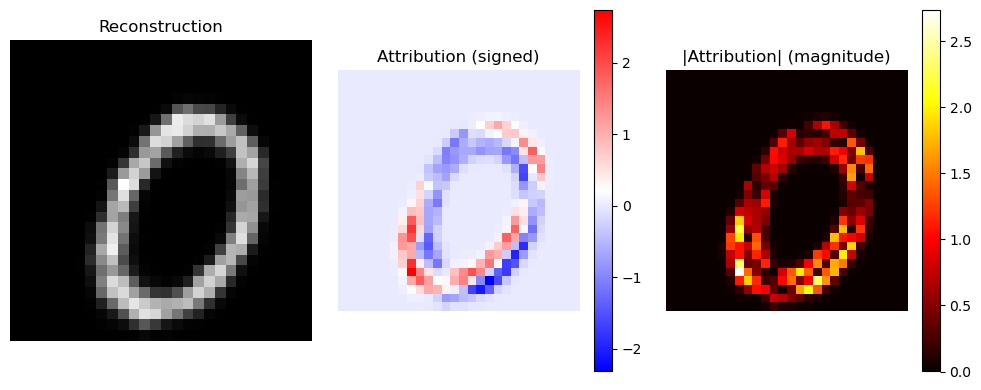


Example 1
Predicted class: 0
Per-latent LL: [1.6989329 2.1621013 0.6654705 2.0954878 1.6669661 1.7908559 1.6206303
 1.849427  1.509632  1.933162 ]


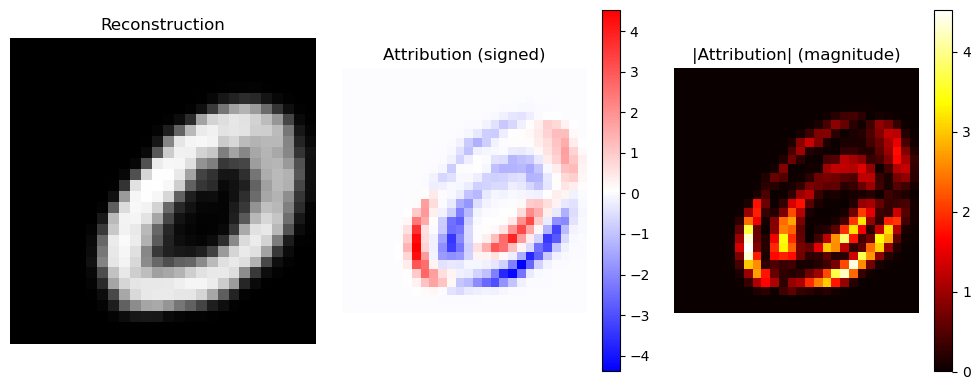


Example 2
Predicted class: 0
Per-latent LL: [1.5162336 1.4753517 1.7804347 1.5465546 1.208704  1.7019858 1.9305893
 1.5986708 1.737666  2.397738 ]


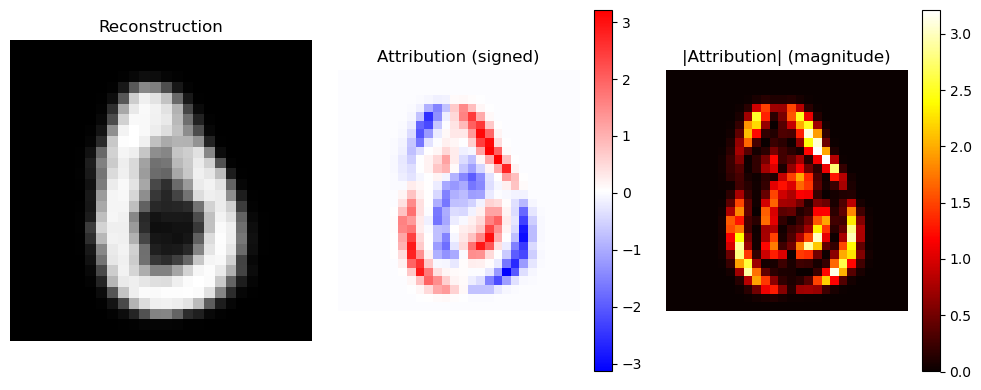


Example 3
Predicted class: 0
Per-latent LL: [ 1.5230805  1.3501168 -0.6059658  1.6225666  1.813119   1.3161218
  1.2664424  2.0233383  1.6973326  2.2051697]


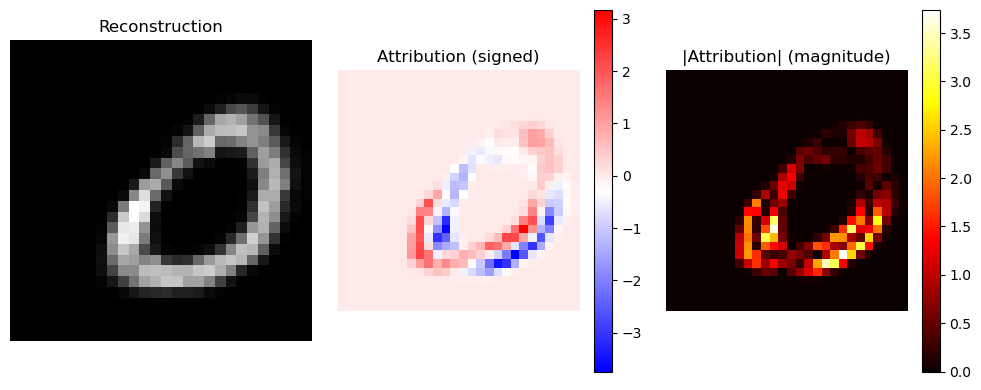


Example 4
Predicted class: 0
Per-latent LL: [1.2976562  1.7511516  1.0182374  1.3150017  0.72237325 1.5188427
 2.0119019  1.4111868  1.6289833  1.7320894 ]


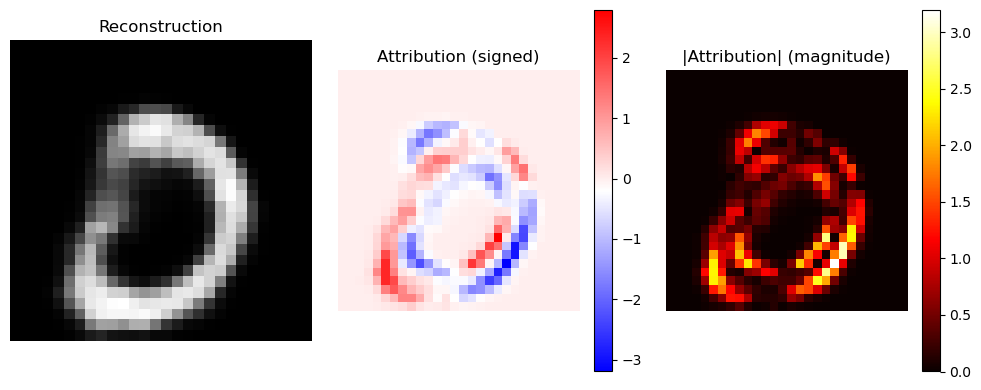

In [46]:
import torch
import torch.nn as nn
import numpy as np
import math
import matplotlib.pyplot as plt
from tqdm import tqdm

# =========================================================
# SETTINGS
# =========================================================
device = "cuda" if torch.cuda.is_available() else "cpu"
latent_dim = 10
n_classes = 10
T_train = 1000
T_eval  = 300
n_paths = 8
eps_fd = 0.1                # finite difference epsilon

betas = torch.linspace(1e-4, 0.02, T_train, device=device)
y_classes = torch.arange(n_classes, device=device)

# =========================================================
# MODELS (must already exist on disk)
# =========================================================
class ConditionalDenoiser(nn.Module):
    def __init__(self, latent_dim=10, n_classes=10, T=1000):
        super().__init__()
        self.embed_class = nn.Embedding(n_classes, 64)
        self.embed_time = nn.Sequential(
            nn.Linear(1, 64), nn.GELU(),
            nn.Linear(64, 64)
        )
        self.net = nn.Sequential(
            nn.Linear(latent_dim + 128, 512), nn.GELU(),
            nn.Linear(512, 512), nn.GELU(),
            nn.Linear(512, 512), nn.GELU(),
            nn.Linear(512, latent_dim)
        )
        self.T = T

    def forward(self, zt, t, y):
        t_emb = self.embed_time(t.float().unsqueeze(1) / self.T)
        y_emb = self.embed_class(y)
        return self.net(torch.cat([zt, t_emb, y_emb], dim=1))


class VAE_Decoder(nn.Module):
    def __init__(self, latent_dim=10, n_classes=10):
        super().__init__()
        self.decoder_input = nn.Linear(latent_dim, 64 * 7 * 7)
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (64, 7, 7)),
            nn.ConvTranspose2d(64, 32, 4, 2, 1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 4, 2, 1),
            nn.Sigmoid()
        )
        self.classifier = nn.Linear(latent_dim, n_classes)

    def classify(self, z):
        return self.classifier(z)


# Load model weights
den_model = ConditionalDenoiser(latent_dim, n_classes, T_train).to(device)
den_model.load_state_dict(torch.load("best_denoiser_linear.pth", map_location=device))
den_model.eval()

vae_model = VAE_Decoder(latent_dim, n_classes).to(device)
vae_model.load_state_dict(torch.load("conv_vae_with_classifier.pth", map_location=device),
                          strict=False)
vae_model.eval()


# =========================================================
# 1. Diffusion posterior WITH per-latent-dimension LL
# =========================================================
@torch.no_grad()
def diffusion_posterior_latent_with_dims(
    z0_obs, den_model, betas, T_train, y_classes,
    n_paths=8, T_eval=300, device="cpu"
):
    z0_obs = z0_obs.to(device)
    betas = betas.to(device)
    B, D = z0_obs.shape
    C = len(y_classes)

    step_ids = torch.linspace(1, T_train, T_eval, dtype=torch.long, device=device)
    betas_sub = betas[step_ids - 1]
    alphas_sub = 1 - betas_sub

    # antipodal noise pairs
    half = n_paths // 2
    eps_base = torch.randn(B, half, T_eval, D, device=device)
    eps = torch.cat([eps_base, -eps_base], 1)

    L_all     = torch.zeros(B, n_paths, C, device=device)
    L_all_dim = torch.zeros(B, n_paths, C, D, device=device)

    for c_idx, c in enumerate(y_classes):
        y = torch.full((B,), int(c), device=device)
        zt = z0_obs.unsqueeze(1).repeat(1, n_paths, 1)
        y_expand = y.unsqueeze(1).repeat(1, n_paths)

        ll_acc     = torch.zeros(B, n_paths, device=device)
        ll_acc_dim = torch.zeros(B, n_paths, D, device=device)

        for i in range(T_eval):
            t_idx = step_ids[i]
            beta_t = betas_sub[i]
            alpha_t = alphas_sub[i]

            noise = eps[:, :, i, :]
            zt1 = torch.sqrt(alpha_t) * zt + torch.sqrt(1 - alpha_t) * noise
            dz = zt1 - zt

            zt1_flat = zt1.reshape(B * n_paths, D)
            y_flat   = y_expand.reshape(B * n_paths)
            t_vec    = torch.full((B * n_paths,), t_idx, dtype=torch.long, device=device)

            score = den_model(zt1_flat, t_vec, y_flat)  # [B*n_paths, D]

            ll_dim_i = score * dz.view(B*n_paths, D)
            ll_dim_i += 0.5 * beta_t * (-(score**2) + (zt1_flat * score))

            ll_acc     += ll_dim_i.sum(-1).view(B, n_paths)
            ll_acc_dim += ll_dim_i.view(B, n_paths, D)

            zt = zt1

        L_all[:, :, c_idx]     = ll_acc
        L_all_dim[:, :, c_idx] = ll_acc_dim

    probs = torch.softmax(L_all, dim=2)
    mean_probs     = probs.mean(1)
    mean_probs_std = probs.std(1) / math.sqrt(n_paths)

    return mean_probs, mean_probs_std, L_all_dim


# =========================================================
# 2. Latent-dim likelihood for single sample
# =========================================================
def latent_dim_likelihood_for_sample(z0):
    mean_probs, _, L_all_dim = diffusion_posterior_latent_with_dims(
        z0, den_model, betas,
        T_train=T_train,
        y_classes=y_classes,
        n_paths=n_paths,
        T_eval=T_eval,
        device=device
    )
    c_hat = int(mean_probs.argmax(dim=1).item())
    L_dim_mean = L_all_dim[0, :, c_hat, :].mean(0)  # [D]
    return c_hat, L_dim_mean


# =========================================================
# 3. Decoder Jacobian via finite differences
# =========================================================
@torch.no_grad()
def decoder_jacobian_fd(vae_model, z0, eps=0.1):
    D = z0.shape[1]

    x_base = vae_model.decoder(vae_model.decoder_input(z0))[0,0]  # [28,28]
    J = []

    for k in range(D):
        zp = z0.clone(); zm = z0.clone()
        zp[0,k] += eps
        zm[0,k] -= eps

        xp = vae_model.decoder(vae_model.decoder_input(zp))[0,0]
        xm = vae_model.decoder(vae_model.decoder_input(zm))[0,0]

        J.append((xp - xm) / (2*eps))

    return x_base.cpu(), torch.stack(J, dim=0).cpu()   # [D,28,28]


# =========================================================
# 4. Pixel attribution
# =========================================================
def pixel_attribution(z0, L_dim_mean):
    x_base, J = decoder_jacobian_fd(vae_model, z0, eps=eps_fd)
    L = L_dim_mean.view(-1,1,1).cpu()
    A = (L * J).sum(0)   # [28,28]
    return x_base, A


# =========================================================
# ====== RUN FOR MULTIPLE TEST EXAMPLES ====================
# =========================================================
# (Assume you have latent samples & labels: z_sampled, y_sampled)
# Here we'll take first 5 examples.
num_examples = 5
examples = z_sampled[:num_examples].to(device)

for i in range(num_examples):
    print(f"\n===================================")
    print(f"Example {i}")

    z0 = examples[i:i+1]

    # 1) latent-dim likelihood
    c_hat, L_dim_mean = latent_dim_likelihood_for_sample(z0)
    print("Predicted class:", c_hat)
    print("Per-latent LL:", L_dim_mean.cpu().numpy())

    # 2) pixel attribution
    x_base, A = pixel_attribution(z0, L_dim_mean)

    # 3) Visualization
    plt.figure(figsize=(10,4))

    plt.subplot(1,3,1)
    plt.title("Reconstruction")
    plt.imshow(x_base, cmap="gray")
    plt.axis("off")

    plt.subplot(1,3,2)
    plt.title("Attribution (signed)")
    plt.imshow(A, cmap="bwr")
    plt.colorbar(); plt.axis("off")

    plt.subplot(1,3,3)
    plt.title("|Attribution| (magnitude)")
    plt.imshow(A.abs(), cmap="hot")
    plt.colorbar(); plt.axis("off")

    plt.tight_layout()
    plt.show()


In [52]:
# =========================================================
# LATENT → PIXEL ATTRIBUTION WITH DIFFUSION CLASSIFIER
# One example per class — SAVE SVGs
# =========================================================

import torch
import torch.nn as nn
import numpy as np
import math
import matplotlib.pyplot as plt
from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"

latent_dim = 10
n_classes = 10
T_train = 1000
T_eval  = 300
n_paths = 8
eps_fd  = 0.1  # finite-difference step for decoder Jacobian

betas = torch.linspace(1e-4, 0.02, T_train, device=device)
y_classes = torch.arange(n_classes, device=device)

# =========================================================
#  MODELS
# =========================================================
class ConditionalDenoiser(nn.Module):
    def __init__(self, latent_dim=10, n_classes=10, T=1000):
        super().__init__()
        self.embed_class = nn.Embedding(n_classes, 64)
        self.embed_time = nn.Sequential(
            nn.Linear(1, 64), nn.GELU(),
            nn.Linear(64, 64)
        )
        self.net = nn.Sequential(
            nn.Linear(latent_dim + 128, 512), nn.GELU(),
            nn.Linear(512, 512), nn.GELU(),
            nn.Linear(512, 512), nn.GELU(),
            nn.Linear(512, latent_dim)
        )
        self.T = T

    def forward(self, zt, t, y):
        t_emb = self.embed_time(t.float().unsqueeze(1) / self.T)
        y_emb = self.embed_class(y)
        return self.net(torch.cat([zt, t_emb, y_emb], dim=1))


class VAE_Decoder(nn.Module):
    def __init__(self, latent_dim=10, n_classes=10):
        super().__init__()
        self.decoder_input = nn.Linear(latent_dim, 64*7*7)
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (64,7,7)),
            nn.ConvTranspose2d(64, 32, 4, 2, 1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 4, 2, 1), nn.Sigmoid()
        )
        self.classifier = nn.Linear(latent_dim, n_classes)

    def classify(self, z):
        return self.classifier(z)


# Load trained weights
den_model = ConditionalDenoiser(latent_dim, n_classes, T_train).to(device)
den_model.load_state_dict(torch.load("best_denoiser_linear.pth", map_location=device))
den_model.eval()

vae_model = VAE_Decoder(latent_dim, n_classes).to(device)
vae_model.load_state_dict(torch.load("conv_vae_with_classifier.pth",
                                     map_location=device),
                          strict=False)
vae_model.eval()


# =========================================================
# 1. Diffusion posterior with per-dimension likelihood
# =========================================================
@torch.no_grad()
def diffusion_posterior_latent_with_dims(z0, den_model, betas):
    B, D = z0.shape
    L_dim_all = torch.zeros(B, n_paths, n_classes, D, device=device)
    step_ids = torch.linspace(1, T_train, T_eval, dtype=torch.long, device=device)

    # paired noise for variance reduction
    half = n_paths // 2
    eps_base = torch.randn(B, half, T_eval, D, device=device)
    eps = torch.cat([eps_base, -eps_base], dim=1)

    for c_idx in range(n_classes):
        y = torch.full((B,), c_idx, device=device)
        zt = z0.unsqueeze(1).repeat(1, n_paths, 1)
        y_expand = y.unsqueeze(1).repeat(1, n_paths)

        for i in range(T_eval):
            t_idx = step_ids[i]
            beta = betas[t_idx - 1]
            alpha = 1 - beta

            noise = eps[:, :, i]
            zt1 = torch.sqrt(alpha)*zt + torch.sqrt(1-alpha)*noise
            dz = zt1 - zt

            flat  = zt1.reshape(B*n_paths, D)
            yflat = y_expand.reshape(B*n_paths)
            tvec  = torch.full((B*n_paths,), t_idx, dtype=torch.long, device=device)

            score = den_model(flat, tvec, yflat)

            # per-dimension contribution
            ll_dim = score * dz.view(B*n_paths, D)
            ll_dim += 0.5 * beta * (-(score**2) + flat*score)

            L_dim_all[:, :, c_idx, :] += ll_dim.view(B, n_paths, D)
            zt = zt1

    # class posterior
    L_class = L_dim_all.sum(-1)      # [B,n_paths,C]
    probs = torch.softmax(L_class, dim=2)
    mean_probs = probs.mean(1)

    return mean_probs, L_dim_all.mean(1)  # [B,C], [B,C,D]


# =========================================================
# 2. Decoder Jacobian via finite differences
# =========================================================
@torch.no_grad()
def decoder_jacobian_fd(vae_model, z0, eps=0.1):
    D = z0.shape[1]
    x0 = vae_model.decoder(vae_model.decoder_input(z0))[0,0]

    J_list = []
    for k in range(D):
        zp = z0.clone()
        zm = z0.clone()
        zp[0,k] += eps
        zm[0,k] -= eps

        xp = vae_model.decoder(vae_model.decoder_input(zp))[0,0]
        xm = vae_model.decoder(vae_model.decoder_input(zm))[0,0]
        J_list.append((xp - xm) / (2*eps))

    return x0.cpu(), torch.stack(J_list, dim=0).cpu()   # [D,28,28]


# =========================================================
# 3. SELECT ONE EXAMPLE PER CLASS
# =========================================================
indices = []
for c in range(n_classes):
    idx = torch.where(y_sampled == c)[0]
    if len(idx) == 0:
        continue
    indices.append(idx[0].item())

z_examples = z_sampled[indices].to(device)
y_examples = y_sampled[indices]

print(f"Selected {len(indices)} test examples (1 per class).")


# =========================================================
# 4. RUN ATTRIBUTION + SAVE SVGs PER CLASS
# =========================================================
for i in range(len(z_examples)):
    true_class = int(y_examples[i].item())
    print("\n====================================")
    print(f"Class {true_class} example")

    z0 = z_examples[i:i+1]

    # diffusion likelihood
    mean_probs, L_dim = diffusion_posterior_latent_with_dims(z0, den_model, betas)
    pred_class = int(mean_probs.argmax())

    print(f"Predicted class = {pred_class}")

    L_vec = L_dim[0, pred_class]  # [D]

    # Jacobian
    x0, J = decoder_jacobian_fd(vae_model, z0, eps=eps_fd)

    # signed pixel attribution
    A = (L_vec.view(-1,1,1).cpu() * J).sum(0).cpu()

    # ============================
    # SAVE 3 SVG FIGURES
    # ============================

    # (1) reconstruction
    fig1, ax1 = plt.subplots(figsize=(4,4))
    ax1.set_title(f"Class {true_class} – Reconstruction", fontsize=14)
    ax1.imshow(x0, cmap="gray")
    ax1.axis("off")
    fig1.tight_layout()
    fig1.savefig(f"class_{true_class}_reconstruction.svg",
                 format="svg", bbox_inches="tight")
    plt.close(fig1)

    # (2) signed attribution
    fig2, ax2 = plt.subplots(figsize=(4,4))
    ax2.set_title(f"Class {true_class} – Signed Attribution", fontsize=14)
    im2 = ax2.imshow(A, cmap="bwr")
    fig2.colorbar(im2, ax=ax2, fraction=0.046)
    ax2.axis("off")
    fig2.tight_layout()
    fig2.savefig(f"class_{true_class}_signed_attribution.svg",
                 format="svg", bbox_inches="tight")
    plt.close(fig2)

    # (3) magnitude attribution
    fig3, ax3 = plt.subplots(figsize=(4,4))
    ax3.set_title(f"Class {true_class} – |Attribution|", fontsize=14)
    im3 = ax3.imshow(A.abs(), cmap="hot")
    fig3.colorbar(im3, ax=ax3, fraction=0.046)
    ax3.axis("off")
    fig3.tight_layout()
    fig3.savefig(f"class_{true_class}_attribution_magnitude.svg",
                 format="svg", bbox_inches="tight")
    plt.close(fig3)

    print(f"Saved SVGs for class {true_class}.")

print("\n✅ DONE — All per-class attribution SVGs saved.")


Selected 10 test examples (1 per class).

Class 0 example
Predicted class = 0
Saved SVGs for class 0.

Class 1 example
Predicted class = 1
Saved SVGs for class 1.

Class 2 example
Predicted class = 2
Saved SVGs for class 2.

Class 3 example
Predicted class = 3
Saved SVGs for class 3.

Class 4 example
Predicted class = 4
Saved SVGs for class 4.

Class 5 example
Predicted class = 5
Saved SVGs for class 5.

Class 6 example
Predicted class = 6
Saved SVGs for class 6.

Class 7 example
Predicted class = 7
Saved SVGs for class 7.

Class 8 example
Predicted class = 8
Saved SVGs for class 8.

Class 9 example
Predicted class = 9
Saved SVGs for class 9.

✅ DONE — All per-class attribution SVGs saved.


[info] Randomly selected 1 sample per class: [1306, 2703, 4666, 6121, 9176, 11854, 12221, 15389, 16708, 19703]
[info] global signed attribution scale = (-2.000, 2.000)


/var/folders/tc/qjb0w1k122v4jzwncjlh51140000gp/T/ipykernel_15419/587959501.py:120: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


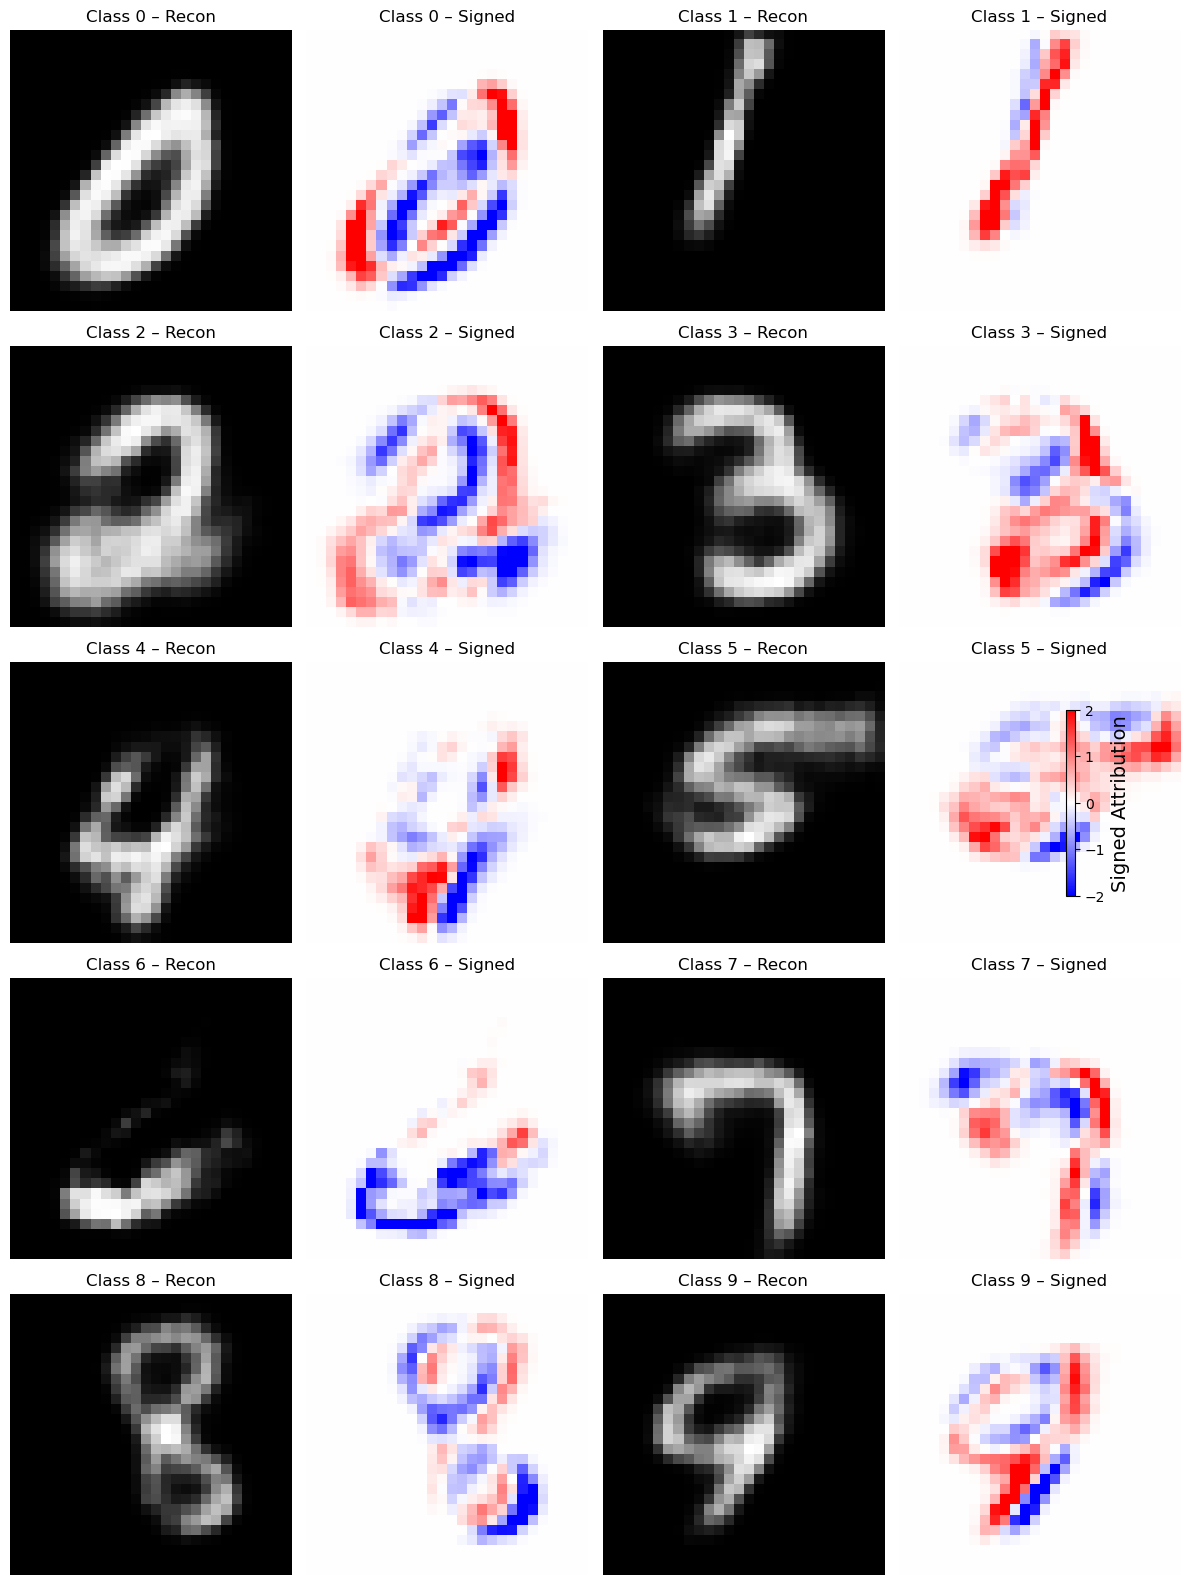

✔ Saved: recon_signed_attribution_4x5_random.svg


In [73]:
# =========================================================
# 4×5 PANEL: Reconstruction + Signed Attribution
# RANDOM SAMPLE PER CLASS
# =========================================================

import torch
import numpy as np
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"

# -----------------------------------------------------------------------------
# RANDOMLY SELECT ONE TEST SAMPLE PER CLASS
# y_sampled: [N], z_sampled: [N,latent_dim]
# -----------------------------------------------------------------------------

indices = []
for c in range(n_classes):
    class_idx = torch.where(y_sampled == c)[0]
    if len(class_idx) == 0:
        continue
    chosen = np.random.choice(class_idx.cpu().numpy(), size=1)[0]
    indices.append(chosen)

z_examples = z_sampled[indices].to(device)
y_examples = y_sampled[indices]

print(f"[info] Randomly selected 1 sample per class: {indices}")


# -----------------------------------------------------------------------------
# COLLECT RECONSTRUCTIONS + SIGNED ATTRIBUTIONS
# -----------------------------------------------------------------------------

recons = []
signed_attrs = []
class_labels = []

for i in range(len(z_examples)):
    true_class = int(y_examples[i].item())
    z0 = z_examples[i:i+1]

    # ---- diffusion posterior ----
    mean_probs, L_dim = diffusion_posterior_latent_with_dims(z0, den_model, betas)
    pred_class = int(mean_probs.argmax())

    # latent-space attributions
    L_vec = L_dim[0, pred_class]  # [latent_dim]

    # ---- decoder Jacobian ----
    x0, J = decoder_jacobian_fd(vae_model, z0, eps=eps_fd)

    # pixel-level signed attribution
    A = (L_vec.view(-1,1,1).cpu() * J).sum(0).cpu()

    recons.append(x0.numpy())
    signed_attrs.append(A.numpy())
    class_labels.append(true_class)

recons = np.array(recons)
signed_attrs = np.array(signed_attrs)
class_labels = np.array(class_labels)

# -----------------------------------------------------------------------------
# Determine GLOBAL colorbar range for all signed attributions
# -----------------------------------------------------------------------------
vmax = np.max(np.abs(signed_attrs))
vmin = -vmax

vmin, vmax = -2,2
print(f"[info] global signed attribution scale = ({vmin:.3f}, {vmax:.3f})")


# -----------------------------------------------------------------------------
# BUILD 4×5 PANEL (5 rows × 4 columns)
#
# Row r contains class 2r (A) and class 2r+1 (B):
#   Col 0: recon A
#   Col 1: signed A
#   Col 2: recon B
#   Col 3: signed B
# -----------------------------------------------------------------------------

fig, axes = plt.subplots(5, 4, figsize=(12, 16))

for row in range(5):
    for side in [0, 1]:  # 0 = left class, 1 = right class
        class_idx = 2 * row + side
        if class_idx >= len(class_labels):
            continue

        col_recon = 2 * side
        col_attr  = 2 * side + 1

        # (1) reconstruction
        axes[row, col_recon].imshow(recons[class_idx], cmap="gray")
        axes[row, col_recon].set_title(
            f"Class {class_labels[class_idx]} – Recon"
        )
        axes[row, col_recon].axis("off")

        # (2) signed attribution
        im = axes[row, col_attr].imshow(
            signed_attrs[class_idx], cmap="bwr",
            vmin=vmin, vmax=vmax
        )
        axes[row, col_attr].set_title(
            f"Class {class_labels[class_idx]} – Signed"
        )
        axes[row, col_attr].axis("off")


# -----------------------------------------------------------------------------
# Add *single* shared vertical colorbar
# -----------------------------------------------------------------------------

cbar = fig.colorbar(im, ax=axes[:, -1], fraction=0.046, pad=0.04)
cbar.set_label("Signed Attribution", fontsize=14)

plt.tight_layout()

fig.savefig("recon_signed_attribution_4x5_random.svg",
            format="svg", bbox_inches="tight")

plt.show()

print("✔ Saved: recon_signed_attribution_4x5_random.svg")


Selected 10 test examples (1 per class).

Class 0 example
Predicted class = 0
Per-latent L_k = [ 1.9952533  -0.27366984  1.5499798   1.8840613   1.6205325   1.0538871
  0.24436066  1.8603562   1.1164347   1.5868104 ]


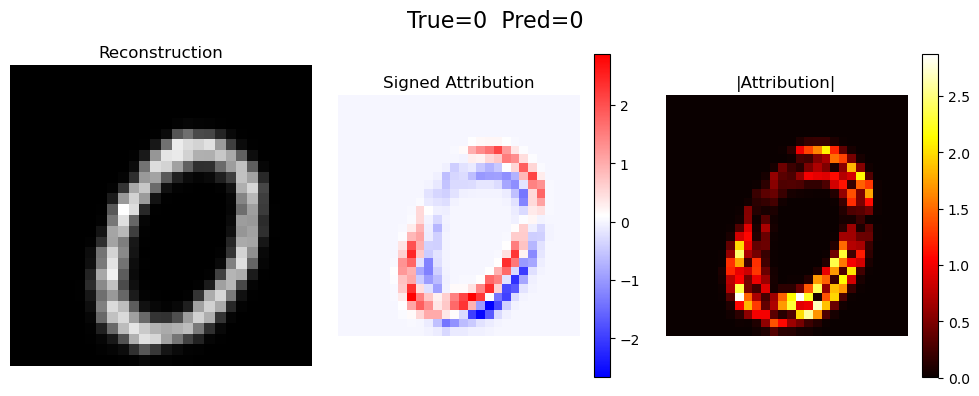


Class 1 example
Predicted class = 1
Per-latent L_k = [1.725384  1.966922  1.3177693 1.3740482 1.4898915 1.7964278 1.3944756
 2.2826345 1.8239872 1.7251974]


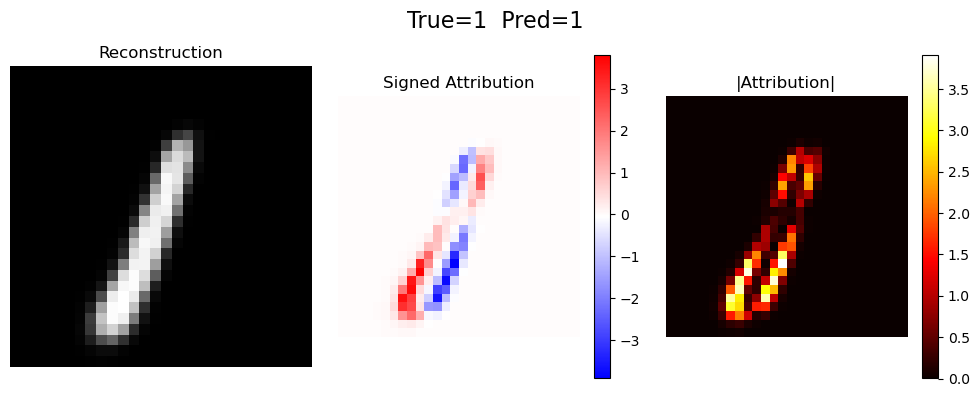


Class 2 example
Predicted class = 2
Per-latent L_k = [1.090622  1.0118309 0.9545227 1.727269  1.6959366 1.7295673 1.5824386
 1.7614311 1.551473  1.9114025]


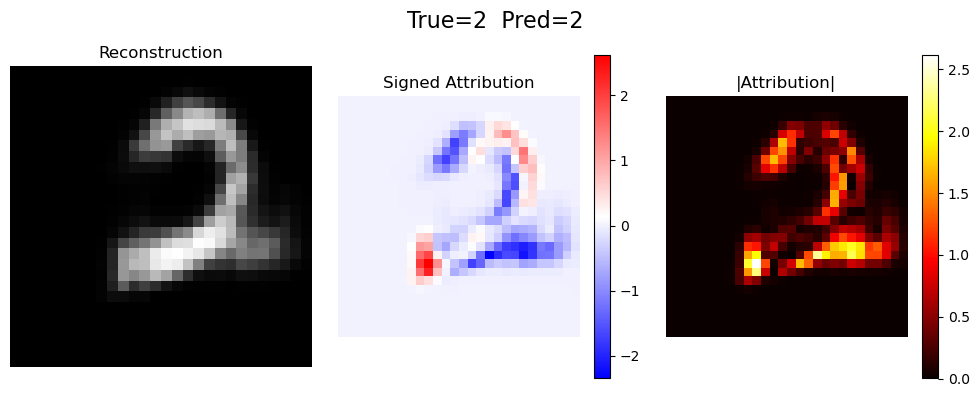


Class 3 example
Predicted class = 3
Per-latent L_k = [ 2.3096735  1.4153818 -0.0851394  1.4266742  1.3760058  1.4643478
  1.5254624  1.5356553  0.9486754  2.0530758]


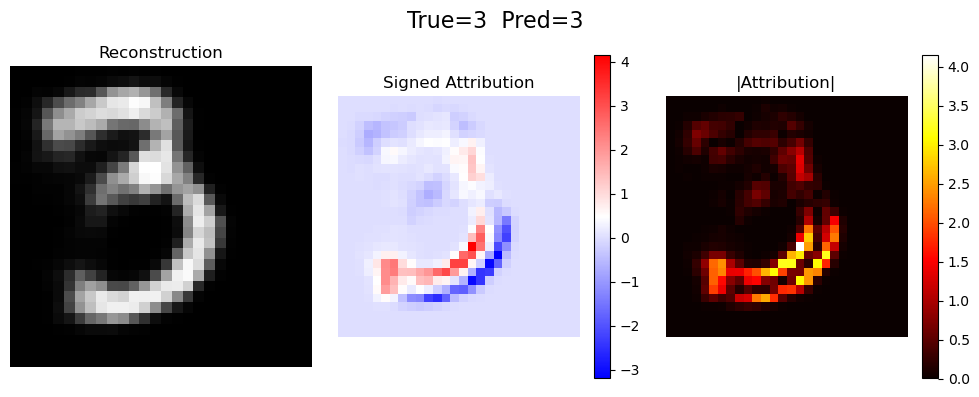


Class 4 example
Predicted class = 4
Per-latent L_k = [1.577522   0.8098544  1.2338393  2.6865954  1.905097   1.5526985
 1.0559704  0.85898954 1.6019135  1.409198  ]


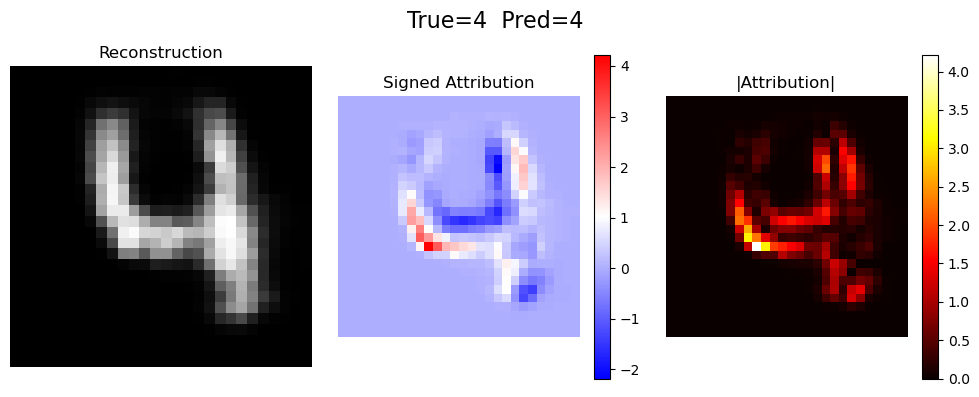


Class 5 example
Predicted class = 5
Per-latent L_k = [0.05834237 1.4842848  1.7457144  1.4221901  1.8251729  0.91013074
 1.4860214  1.4618013  1.5982342  1.7364886 ]


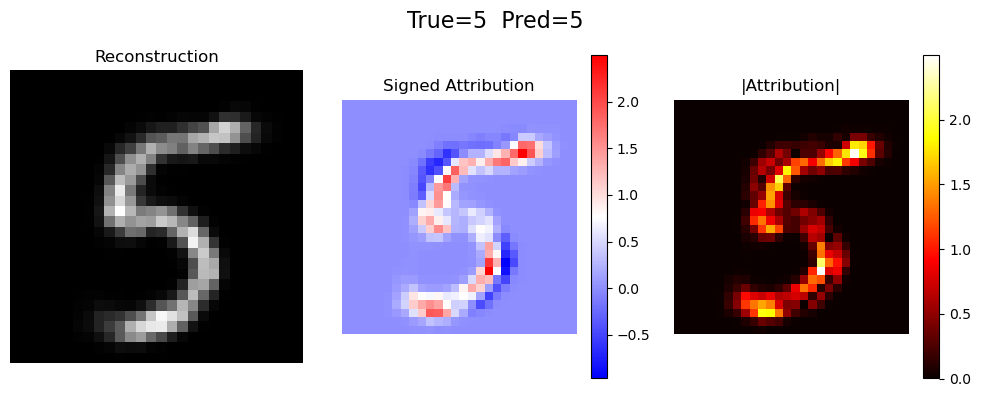


Class 6 example
Predicted class = 6
Per-latent L_k = [1.2234994 0.9414378 1.5165588 1.339053  1.7312156 1.674186  1.3625534
 2.261453  1.4541656 1.316457 ]


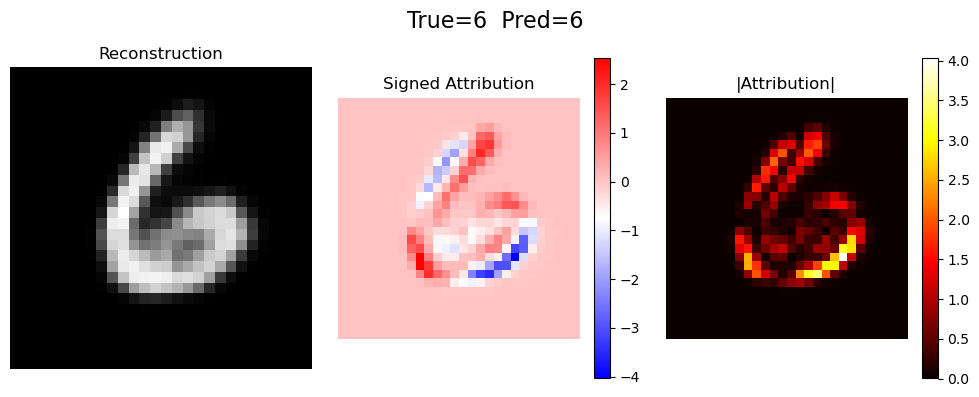


Class 7 example
Predicted class = 7
Per-latent L_k = [1.4888986 1.8598281 0.8831294 2.5493824 2.2057903 1.6071273 1.2101382
 1.1963787 2.2977185 1.8885565]


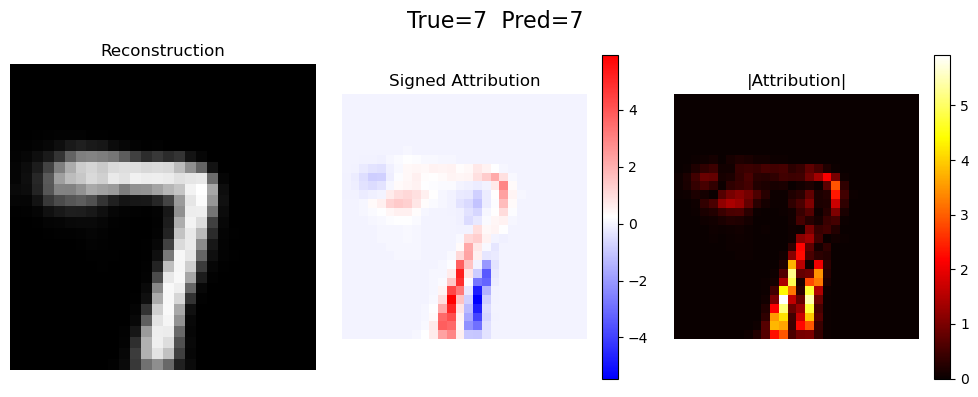


Class 8 example
Predicted class = 8
Per-latent L_k = [ 1.4185746   2.2588809   0.35258743  1.6044645   1.1482313  -1.2159156
  0.7180376   1.2653149   1.8342526  -0.14632143]


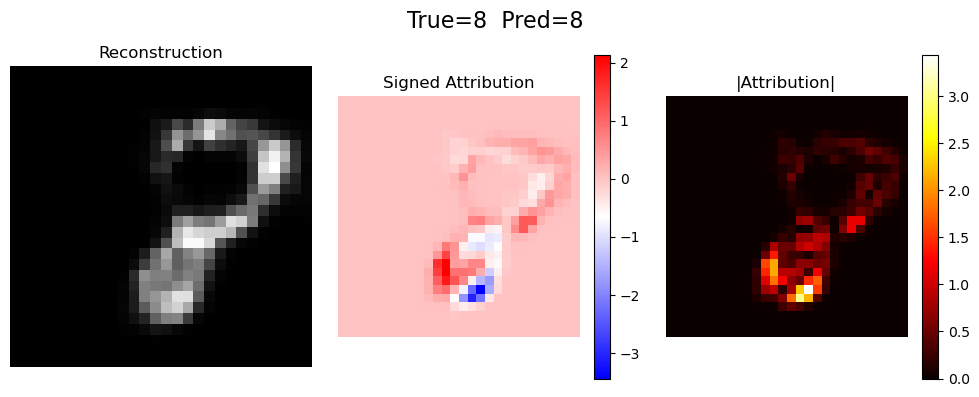


Class 9 example
Predicted class = 9
Per-latent L_k = [1.5075293  1.5318148  1.6759273  2.2725835  0.7483132  1.3098061
 1.598931   1.1615531  1.2432848  0.84105116]


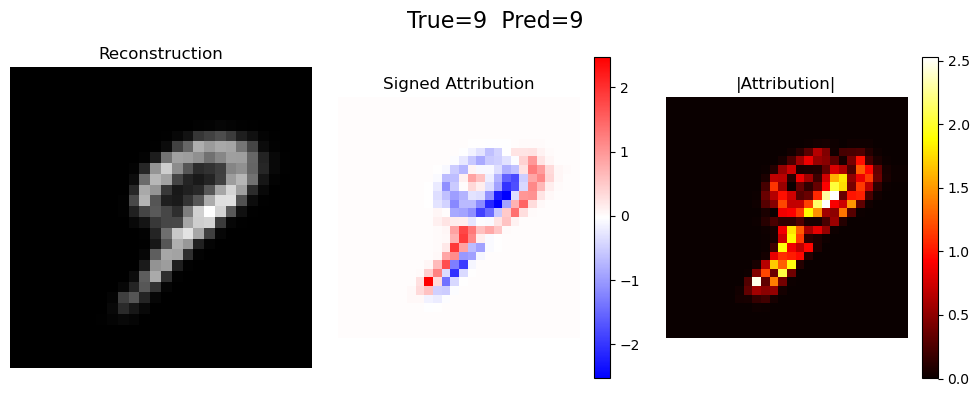

In [51]:
# =========================================================
# LATENT → PIXEL ATTRIBUTION WITH DIFFUSION CLASSIFIER
# One example per class
# =========================================================

import torch
import torch.nn as nn
import numpy as np
import math
import matplotlib.pyplot as plt
from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"

latent_dim = 10
n_classes = 10
T_train = 1000
T_eval  = 300
n_paths = 8
eps_fd = 0.1  # finite-difference step for decoder Jacobian

betas = torch.linspace(1e-4, 0.02, T_train, device=device)
y_classes = torch.arange(n_classes, device=device)

# =========================================================
#  MODELS
# =========================================================
class ConditionalDenoiser(nn.Module):
    def __init__(self, latent_dim=10, n_classes=10, T=1000):
        super().__init__()
        self.embed_class = nn.Embedding(n_classes, 64)
        self.embed_time = nn.Sequential(
            nn.Linear(1, 64), nn.GELU(),
            nn.Linear(64, 64)
        )
        self.net = nn.Sequential(
            nn.Linear(latent_dim + 128, 512), nn.GELU(),
            nn.Linear(512, 512), nn.GELU(),
            nn.Linear(512, 512), nn.GELU(),
            nn.Linear(512, latent_dim)
        )
        self.T = T

    def forward(self, zt, t, y):
        t_emb = self.embed_time(t.float().unsqueeze(1) / self.T)
        y_emb = self.embed_class(y)
        return self.net(torch.cat([zt, t_emb, y_emb], dim=1))


class VAE_Decoder(nn.Module):
    def __init__(self, latent_dim=10, n_classes=10):
        super().__init__()
        self.decoder_input = nn.Linear(latent_dim, 64*7*7)
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (64,7,7)),
            nn.ConvTranspose2d(64, 32, 4, 2, 1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 4, 2, 1), nn.Sigmoid()
        )
        self.classifier = nn.Linear(latent_dim, n_classes)

    def classify(self, z):
        return self.classifier(z)


# Load trained weights
den_model = ConditionalDenoiser(latent_dim, n_classes, T_train).to(device)
den_model.load_state_dict(torch.load("best_denoiser_linear.pth", map_location=device))
den_model.eval()

vae_model = VAE_Decoder(latent_dim, n_classes).to(device)
vae_model.load_state_dict(torch.load("conv_vae_with_classifier.pth", map_location=device),
                          strict=False)
vae_model.eval()


# =========================================================
# 1. Diffusion posterior with per-dim likelihood
# =========================================================
@torch.no_grad()
def diffusion_posterior_latent_with_dims(z0, den_model, betas):

    B, D = z0.shape
    L_dim_all = torch.zeros(B, n_paths, n_classes, D, device=device)
    step_ids = torch.linspace(1, T_train, T_eval, dtype=torch.long, device=device)

    # create paired noise for variance reduction
    half = n_paths // 2
    eps_base = torch.randn(B, half, T_eval, D, device=device)
    eps = torch.cat([eps_base, -eps_base], dim=1)

    for c_idx in range(n_classes):
        y = torch.full((B,), c_idx, device=device)
        zt = z0.unsqueeze(1).repeat(1, n_paths, 1)
        y_expand = y.unsqueeze(1).repeat(1, n_paths)

        for i in range(T_eval):
            t_idx = step_ids[i]
            beta = betas[t_idx - 1]
            alpha = 1 - beta

            noise = eps[:, :, i]
            zt1 = torch.sqrt(alpha)*zt + torch.sqrt(1-alpha)*noise
            dz = zt1 - zt

            flat = zt1.reshape(B*n_paths, D)
            yflat = y_expand.reshape(B*n_paths)
            tvec = torch.full((B*n_paths,), t_idx, dtype=torch.long, device=device)

            score = den_model(flat, tvec, yflat)  # [B*n_paths,D]

            ll_dim = score * dz.view(B*n_paths, D)
            ll_dim += 0.5*beta*( -(score**2) + flat*score )

            L_dim_all[:, :, c_idx] += ll_dim.view(B, n_paths, D)
            zt = zt1

    # class posterior
    L_class = L_dim_all.sum(-1)  # sum over dims → [B,n_paths,n_classes]
    probs = torch.softmax(L_class, dim=2)  # softmax over class axis
    mean_probs = probs.mean(1)

    return mean_probs, L_dim_all.mean(1)   # [B,C], [B,C,D]


# =========================================================
# 2. Decoder Jacobian (finite differences)
# =========================================================
@torch.no_grad()
def decoder_jacobian_fd(vae_model, z0, eps=0.1):
    D = z0.shape[1]
    x0 = vae_model.decoder(vae_model.decoder_input(z0))[0,0]

    J = []
    for k in range(D):
        zp = z0.clone(); zm = z0.clone()
        zp[0,k] += eps; zm[0,k] -= eps

        xp = vae_model.decoder(vae_model.decoder_input(zp))[0,0]
        xm = vae_model.decoder(vae_model.decoder_input(zm))[0,0]
        J.append((xp - xm) / (2*eps))

    return x0.cpu(), torch.stack(J).cpu()   # [D,28,28]


# =========================================================
# 3. One example per class (test)
# z_sampled: [N,latent_dim], y_sampled: [N]
# =========================================================
indices = []
for c in range(n_classes):
    idx = torch.where(y_sampled == c)[0]
    if len(idx) == 0:
        continue
    indices.append(idx[0].item())

z_examples = z_sampled[indices].to(device)
y_examples = y_sampled[indices]

print(f"Selected {len(indices)} test examples (1 per class).")


# =========================================================
# 4. RUN ATTRIBUTION PER CLASS
# =========================================================
for i in range(len(z_examples)):
    print("\n============================================")
    print(f"Class {y_examples[i].item()} example")

    z0 = z_examples[i:i+1]

    # --- diffusion likelihood ---
    mean_probs, L_dim = diffusion_posterior_latent_with_dims(z0, den_model, betas)
    pred_class = int(mean_probs.argmax())

    print("Predicted class =", pred_class)
    print("Per-latent L_k =", L_dim[0, pred_class].cpu().numpy())

    # select vector of L_k for predicted class
    L_vec = L_dim[0, pred_class]   # [D]

    # --- decoder Jacobian ---
    x0, J = decoder_jacobian_fd(vae_model, z0, eps=eps_fd)

    # --- pixel attribution ---
    A = (L_vec.view(-1,1,1).cpu() * J).sum(0).cpu()

    # --- visualization ---
    plt.figure(figsize=(10,4))
    plt.suptitle(f"True={y_examples[i].item()}  Pred={pred_class}", fontsize=16)

    plt.subplot(1,3,1)
    plt.title("Reconstruction")
    plt.imshow(x0, cmap="gray")
    plt.axis("off")

    plt.subplot(1,3,2)
    plt.title("Signed Attribution")
    plt.imshow(A, cmap="bwr")
    plt.colorbar(); plt.axis("off")

    plt.subplot(1,3,3)
    plt.title("|Attribution|")
    plt.imshow(A.abs(), cmap="hot")
    plt.colorbar(); plt.axis("off")

    plt.tight_layout()
    plt.show()


In [53]:
import matplotlib.pyplot as plt
import numpy as np

# --- create vertical gradient ---
h = 500   # height in pixels
w = 50    # width

# values go from 0 → 1 (top → bottom)
vals = np.linspace(0, 1, h).reshape(h, 1)
img = np.repeat(vals, w, axis=1)

# --- pick rainbow colormap ---
cmap = plt.get_cmap("rainbow")

# --- plot & save as SVG ---
fig, ax = plt.subplots(figsize=(2, 6))

ax.imshow(img, cmap=cmap, aspect='auto', origin='lower')
ax.set_axis_off()

plt.tight_layout()
fig.savefig("vertical_rainbow_bar.svg", format="svg", bbox_inches="tight")
plt.close(fig)

print("Saved: vertical_rainbow_bar.svg")


Saved: vertical_rainbow_bar.svg


In [50]:
# =========================================================
# AVERAGE SIGNED PIXEL ATTRIBUTION (200 EXAMPLES PER CLASS)
# Save average decoded example + signed attribution per class as SVG
# =========================================================

import torch
import torch.nn as nn
import numpy as np
import math
import matplotlib.pyplot as plt
from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"

latent_dim = 10
n_classes  = 10
T_train    = 1000
T_eval     = 300
n_paths    = 8
eps_fd     = 0.1   # finite-diff step for decoder Jacobian
samples_per_class = 200

betas = torch.linspace(1e-4, 0.02, T_train, device=device)
y_classes = torch.arange(n_classes, device=device)

# =========================================================
# MODELS
# =========================================================
class ConditionalDenoiser(nn.Module):
    def __init__(self, latent_dim=10, n_classes=10, T=1000):
        super().__init__()
        self.embed_class = nn.Embedding(n_classes, 64)
        self.embed_time = nn.Sequential(
            nn.Linear(1, 64), nn.GELU(),
            nn.Linear(64, 64)
        )
        self.net = nn.Sequential(
            nn.Linear(latent_dim + 128, 512), nn.GELU(),
            nn.Linear(512, 512), nn.GELU(),
            nn.Linear(512, 512), nn.GELU(),
            nn.Linear(512, latent_dim)
        )
        self.T = T

    def forward(self, zt, t, y):
        t_emb = self.embed_time(t.float().unsqueeze(1) / self.T)
        y_emb = self.embed_class(y)
        return self.net(torch.cat([zt, t_emb, y_emb], dim=1))


class VAE_Decoder(nn.Module):
    def __init__(self, latent_dim, n_classes):
        super().__init__()
        self.decoder_input = nn.Linear(latent_dim, 64*7*7)
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (64,7,7)),
            nn.ConvTranspose2d(64,32,4,2,1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.ConvTranspose2d(32,1,4,2,1), nn.Sigmoid()
        )
        self.classifier = nn.Linear(latent_dim, n_classes)

    def classify(self, z):
        return self.classifier(z)


# Load trained weights
den_model = ConditionalDenoiser(latent_dim, n_classes, T_train).to(device)
den_model.load_state_dict(torch.load("best_denoiser_linear.pth", map_location=device))
den_model.eval()

vae_model = VAE_Decoder(latent_dim, n_classes).to(device)
vae_model.load_state_dict(torch.load("conv_vae_with_classifier.pth",
                                     map_location=device), strict=False)
vae_model.eval()


# =========================================================
# DIFFUSION POSTERIOR (PER-DIMENSION)
# =========================================================
@torch.no_grad()
def diffusion_posterior_latent_with_dims(z0):
    """
    z0: [1,D]
    Returns:
      mean_probs: [1,C]
      L_dim_mean: [1,C,D]
    """
    z0 = z0.to(device)
    B, D = z0.shape

    L_dim_all = torch.zeros(B, n_paths, n_classes, D, device=device)
    step_ids = torch.linspace(1, T_train, T_eval, dtype=torch.long, device=device)

    # paired noise
    half = n_paths // 2
    eps_base = torch.randn(B, half, T_eval, D, device=device)
    eps = torch.cat([eps_base, -eps_base], dim=1)  # symmetry

    for c in range(n_classes):
        y = torch.full((B,), c, device=device, dtype=torch.long)

        zt = z0.unsqueeze(1).repeat(1, n_paths, 1)
        y_expand = y.unsqueeze(1).repeat(1, n_paths)

        for i in range(T_eval):
            t_idx = step_ids[i]
            beta = betas[t_idx - 1]
            alpha = 1 - beta

            noise = eps[:,:,i,:]
            zt1 = torch.sqrt(alpha)*zt + torch.sqrt(1-alpha)*noise
            dz  = zt1 - zt

            flat  = zt1.reshape(B*n_paths, D)
            yflat = y_expand.reshape(B*n_paths)
            tvec  = torch.full((B*n_paths,), t_idx,
                               dtype=torch.long, device=device)

            score = den_model(flat, tvec, yflat)

            ll_dim = score * dz.view(B*n_paths, D)
            ll_dim += 0.5*beta*( -(score**2) + flat*score )

            L_dim_all[:,:,c,:] += ll_dim.view(B,n_paths,D)
            zt = zt1

    # class posterior
    L_class = L_dim_all.sum(-1)     # [B,n_paths,C]
    probs = torch.softmax(L_class, dim=2)
    mean_probs = probs.mean(1)      # [B,C]
    L_dim_mean = L_dim_all.mean(1)  # [B,C,D]

    return mean_probs, L_dim_mean


# =========================================================
# DECODER JACOBIAN VIA FINITE DIFFERENCES
# =========================================================
@torch.no_grad()
def decoder_jacobian_fd(z0):
    D = z0.shape[1]
    x0 = vae_model.decoder(vae_model.decoder_input(z0))[0,0]

    J_list = []
    for k in range(D):
        zp = z0.clone(); zm = z0.clone()
        zp[0,k] += eps_fd
        zm[0,k] -= eps_fd
        xp = vae_model.decoder(vae_model.decoder_input(zp))[0,0]
        xm = vae_model.decoder(vae_model.decoder_input(zm))[0,0]
        J_list.append((xp - xm) / (2*eps_fd))

    return x0.cpu(), torch.stack(J_list, dim=0).cpu()   # [D,28,28]


# =========================================================
# SELECT EXACTLY 200 EXAMPLES PER CLASS
# =========================================================
indices = []
for c in range(n_classes):
    idx = torch.where(y_sampled == c)[0]
    if len(idx) < samples_per_class:
        raise ValueError(f"Class {c} has only {len(idx)} samples!")
    chosen = idx[:samples_per_class]
    indices.extend(chosen.tolist())

indices = torch.tensor(indices)
z_subset = z_sampled[indices]   # [2000, latent_dim]
y_subset = y_sampled[indices]   # [2000]


# =========================================================
# ACCUMULATE ATTRIBUTION + RECONSTRUCTION PER CLASS
# =========================================================
A_class_sum = torch.zeros(n_classes, 28, 28)
X_class_sum = torch.zeros(n_classes, 28, 28)
A_class_count = torch.zeros(n_classes)

print("\nProcessing exactly 200 examples per class...\n")

for j in tqdm(range(len(z_subset))):
    z0 = z_subset[j:j+1].to(device)
    y_true = int(y_subset[j])

    # diffusion likelihood
    mean_probs, L_dim_mean = diffusion_posterior_latent_with_dims(z0)
    c_hat = int(mean_probs.argmax())

    L_vec = L_dim_mean[0, c_hat]  # [D]

    # decoder Jacobian
    x0, J = decoder_jacobian_fd(z0)

    # signed attribution
    A = (L_vec.view(-1,1,1).cpu() * J).sum(0)

    # accumulate
    A_class_sum[y_true] += A
    X_class_sum[y_true] += x0
    A_class_count[y_true] += 1


# =========================================================
# COMPUTE AVERAGES + SAVE SVGs
# =========================================================
A_class_avg = A_class_sum / A_class_count.view(-1,1,1)
X_class_avg = X_class_sum / A_class_count.view(-1,1,1)

print("\n=== SAVING SVGs PER CLASS ===")

for c in range(n_classes):
    # Average reconstruction
    fig1, ax1 = plt.subplots(figsize=(4,4))
    ax1.set_title(f"Class {c} — Avg Reconstruction (200 ex.)")
    ax1.imshow(X_class_avg[c], cmap="gray", vmin=0.0, vmax=1.0)
    ax1.axis("off")
    fig1.tight_layout()
    fig1.savefig(f"class_{c}_avg_reconstruction_200.svg",
                 format="svg", bbox_inches="tight")
    plt.close(fig1)

    # Average signed attribution
    fig2, ax2 = plt.subplots(figsize=(4,4))
    ax2.set_title(f"Class {c} — Avg Signed Attribution (200 ex.)")
    im2 = ax2.imshow(A_class_avg[c], cmap="bwr")
    fig2.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04)
    ax2.axis("off")
    fig2.tight_layout()
    fig2.savefig(f"class_{c}_avg_signed_attribution_200.svg",
                 format="svg", bbox_inches="tight")
    plt.close(fig2)

    print(f"Saved class {c} avg SVGs.")


print("\n✅ Done: average over EXACTLY 200 examples per class saved as SVGs.")



Processing exactly 200 examples per class...



100%|███████████████████████████████████████| 2000/2000 [15:41<00:00,  2.13it/s]



=== SAVING SVGs PER CLASS ===
Saved class 0 avg SVGs.
Saved class 1 avg SVGs.
Saved class 2 avg SVGs.
Saved class 3 avg SVGs.
Saved class 4 avg SVGs.
Saved class 5 avg SVGs.
Saved class 6 avg SVGs.
Saved class 7 avg SVGs.
Saved class 8 avg SVGs.
Saved class 9 avg SVGs.

✅ Done: average over EXACTLY 200 examples per class saved as SVGs.


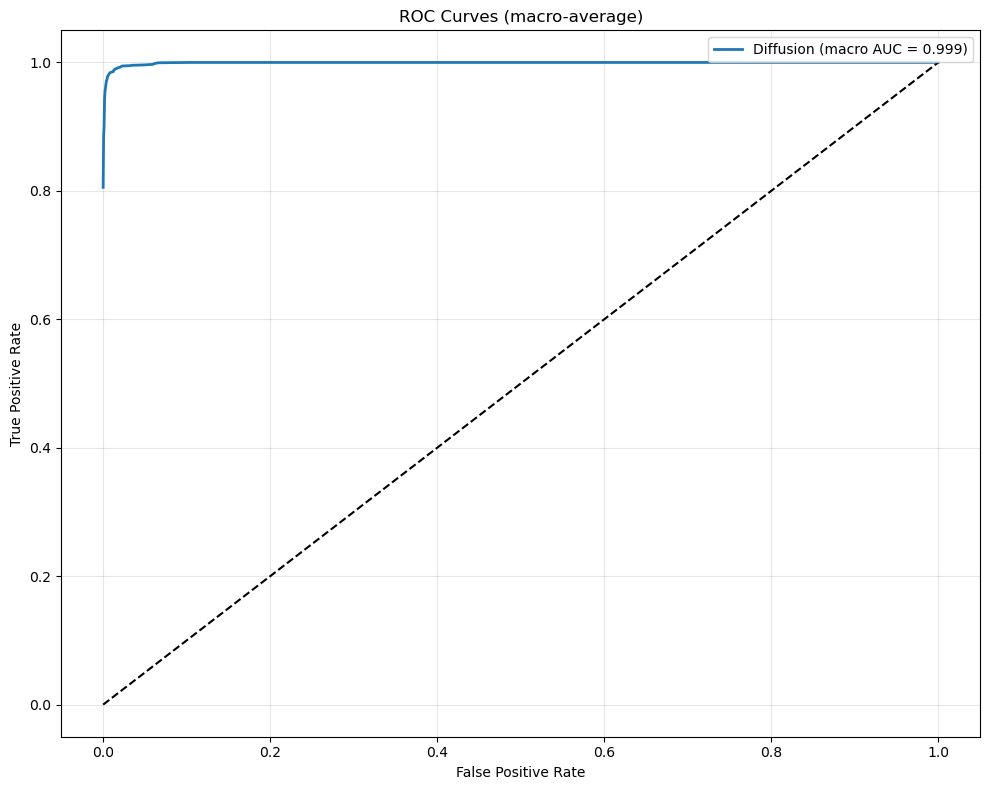


=== TOP-K ACCURACY ===
K=1: Flow=0.9690,  VAE=0.9660,  Flow_tieAware=0.9690
K=2: Flow=0.9935,  VAE=0.9900,  Flow_tieAware=0.9935
K=3: Flow=0.9985,  VAE=0.9960,  Flow_tieAware=0.9985
K=4: Flow=0.9990,  VAE=0.9980,  Flow_tieAware=0.9990
K=5: Flow=0.9995,  VAE=0.9985,  Flow_tieAware=0.9995


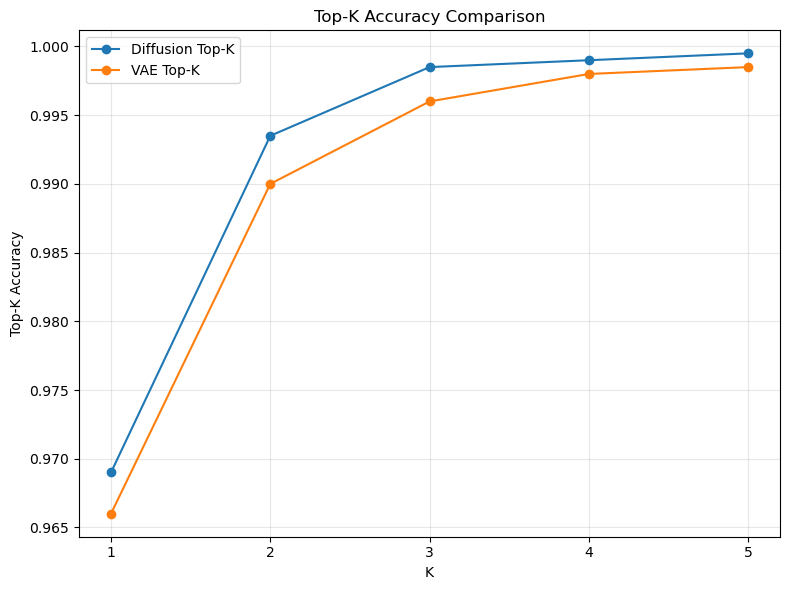

In [24]:
# =========================================================
# PLOTS: ROC CURVES + TOP-K ACCURACY
# =========================================================
from sklearn.metrics import roc_curve, auc

# Convert to numpy
probs_flow = post_flow_all
probs_vae  = post_vae_all
y_true     = true_all

# One-hot for ROC curves
y_onehot = np.eye(n_classes)[y_true]

# =========================================================
# 1. Plot ROC Curves (macro-average)
# =========================================================
plt.figure(figsize=(10, 8))

# ----- Diffusion ROC -----
fpr_flow = dict()
tpr_flow = dict()
roc_auc_flow = dict()
for c in range(n_classes):
    fpr_flow[c], tpr_flow[c], _ = roc_curve(y_onehot[:, c], probs_flow[:, c])
    roc_auc_flow[c] = auc(fpr_flow[c], tpr_flow[c])

# macro-average
all_fpr = np.unique(np.concatenate([fpr_flow[c] for c in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for c in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr_flow[c], tpr_flow[c])
mean_tpr /= n_classes
roc_auc_flow_macro = auc(all_fpr, mean_tpr)

plt.plot(all_fpr, mean_tpr, label=f"Diffusion (macro AUC = {roc_auc_flow_macro:.3f})", linewidth=2)

# ----- VAE ROC -----
fpr_vae = dict()
tpr_vae = dict()
roc_auc_vae = dict()
for c in range(n_classes):
    fpr_vae[c], tpr_vae[c], _ = roc_curve(y_onehot[:, c], probs_vae[:, c])
    roc_auc_vae[c] = auc(fpr_vae[c], tpr_vae[c])

all_fpr2 = np.unique(np.concatenate([fpr_vae[c] for c in range(n_classes)]))
mean_tpr2 = np.zeros_like(all_fpr2)
for c in range(n_classes):
    mean_tpr2 += np.interp(all_fpr2, fpr_vae[c], tpr_vae[c])
mean_tpr2 /= n_classes
roc_auc_vae_macro = auc(all_fpr2, mean_tpr2)

# plt.plot(all_fpr2, mean_tpr2, label=f"VAE (macro AUC = {roc_auc_vae_macro:.3f})", linewidth=2)

plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (macro-average)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()



# =========================================================
# 2. Top-K Accuracy for k=1..5
# =========================================================
def top_k_acc(probs, y_true, k):
    topk = np.argsort(-probs, axis=1)[:, :k]
    return np.mean([y_true[i] in topk[i] for i in range(len(y_true))])


# =========================================================
# 3. Tie-Aware Top-K for diffusion posterior
# =========================================================
def top_k_acc_tie_aware(probs, y_true, k, tol=1e-9):
    """
    If several classes have probability equal (within tol) to the Kth value,
    all tied classes count as top-K.
    """
    accs = []
    for i in range(len(probs)):
        row = probs[i]
        y = y_true[i]

        # find kth probability threshold
        sorted_probs = np.sort(row)[::-1]
        if k <= len(sorted_probs):
            kth_val = sorted_probs[k-1]
        else:
            kth_val = sorted_probs[-1]

        # find all tied values within tolerance
        tied_idx = np.where(row >= kth_val - tol)[0]

        accs.append(y in tied_idx)
    return np.mean(accs)


# =========================================================
# 4. Compute & print all top-K metrics
# =========================================================
print("\n=== TOP-K ACCURACY ===")
for k in [1,2,3,4,5]:
    acc_flow_k = top_k_acc(probs_flow, y_true, k)
    acc_vae_k  = top_k_acc(probs_vae,  y_true, k)
    acc_flow_tie = top_k_acc_tie_aware(probs_flow, y_true, k)

    print(f"K={k}: Flow={acc_flow_k:.4f},  VAE={acc_vae_k:.4f},  Flow_tieAware={acc_flow_tie:.4f}")


# =========================================================
# 5. Plot Top-K Accuracy Curves
# =========================================================
Ks = np.arange(1,6)
flow_topk      = [top_k_acc(probs_flow, y_true, k) for k in Ks]
vae_topk       = [top_k_acc(probs_vae,  y_true, k) for k in Ks]
flow_topk_tie  = [top_k_acc_tie_aware(probs_flow, y_true, k) for k in Ks]

plt.figure(figsize=(8,6))
plt.plot(Ks, flow_topk,     "-o", label="Diffusion Top-K")
# plt.plot(Ks, flow_topk_tie, "-o", label="Diffusion Top-K (tie-aware)")
plt.plot(Ks, vae_topk,      "-o", label="VAE Top-K")
plt.xlabel("K")
plt.ylabel("Top-K Accuracy")
plt.title("Top-K Accuracy Comparison")
plt.xticks(Ks)
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


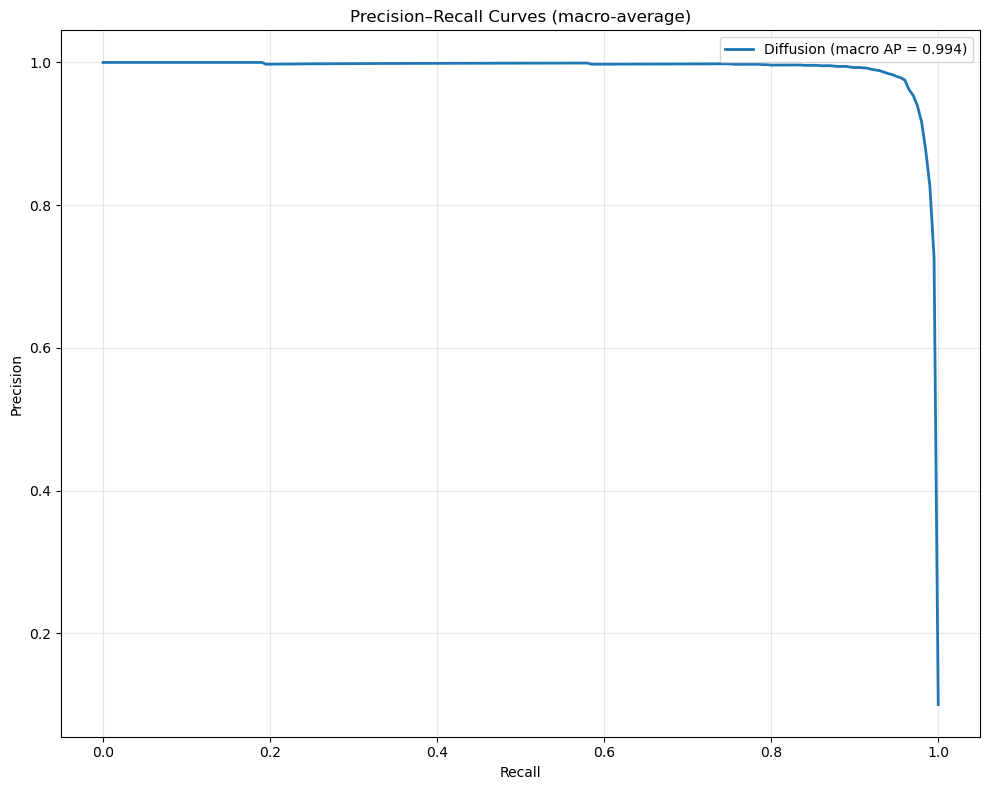

In [45]:
# =========================================================
# PRECISION–RECALL CURVES (macro-average)
# =========================================================
from sklearn.metrics import precision_recall_curve, average_precision_score

plt.figure(figsize=(10, 8))

# ----- DIFFUSION PR -----
prec_flow = dict()
rec_flow  = dict()
ap_flow   = dict()

for c in range(n_classes):
    prec_flow[c], rec_flow[c], _ = precision_recall_curve(
        y_onehot[:, c], probs_flow[:, c]
    )
    ap_flow[c] = average_precision_score(y_onehot[:, c], probs_flow[:, c])

# macro-average PR
all_rec = np.unique(np.concatenate([rec_flow[c] for c in range(n_classes)]))
mean_prec = np.zeros_like(all_rec)

for c in range(n_classes):
    # reverse for increasing recall
    mean_prec += np.interp(all_rec, rec_flow[c][::-1], prec_flow[c][::-1])
mean_prec /= n_classes

ap_flow_macro = np.mean(list(ap_flow.values()))

plt.plot(
    all_rec, mean_prec,
    label=f"Diffusion (macro AP = {ap_flow_macro:.3f})",
    linewidth=2
)

# ----- VAE PR -----
prec_vae = dict()
rec_vae  = dict()
ap_vae   = dict()

for c in range(n_classes):
    prec_vae[c], rec_vae[c], _ = precision_recall_curve(
        y_onehot[:, c], probs_vae[:, c]
    )
    ap_vae[c] = average_precision_score(y_onehot[:, c], probs_vae[:, c])

all_rec2 = np.unique(np.concatenate([rec_vae[c] for c in range(n_classes)]))
mean_prec2 = np.zeros_like(all_rec2)

for c in range(n_classes):
    mean_prec2 += np.interp(all_rec2, rec_vae[c][::-1], prec_vae[c][::-1])
mean_prec2 /= n_classes

ap_vae_macro = np.mean(list(ap_vae.values()))

# Uncomment if you want to show VAE curve too
# plt.plot(
#     all_rec2, mean_prec2,
#     label=f"VAE (macro AP = {ap_vae_macro:.3f})",
#     linewidth=2
# )

# ----- Plot Formatting -----
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curves (macro-average)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()

# Save as SVG
plt.savefig("precision_recall_macro.svg", format="svg", bbox_inches="tight")

plt.show()


[info] Using 20000 latent points, 12 noise frames.
[info] Computing noisy frames...
[info] Generated all noise frames.
[info] Fitting UMAP on clean latent space...
[info] UMAP fitted.
[info] Projecting noise frames through UMAP...
[info] UMAP projection done.


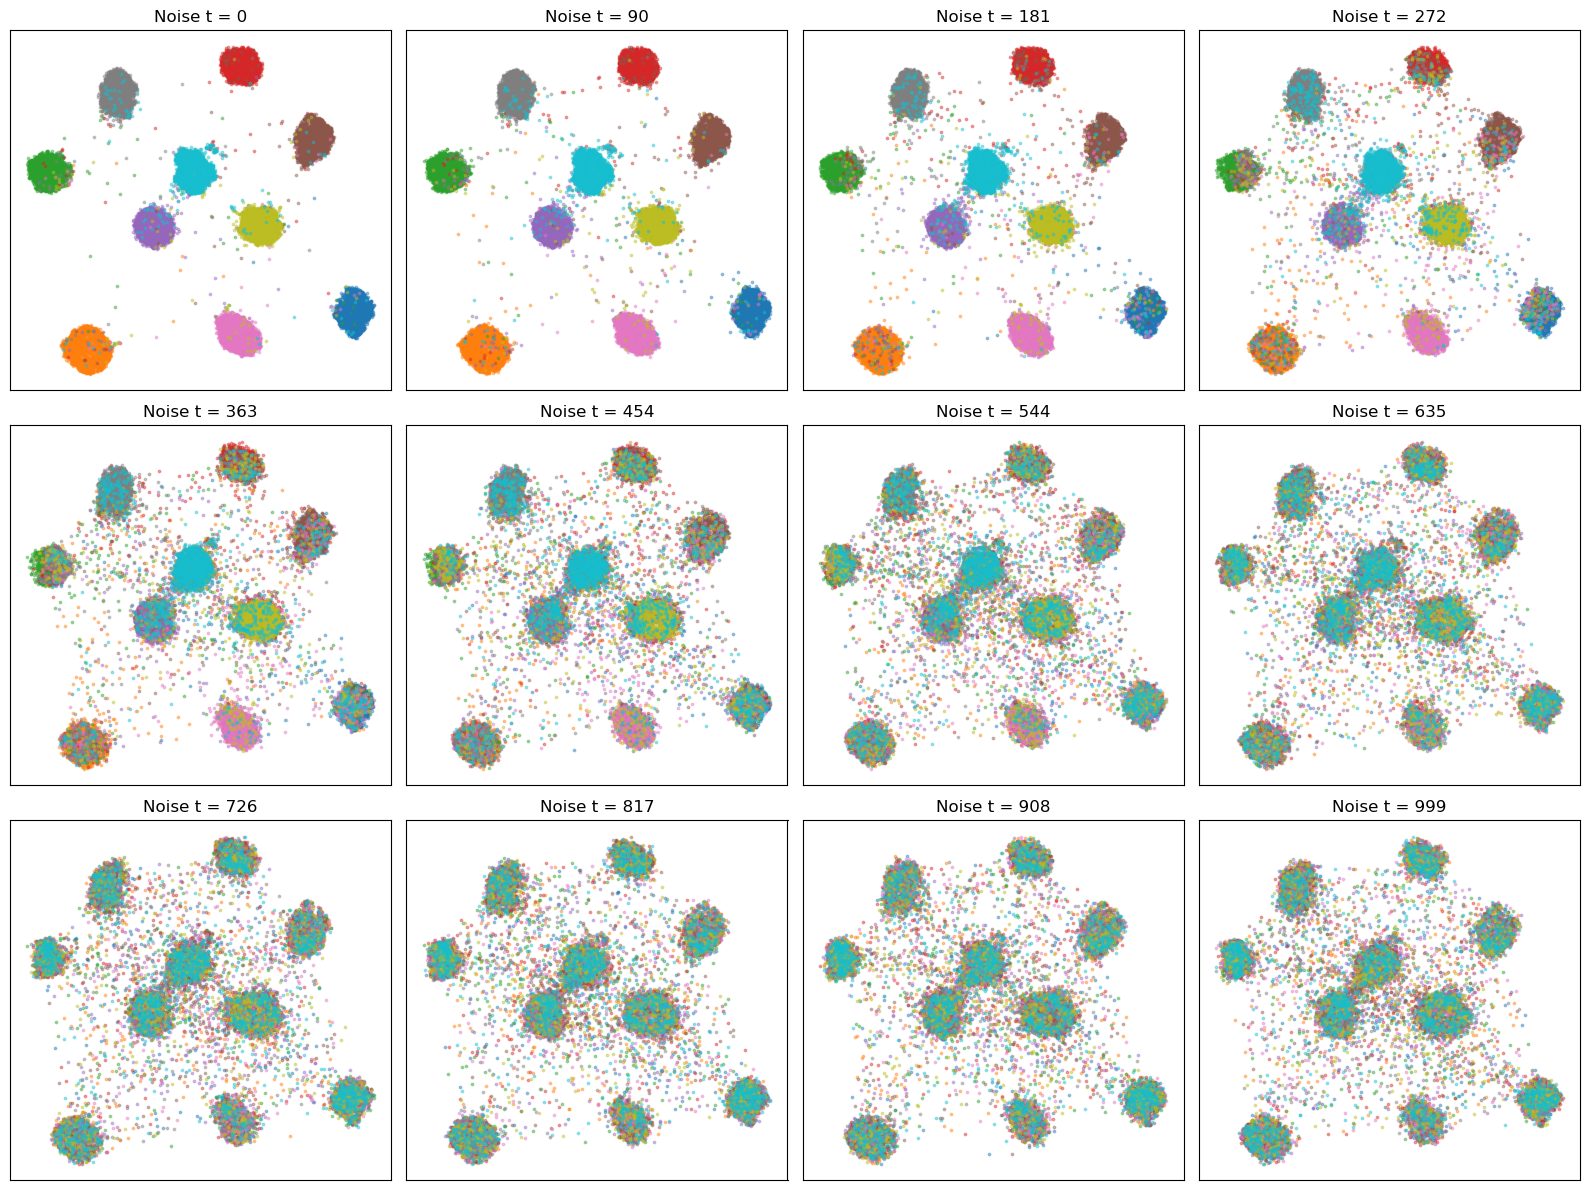

✅ Saved 'latent_space_progression.svg'


In [25]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import umap

device = z_sampled.device

# =========================================================
# 0. Settings
# =========================================================
T = 1000
N_FRAMES = 12              # number of UMAP snapshots
fracs = np.linspace(0, 1, N_FRAMES)
N_points = len(z_sampled)

print(f"[info] Using {N_points} latent points, {N_FRAMES} noise frames.")

# =========================================================
# 1. Simple linear beta schedule
# =========================================================
def linear_beta_schedule(T, beta_min=1e-4, beta_max=0.02):
    return torch.linspace(beta_min, beta_max, T)

betas = linear_beta_schedule(T).to(device)
alphas = 1 - betas
alphas_bar = torch.cumprod(alphas, dim=0)   # shape [T]

# =========================================================
# 2. q(z_t | z0) for entire dataset
# =========================================================
@torch.no_grad()
def q_sample_full(z0_batch, t):
    """
    Forward diffusion for ALL latent samples at timestep t.
    z0_batch: [N, D]
    """
    noise = torch.randn_like(z0_batch)
    sqrt_ab  = torch.sqrt(alphas_bar[t])
    sqrt_mab = torch.sqrt(1 - alphas_bar[t])
    return sqrt_ab * z0_batch + sqrt_mab * noise


# =========================================================
# 3. Compute all noised clouds
# =========================================================
frames = []      # each element a numpy array [N, D]

indices = (fracs * (T-1)).astype(int)

print("[info] Computing noisy frames...")
for t in indices:
    zt = q_sample_full(z_sampled, t)     # [N, D]
    frames.append(zt.cpu().numpy())

print("[info] Generated all noise frames.")


# =========================================================
# 4. Fit UMAP once on the clean latent space
# =========================================================
print("[info] Fitting UMAP on clean latent space...")
um = umap.UMAP(n_components=2, random_state=0)
z_umap_0 = um.fit_transform(z_sampled.cpu().numpy())   # [N, 2]
y_np = y_sampled.cpu().numpy()

print("[info] UMAP fitted.")


# =========================================================
# 5. Transform each noised cloud
# =========================================================
print("[info] Projecting noise frames through UMAP...")
z_umap_frames = []
for i, zt in enumerate(frames):
    zt_umap = um.transform(zt)     # [N,2]
    z_umap_frames.append(zt_umap)

print("[info] UMAP projection done.")


# =========================================================
# 6. Plot snapshots in a grid
# =========================================================
palette = sns.color_palette("tab10", 10)
ncols = 4
nrows = int(np.ceil(N_FRAMES / ncols))

plt.figure(figsize=(4*ncols, 4*nrows))

for i in range(N_FRAMES):
    plt.subplot(nrows, ncols, i+1)
    zt = z_umap_frames[i]

    for digit in range(10):
        idx = (y_np == digit)
        plt.scatter(
            zt[idx, 0], zt[idx, 1],
            s=3, alpha=0.4, color=palette[digit]
        )

    plt.title(f"Noise t = {indices[i]}")
    plt.xticks([]); plt.yticks([])

plt.tight_layout()
plt.savefig("latent_space_progression.svg", format="svg")
plt.show()

print("✅ Saved 'latent_space_progression.svg'")


[info] z_sampled shape = torch.Size([20000, 10])

[info] Loading decoder weights…
Skipping key: encoder.0.weight  (shape mismatch or not decoder)
Skipping key: encoder.0.bias  (shape mismatch or not decoder)
Skipping key: encoder.1.weight  (shape mismatch or not decoder)
Skipping key: encoder.1.bias  (shape mismatch or not decoder)
Skipping key: encoder.1.running_mean  (shape mismatch or not decoder)
Skipping key: encoder.1.running_var  (shape mismatch or not decoder)
Skipping key: encoder.1.num_batches_tracked  (shape mismatch or not decoder)
Skipping key: encoder.3.weight  (shape mismatch or not decoder)
Skipping key: encoder.3.bias  (shape mismatch or not decoder)
Skipping key: encoder.4.weight  (shape mismatch or not decoder)
Skipping key: encoder.4.bias  (shape mismatch or not decoder)
Skipping key: encoder.4.running_mean  (shape mismatch or not decoder)
Skipping key: encoder.4.running_var  (shape mismatch or not decoder)
Skipping key: encoder.4.num_batches_tracked  (shape mismatc

100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 7190.65it/s]

[info] Trajectory decoded successfully.


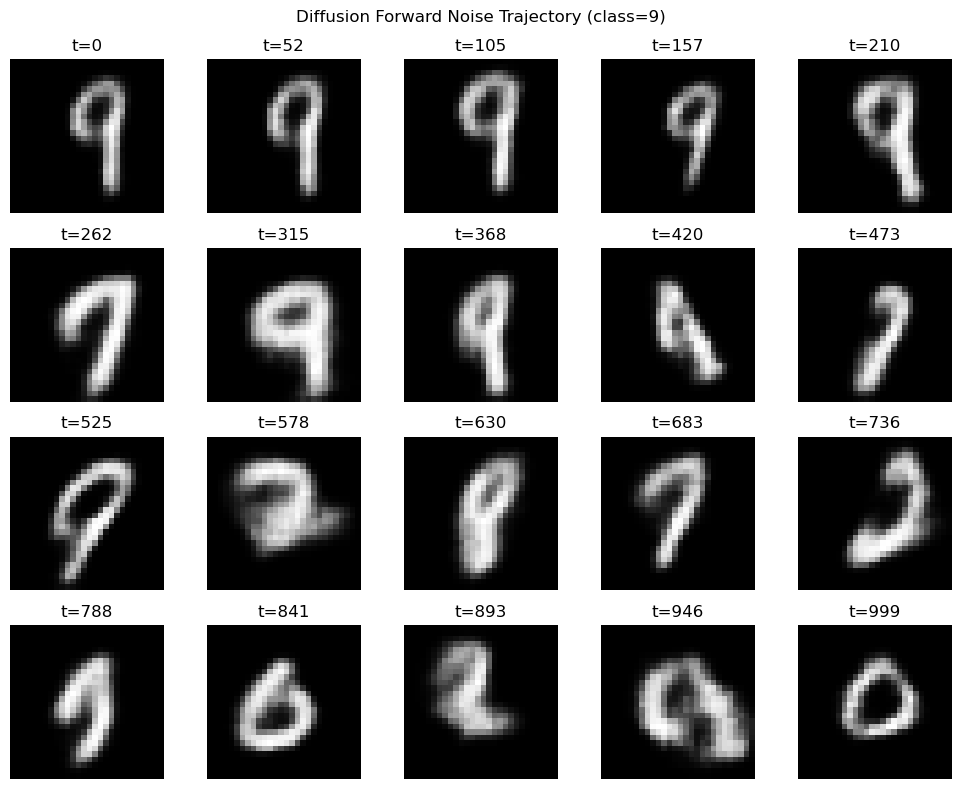

✅ Done: diffusion trajectory decoded.


In [39]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

# ============================================================
# Load your L2 latent space (must exist)
# ============================================================
print(f"[info] z_sampled shape = {z_sampled.shape}")
device = z_sampled.device
latent_dim = z_sampled.shape[1]

# ============================================================
# VAE Decoder with correct architecture
# ============================================================
class VAE_Decoder(nn.Module):
    def __init__(self, latent_dim=10):
        super().__init__()
        self.decoder_input = nn.Linear(latent_dim, 64 * 7 * 7)
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (64, 7, 7)),
            nn.ConvTranspose2d(64, 32, 4, 2, 1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 4, 2, 1),
            nn.Sigmoid()
        )

    def decode(self, z):
        z = self.decoder_input(z)          # [B, 3136]
        return self.decoder(z)             # [B, 1, 28, 28]


# ============================================================
# Load decoder weights from full VAE checkpoint
# ============================================================
print("\n[info] Loading decoder weights…")

full_state = torch.load("conv_vae_with_classifier.pth", map_location="cpu")
decoder_state = {}

for k, v in full_state.items():
    if k.startswith("decoder_input") or k.startswith("decoder."):
        decoder_state[k] = v
    else:
        print(f"Skipping key: {k}  (shape mismatch or not decoder)")

vae_decoder = VAE_Decoder(latent_dim).to(device)
missing = set(vae_decoder.state_dict().keys()) - set(decoder_state.keys())

vae_decoder.load_state_dict(decoder_state, strict=False)
vae_decoder.eval()

print(f"\n[info] Decoder keys loaded: {list(decoder_state.keys())}")
print(f"[info] Missing decoder keys (random init): {missing}")
print(f"[info] decoder_input weight shape = {vae_decoder.decoder_input.weight.shape}")
print(f"[info] decoder_input bias shape   = {vae_decoder.decoder_input.bias.shape}")

# ============================================================
# Diffusion schedule (forward noising)
# ============================================================
def linear_beta_schedule(T, beta_min=1e-4, beta_max=0.02):
    return torch.linspace(beta_min, beta_max, T)

T = 1000
betas = linear_beta_schedule(T).to(device)
alphas = 1 - betas
alphas_bar = torch.cumprod(alphas, dim=0)

@torch.no_grad()
def q_sample_latent(z0, t):
    """Forward diffusion q(z_t | z_0)."""
    noise = torch.randn_like(z0)
    return (
        torch.sqrt(alphas_bar[t]) * z0 +
        torch.sqrt(1 - alphas_bar[t]) * noise
    )


# ============================================================
# Pick one latent point to diffuse
# ============================================================
idx0 = torch.randint(len(z_sampled), (1,))
z0 = z_sampled[idx0].reshape(1, latent_dim).to(device)  # FIXED SHAPE
label0 = int(y_sampled[idx0])

print(f"\n[info] Selected index = {idx0.item()}, class = {label0}")
print(f"[debug] z0 shape = {z0.shape}")

with torch.no_grad():
    z0_dec = vae_decoder.decoder_input(z0)
print(f"[debug] decoder_input(z0) shape = {z0_dec.shape}")

# ============================================================
# Generate noisy trajectory + decode to images
# ============================================================
timesteps = torch.linspace(0, T - 1, 20).long()
decoded_frames = []

print("\nDecoding diffusion trajectory:")
with torch.no_grad():
    for t in tqdm(timesteps):
        zt = q_sample_latent(z0, t)
        x_recon = vae_decoder.decode(zt)     # [1,1,28,28]
        decoded_frames.append(x_recon[0, 0].detach().cpu().numpy())

decoded_frames = np.stack(decoded_frames, axis=0)
print("[info] Trajectory decoded successfully.")


# ============================================================
# Plot 20 decoded diffusion images
# ============================================================
fig, axs = plt.subplots(4, 5, figsize=(10, 8))
axs = axs.flatten()

for i in range(20):
    axs[i].imshow(decoded_frames[i], cmap="gray")
    axs[i].set_title(f"t={timesteps[i].item()}")
    axs[i].axis("off")

plt.suptitle(f"Diffusion Forward Noise Trajectory (class={label0})")
plt.tight_layout()
plt.show()

print("✅ Done: diffusion trajectory decoded.")
